# CcGAN Train

This notebook is used to train CcGAN.

## Step 1 - Import Libraries and Set Arguments

First we import others' libraries.

In [1]:
import copy
import gc
import h5py
import matplotlib.pyplot as plt
import numpy as np
import os
import pandas as pd
import random
import timeit
import torch
import torch.backends.cudnn as cudnn
from torchinfo import summary as summary_torchinfo
import torch.nn as nn
import torch.nn.functional as F
from torchsummary import summary
import torchvision
from torchvision.utils import save_image
from tqdm import tqdm

Next import our own libraries.

In [2]:
from models import *

And then we set the arguments.

Not all arguments here are useful in the following codes.

In [3]:
# Overall Settings
DATA_PATH = "./datasets/Ra_128_indexed.h5"
SAVE_OUTPUTS_DIR = "./output/saved_outputs"
SAVE_IMAGES_DIR = "./output/saved_images"
EMBED_MODELS_DIR = "./output/embed_models"
CCGAN_MODELS_DIR = "./output/CcGAN_models"
SEED = 42
NUM_WORKERS = 0

# Dataset
DATA_SPLIT = "train"
MIN_LABEL = 1.3
MAX_LABEL = 5.2
NUM_CHANNELS = 3
IMG_SIZE = 128
MAX_NUM_IMG_PER_LABEL = 1000
MAX_NUM_IMG_PER_LABEL_AFTER_REPLICA = 0
SHOW_REAL_IMGS = True
VISUALIZE_FAKE_IMAGES = True

# Embedding Settings
NET_EMBED = "ResNet34_embed"
DIM_EMBED = 128

# Embedding Training Settings
BASE_LR_X2Y = 0.01
BASE_LR_Y2H = 0.01
EPOCH_NET_EMBED = 200
RESUME_EPOCH_NET_EMBED = 0
EPOCH_NET_Y2H = 500
BATCH_SIZE_EMBED = 256

# GAN Settings
GAN = "CcGAN"
GAN_ARCH = "SAGAN"
LOSS_TYPE_GAN = "hinge"
DIM_GAN = 128
CGAN_NUM_CLASSES = 20
KERNEL_SIGMA = -1.0
THRESHOLD_TYPE = "soft"
KAPPA = -2.0

# GAN Training Settings
NITERS_GAN = 30000
RESUME_NITERS_GAN = 0
SAVE_NITERS_FREQ = 5000
LR_G = 1e-4
LR_D = 1e-4
BATCH_SIZE_DISC = 64
BATCH_SIZE_GENE = 64
NUM_D_STEPS = 4
VISUALIZE_FREQ = 1000
NONZERO_SOFT_WEIGHT_THRESHOLD = 1e-3

# DiffAugment Settings
GAN_DIFFAUGMENT = True
GAN_DIFFAUGMENT_POLICY = "color,translation,cutout"

# Evaluation Settings
EVAL_MODE = 2
NUM_EVAL_LABELS = -1
SAMP_BATCH_SIZE = 1000
NFAKE_PER_LABEL = 200
NREAL_PER_LABEL = -1
COMP_FID = True
EPOCH_FID_CNN = 200
FID_RADIUS = 0
FID_NUM_CENTERS = -1
DUMP_FAKE_FOR_NIQE = True

## Step 2 - Settings

In this part we make configurations:

1. Device
2. Seeds
3. Paths

In [ ]:
# Device
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Seeds
random.seed(SEED)
torch.manual_seed(SEED)
torch.backends.cudnn.deterministic = True
cudnn.benchmark = False
np.random.seed(SEED)

# Paths - From arguments
if not os.path.exists(SAVE_OUTPUTS_DIR):
    os.makedirs(SAVE_OUTPUTS_DIR, exist_ok=True)
if not os.path.exists(SAVE_IMAGES_DIR):
    os.makedirs(SAVE_IMAGES_DIR, exist_ok=True)
if not os.path.exists(EMBED_MODELS_DIR):
    os.makedirs(EMBED_MODELS_DIR, exist_ok=True)
if not os.path.exists(CCGAN_MODELS_DIR):
    os.makedirs(CCGAN_MODELS_DIR, exist_ok=True)

# Paths - Embedding
EMBED_X2Y_CKPT_DIR = os.path.join(
    EMBED_MODELS_DIR,
    f"ckpt_embed_x2y_{NET_EMBED}_dim_{DIM_EMBED}_batchSize_{BATCH_SIZE_EMBED}_lr_{BASE_LR_X2Y:.0e}_seed_{SEED}",
)
if not os.path.exists(EMBED_X2Y_CKPT_DIR):
    os.makedirs(EMBED_X2Y_CKPT_DIR)
EMBED_X2Y_PATH = os.path.join(
    EMBED_MODELS_DIR,
    f"embed_x2y_{NET_EMBED}_dim_{DIM_EMBED}_batchSize_{BATCH_SIZE_EMBED}_lr_{BASE_LR_X2Y:.0e}_epoch_{EPOCH_NET_EMBED}_seed_{SEED}.pth",
)
Y2H_PATH = os.path.join(
    EMBED_MODELS_DIR,
    f"y2h_{NET_EMBED}_dim_{DIM_EMBED}_batchSize_{BATCH_SIZE_EMBED}_lr_{BASE_LR_Y2H:.0e}_epoch_{EPOCH_NET_Y2H}_seed_{SEED}.pth",
)

## Step 3 - Define Basic Classes and Functions

We need to use some basic classes and functions later, so we define them here.

### Step 3.1 - Function `normalize_images`

Normalize the batch images' pixel values from $[0, 255]$ to $[-1, 1]$.

In [5]:
def normalize_images(batch_images):
    batch_images = batch_images / 255.0
    batch_images = (batch_images - 0.5) / 0.5
    return batch_images

### Step 3.2 - Function `view_dataset`

Function `view_dataset` accepts a dataset path, and prints the basic structure of a dataset.

In [6]:
def _print_hdf5(name, obj):
    indent = "  " * name.count("/")
    if isinstance(obj, h5py.Dataset):
        print(f"{indent}[Dataset] {name} shape={obj.shape} dtype={obj.dtype}")
    elif isinstance(obj, h5py.Group):
        print(f"{indent}[Group]   {name}")


def view_dataset(dataset_path):
    with h5py.File(dataset_path, "r") as f:
        f.visititems(_print_hdf5)

### Step 3.3 - Data Argumentation Functions

| Function           | Purpose             | Category         |
| ------------------ | ------------------- | ---------------- |
| `rand_brightness`  | Random brightness   | Color augment    |
| `rand_saturation`  | Random saturation   | Color augment    |
| `rand_contrast`    | Random contrast     | Color augment    |
| `rand_translation` | Random translation  | Geometric        |
| `rand_cutout`      | Random occlusion    | Pixel masking    |
| `DiffAugment`      | Apply augmentations | Strategy manager |

`rand_brightness` function adds a random brightness swift in $\left(-0.5, 0.5\right)$.

In [7]:
def rand_brightness(x):
    x = x + (torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) - 0.5)
    return x

`rand_saturation` function randomly adjusts image saturation.

In [8]:
def rand_saturation(x):
    x_mean = x.mean(dim=1, keepdim=True)
    x = (x - x_mean) * (
        torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) * 2
    ) + x_mean
    return x

`rand_contrast` function randomly adjusts image contrast.

In [9]:
def rand_contrast(x):
    x_mean = x.mean(dim=[1, 2, 3], keepdim=True)
    x = (x - x_mean) * (
        torch.rand(x.size(0), 1, 1, 1, dtype=x.dtype, device=x.device) + 0.5
    ) + x_mean
    return x

`rand_translation` function randomly translates (shifts) the image.

In [10]:
def rand_translation(x, ratio=0.125):
    shift_x, shift_y = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    translation_x = torch.randint(
        -shift_x, shift_x + 1, size=[x.size(0), 1, 1], device=x.device
    )
    translation_y = torch.randint(
        -shift_y, shift_y + 1, size=[x.size(0), 1, 1], device=x.device
    )
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(x.size(2), dtype=torch.long, device=x.device),
        torch.arange(x.size(3), dtype=torch.long, device=x.device),
    )
    grid_x = torch.clamp(grid_x + translation_x + 1, 0, x.size(2) + 1)
    grid_y = torch.clamp(grid_y + translation_y + 1, 0, x.size(3) + 1)
    x_pad = F.pad(x, [1, 1, 1, 1, 0, 0, 0, 0])
    x = (
        x_pad.permute(0, 2, 3, 1)
        .contiguous()[grid_batch, grid_x, grid_y]
        .permute(0, 3, 1, 2)
    )
    return x

`rand_cutout` functino randomly masks out a rectangular region of the image (cutout).

In [11]:
def rand_cutout(x, ratio=0.5):
    cutout_size = int(x.size(2) * ratio + 0.5), int(x.size(3) * ratio + 0.5)
    offset_x = torch.randint(
        0, x.size(2) + (1 - cutout_size[0] % 2), size=[x.size(0), 1, 1], device=x.device
    )
    offset_y = torch.randint(
        0, x.size(3) + (1 - cutout_size[1] % 2), size=[x.size(0), 1, 1], device=x.device
    )
    grid_batch, grid_x, grid_y = torch.meshgrid(
        torch.arange(x.size(0), dtype=torch.long, device=x.device),
        torch.arange(cutout_size[0], dtype=torch.long, device=x.device),
        torch.arange(cutout_size[1], dtype=torch.long, device=x.device),
    )
    grid_x = torch.clamp(
        grid_x + offset_x - cutout_size[0] // 2, min=0, max=x.size(2) - 1
    )
    grid_y = torch.clamp(
        grid_y + offset_y - cutout_size[1] // 2, min=0, max=x.size(3) - 1
    )
    mask = torch.ones(x.size(0), x.size(2), x.size(3), dtype=x.dtype, device=x.device)
    mask[grid_batch, grid_x, grid_y] = 0
    x = x * mask.unsqueeze(1)
    return x

`DiffAugment` is the master function to apply multiple augmentation strategies.

In [12]:
AUGMENT_FNS = {
    "color": [rand_brightness, rand_saturation, rand_contrast],
    "translation": [rand_translation],
    "cutout": [rand_cutout],
}


def DiffAugment(x, policy="", channels_first=True):
    if policy:
        if not channels_first:
            x = x.permute(0, 3, 1, 2)
        for p in policy.split(","):
            for f in AUGMENT_FNS[p]:
                x = f(x)
        if not channels_first:
            x = x.permute(0, 2, 3, 1)
        x = x.contiguous()
    return x

### Step 3.4 - Class `Label_dataset`

`Imgs_dataset` is derived from class `torch.utils.data.Dataset`.

In [13]:
class Label_dataset(torch.utils.data.Dataset):
    def __init__(self, labels):
        super(Label_dataset, self).__init__()
        self.labels = labels
        self.n_samples = len(self.labels)

    def __getitem__(self, index):
        y = self.labels[index]
        return y

    def __len__(self):
        return self.n_samples

### Step 3.5 - Class `Imgs_dataset`

`Imgs_dataset` is derived from class `torch.utils.data.Dataset`.

In [14]:
class Imgs_dataset(torch.utils.data.Dataset):
    def __init__(self, images, labels=None, normalize=False):
        super(Imgs_dataset, self).__init__()
        self.images = images
        self.n_images = len(self.images)
        self.labels = labels
        if labels is not None:
            if len(self.images) != len(self.labels):
                raise Exception(
                    "images ("
                    + str(len(self.images))
                    + ") and labels ("
                    + str(len(self.labels))
                    + ") do not have the same length!!!"
                )
        self.normalize = normalize

    def __getitem__(self, index):
        image = self.images[index]
        if self.normalize:
            image = image / 255.0
            image = (image - 0.5) / 0.5
        if self.labels is not None:
            label = self.labels[index]
            return (image, label)
        else:
            return image

    def __len__(self):
        return self.n_images

## Step 4 - Load and Process Data

In the next code block we will get the following `numpy.ndarray`: 

1. `labels_all`: all the original labels
2. `images_all`: all the original images, shape `(N, 3, H, W)`
3. `index_train`: indexes for training

### Step 4.1 - Load data from the `.h5` dataset

In [15]:
# View dataset structure
view_dataset(DATA_PATH)
print("")

# Load data from h5 file
hf = h5py.File(DATA_PATH, 'r')
labels_all = hf['labels'][:]
images_all = hf['images'][:]
index_train = hf['index_train'][:]
hf.close()

# Change the data type and shape to fit the model
labels_all = labels_all.astype(float)
images_all = images_all.transpose(0, 3, 1, 2)

print(f"`images_all` shape: {images_all.shape}, dtype: {images_all.dtype}")
print(f"`labels_all` shape: {labels_all.shape}, dtype: {labels_all.dtype}")
print(f"`index_train` shape: {index_train.shape}, dtype: {index_train.dtype}")

[Dataset] images shape=(9192, 128, 128, 3) dtype=uint8
[Dataset] index_train shape=(4596,) dtype=int64
[Dataset] index_valid shape=(4596,) dtype=int64
[Dataset] labels shape=(9192,) dtype=float64
[Dataset] types shape=(9192,) dtype=int32



`images_all` shape: (9192, 3, 128, 128), dtype: uint8
`labels_all` shape: (9192,), dtype: float64
`index_train` shape: (4596,), dtype: int64


### Step 4.2 - Split the training dataset

We split the data. Rule:

- If `args.data_split` is `train`, use `index_train` as the set of training indexes.
- Otherwise, use all data as the training set.

After the next block we will get:

1. `images_train`: the training set images (subset of `images_all`)
2. `labels_train_raw`: the training set labels (subset of `labels_all`)

In [16]:
# data split
print(f"Data split: {DATA_SPLIT}")
print("")
if DATA_SPLIT == "train":
    images_train = images_all[index_train]
    labels_train_raw = labels_all[index_train]
else:
    images_train = copy.deepcopy(images_all)
    labels_train_raw = copy.deepcopy(labels_all)

# Print the data split result
print(f"`images_train` shape: {images_train.shape}, dtype: {images_train.dtype}")
print(f"`labels_train_raw` shape: {labels_train_raw.shape}, dtype: {labels_train_raw.dtype}")

Data split: train

`images_train` shape: (4596, 3, 128, 128), dtype: uint8
`labels_train_raw` shape: (4596,), dtype: float64


### Step 4.3 - Label range limitation

We only take images with label in $\left(q_1, q_2\right)$, where $q_1 = \text{min label}$ and $q_2 = \text{max label}$.

In the following block we set limitation on training data. And if `args.visualize_fake_images` is `True` or `args.comp_FID` is `True`, we will also set limitation on all data.

In this part we updated `images_train` and `labels_train_raw` (training data), as well as `images_all` and `labels_all` (all data).

In [17]:
# Limitation on training data
q1 = MIN_LABEL
q2 = MAX_LABEL
indx = np.where((labels_train_raw>q1)*(labels_train_raw<q2)==True)[0]
labels_train_raw = labels_train_raw[indx]
images_train = images_train[indx]
assert len(labels_train_raw)==len(images_train)
print(f"`images_train` shape: {images_train.shape}, dtype: {images_train.dtype}")
print(f"`labels_train_raw` shape: {labels_train_raw.shape}, dtype: {labels_train_raw.dtype}")
print("")

# Limitation on all data
if VISUALIZE_FAKE_IMAGES or COMP_FID:
    indx = np.where((labels_all>q1)*(labels_all<q2)==True)[0]
    labels_all = labels_all[indx]
    images_all = images_all[indx]
    assert len(labels_all)==len(images_all)
    print(f"`images_all` shape: {images_all.shape}, dtype: {images_all.dtype}")
    print(f"`labels_all` shape: {labels_all.shape}, dtype: {labels_all.dtype}")

`images_train` shape: (4596, 3, 128, 128), dtype: uint8
`labels_train_raw` shape: (4596,), dtype: float64

`images_all` shape: (9192, 3, 128, 128), dtype: uint8
`labels_all` shape: (9192,), dtype: float64


### Step 4.4 - Image number limitation

For each label value, we allow at most `args.max_num_img_per_label` images occur in the training set. This step randomly selects the images and labels and update `images_train` and `labels_train_raw`.

This step may only have influences on the training set.

In [18]:
# for each angle, take no more than args.max_num_img_per_label images
image_num_threshold = MAX_NUM_IMG_PER_LABEL
print("Original set has {} images; For each angle, take no more than {} images.".format(len(images_train), image_num_threshold))
unique_labels_tmp = np.sort(np.array(list(set(labels_train_raw))))
for i in tqdm(range(len(unique_labels_tmp))):
    indx_i = np.where(labels_train_raw == unique_labels_tmp[i])[0]
    if len(indx_i)>image_num_threshold:
        np.random.shuffle(indx_i)
        indx_i = indx_i[0:image_num_threshold]
    if i == 0:
        sel_indx = indx_i
    else:
        sel_indx = np.concatenate((sel_indx, indx_i))
images_train = images_train[sel_indx]
labels_train_raw = labels_train_raw[sel_indx]
print("{} images left and there are {} unique labels".format(len(images_train), len(set(labels_train_raw))))
print("")
print(f"`images_train` shape: {images_train.shape}, dtype: {images_train.dtype}")
print(f"`labels_train_raw` shape: {labels_train_raw.shape}, dtype: {labels_train_raw.dtype}")

Original set has 4596 images; For each angle, take no more than 1000 images.



  0%|                                                                                                                               | 0/740 [00:00<?, ?it/s]


100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 740/740 [00:00<00:00, 135459.56it/s]

4596 images left and there are 740 unique labels

`images_train` shape: (4596, 3, 128, 128), dtype: uint8
`labels_train_raw` shape: (4596,), dtype: float64


### Step 4.5 - Normalization

From the following block we get `labels_train` — the normalized labels, ranging from $0$ to $1$.

$$
\text{normalized training labels} = \frac{\text{training labels} - \text{min label}}{\text{max label} - \text{min label}} \in \left[0, 1\right]
$$

In [19]:
# Normalize labels
labels_train = (labels_train_raw - MIN_LABEL) / (MAX_LABEL - MIN_LABEL)    
print("Preset `min_label`: {}, `max_label`: {}".format(MIN_LABEL, MAX_LABEL))
print("Range of `labels_train_raw`: ({},{})".format(np.min(labels_train_raw), np.max(labels_train_raw)))
print("Range of `labels_train`: ({},{})".format(np.min(labels_train), np.max(labels_train)))

Preset `min_label`: 1.3, `max_label`: 5.2
Range of `labels_train_raw`: (1.349,5.177)
Range of `labels_train`: (0.012564102564102545,0.9941025641025639)


### Step 4.6 - Calculate $\sigma$ and $\kappa$

We calculate $\sigma$ and $\kappa$ value of the dataset (if `KERNEL_SIGMA` or `KERNEL_KAPPA` is negative).

We calculate $\sigma$ by

$$
\sigma = \left(\frac{4 \hat{\sigma}_{y^r}^5}{3 N^r}\right)^{\frac{1}{5}}
$$

where $\hat{\sigma}_{y^r}$ is the sample standard deviation of normalized labels in the training set.

In [20]:
# Set `kernel_sigma`
if KERNEL_SIGMA < 0:

    std_label = np.std(labels_train)
    KERNEL_SIGMA = 1.06 * std_label * (len(labels_train)) ** (-1 / 5)

print("`kernel_sigma`: {}".format(KERNEL_SIGMA))

`kernel_sigma`: 0.04697700151079382


We calculate $\kappa$ as follows: Let
$$
\kappa_{\text{base}} = \max \left(y_{[2]}^r - y_{[1]}^r, y_{[3]}^r - y_{[2]}^r, \cdots, y_{\left[N_{\text{uy}}^r\right]}^r - y_{\left[N_{\text{uy}}^r - 1\right]}^r\right)
$$
where $y_{[l]}^r$ is the $l$-th smallest normalized distinct real label and $N_{\text{uy}}^r$ is the number of normalized distinct labels in the training set.

Then $\kappa$ is set as
$$
\kappa = m_{\kappa} \kappa_{\text{base}}
$$
where $m_{\kappa}$ stands for $50\%$ of the minimum number of neighboring labels used for estimating $p_r\left(x | y\right)$ given a label $y$.

For example, $m_{\kappa} = 1$ implies using $2$ neighboring labels (one on the left and the other one on the right).

In experiments $m_{\kappa}$ is generally set as $1$ or $2$. In some extreme cases when many distinct labels have too few real samples, we may consider increasing $m_{\kappa}$. We also found $\nu = \frac{1}{\kappa^2}$ works well in the experiments.

In [21]:
# Set `kappa`
if KAPPA < 0:
    unique_labels_norm = np.sort(np.array(list(set(labels_train))))
    n_unique = len(unique_labels_norm)

    diff_list = []
    for i in range(1, n_unique):
        diff_list.append(unique_labels_norm[i] - unique_labels_norm[i - 1])
    kappa_base = np.abs(KAPPA) * np.max(np.array(diff_list))

    if THRESHOLD_TYPE == "hard":
        KAPPA = kappa_base
    else:
        KAPPA = 1 / kappa_base**2

print("`kappa`: {}".format(KAPPA))

`kappa`: 108.73916897823854


## Step 5 - Pre-trained CNN and GAN for Label Embedding

Define function `train_net_embed`.

In [ ]:
def train_net_embed(
    net,
    trainloader,
    testloader,
    epochs=200,
    resume_epoch=0,
    lr_base=0.01,
    lr_decay_factor=0.1,
    lr_decay_epochs=[80, 140],
    weight_decay=1e-4,
    path_to_ckpt=None,
):

    # Learning rate decay
    def adjust_learning_rate_embed(optimizer, epoch):
        lr = lr_base
        num_decays = len(lr_decay_epochs)
        for decay_i in range(num_decays):
            if epoch >= lr_decay_epochs[decay_i]:
                lr = lr * lr_decay_factor
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr

    # Set up the model
    net = net.to(device)
    criterion = nn.MSELoss()
    optimizer = torch.optim.SGD(
        net.parameters(), lr=lr_base, momentum=0.9, weight_decay=weight_decay
    )

    # Load checkpoint if `resume_epoch` > 0
    if path_to_ckpt is not None and resume_epoch > 0:

        EMBED_X2Y_CKPT_PATH = os.path.join(EMBED_X2Y_CKPT_DIR, f"{resume_epoch}.pth")
        checkpoint = torch.load(EMBED_X2Y_CKPT_PATH)
        net.load_state_dict(checkpoint["net_state_dict"])
        optimizer.load_state_dict(checkpoint["optimizer_state_dict"])
        torch.set_rng_state(checkpoint["rng_state"])

    # Start the timer
    start_tmp = timeit.default_timer()

    # Train the model
    for epoch in range(resume_epoch, epochs):

        # Train mode
        net.train()

        # Init the loss
        train_loss = 0

        # Adjust learning rate
        adjust_learning_rate_embed(optimizer, epoch)

        # Iterate through the training data
        for _, (batch_train_images, batch_train_labels) in enumerate(trainloader):

            batch_train_images = batch_train_images.type(torch.float).to(device)
            batch_train_labels = (
                batch_train_labels.type(torch.float).reshape(-1, 1).to(device)
            )

            # Forward pass
            outputs, _ = net(batch_train_images)
            loss = criterion(outputs, batch_train_labels)

            # backward pass
            optimizer.zero_grad()
            loss.backward()
            optimizer.step()

            # Update the loss
            train_loss += loss.cpu().item() * batch_train_images.size(0)

        # Calculate the average loss
        train_loss = train_loss / len(trainloader.dataset)

        # Print the training loss
        if testloader is None:
            print(
                "Train net_x2y for embedding: [epoch %d/%d] train_loss:%f Time:%.4f"
                % (epoch + 1, epochs, train_loss, timeit.default_timer() - start_tmp)
            )
        else:
            net.eval()
            with torch.no_grad():
                test_loss = 0
                for batch_test_images, batch_test_labels in testloader:
                    batch_test_images = batch_test_images.type(torch.float).to(device)
                    batch_test_labels = (
                        batch_test_labels.type(torch.float).reshape(-1, 1).to(device)
                    )
                    outputs, _ = net(batch_test_images)
                    loss = criterion(outputs, batch_test_labels)
                    test_loss += loss.cpu().item()
                test_loss = test_loss / len(testloader)

                print(
                    "Train net_x2y for label embedding: [epoch %d/%d] train_loss:%f test_loss:%f Time:%.4f"
                    % (
                        epoch + 1,
                        epochs,
                        train_loss,
                        test_loss,
                        timeit.default_timer() - start_tmp,
                    )
                )

        # Save checkpoint
        if EMBED_X2Y_CKPT_DIR is not None and (
            ((epoch + 1) % 50 == 0) or (epoch + 1 == epochs)
        ):

            EMBED_X2Y_CKPT_PATH = os.path.join(EMBED_X2Y_CKPT_DIR, f"{epoch + 1}.pth")
            os.makedirs(os.path.dirname(EMBED_X2Y_CKPT_PATH), exist_ok=True)
            torch.save(
                {
                    "epoch": epoch,
                    "net_state_dict": net.state_dict(),
                    "optimizer_state_dict": optimizer.state_dict(),
                    "rng_state": torch.get_rng_state(),
                },
                EMBED_X2Y_CKPT_PATH,
            )

    # Return the trained model
    return net

Define function `train_net_y2h`.

In [ ]:
def train_net_y2h(
    unique_labels_norm,
    net_y2h,
    net_embed,
    epochs=500,
    lr_base=0.01,
    lr_decay_factor=0.1,
    lr_decay_epochs=[150, 250, 350],
    weight_decay=1e-4,
    batch_size=128,
):

    # Learning rate decay function
    def adjust_learning_rate_y2h(optimizer, epoch):
        lr = lr_base
        num_decays = len(lr_decay_epochs)
        for decay_i in range(num_decays):
            if epoch >= lr_decay_epochs[decay_i]:
                lr = lr * lr_decay_factor
        for param_group in optimizer.param_groups:
            param_group["lr"] = lr

    assert np.max(unique_labels_norm) <= 1 and np.min(unique_labels_norm) >= 0
    trainset = Label_dataset(unique_labels_norm)
    trainloader = torch.utils.data.DataLoader(
        trainset, batch_size=batch_size, shuffle=True
    )

    net_embed.eval()
    net_h2y = net_embed.module.h2y  # convert embedding labels to original labels
    optimizer_y2h = torch.optim.SGD(
        net_y2h.parameters(), lr=lr_base, momentum=0.9, weight_decay=weight_decay
    )

    # Set timer
    start_tmp = timeit.default_timer()

    # Start training
    for epoch in range(epochs):

        # Train mode
        net_y2h.train()

        # Init the loss
        train_loss = 0

        # Adjust learning rate
        adjust_learning_rate_y2h(optimizer_y2h, epoch)

        # Iterate through the training data
        for _, batch_labels in enumerate(trainloader):

            batch_labels = batch_labels.type(torch.float).reshape(-1, 1).to(device)

            # generate noises which will be added to labels
            batch_size_curr = len(batch_labels)
            batch_gamma = np.random.normal(0, 0.2, batch_size_curr)
            batch_gamma = (
                torch.from_numpy(batch_gamma).reshape(-1, 1).type(torch.float).to(device)
            )

            # add noise to labels
            batch_labels_noise = torch.clamp(batch_labels + batch_gamma, 0.0, 1.0)

            # Forward pass
            batch_hiddens_noise = net_y2h(batch_labels_noise)
            batch_rec_labels_noise = net_h2y(batch_hiddens_noise)

            loss = nn.MSELoss()(batch_rec_labels_noise, batch_labels_noise)

            # backward pass
            optimizer_y2h.zero_grad()
            loss.backward()
            optimizer_y2h.step()

            # Update the loss
            train_loss += loss.cpu().item() * batch_size_curr

        # Calculate the average loss
        train_loss = train_loss / len(trainloader.dataset)

        print(
            "Train net_y2h: [epoch %d/%d] train_loss:%f Time:%.4f"
            % (epoch + 1, epochs, train_loss, timeit.default_timer() - start_tmp)
        )

    return net_y2h

Use the two functions to train `net_embed` and `net_y2h`.

In [ ]:
# Prepare the dataset for training
trainset = Imgs_dataset(images_train, labels_train, normalize=True)

# Create the DataLoader for training
trainloader_embed_net = torch.utils.data.DataLoader(
    trainset, batch_size=BATCH_SIZE_EMBED, shuffle=True, num_workers=NUM_WORKERS
)

# Get net embed type
if NET_EMBED == "ResNet18_embed":
    net_embed = ResNet18_embed(dim_embed=DIM_EMBED)
elif NET_EMBED == "ResNet34_embed":
    net_embed = ResNet34_embed(dim_embed=DIM_EMBED)
elif NET_EMBED == "ResNet50_embed":
    net_embed = ResNet50_embed(dim_embed=DIM_EMBED)
net_embed = net_embed.to(device)
net_embed = nn.DataParallel(net_embed)

# Get net y2h type
net_y2h = model_y2h(dim_embed=DIM_EMBED)
net_y2h = net_y2h.to(device)
net_y2h = nn.DataParallel(net_y2h)

# Train net_embed first: x2h+h2y
if not os.path.isfile(EMBED_X2Y_PATH):
    print("Start training CNN for label embedding.")
    net_embed = train_net_embed(
        net=net_embed,
        trainloader=trainloader_embed_net,
        testloader=None,
        epochs=EPOCH_NET_EMBED,
        resume_epoch=RESUME_EPOCH_NET_EMBED,
        lr_base=BASE_LR_X2Y,
        lr_decay_factor=0.1,
        lr_decay_epochs=[80, 140],
        weight_decay=1e-4,
        path_to_ckpt=EMBED_MODELS_DIR,
    )
    # save model
    torch.save(
        {
            "net_state_dict": net_embed.state_dict(),
        },
        EMBED_X2Y_PATH,
    )
else:
    print("`net_embed` ckpt already exists, loading it.")
    print("")
    checkpoint = torch.load(EMBED_X2Y_PATH)
    net_embed.load_state_dict(checkpoint["net_state_dict"])

# Train y2h
if not os.path.isfile(Y2H_PATH):
    print("Start training `net_y2h`.")
    net_y2h = train_net_y2h(
        unique_labels_norm,
        net_y2h,
        net_embed,
        epochs=EPOCH_NET_Y2H,
        lr_base=BASE_LR_Y2H,
        lr_decay_factor=0.1,
        lr_decay_epochs=[150, 250, 350],
        weight_decay=1e-4,
        batch_size=128,
    )
    # save model
    torch.save(
        {
            "net_state_dict": net_y2h.state_dict(),
        },
        Y2H_PATH,
    )
else:
    print("`net_y2h` ckpt already exists, loading it.")
    print("")
    checkpoint = torch.load(Y2H_PATH)
    net_y2h.load_state_dict(checkpoint["net_state_dict"])

# Print the model summary
print("Net Embed Summary")
summary(net_embed, input_size=(NUM_CHANNELS, IMG_SIZE, IMG_SIZE))
print("")
print("Net Y2H Summary")
summary(net_y2h, input_size=(1,))

Start training CNN for label embedding.


Train net_x2y for embedding: [epoch 1/200] train_loss:0.069452 Time:6.0911


Train net_x2y for embedding: [epoch 2/200] train_loss:0.019248 Time:11.8739


Train net_x2y for embedding: [epoch 3/200] train_loss:0.011412 Time:17.6062


Train net_x2y for embedding: [epoch 4/200] train_loss:0.011662 Time:23.3733


Train net_x2y for embedding: [epoch 5/200] train_loss:0.006054 Time:29.1154


Train net_x2y for embedding: [epoch 6/200] train_loss:0.004066 Time:34.8772


Train net_x2y for embedding: [epoch 7/200] train_loss:0.002508 Time:40.6445


Train net_x2y for embedding: [epoch 8/200] train_loss:0.002614 Time:46.3962


Train net_x2y for embedding: [epoch 9/200] train_loss:0.003369 Time:52.1172


Train net_x2y for embedding: [epoch 10/200] train_loss:0.006969 Time:57.8644


Train net_x2y for embedding: [epoch 11/200] train_loss:0.005489 Time:63.5971


Train net_x2y for embedding: [epoch 12/200] train_loss:0.002156 Time:69.3527


Train net_x2y for embedding: [epoch 13/200] train_loss:0.001653 Time:75.1114


Train net_x2y for embedding: [epoch 14/200] train_loss:0.002949 Time:80.8925


Train net_x2y for embedding: [epoch 15/200] train_loss:0.003585 Time:86.6685


Train net_x2y for embedding: [epoch 16/200] train_loss:0.002848 Time:92.4274


Train net_x2y for embedding: [epoch 17/200] train_loss:0.001288 Time:98.1691


Train net_x2y for embedding: [epoch 18/200] train_loss:0.001828 Time:103.9066


Train net_x2y for embedding: [epoch 19/200] train_loss:0.002111 Time:109.6306


Train net_x2y for embedding: [epoch 20/200] train_loss:0.000987 Time:115.3439


Train net_x2y for embedding: [epoch 21/200] train_loss:0.001698 Time:121.0840


Train net_x2y for embedding: [epoch 22/200] train_loss:0.002156 Time:126.8554


Train net_x2y for embedding: [epoch 23/200] train_loss:0.001114 Time:132.6155


Train net_x2y for embedding: [epoch 24/200] train_loss:0.001374 Time:138.3460


Train net_x2y for embedding: [epoch 25/200] train_loss:0.003966 Time:144.0653


Train net_x2y for embedding: [epoch 26/200] train_loss:0.004777 Time:149.8098


Train net_x2y for embedding: [epoch 27/200] train_loss:0.006212 Time:155.5860


Train net_x2y for embedding: [epoch 28/200] train_loss:0.004811 Time:161.3426


Train net_x2y for embedding: [epoch 29/200] train_loss:0.004753 Time:167.0872


Train net_x2y for embedding: [epoch 30/200] train_loss:0.007337 Time:172.8369


Train net_x2y for embedding: [epoch 31/200] train_loss:0.006078 Time:178.5921


Train net_x2y for embedding: [epoch 32/200] train_loss:0.002588 Time:184.3493


Train net_x2y for embedding: [epoch 33/200] train_loss:0.001361 Time:190.1026


Train net_x2y for embedding: [epoch 34/200] train_loss:0.002107 Time:195.8590


Train net_x2y for embedding: [epoch 35/200] train_loss:0.001296 Time:201.6212


Train net_x2y for embedding: [epoch 36/200] train_loss:0.000699 Time:207.3890


Train net_x2y for embedding: [epoch 37/200] train_loss:0.001326 Time:213.1255


Train net_x2y for embedding: [epoch 38/200] train_loss:0.000915 Time:218.8851


Train net_x2y for embedding: [epoch 39/200] train_loss:0.001129 Time:224.6483


Train net_x2y for embedding: [epoch 40/200] train_loss:0.001443 Time:230.3971


Train net_x2y for embedding: [epoch 41/200] train_loss:0.002907 Time:236.1427


Train net_x2y for embedding: [epoch 42/200] train_loss:0.005485 Time:241.9037


Train net_x2y for embedding: [epoch 43/200] train_loss:0.002392 Time:247.6616


Train net_x2y for embedding: [epoch 44/200] train_loss:0.001870 Time:253.4102


Train net_x2y for embedding: [epoch 45/200] train_loss:0.001481 Time:259.1345


Train net_x2y for embedding: [epoch 46/200] train_loss:0.000946 Time:264.8947


Train net_x2y for embedding: [epoch 47/200] train_loss:0.001129 Time:270.5988


Train net_x2y for embedding: [epoch 48/200] train_loss:0.001772 Time:276.3070


Train net_x2y for embedding: [epoch 49/200] train_loss:0.000906 Time:282.0382


Train net_x2y for embedding: [epoch 50/200] train_loss:0.001083 Time:287.7843


Train net_x2y for embedding: [epoch 51/200] train_loss:0.002057 Time:293.8056


Train net_x2y for embedding: [epoch 52/200] train_loss:0.000940 Time:299.5141


Train net_x2y for embedding: [epoch 53/200] train_loss:0.000647 Time:305.2529


Train net_x2y for embedding: [epoch 54/200] train_loss:0.004164 Time:310.9789


Train net_x2y for embedding: [epoch 55/200] train_loss:0.001585 Time:316.6962


Train net_x2y for embedding: [epoch 56/200] train_loss:0.001731 Time:322.4360


Train net_x2y for embedding: [epoch 57/200] train_loss:0.002996 Time:328.1907


Train net_x2y for embedding: [epoch 58/200] train_loss:0.001832 Time:333.9304


Train net_x2y for embedding: [epoch 59/200] train_loss:0.002321 Time:339.6622


Train net_x2y for embedding: [epoch 60/200] train_loss:0.001639 Time:345.4027


Train net_x2y for embedding: [epoch 61/200] train_loss:0.000969 Time:351.1099


Train net_x2y for embedding: [epoch 62/200] train_loss:0.000534 Time:356.8345


Train net_x2y for embedding: [epoch 63/200] train_loss:0.001101 Time:362.5719


Train net_x2y for embedding: [epoch 64/200] train_loss:0.000781 Time:368.3064


Train net_x2y for embedding: [epoch 65/200] train_loss:0.000486 Time:374.0473


Train net_x2y for embedding: [epoch 66/200] train_loss:0.000658 Time:379.7607


Train net_x2y for embedding: [epoch 67/200] train_loss:0.001509 Time:385.5008


Train net_x2y for embedding: [epoch 68/200] train_loss:0.002142 Time:391.2635


Train net_x2y for embedding: [epoch 69/200] train_loss:0.001564 Time:397.0035


Train net_x2y for embedding: [epoch 70/200] train_loss:0.001061 Time:402.7313


Train net_x2y for embedding: [epoch 71/200] train_loss:0.002143 Time:408.4638


Train net_x2y for embedding: [epoch 72/200] train_loss:0.001400 Time:414.2044


Train net_x2y for embedding: [epoch 73/200] train_loss:0.002269 Time:419.9331


Train net_x2y for embedding: [epoch 74/200] train_loss:0.001405 Time:425.6574


Train net_x2y for embedding: [epoch 75/200] train_loss:0.000659 Time:431.3833


Train net_x2y for embedding: [epoch 76/200] train_loss:0.001016 Time:437.1326


Train net_x2y for embedding: [epoch 77/200] train_loss:0.000766 Time:442.8716


Train net_x2y for embedding: [epoch 78/200] train_loss:0.000709 Time:448.5994


Train net_x2y for embedding: [epoch 79/200] train_loss:0.000779 Time:454.3072


Train net_x2y for embedding: [epoch 80/200] train_loss:0.001124 Time:460.0359


Train net_x2y for embedding: [epoch 81/200] train_loss:0.001071 Time:465.7480


Train net_x2y for embedding: [epoch 82/200] train_loss:0.000484 Time:471.4654


Train net_x2y for embedding: [epoch 83/200] train_loss:0.000336 Time:477.2203


Train net_x2y for embedding: [epoch 84/200] train_loss:0.000356 Time:482.9410


Train net_x2y for embedding: [epoch 85/200] train_loss:0.000352 Time:488.6625


Train net_x2y for embedding: [epoch 86/200] train_loss:0.000379 Time:494.3880


Train net_x2y for embedding: [epoch 87/200] train_loss:0.000310 Time:500.1077


Train net_x2y for embedding: [epoch 88/200] train_loss:0.000287 Time:505.8007


Train net_x2y for embedding: [epoch 89/200] train_loss:0.000295 Time:511.5195


Train net_x2y for embedding: [epoch 90/200] train_loss:0.000249 Time:517.2577


Train net_x2y for embedding: [epoch 91/200] train_loss:0.000340 Time:523.0086


Train net_x2y for embedding: [epoch 92/200] train_loss:0.000316 Time:528.7431


Train net_x2y for embedding: [epoch 93/200] train_loss:0.000333 Time:534.4772


Train net_x2y for embedding: [epoch 94/200] train_loss:0.000359 Time:540.1675


Train net_x2y for embedding: [epoch 95/200] train_loss:0.000340 Time:545.8678


Train net_x2y for embedding: [epoch 96/200] train_loss:0.000373 Time:551.5787


Train net_x2y for embedding: [epoch 97/200] train_loss:0.000267 Time:557.2869


Train net_x2y for embedding: [epoch 98/200] train_loss:0.000229 Time:563.0170


Train net_x2y for embedding: [epoch 99/200] train_loss:0.000325 Time:568.7482


Train net_x2y for embedding: [epoch 100/200] train_loss:0.000309 Time:574.4708


Train net_x2y for embedding: [epoch 101/200] train_loss:0.000337 Time:580.4623


Train net_x2y for embedding: [epoch 102/200] train_loss:0.000321 Time:586.1853


Train net_x2y for embedding: [epoch 103/200] train_loss:0.000199 Time:591.9293


Train net_x2y for embedding: [epoch 104/200] train_loss:0.000320 Time:597.6695


Train net_x2y for embedding: [epoch 105/200] train_loss:0.000327 Time:603.4008


Train net_x2y for embedding: [epoch 106/200] train_loss:0.000252 Time:609.1167


Train net_x2y for embedding: [epoch 107/200] train_loss:0.000394 Time:614.8288


Train net_x2y for embedding: [epoch 108/200] train_loss:0.000206 Time:620.5526


Train net_x2y for embedding: [epoch 109/200] train_loss:0.000296 Time:626.3008


Train net_x2y for embedding: [epoch 110/200] train_loss:0.000305 Time:632.0260


Train net_x2y for embedding: [epoch 111/200] train_loss:0.000340 Time:637.7754


Train net_x2y for embedding: [epoch 112/200] train_loss:0.000227 Time:643.4858


Train net_x2y for embedding: [epoch 113/200] train_loss:0.000291 Time:649.1807


Train net_x2y for embedding: [epoch 114/200] train_loss:0.000207 Time:654.8759


Train net_x2y for embedding: [epoch 115/200] train_loss:0.000240 Time:660.5859


Train net_x2y for embedding: [epoch 116/200] train_loss:0.000204 Time:666.2960


Train net_x2y for embedding: [epoch 117/200] train_loss:0.000434 Time:672.0211


Train net_x2y for embedding: [epoch 118/200] train_loss:0.000374 Time:677.7316


Train net_x2y for embedding: [epoch 119/200] train_loss:0.000301 Time:683.4115


Train net_x2y for embedding: [epoch 120/200] train_loss:0.000300 Time:689.1085


Train net_x2y for embedding: [epoch 121/200] train_loss:0.000276 Time:694.8295


Train net_x2y for embedding: [epoch 122/200] train_loss:0.000571 Time:700.5489


Train net_x2y for embedding: [epoch 123/200] train_loss:0.000224 Time:706.2667


Train net_x2y for embedding: [epoch 124/200] train_loss:0.000399 Time:711.9820


Train net_x2y for embedding: [epoch 125/200] train_loss:0.000245 Time:717.7312


Train net_x2y for embedding: [epoch 126/200] train_loss:0.000233 Time:723.4511


Train net_x2y for embedding: [epoch 127/200] train_loss:0.000277 Time:729.1727


Train net_x2y for embedding: [epoch 128/200] train_loss:0.000292 Time:734.9070


Train net_x2y for embedding: [epoch 129/200] train_loss:0.000281 Time:740.6274


Train net_x2y for embedding: [epoch 130/200] train_loss:0.000290 Time:746.3620


Train net_x2y for embedding: [epoch 131/200] train_loss:0.000307 Time:752.1069


Train net_x2y for embedding: [epoch 132/200] train_loss:0.000283 Time:757.8369


Train net_x2y for embedding: [epoch 133/200] train_loss:0.000241 Time:763.5662


Train net_x2y for embedding: [epoch 134/200] train_loss:0.000382 Time:769.2980


Train net_x2y for embedding: [epoch 135/200] train_loss:0.000312 Time:775.0243


Train net_x2y for embedding: [epoch 136/200] train_loss:0.000293 Time:780.7592


Train net_x2y for embedding: [epoch 137/200] train_loss:0.000305 Time:786.4747


Train net_x2y for embedding: [epoch 138/200] train_loss:0.000475 Time:792.2106


Train net_x2y for embedding: [epoch 139/200] train_loss:0.000291 Time:797.9527


Train net_x2y for embedding: [epoch 140/200] train_loss:0.000271 Time:803.6630


Train net_x2y for embedding: [epoch 141/200] train_loss:0.000261 Time:809.3886


Train net_x2y for embedding: [epoch 142/200] train_loss:0.000183 Time:815.1039


Train net_x2y for embedding: [epoch 143/200] train_loss:0.000189 Time:820.8198


Train net_x2y for embedding: [epoch 144/200] train_loss:0.000221 Time:826.5362


Train net_x2y for embedding: [epoch 145/200] train_loss:0.000259 Time:832.2491


Train net_x2y for embedding: [epoch 146/200] train_loss:0.000421 Time:837.9492


Train net_x2y for embedding: [epoch 147/200] train_loss:0.000312 Time:843.6806


Train net_x2y for embedding: [epoch 148/200] train_loss:0.000254 Time:849.4078


Train net_x2y for embedding: [epoch 149/200] train_loss:0.000235 Time:855.1454


Train net_x2y for embedding: [epoch 150/200] train_loss:0.000333 Time:860.8787


Train net_x2y for embedding: [epoch 151/200] train_loss:0.000241 Time:866.7934


Train net_x2y for embedding: [epoch 152/200] train_loss:0.000260 Time:872.4811


Train net_x2y for embedding: [epoch 153/200] train_loss:0.000286 Time:878.1735


Train net_x2y for embedding: [epoch 154/200] train_loss:0.000302 Time:883.8672


Train net_x2y for embedding: [epoch 155/200] train_loss:0.000211 Time:889.5497


Train net_x2y for embedding: [epoch 156/200] train_loss:0.000179 Time:895.2371


Train net_x2y for embedding: [epoch 157/200] train_loss:0.000211 Time:900.9345


Train net_x2y for embedding: [epoch 158/200] train_loss:0.000208 Time:906.6464


Train net_x2y for embedding: [epoch 159/200] train_loss:0.000156 Time:912.3418


Train net_x2y for embedding: [epoch 160/200] train_loss:0.000334 Time:918.0543


Train net_x2y for embedding: [epoch 161/200] train_loss:0.000222 Time:923.7861


Train net_x2y for embedding: [epoch 162/200] train_loss:0.000172 Time:929.4875


Train net_x2y for embedding: [epoch 163/200] train_loss:0.000242 Time:935.2031


Train net_x2y for embedding: [epoch 164/200] train_loss:0.000283 Time:940.9248


Train net_x2y for embedding: [epoch 165/200] train_loss:0.000294 Time:946.6243


Train net_x2y for embedding: [epoch 166/200] train_loss:0.000318 Time:952.3172


Train net_x2y for embedding: [epoch 167/200] train_loss:0.000331 Time:958.0084


Train net_x2y for embedding: [epoch 168/200] train_loss:0.000249 Time:963.7087


Train net_x2y for embedding: [epoch 169/200] train_loss:0.000191 Time:969.4012


Train net_x2y for embedding: [epoch 170/200] train_loss:0.000196 Time:975.1029


Train net_x2y for embedding: [epoch 171/200] train_loss:0.000186 Time:980.7994


Train net_x2y for embedding: [epoch 172/200] train_loss:0.000232 Time:986.5074


Train net_x2y for embedding: [epoch 173/200] train_loss:0.000212 Time:992.2266


Train net_x2y for embedding: [epoch 174/200] train_loss:0.000227 Time:997.9317


Train net_x2y for embedding: [epoch 175/200] train_loss:0.000213 Time:1003.6435


Train net_x2y for embedding: [epoch 176/200] train_loss:0.000246 Time:1009.3679


Train net_x2y for embedding: [epoch 177/200] train_loss:0.000219 Time:1015.1007


Train net_x2y for embedding: [epoch 178/200] train_loss:0.000215 Time:1020.8149


Train net_x2y for embedding: [epoch 179/200] train_loss:0.000304 Time:1026.5222


Train net_x2y for embedding: [epoch 180/200] train_loss:0.000216 Time:1032.2282


Train net_x2y for embedding: [epoch 181/200] train_loss:0.000197 Time:1037.9600


Train net_x2y for embedding: [epoch 182/200] train_loss:0.000244 Time:1043.6693


Train net_x2y for embedding: [epoch 183/200] train_loss:0.000316 Time:1049.3603


Train net_x2y for embedding: [epoch 184/200] train_loss:0.000195 Time:1055.0585


Train net_x2y for embedding: [epoch 185/200] train_loss:0.000275 Time:1060.7609


Train net_x2y for embedding: [epoch 186/200] train_loss:0.000196 Time:1066.4594


Train net_x2y for embedding: [epoch 187/200] train_loss:0.000325 Time:1072.1555


Train net_x2y for embedding: [epoch 188/200] train_loss:0.000242 Time:1077.8348


Train net_x2y for embedding: [epoch 189/200] train_loss:0.000344 Time:1083.5329


Train net_x2y for embedding: [epoch 190/200] train_loss:0.000362 Time:1089.2452


Train net_x2y for embedding: [epoch 191/200] train_loss:0.000243 Time:1094.9569


Train net_x2y for embedding: [epoch 192/200] train_loss:0.000228 Time:1100.6609


Train net_x2y for embedding: [epoch 193/200] train_loss:0.000259 Time:1106.3608


Train net_x2y for embedding: [epoch 194/200] train_loss:0.000185 Time:1112.0598


Train net_x2y for embedding: [epoch 195/200] train_loss:0.000182 Time:1117.7483


Train net_x2y for embedding: [epoch 196/200] train_loss:0.000210 Time:1123.4288


Train net_x2y for embedding: [epoch 197/200] train_loss:0.000219 Time:1129.1293


Train net_x2y for embedding: [epoch 198/200] train_loss:0.000324 Time:1134.8377


Train net_x2y for embedding: [epoch 199/200] train_loss:0.000207 Time:1140.5315


Train net_x2y for embedding: [epoch 200/200] train_loss:0.000265 Time:1146.2301


Start training `net_y2h`.
Train net_y2h: [epoch 1/500] train_loss:0.051292 Time:0.0331
Train net_y2h: [epoch 2/500] train_loss:0.006728 Time:0.0477
Train net_y2h: [epoch 3/500] train_loss:0.003858 Time:0.0622
Train net_y2h: [epoch 4/500] train_loss:0.002006 Time:0.0767
Train net_y2h: [epoch 5/500] train_loss:0.000957 Time:0.0912
Train net_y2h: [epoch 6/500] train_loss:0.000631 Time:0.1056
Train net_y2h: [epoch 7/500] train_loss:0.000475 Time:0.1201
Train net_y2h: [epoch 8/500] train_loss:0.000290 Time:0.1347
Train net_y2h: [epoch 9/500] train_loss:0.000266 Time:0.1492
Train net_y2h: [epoch 10/500] train_loss:0.000196 Time:0.1637
Train net_y2h: [epoch 11/500] train_loss:0.000146 Time:0.1783
Train net_y2h: [epoch 12/500] train_loss:0.000137 Time:0.1928


Train net_y2h: [epoch 13/500] train_loss:0.000100 Time:0.2077
Train net_y2h: [epoch 14/500] train_loss:0.000090 Time:0.2224
Train net_y2h: [epoch 15/500] train_loss:0.000064 Time:0.2370
Train net_y2h: [epoch 16/500] train_loss:0.000077 Time:0.2514
Train net_y2h: [epoch 17/500] train_loss:0.000052 Time:0.2660
Train net_y2h: [epoch 18/500] train_loss:0.000067 Time:0.2804
Train net_y2h: [epoch 19/500] train_loss:0.000062 Time:0.2949
Train net_y2h: [epoch 20/500] train_loss:0.000052 Time:0.3092
Train net_y2h: [epoch 21/500] train_loss:0.000047 Time:0.3236
Train net_y2h: [epoch 22/500] train_loss:0.000042 Time:0.3379
Train net_y2h: [epoch 23/500] train_loss:0.000034 Time:0.3522
Train net_y2h: [epoch 24/500] train_loss:0.000034 Time:0.3665
Train net_y2h: [epoch 25/500] train_loss:0.000029 Time:0.3808
Train net_y2h: [epoch 26/500] train_loss:0.000027 Time:0.3958


Train net_y2h: [epoch 27/500] train_loss:0.000024 Time:0.4114
Train net_y2h: [epoch 28/500] train_loss:0.000026 Time:0.4267
Train net_y2h: [epoch 29/500] train_loss:0.000026 Time:0.4415
Train net_y2h: [epoch 30/500] train_loss:0.000017 Time:0.4562
Train net_y2h: [epoch 31/500] train_loss:0.000023 Time:0.4707
Train net_y2h: [epoch 32/500] train_loss:0.000022 Time:0.4851
Train net_y2h: [epoch 33/500] train_loss:0.000019 Time:0.4997
Train net_y2h: [epoch 34/500] train_loss:0.000015 Time:0.5142
Train net_y2h: [epoch 35/500] train_loss:0.000020 Time:0.5288
Train net_y2h: [epoch 36/500] train_loss:0.000018 Time:0.5434
Train net_y2h: [epoch 37/500] train_loss:0.000015 Time:0.5579
Train net_y2h: [epoch 38/500] train_loss:0.000015 Time:0.5725
Train net_y2h: [epoch 39/500] train_loss:0.000016 Time:0.5877
Train net_y2h: [epoch 40/500] train_loss:0.000016 Time:0.6025


Train net_y2h: [epoch 41/500] train_loss:0.000012 Time:0.6177
Train net_y2h: [epoch 42/500] train_loss:0.000014 Time:0.6322
Train net_y2h: [epoch 43/500] train_loss:0.000013 Time:0.6464
Train net_y2h: [epoch 44/500] train_loss:0.000012 Time:0.6607
Train net_y2h: [epoch 45/500] train_loss:0.000013 Time:0.6749
Train net_y2h: [epoch 46/500] train_loss:0.000012 Time:0.6892
Train net_y2h: [epoch 47/500] train_loss:0.000009 Time:0.7034
Train net_y2h: [epoch 48/500] train_loss:0.000009 Time:0.7179
Train net_y2h: [epoch 49/500] train_loss:0.000008 Time:0.7322
Train net_y2h: [epoch 50/500] train_loss:0.000010 Time:0.7465
Train net_y2h: [epoch 51/500] train_loss:0.000009 Time:0.7608
Train net_y2h: [epoch 52/500] train_loss:0.000009 Time:0.7751
Train net_y2h: [epoch 53/500] train_loss:0.000011 Time:0.7893
Train net_y2h: [epoch 54/500] train_loss:0.000010 Time:0.8036
Train net_y2h: [epoch 55/500] train_loss:0.000008 Time:0.8178


Train net_y2h: [epoch 56/500] train_loss:0.000008 Time:0.8324
Train net_y2h: [epoch 57/500] train_loss:0.000008 Time:0.8468
Train net_y2h: [epoch 58/500] train_loss:0.000009 Time:0.8611
Train net_y2h: [epoch 59/500] train_loss:0.000007 Time:0.8753
Train net_y2h: [epoch 60/500] train_loss:0.000006 Time:0.8896
Train net_y2h: [epoch 61/500] train_loss:0.000008 Time:0.9037
Train net_y2h: [epoch 62/500] train_loss:0.000006 Time:0.9180
Train net_y2h: [epoch 63/500] train_loss:0.000006 Time:0.9321
Train net_y2h: [epoch 64/500] train_loss:0.000005 Time:0.9464
Train net_y2h: [epoch 65/500] train_loss:0.000006 Time:0.9605
Train net_y2h: [epoch 66/500] train_loss:0.000005 Time:0.9747
Train net_y2h: [epoch 67/500] train_loss:0.000005 Time:0.9890
Train net_y2h: [epoch 68/500] train_loss:0.000006 Time:1.0031
Train net_y2h: [epoch 69/500] train_loss:0.000006 Time:1.0174
Train net_y2h: [epoch 70/500] train_loss:0.000007 Time:1.0317


Train net_y2h: [epoch 71/500] train_loss:0.000005 Time:1.0460
Train net_y2h: [epoch 72/500] train_loss:0.000005 Time:1.0604
Train net_y2h: [epoch 73/500] train_loss:0.000005 Time:1.0747
Train net_y2h: [epoch 74/500] train_loss:0.000005 Time:1.0888
Train net_y2h: [epoch 75/500] train_loss:0.000005 Time:1.1031
Train net_y2h: [epoch 76/500] train_loss:0.000005 Time:1.1173
Train net_y2h: [epoch 77/500] train_loss:0.000005 Time:1.1316
Train net_y2h: [epoch 78/500] train_loss:0.000004 Time:1.1458
Train net_y2h: [epoch 79/500] train_loss:0.000005 Time:1.1601
Train net_y2h: [epoch 80/500] train_loss:0.000006 Time:1.1743
Train net_y2h: [epoch 81/500] train_loss:0.000006 Time:1.1885
Train net_y2h: [epoch 82/500] train_loss:0.000005 Time:1.2028
Train net_y2h: [epoch 83/500] train_loss:0.000005 Time:1.2170
Train net_y2h: [epoch 84/500] train_loss:0.000005 Time:1.2312
Train net_y2h: [epoch 85/500] train_loss:0.000005 Time:1.2454


Train net_y2h: [epoch 86/500] train_loss:0.000005 Time:1.2600
Train net_y2h: [epoch 87/500] train_loss:0.000004 Time:1.2744
Train net_y2h: [epoch 88/500] train_loss:0.000004 Time:1.2886
Train net_y2h: [epoch 89/500] train_loss:0.000005 Time:1.3027
Train net_y2h: [epoch 90/500] train_loss:0.000004 Time:1.3169
Train net_y2h: [epoch 91/500] train_loss:0.000004 Time:1.3311
Train net_y2h: [epoch 92/500] train_loss:0.000004 Time:1.3453
Train net_y2h: [epoch 93/500] train_loss:0.000004 Time:1.3595
Train net_y2h: [epoch 94/500] train_loss:0.000005 Time:1.3737
Train net_y2h: [epoch 95/500] train_loss:0.000004 Time:1.3879
Train net_y2h: [epoch 96/500] train_loss:0.000004 Time:1.4021
Train net_y2h: [epoch 97/500] train_loss:0.000003 Time:1.4165
Train net_y2h: [epoch 98/500] train_loss:0.000003 Time:1.4307
Train net_y2h: [epoch 99/500] train_loss:0.000004 Time:1.4448
Train net_y2h: [epoch 100/500] train_loss:0.000003 Time:1.4591


Train net_y2h: [epoch 101/500] train_loss:0.000004 Time:1.4735
Train net_y2h: [epoch 102/500] train_loss:0.000003 Time:1.4880
Train net_y2h: [epoch 103/500] train_loss:0.000003 Time:1.5023
Train net_y2h: [epoch 104/500] train_loss:0.000004 Time:1.5166
Train net_y2h: [epoch 105/500] train_loss:0.000003 Time:1.5309
Train net_y2h: [epoch 106/500] train_loss:0.000004 Time:1.5451
Train net_y2h: [epoch 107/500] train_loss:0.000003 Time:1.5593
Train net_y2h: [epoch 108/500] train_loss:0.000003 Time:1.5734
Train net_y2h: [epoch 109/500] train_loss:0.000002 Time:1.5877
Train net_y2h: [epoch 110/500] train_loss:0.000003 Time:1.6029
Train net_y2h: [epoch 111/500] train_loss:0.000004 Time:1.6182
Train net_y2h: [epoch 112/500] train_loss:0.000003 Time:1.6333
Train net_y2h: [epoch 113/500] train_loss:0.000003 Time:1.6483
Train net_y2h: [epoch 114/500] train_loss:0.000003 Time:1.6630


Train net_y2h: [epoch 115/500] train_loss:0.000004 Time:1.6782
Train net_y2h: [epoch 116/500] train_loss:0.000003 Time:1.6930
Train net_y2h: [epoch 117/500] train_loss:0.000003 Time:1.7078
Train net_y2h: [epoch 118/500] train_loss:0.000003 Time:1.7225
Train net_y2h: [epoch 119/500] train_loss:0.000003 Time:1.7372
Train net_y2h: [epoch 120/500] train_loss:0.000002 Time:1.7518
Train net_y2h: [epoch 121/500] train_loss:0.000002 Time:1.7663
Train net_y2h: [epoch 122/500] train_loss:0.000003 Time:1.7808
Train net_y2h: [epoch 123/500] train_loss:0.000002 Time:1.7963
Train net_y2h: [epoch 124/500] train_loss:0.000002 Time:1.8113
Train net_y2h: [epoch 125/500] train_loss:0.000003 Time:1.8257
Train net_y2h: [epoch 126/500] train_loss:0.000003 Time:1.8403
Train net_y2h: [epoch 127/500] train_loss:0.000003 Time:1.8549
Train net_y2h: [epoch 128/500] train_loss:0.000002 Time:1.8694


Train net_y2h: [epoch 129/500] train_loss:0.000002 Time:1.8843
Train net_y2h: [epoch 130/500] train_loss:0.000003 Time:1.8989
Train net_y2h: [epoch 131/500] train_loss:0.000002 Time:1.9132
Train net_y2h: [epoch 132/500] train_loss:0.000002 Time:1.9277
Train net_y2h: [epoch 133/500] train_loss:0.000002 Time:1.9421
Train net_y2h: [epoch 134/500] train_loss:0.000002 Time:1.9565
Train net_y2h: [epoch 135/500] train_loss:0.000001 Time:1.9709
Train net_y2h: [epoch 136/500] train_loss:0.000002 Time:1.9852
Train net_y2h: [epoch 137/500] train_loss:0.000002 Time:1.9996
Train net_y2h: [epoch 138/500] train_loss:0.000002 Time:2.0141
Train net_y2h: [epoch 139/500] train_loss:0.000002 Time:2.0285
Train net_y2h: [epoch 140/500] train_loss:0.000002 Time:2.0430
Train net_y2h: [epoch 141/500] train_loss:0.000002 Time:2.0573
Train net_y2h: [epoch 142/500] train_loss:0.000002 Time:2.0717


Train net_y2h: [epoch 143/500] train_loss:0.000002 Time:2.0868
Train net_y2h: [epoch 144/500] train_loss:0.000002 Time:2.1016
Train net_y2h: [epoch 145/500] train_loss:0.000002 Time:2.1159
Train net_y2h: [epoch 146/500] train_loss:0.000002 Time:2.1305
Train net_y2h: [epoch 147/500] train_loss:0.000002 Time:2.1451
Train net_y2h: [epoch 148/500] train_loss:0.000002 Time:2.1595
Train net_y2h: [epoch 149/500] train_loss:0.000002 Time:2.1740
Train net_y2h: [epoch 150/500] train_loss:0.000002 Time:2.1887
Train net_y2h: [epoch 151/500] train_loss:0.000002 Time:2.2031
Train net_y2h: [epoch 152/500] train_loss:0.000002 Time:2.2177
Train net_y2h: [epoch 153/500] train_loss:0.000002 Time:2.2320
Train net_y2h: [epoch 154/500] train_loss:0.000002 Time:2.2464
Train net_y2h: [epoch 155/500] train_loss:0.000002 Time:2.2609
Train net_y2h: [epoch 156/500] train_loss:0.000002 Time:2.2752


Train net_y2h: [epoch 157/500] train_loss:0.000002 Time:2.2900
Train net_y2h: [epoch 158/500] train_loss:0.000002 Time:2.3045
Train net_y2h: [epoch 159/500] train_loss:0.000002 Time:2.3188
Train net_y2h: [epoch 160/500] train_loss:0.000002 Time:2.3332
Train net_y2h: [epoch 161/500] train_loss:0.000002 Time:2.3476
Train net_y2h: [epoch 162/500] train_loss:0.000001 Time:2.3620
Train net_y2h: [epoch 163/500] train_loss:0.000002 Time:2.3764
Train net_y2h: [epoch 164/500] train_loss:0.000002 Time:2.3908
Train net_y2h: [epoch 165/500] train_loss:0.000002 Time:2.4052
Train net_y2h: [epoch 166/500] train_loss:0.000001 Time:2.4196
Train net_y2h: [epoch 167/500] train_loss:0.000002 Time:2.4339
Train net_y2h: [epoch 168/500] train_loss:0.000002 Time:2.4483
Train net_y2h: [epoch 169/500] train_loss:0.000002 Time:2.4627
Train net_y2h: [epoch 170/500] train_loss:0.000001 Time:2.4771


Train net_y2h: [epoch 171/500] train_loss:0.000002 Time:2.4920
Train net_y2h: [epoch 172/500] train_loss:0.000002 Time:2.5067
Train net_y2h: [epoch 173/500] train_loss:0.000002 Time:2.5212
Train net_y2h: [epoch 174/500] train_loss:0.000002 Time:2.5356
Train net_y2h: [epoch 175/500] train_loss:0.000002 Time:2.5499
Train net_y2h: [epoch 176/500] train_loss:0.000002 Time:2.5644
Train net_y2h: [epoch 177/500] train_loss:0.000002 Time:2.5788
Train net_y2h: [epoch 178/500] train_loss:0.000002 Time:2.5931
Train net_y2h: [epoch 179/500] train_loss:0.000002 Time:2.6075
Train net_y2h: [epoch 180/500] train_loss:0.000002 Time:2.6219
Train net_y2h: [epoch 181/500] train_loss:0.000002 Time:2.6362
Train net_y2h: [epoch 182/500] train_loss:0.000002 Time:2.6505
Train net_y2h: [epoch 183/500] train_loss:0.000002 Time:2.6648
Train net_y2h: [epoch 184/500] train_loss:0.000002 Time:2.6792


Train net_y2h: [epoch 185/500] train_loss:0.000002 Time:2.6940
Train net_y2h: [epoch 186/500] train_loss:0.000001 Time:2.7087
Train net_y2h: [epoch 187/500] train_loss:0.000001 Time:2.7232
Train net_y2h: [epoch 188/500] train_loss:0.000002 Time:2.7376
Train net_y2h: [epoch 189/500] train_loss:0.000001 Time:2.7520
Train net_y2h: [epoch 190/500] train_loss:0.000002 Time:2.7662
Train net_y2h: [epoch 191/500] train_loss:0.000002 Time:2.7805
Train net_y2h: [epoch 192/500] train_loss:0.000002 Time:2.7952
Train net_y2h: [epoch 193/500] train_loss:0.000001 Time:2.8104
Train net_y2h: [epoch 194/500] train_loss:0.000002 Time:2.8255
Train net_y2h: [epoch 195/500] train_loss:0.000002 Time:2.8402
Train net_y2h: [epoch 196/500] train_loss:0.000001 Time:2.8548
Train net_y2h: [epoch 197/500] train_loss:0.000001 Time:2.8695
Train net_y2h: [epoch 198/500] train_loss:0.000002 Time:2.8841


Train net_y2h: [epoch 199/500] train_loss:0.000002 Time:2.8992
Train net_y2h: [epoch 200/500] train_loss:0.000002 Time:2.9140
Train net_y2h: [epoch 201/500] train_loss:0.000001 Time:2.9286
Train net_y2h: [epoch 202/500] train_loss:0.000002 Time:2.9431
Train net_y2h: [epoch 203/500] train_loss:0.000001 Time:2.9576
Train net_y2h: [epoch 204/500] train_loss:0.000001 Time:2.9721
Train net_y2h: [epoch 205/500] train_loss:0.000002 Time:2.9866
Train net_y2h: [epoch 206/500] train_loss:0.000002 Time:3.0020
Train net_y2h: [epoch 207/500] train_loss:0.000002 Time:3.0168
Train net_y2h: [epoch 208/500] train_loss:0.000002 Time:3.0313
Train net_y2h: [epoch 209/500] train_loss:0.000002 Time:3.0459
Train net_y2h: [epoch 210/500] train_loss:0.000002 Time:3.0605
Train net_y2h: [epoch 211/500] train_loss:0.000001 Time:3.0750
Train net_y2h: [epoch 212/500] train_loss:0.000001 Time:3.0896


Train net_y2h: [epoch 213/500] train_loss:0.000002 Time:3.1048
Train net_y2h: [epoch 214/500] train_loss:0.000002 Time:3.1194
Train net_y2h: [epoch 215/500] train_loss:0.000001 Time:3.1339
Train net_y2h: [epoch 216/500] train_loss:0.000002 Time:3.1481
Train net_y2h: [epoch 217/500] train_loss:0.000002 Time:3.1625
Train net_y2h: [epoch 218/500] train_loss:0.000002 Time:3.1767
Train net_y2h: [epoch 219/500] train_loss:0.000002 Time:3.1911
Train net_y2h: [epoch 220/500] train_loss:0.000002 Time:3.2053
Train net_y2h: [epoch 221/500] train_loss:0.000002 Time:3.2196
Train net_y2h: [epoch 222/500] train_loss:0.000002 Time:3.2337
Train net_y2h: [epoch 223/500] train_loss:0.000002 Time:3.2479
Train net_y2h: [epoch 224/500] train_loss:0.000002 Time:3.2621
Train net_y2h: [epoch 225/500] train_loss:0.000001 Time:3.2762
Train net_y2h: [epoch 226/500] train_loss:0.000002 Time:3.2905
Train net_y2h: [epoch 227/500] train_loss:0.000002 Time:3.3047


Train net_y2h: [epoch 228/500] train_loss:0.000002 Time:3.3194
Train net_y2h: [epoch 229/500] train_loss:0.000002 Time:3.3339
Train net_y2h: [epoch 230/500] train_loss:0.000002 Time:3.3482
Train net_y2h: [epoch 231/500] train_loss:0.000002 Time:3.3625
Train net_y2h: [epoch 232/500] train_loss:0.000001 Time:3.3768
Train net_y2h: [epoch 233/500] train_loss:0.000002 Time:3.3911
Train net_y2h: [epoch 234/500] train_loss:0.000002 Time:3.4054
Train net_y2h: [epoch 235/500] train_loss:0.000002 Time:3.4197
Train net_y2h: [epoch 236/500] train_loss:0.000002 Time:3.4340
Train net_y2h: [epoch 237/500] train_loss:0.000002 Time:3.4482
Train net_y2h: [epoch 238/500] train_loss:0.000002 Time:3.4626
Train net_y2h: [epoch 239/500] train_loss:0.000002 Time:3.4768
Train net_y2h: [epoch 240/500] train_loss:0.000002 Time:3.4911
Train net_y2h: [epoch 241/500] train_loss:0.000002 Time:3.5056


Train net_y2h: [epoch 242/500] train_loss:0.000002 Time:3.5204
Train net_y2h: [epoch 243/500] train_loss:0.000002 Time:3.5349
Train net_y2h: [epoch 244/500] train_loss:0.000002 Time:3.5492
Train net_y2h: [epoch 245/500] train_loss:0.000002 Time:3.5635
Train net_y2h: [epoch 246/500] train_loss:0.000002 Time:3.5778
Train net_y2h: [epoch 247/500] train_loss:0.000002 Time:3.5921
Train net_y2h: [epoch 248/500] train_loss:0.000002 Time:3.6064
Train net_y2h: [epoch 249/500] train_loss:0.000002 Time:3.6206
Train net_y2h: [epoch 250/500] train_loss:0.000002 Time:3.6348
Train net_y2h: [epoch 251/500] train_loss:0.000002 Time:3.6490
Train net_y2h: [epoch 252/500] train_loss:0.000002 Time:3.6631
Train net_y2h: [epoch 253/500] train_loss:0.000001 Time:3.6774
Train net_y2h: [epoch 254/500] train_loss:0.000002 Time:3.6916
Train net_y2h: [epoch 255/500] train_loss:0.000002 Time:3.7057
Train net_y2h: [epoch 256/500] train_loss:0.000002 Time:3.7200


Train net_y2h: [epoch 257/500] train_loss:0.000002 Time:3.7346
Train net_y2h: [epoch 258/500] train_loss:0.000002 Time:3.7491
Train net_y2h: [epoch 259/500] train_loss:0.000002 Time:3.7634
Train net_y2h: [epoch 260/500] train_loss:0.000002 Time:3.7778
Train net_y2h: [epoch 261/500] train_loss:0.000002 Time:3.7921
Train net_y2h: [epoch 262/500] train_loss:0.000002 Time:3.8065
Train net_y2h: [epoch 263/500] train_loss:0.000002 Time:3.8208
Train net_y2h: [epoch 264/500] train_loss:0.000002 Time:3.8350
Train net_y2h: [epoch 265/500] train_loss:0.000002 Time:3.8491
Train net_y2h: [epoch 266/500] train_loss:0.000002 Time:3.8633
Train net_y2h: [epoch 267/500] train_loss:0.000001 Time:3.8777
Train net_y2h: [epoch 268/500] train_loss:0.000002 Time:3.8920
Train net_y2h: [epoch 269/500] train_loss:0.000002 Time:3.9067
Train net_y2h: [epoch 270/500] train_loss:0.000002 Time:3.9210


Train net_y2h: [epoch 271/500] train_loss:0.000001 Time:3.9355
Train net_y2h: [epoch 272/500] train_loss:0.000001 Time:3.9501
Train net_y2h: [epoch 273/500] train_loss:0.000002 Time:3.9644
Train net_y2h: [epoch 274/500] train_loss:0.000002 Time:3.9786
Train net_y2h: [epoch 275/500] train_loss:0.000002 Time:3.9927
Train net_y2h: [epoch 276/500] train_loss:0.000002 Time:4.0076
Train net_y2h: [epoch 277/500] train_loss:0.000001 Time:4.0226
Train net_y2h: [epoch 278/500] train_loss:0.000002 Time:4.0373
Train net_y2h: [epoch 279/500] train_loss:0.000001 Time:4.0522
Train net_y2h: [epoch 280/500] train_loss:0.000002 Time:4.0668
Train net_y2h: [epoch 281/500] train_loss:0.000002 Time:4.0812
Train net_y2h: [epoch 282/500] train_loss:0.000002 Time:4.0958
Train net_y2h: [epoch 283/500] train_loss:0.000002 Time:4.1103
Train net_y2h: [epoch 284/500] train_loss:0.000001 Time:4.1248


Train net_y2h: [epoch 285/500] train_loss:0.000002 Time:4.1398
Train net_y2h: [epoch 286/500] train_loss:0.000002 Time:4.1545
Train net_y2h: [epoch 287/500] train_loss:0.000001 Time:4.1691
Train net_y2h: [epoch 288/500] train_loss:0.000002 Time:4.1836
Train net_y2h: [epoch 289/500] train_loss:0.000002 Time:4.1987
Train net_y2h: [epoch 290/500] train_loss:0.000001 Time:4.2135
Train net_y2h: [epoch 291/500] train_loss:0.000001 Time:4.2281
Train net_y2h: [epoch 292/500] train_loss:0.000002 Time:4.2424
Train net_y2h: [epoch 293/500] train_loss:0.000002 Time:4.2567
Train net_y2h: [epoch 294/500] train_loss:0.000001 Time:4.2710
Train net_y2h: [epoch 295/500] train_loss:0.000002 Time:4.2851
Train net_y2h: [epoch 296/500] train_loss:0.000002 Time:4.2994
Train net_y2h: [epoch 297/500] train_loss:0.000002 Time:4.3137
Train net_y2h: [epoch 298/500] train_loss:0.000002 Time:4.3280


Train net_y2h: [epoch 299/500] train_loss:0.000002 Time:4.3429
Train net_y2h: [epoch 300/500] train_loss:0.000002 Time:4.3578
Train net_y2h: [epoch 301/500] train_loss:0.000002 Time:4.3720
Train net_y2h: [epoch 302/500] train_loss:0.000002 Time:4.3862
Train net_y2h: [epoch 303/500] train_loss:0.000002 Time:4.4004
Train net_y2h: [epoch 304/500] train_loss:0.000002 Time:4.4145
Train net_y2h: [epoch 305/500] train_loss:0.000002 Time:4.4287
Train net_y2h: [epoch 306/500] train_loss:0.000002 Time:4.4431
Train net_y2h: [epoch 307/500] train_loss:0.000002 Time:4.4574
Train net_y2h: [epoch 308/500] train_loss:0.000001 Time:4.4717
Train net_y2h: [epoch 309/500] train_loss:0.000002 Time:4.4859
Train net_y2h: [epoch 310/500] train_loss:0.000001 Time:4.5001
Train net_y2h: [epoch 311/500] train_loss:0.000002 Time:4.5144
Train net_y2h: [epoch 312/500] train_loss:0.000002 Time:4.5286
Train net_y2h: [epoch 313/500] train_loss:0.000002 Time:4.5428


Train net_y2h: [epoch 314/500] train_loss:0.000002 Time:4.5578
Train net_y2h: [epoch 315/500] train_loss:0.000002 Time:4.5722
Train net_y2h: [epoch 316/500] train_loss:0.000001 Time:4.5865
Train net_y2h: [epoch 317/500] train_loss:0.000002 Time:4.6008
Train net_y2h: [epoch 318/500] train_loss:0.000002 Time:4.6151
Train net_y2h: [epoch 319/500] train_loss:0.000002 Time:4.6294
Train net_y2h: [epoch 320/500] train_loss:0.000002 Time:4.6436
Train net_y2h: [epoch 321/500] train_loss:0.000002 Time:4.6578
Train net_y2h: [epoch 322/500] train_loss:0.000002 Time:4.6721
Train net_y2h: [epoch 323/500] train_loss:0.000001 Time:4.6863
Train net_y2h: [epoch 324/500] train_loss:0.000001 Time:4.7004
Train net_y2h: [epoch 325/500] train_loss:0.000002 Time:4.7146
Train net_y2h: [epoch 326/500] train_loss:0.000001 Time:4.7287
Train net_y2h: [epoch 327/500] train_loss:0.000002 Time:4.7429
Train net_y2h: [epoch 328/500] train_loss:0.000002 Time:4.7571


Train net_y2h: [epoch 329/500] train_loss:0.000002 Time:4.7718
Train net_y2h: [epoch 330/500] train_loss:0.000002 Time:4.7862
Train net_y2h: [epoch 331/500] train_loss:0.000002 Time:4.8004
Train net_y2h: [epoch 332/500] train_loss:0.000002 Time:4.8148
Train net_y2h: [epoch 333/500] train_loss:0.000001 Time:4.8291
Train net_y2h: [epoch 334/500] train_loss:0.000001 Time:4.8434
Train net_y2h: [epoch 335/500] train_loss:0.000002 Time:4.8577
Train net_y2h: [epoch 336/500] train_loss:0.000002 Time:4.8722
Train net_y2h: [epoch 337/500] train_loss:0.000002 Time:4.8868
Train net_y2h: [epoch 338/500] train_loss:0.000001 Time:4.9013
Train net_y2h: [epoch 339/500] train_loss:0.000002 Time:4.9158
Train net_y2h: [epoch 340/500] train_loss:0.000001 Time:4.9303
Train net_y2h: [epoch 341/500] train_loss:0.000002 Time:4.9448
Train net_y2h: [epoch 342/500] train_loss:0.000002 Time:4.9591


Train net_y2h: [epoch 343/500] train_loss:0.000002 Time:4.9736
Train net_y2h: [epoch 344/500] train_loss:0.000002 Time:4.9881
Train net_y2h: [epoch 345/500] train_loss:0.000002 Time:5.0025
Train net_y2h: [epoch 346/500] train_loss:0.000002 Time:5.0168
Train net_y2h: [epoch 347/500] train_loss:0.000002 Time:5.0311
Train net_y2h: [epoch 348/500] train_loss:0.000002 Time:5.0454
Train net_y2h: [epoch 349/500] train_loss:0.000002 Time:5.0597
Train net_y2h: [epoch 350/500] train_loss:0.000002 Time:5.0740
Train net_y2h: [epoch 351/500] train_loss:0.000002 Time:5.0881
Train net_y2h: [epoch 352/500] train_loss:0.000002 Time:5.1024
Train net_y2h: [epoch 353/500] train_loss:0.000002 Time:5.1168
Train net_y2h: [epoch 354/500] train_loss:0.000002 Time:5.1314
Train net_y2h: [epoch 355/500] train_loss:0.000002 Time:5.1461
Train net_y2h: [epoch 356/500] train_loss:0.000002 Time:5.1605


Train net_y2h: [epoch 357/500] train_loss:0.000001 Time:5.1753
Train net_y2h: [epoch 358/500] train_loss:0.000002 Time:5.1902
Train net_y2h: [epoch 359/500] train_loss:0.000001 Time:5.2047
Train net_y2h: [epoch 360/500] train_loss:0.000002 Time:5.2197
Train net_y2h: [epoch 361/500] train_loss:0.000002 Time:5.2348
Train net_y2h: [epoch 362/500] train_loss:0.000002 Time:5.2498
Train net_y2h: [epoch 363/500] train_loss:0.000002 Time:5.2646
Train net_y2h: [epoch 364/500] train_loss:0.000002 Time:5.2792
Train net_y2h: [epoch 365/500] train_loss:0.000001 Time:5.2937
Train net_y2h: [epoch 366/500] train_loss:0.000002 Time:5.3083
Train net_y2h: [epoch 367/500] train_loss:0.000002 Time:5.3229
Train net_y2h: [epoch 368/500] train_loss:0.000002 Time:5.3375
Train net_y2h: [epoch 369/500] train_loss:0.000002 Time:5.3520
Train net_y2h: [epoch 370/500] train_loss:0.000001 Time:5.3664


Train net_y2h: [epoch 371/500] train_loss:0.000002 Time:5.3818
Train net_y2h: [epoch 372/500] train_loss:0.000002 Time:5.3966
Train net_y2h: [epoch 373/500] train_loss:0.000002 Time:5.4122
Train net_y2h: [epoch 374/500] train_loss:0.000002 Time:5.4271
Train net_y2h: [epoch 375/500] train_loss:0.000002 Time:5.4417
Train net_y2h: [epoch 376/500] train_loss:0.000002 Time:5.4562
Train net_y2h: [epoch 377/500] train_loss:0.000002 Time:5.4706
Train net_y2h: [epoch 378/500] train_loss:0.000002 Time:5.4849
Train net_y2h: [epoch 379/500] train_loss:0.000002 Time:5.4992
Train net_y2h: [epoch 380/500] train_loss:0.000002 Time:5.5136
Train net_y2h: [epoch 381/500] train_loss:0.000002 Time:5.5280
Train net_y2h: [epoch 382/500] train_loss:0.000002 Time:5.5425
Train net_y2h: [epoch 383/500] train_loss:0.000001 Time:5.5570
Train net_y2h: [epoch 384/500] train_loss:0.000002 Time:5.5715


Train net_y2h: [epoch 385/500] train_loss:0.000002 Time:5.5868
Train net_y2h: [epoch 386/500] train_loss:0.000002 Time:5.6015
Train net_y2h: [epoch 387/500] train_loss:0.000002 Time:5.6159
Train net_y2h: [epoch 388/500] train_loss:0.000002 Time:5.6303
Train net_y2h: [epoch 389/500] train_loss:0.000002 Time:5.6446
Train net_y2h: [epoch 390/500] train_loss:0.000002 Time:5.6588
Train net_y2h: [epoch 391/500] train_loss:0.000002 Time:5.6732
Train net_y2h: [epoch 392/500] train_loss:0.000001 Time:5.6875
Train net_y2h: [epoch 393/500] train_loss:0.000002 Time:5.7019
Train net_y2h: [epoch 394/500] train_loss:0.000002 Time:5.7161
Train net_y2h: [epoch 395/500] train_loss:0.000002 Time:5.7304
Train net_y2h: [epoch 396/500] train_loss:0.000002 Time:5.7448
Train net_y2h: [epoch 397/500] train_loss:0.000002 Time:5.7590
Train net_y2h: [epoch 398/500] train_loss:0.000002 Time:5.7733


Train net_y2h: [epoch 399/500] train_loss:0.000002 Time:5.7879
Train net_y2h: [epoch 400/500] train_loss:0.000002 Time:5.8027
Train net_y2h: [epoch 401/500] train_loss:0.000002 Time:5.8170
Train net_y2h: [epoch 402/500] train_loss:0.000002 Time:5.8314
Train net_y2h: [epoch 403/500] train_loss:0.000001 Time:5.8460
Train net_y2h: [epoch 404/500] train_loss:0.000002 Time:5.8604
Train net_y2h: [epoch 405/500] train_loss:0.000002 Time:5.8748
Train net_y2h: [epoch 406/500] train_loss:0.000002 Time:5.8891
Train net_y2h: [epoch 407/500] train_loss:0.000001 Time:5.9036
Train net_y2h: [epoch 408/500] train_loss:0.000002 Time:5.9179
Train net_y2h: [epoch 409/500] train_loss:0.000002 Time:5.9322
Train net_y2h: [epoch 410/500] train_loss:0.000002 Time:5.9465
Train net_y2h: [epoch 411/500] train_loss:0.000001 Time:5.9607
Train net_y2h: [epoch 412/500] train_loss:0.000002 Time:5.9750


Train net_y2h: [epoch 413/500] train_loss:0.000002 Time:5.9897
Train net_y2h: [epoch 414/500] train_loss:0.000001 Time:6.0044
Train net_y2h: [epoch 415/500] train_loss:0.000002 Time:6.0190
Train net_y2h: [epoch 416/500] train_loss:0.000002 Time:6.0336
Train net_y2h: [epoch 417/500] train_loss:0.000002 Time:6.0480
Train net_y2h: [epoch 418/500] train_loss:0.000002 Time:6.0623
Train net_y2h: [epoch 419/500] train_loss:0.000002 Time:6.0768
Train net_y2h: [epoch 420/500] train_loss:0.000001 Time:6.0912
Train net_y2h: [epoch 421/500] train_loss:0.000002 Time:6.1056
Train net_y2h: [epoch 422/500] train_loss:0.000001 Time:6.1200
Train net_y2h: [epoch 423/500] train_loss:0.000001 Time:6.1343
Train net_y2h: [epoch 424/500] train_loss:0.000001 Time:6.1486
Train net_y2h: [epoch 425/500] train_loss:0.000002 Time:6.1630
Train net_y2h: [epoch 426/500] train_loss:0.000001 Time:6.1776


Train net_y2h: [epoch 427/500] train_loss:0.000002 Time:6.1926
Train net_y2h: [epoch 428/500] train_loss:0.000001 Time:6.2073
Train net_y2h: [epoch 429/500] train_loss:0.000001 Time:6.2217
Train net_y2h: [epoch 430/500] train_loss:0.000002 Time:6.2360
Train net_y2h: [epoch 431/500] train_loss:0.000002 Time:6.2504
Train net_y2h: [epoch 432/500] train_loss:0.000001 Time:6.2647
Train net_y2h: [epoch 433/500] train_loss:0.000002 Time:6.2792
Train net_y2h: [epoch 434/500] train_loss:0.000002 Time:6.2935
Train net_y2h: [epoch 435/500] train_loss:0.000002 Time:6.3080
Train net_y2h: [epoch 436/500] train_loss:0.000001 Time:6.3223
Train net_y2h: [epoch 437/500] train_loss:0.000002 Time:6.3367
Train net_y2h: [epoch 438/500] train_loss:0.000002 Time:6.3512
Train net_y2h: [epoch 439/500] train_loss:0.000002 Time:6.3656
Train net_y2h: [epoch 440/500] train_loss:0.000002 Time:6.3800


Train net_y2h: [epoch 441/500] train_loss:0.000001 Time:6.3945
Train net_y2h: [epoch 442/500] train_loss:0.000002 Time:6.4093
Train net_y2h: [epoch 443/500] train_loss:0.000002 Time:6.4246
Train net_y2h: [epoch 444/500] train_loss:0.000001 Time:6.4396
Train net_y2h: [epoch 445/500] train_loss:0.000002 Time:6.4541
Train net_y2h: [epoch 446/500] train_loss:0.000002 Time:6.4689
Train net_y2h: [epoch 447/500] train_loss:0.000001 Time:6.4835
Train net_y2h: [epoch 448/500] train_loss:0.000002 Time:6.4980
Train net_y2h: [epoch 449/500] train_loss:0.000002 Time:6.5125
Train net_y2h: [epoch 450/500] train_loss:0.000002 Time:6.5270
Train net_y2h: [epoch 451/500] train_loss:0.000002 Time:6.5415
Train net_y2h: [epoch 452/500] train_loss:0.000001 Time:6.5560
Train net_y2h: [epoch 453/500] train_loss:0.000002 Time:6.5705
Train net_y2h: [epoch 454/500] train_loss:0.000002 Time:6.5850


Train net_y2h: [epoch 455/500] train_loss:0.000002 Time:6.6005
Train net_y2h: [epoch 456/500] train_loss:0.000002 Time:6.6160
Train net_y2h: [epoch 457/500] train_loss:0.000001 Time:6.6311
Train net_y2h: [epoch 458/500] train_loss:0.000002 Time:6.6456
Train net_y2h: [epoch 459/500] train_loss:0.000002 Time:6.6599
Train net_y2h: [epoch 460/500] train_loss:0.000001 Time:6.6741
Train net_y2h: [epoch 461/500] train_loss:0.000002 Time:6.6884
Train net_y2h: [epoch 462/500] train_loss:0.000001 Time:6.7027
Train net_y2h: [epoch 463/500] train_loss:0.000001 Time:6.7170
Train net_y2h: [epoch 464/500] train_loss:0.000002 Time:6.7311
Train net_y2h: [epoch 465/500] train_loss:0.000001 Time:6.7453
Train net_y2h: [epoch 466/500] train_loss:0.000002 Time:6.7595
Train net_y2h: [epoch 467/500] train_loss:0.000002 Time:6.7737
Train net_y2h: [epoch 468/500] train_loss:0.000001 Time:6.7878


Train net_y2h: [epoch 469/500] train_loss:0.000002 Time:6.8027
Train net_y2h: [epoch 470/500] train_loss:0.000002 Time:6.8173
Train net_y2h: [epoch 471/500] train_loss:0.000002 Time:6.8315
Train net_y2h: [epoch 472/500] train_loss:0.000002 Time:6.8458
Train net_y2h: [epoch 473/500] train_loss:0.000002 Time:6.8601
Train net_y2h: [epoch 474/500] train_loss:0.000002 Time:6.8744
Train net_y2h: [epoch 475/500] train_loss:0.000002 Time:6.8888
Train net_y2h: [epoch 476/500] train_loss:0.000002 Time:6.9030
Train net_y2h: [epoch 477/500] train_loss:0.000002 Time:6.9173
Train net_y2h: [epoch 478/500] train_loss:0.000002 Time:6.9316
Train net_y2h: [epoch 479/500] train_loss:0.000001 Time:6.9457
Train net_y2h: [epoch 480/500] train_loss:0.000002 Time:6.9599
Train net_y2h: [epoch 481/500] train_loss:0.000002 Time:6.9740
Train net_y2h: [epoch 482/500] train_loss:0.000002 Time:6.9883
Train net_y2h: [epoch 483/500] train_loss:0.000002 Time:7.0026


Train net_y2h: [epoch 484/500] train_loss:0.000002 Time:7.0177
Train net_y2h: [epoch 485/500] train_loss:0.000002 Time:7.0322
Train net_y2h: [epoch 486/500] train_loss:0.000002 Time:7.0465
Train net_y2h: [epoch 487/500] train_loss:0.000002 Time:7.0608
Train net_y2h: [epoch 488/500] train_loss:0.000002 Time:7.0751
Train net_y2h: [epoch 489/500] train_loss:0.000002 Time:7.0894
Train net_y2h: [epoch 490/500] train_loss:0.000002 Time:7.1037
Train net_y2h: [epoch 491/500] train_loss:0.000001 Time:7.1179
Train net_y2h: [epoch 492/500] train_loss:0.000002 Time:7.1322
Train net_y2h: [epoch 493/500] train_loss:0.000002 Time:7.1468
Train net_y2h: [epoch 494/500] train_loss:0.000002 Time:7.1612
Train net_y2h: [epoch 495/500] train_loss:0.000001 Time:7.1757
Train net_y2h: [epoch 496/500] train_loss:0.000001 Time:7.1901
Train net_y2h: [epoch 497/500] train_loss:0.000001 Time:7.2044


Train net_y2h: [epoch 498/500] train_loss:0.000002 Time:7.2192
Train net_y2h: [epoch 499/500] train_loss:0.000002 Time:7.2339
Train net_y2h: [epoch 500/500] train_loss:0.000002 Time:7.2481
Net Embed Summary
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           1,728
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 32, 32]          36,864
       BatchNorm2d-6           [-1, 64, 32, 32]             128
            Conv2d-7           [-1, 64, 32, 32]          36,864
       BatchNorm2d-8           [-1, 64, 32, 32]             128
            Conv2d-9           [-1, 64, 32, 32]           4,096
      BatchNorm2d-10           [-1, 64, 32, 32]             128
       BasicBlock-11    

Now that we have `net_embed` and `net_y2h`, we will do some simple tests on them.

     labels  reconstructed_labels
0  0.880960              0.884262
1  0.185079              0.185397
2  0.288892              0.288895
3  0.425562              0.424628
4  0.000000              0.000416
5  0.427620              0.426760
6  0.524158              0.524484
7  0.487655              0.487646
8  0.048754              0.047545
9  0.000000              0.000416


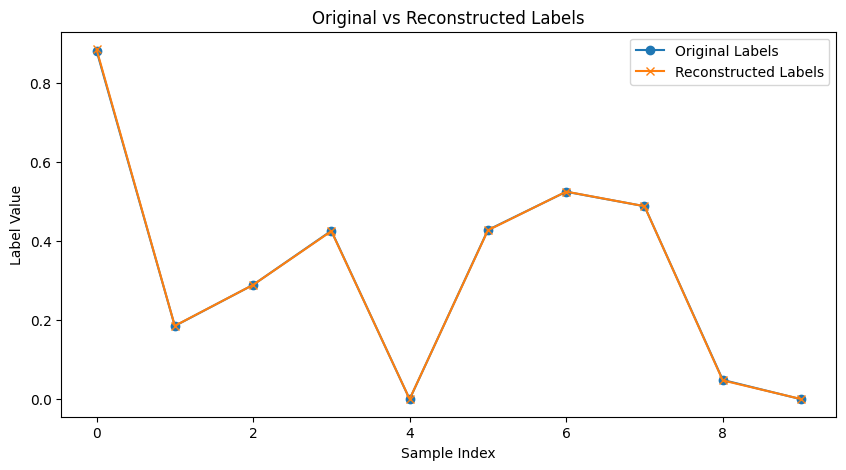

In [ ]:
# Get `indx_tmp`
indx_tmp = np.arange(len(unique_labels_norm))
np.random.shuffle(indx_tmp)
indx_tmp = indx_tmp[:10]

# Get `labels_tmp`
labels_tmp = unique_labels_norm[indx_tmp].reshape(-1, 1)
labels_tmp = torch.from_numpy(labels_tmp).type(torch.float).to(device)
epsilons_tmp = np.random.normal(0, 0.2, len(labels_tmp))
epsilons_tmp = torch.from_numpy(epsilons_tmp).view(-1, 1).type(torch.float).to(device)
labels_tmp = torch.clamp(labels_tmp + epsilons_tmp, 0.0, 1.0)

# Eval mode
net_embed.eval()
net_h2y = net_embed.module.h2y
net_y2h.eval()
with torch.no_grad():
    labels_rec_tmp = net_h2y(net_y2h(labels_tmp)).cpu().numpy().reshape(-1, 1)
results = np.concatenate((labels_tmp.cpu().numpy(), labels_rec_tmp), axis=1)

# Print results
results_df = pd.DataFrame(results, columns=["labels", "reconstructed_labels"])
print(results_df)

# Plot the results
plt.figure(figsize=(10, 5))
plt.plot(results_df["labels"], label="Original Labels", marker="o")
plt.plot(results_df["reconstructed_labels"], label="Reconstructed Labels", marker="x")
plt.title("Original vs Reconstructed Labels")
plt.xlabel("Sample Index")
plt.ylabel("Label Value")
plt.legend()
plt.show()

# Finish tests
net_embed = net_embed.cpu()
net_h2y = net_h2y.cpu()
del net_embed, net_h2y
gc.collect()
net_y2h = net_y2h.cpu()

## Step 6 - GAN Training

Some paths should be defined after $\sigma$ and $\kappa$ are calculated, so we do not define them in section two. 

In [26]:
# CcGAN Checkpoints' Dir
CCGAN_CKPT_DIR = os.path.join(
    CCGAN_MODELS_DIR,
    f"ckpt_CcGAN_{GAN_ARCH}_dim_{DIM_GAN}_{IMG_SIZE}_batchSizeG_{BATCH_SIZE_GENE}_batchSizeD_{BATCH_SIZE_DISC}_lrG_{LR_G:.0e}_lrD_{LR_D:.0e}_nDsteps_{NUM_D_STEPS}_{THRESHOLD_TYPE}_{KERNEL_SIGMA:.3f}_{KAPPA:.3f}_loss_{LOSS_TYPE_GAN}_seed_{SEED}",
)
if not os.path.exists(CCGAN_CKPT_DIR):
    os.makedirs(CCGAN_CKPT_DIR)

# CcGAN Path
CCGAN_PATH = os.path.join(
    CCGAN_MODELS_DIR,
    f"CcGAN_{GAN_ARCH}_dim_{DIM_GAN}_{IMG_SIZE}_batchSizeG_{BATCH_SIZE_GENE}_batchSizeD_{BATCH_SIZE_DISC}_lrG_{LR_G:.0e}_lrD_{LR_D:.0e}_nIters_{NITERS_GAN}_nDsteps_{NUM_D_STEPS}_{THRESHOLD_TYPE}_{KERNEL_SIGMA:.3f}_{KAPPA:.3f}_loss_{LOSS_TYPE_GAN}_seed_{SEED}.pth",
)

# Generated Images' Dir
IMAGES_IN_TRAIN_DIR = os.path.join(
    SAVE_IMAGES_DIR,
    f"CcGAN_{GAN_ARCH}_dim_{DIM_GAN}_{IMG_SIZE}_batchSizeG_{BATCH_SIZE_GENE}_batchSizeD_{BATCH_SIZE_DISC}_lrG_{LR_G:.0e}_lrD_{LR_D:.0e}_nDsteps_{NUM_D_STEPS}_{THRESHOLD_TYPE}_{KERNEL_SIGMA:.3f}_{KAPPA:.3f}_loss_{LOSS_TYPE_GAN}_seed_{SEED}_in_train",
)
if not os.path.exists(IMAGES_IN_TRAIN_DIR):
    os.makedirs(IMAGES_IN_TRAIN_DIR)

# Output File's Path
OUTPUT_PATH = os.path.join(
    SAVE_OUTPUTS_DIR,
    f"CcGAN_{GAN_ARCH}_dim_{DIM_GAN}_{IMG_SIZE}_batchSizeG_{BATCH_SIZE_GENE}_batchSizeD_{BATCH_SIZE_DISC}_lrG_{LR_G:.0e}_lrD_{LR_D:.0e}_nIters_{NITERS_GAN}_nDsteps_{NUM_D_STEPS}_{THRESHOLD_TYPE}_{KERNEL_SIGMA:.3f}_{KAPPA:.3f}_loss_{LOSS_TYPE_GAN}_seed_{SEED}_loss.csv",
)

Define `train_ccgan`. This is a long function.

In [ ]:
def train_ccgan(
    kernel_sigma,
    kappa,
    train_images,
    train_labels,
    netG,
    netD,
    net_y2h,
    images_in_train_dir,
    ccgan_models_dir=None,
    clip_label=False,
):

    # Define loss dataframe
    loss_df = pd.DataFrame(
        columns=["niter", "d_loss", "g_loss", "real_prob", "fake_prob"]
    )

    # Nets
    netG = netG.to(device)
    netD = netD.to(device)
    net_y2h = net_y2h.to(device)
    net_y2h.eval()

    # Optimizers
    optimizerG = torch.optim.Adam(netG.parameters(), lr=LR_G, betas=(0.5, 0.999))
    optimizerD = torch.optim.Adam(netD.parameters(), lr=LR_D, betas=(0.5, 0.999))

    # Resume training if needed
    if ccgan_models_dir is not None and RESUME_NITERS_GAN > 0:

        CCGAN_CKPT_PATH = os.path.join(CCGAN_CKPT_DIR, f"{RESUME_NITERS_GAN}.pth")

        checkpoint = torch.load(CCGAN_CKPT_PATH)
        netG.load_state_dict(checkpoint["netG_state_dict"])
        netD.load_state_dict(checkpoint["netD_state_dict"])
        optimizerG.load_state_dict(checkpoint["optimizerG_state_dict"])
        optimizerD.load_state_dict(checkpoint["optimizerD_state_dict"])
        torch.set_rng_state(checkpoint["rng_state"])
        print("Resuming training from {} iterations.".format(RESUME_NITERS_GAN))
    else:
        print("Training from scratch, no resume.")

    unique_train_labels = np.sort(np.array(list(set(train_labels))))

    # Output parameters
    n_row = 10
    n_col = 10

    z_fixed = torch.randn(n_row * n_col, DIM_GAN, dtype=torch.float).to(device)

    start_label = np.quantile(train_labels, 0.05)
    end_label = np.quantile(train_labels, 0.95)
    selected_labels = np.linspace(start_label, end_label, num=n_row)

    y_fixed = np.zeros(n_row * n_col)
    for i in range(n_row):
        curr_label = selected_labels[i]
        for j in range(n_col):
            y_fixed[i * n_col + j] = curr_label
    y_fixed = torch.from_numpy(y_fixed).type(torch.float).reshape(-1, 1).to(device)

    # Start timer
    start_time = timeit.default_timer()

    # Start training
    for niter in range(RESUME_NITERS_GAN, NITERS_GAN):

        # === Train Distriminator ===

        for _ in range(NUM_D_STEPS):

            ## randomly draw batch_size_disc y's from unique_train_labels
            batch_target_labels_in_dataset = np.random.choice(
                unique_train_labels, size=BATCH_SIZE_DISC, replace=True
            )
            ## add Gaussian noise; we estimate image distribution conditional on these labels
            batch_epsilons = np.random.normal(0, kernel_sigma, BATCH_SIZE_DISC)
            batch_target_labels = batch_target_labels_in_dataset + batch_epsilons

            ## find index of real images with labels in the vicinity of batch_target_labels
            ## generate labels for fake image generation; these labels are also in the vicinity of batch_target_labels
            batch_real_indx = np.zeros(
                BATCH_SIZE_DISC, dtype=int
            )  # index of images in the datata; the labels of these images are in the vicinity
            batch_fake_labels = np.zeros(BATCH_SIZE_DISC)

            for j in range(BATCH_SIZE_DISC):
                ## index for real images
                if THRESHOLD_TYPE == "hard":
                    indx_real_in_vicinity = np.where(
                        np.abs(train_labels - batch_target_labels[j]) <= kappa
                    )[0]
                else:
                    # reverse the weight function for SVDL
                    indx_real_in_vicinity = np.where(
                        (train_labels - batch_target_labels[j]) ** 2
                        <= -np.log(NONZERO_SOFT_WEIGHT_THRESHOLD) / kappa
                    )[0]

                ## if the max gap between two consecutive ordered unique labels is large, it is possible that len(indx_real_in_vicinity)<1
                while len(indx_real_in_vicinity) < 1:
                    batch_epsilons_j = np.random.normal(0, kernel_sigma, 1)
                    batch_target_labels[j] = (
                        batch_target_labels_in_dataset[j] + batch_epsilons_j
                    )
                    if clip_label:
                        batch_target_labels = np.clip(batch_target_labels, 0.0, 1.0)
                    ## index for real images
                    if THRESHOLD_TYPE == "hard":
                        indx_real_in_vicinity = np.where(
                            np.abs(train_labels - batch_target_labels[j]) <= kappa
                        )[0]
                    else:
                        # reverse the weight function for SVDL
                        indx_real_in_vicinity = np.where(
                            (train_labels - batch_target_labels[j]) ** 2
                            <= -np.log(NONZERO_SOFT_WEIGHT_THRESHOLD) / kappa
                        )[0]
                # end while len(indx_real_in_vicinity)<1

                assert len(indx_real_in_vicinity) >= 1

                batch_real_indx[j] = np.random.choice(indx_real_in_vicinity, size=1)[0]

                ## labels for fake images generation
                if THRESHOLD_TYPE == "hard":
                    lb = batch_target_labels[j] - kappa
                    ub = batch_target_labels[j] + kappa
                else:
                    lb = batch_target_labels[j] - np.sqrt(
                        -np.log(NONZERO_SOFT_WEIGHT_THRESHOLD) / kappa
                    )
                    ub = batch_target_labels[j] + np.sqrt(
                        -np.log(NONZERO_SOFT_WEIGHT_THRESHOLD) / kappa
                    )
                lb = max(0.0, lb)
                ub = min(ub, 1.0)
                assert lb <= ub
                assert lb >= 0 and ub >= 0
                assert lb <= 1 and ub <= 1
                batch_fake_labels[j] = np.random.uniform(lb, ub, size=1)[0]

            ## draw real image/label batch from the training set
            batch_real_images = torch.from_numpy(
                normalize_images(train_images[batch_real_indx])
            )
            batch_real_images = batch_real_images.type(torch.float).to(device)
            batch_real_labels = train_labels[batch_real_indx]
            batch_real_labels = (
                torch.from_numpy(batch_real_labels).type(torch.float).to(device)
            )

            ## generate the fake image batch
            batch_fake_labels = (
                torch.from_numpy(batch_fake_labels).type(torch.float).to(device)
            )
            z = torch.randn(BATCH_SIZE_DISC, DIM_GAN, dtype=torch.float).to(device)
            batch_fake_images = netG(z, net_y2h(batch_fake_labels))

            ## target labels on gpu
            batch_target_labels = (
                torch.from_numpy(batch_target_labels).type(torch.float).to(device)
            )

            ## weight vector
            if THRESHOLD_TYPE == "soft":
                real_weights = torch.exp(
                    -kappa * (batch_real_labels - batch_target_labels) ** 2
                ).to(device)
                fake_weights = torch.exp(
                    -kappa * (batch_fake_labels - batch_target_labels) ** 2
                ).to(device)
            else:
                real_weights = torch.ones(BATCH_SIZE_DISC, dtype=torch.float).to(device)
                fake_weights = torch.ones(BATCH_SIZE_DISC, dtype=torch.float).to(device)
            # end if threshold type

            # forward pass
            if GAN_DIFFAUGMENT:
                real_dis_out = netD(
                    DiffAugment(batch_real_images, policy=GAN_DIFFAUGMENT_POLICY),
                    net_y2h(batch_target_labels),
                )
                fake_dis_out = netD(
                    DiffAugment(
                        batch_fake_images.detach(), policy=GAN_DIFFAUGMENT_POLICY
                    ),
                    net_y2h(batch_target_labels),
                )
            else:
                real_dis_out = netD(batch_real_images, net_y2h(batch_target_labels))
                fake_dis_out = netD(
                    batch_fake_images.detach(), net_y2h(batch_target_labels)
                )

            if LOSS_TYPE_GAN == "vanilla":
                real_dis_out = torch.nn.Sigmoid()(real_dis_out)
                fake_dis_out = torch.nn.Sigmoid()(fake_dis_out)
                d_loss_real = -torch.log(real_dis_out + 1e-20)
                d_loss_fake = -torch.log(1 - fake_dis_out + 1e-20)
            elif LOSS_TYPE_GAN == "hinge":
                d_loss_real = torch.nn.ReLU()(1.0 - real_dis_out)
                d_loss_fake = torch.nn.ReLU()(1.0 + fake_dis_out)
            else:
                raise ValueError("Not supported loss type!!!")

            d_loss = torch.mean(
                real_weights.reshape(-1) * d_loss_real.reshape(-1)
            ) + torch.mean(fake_weights.reshape(-1) * d_loss_fake.reshape(-1))

            optimizerD.zero_grad()
            d_loss.backward()
            optimizerD.step()

        # === Train Generator ===

        netG.train()

        # Choose target labels for fake images
        batch_target_labels_in_dataset = np.random.choice(
            unique_train_labels, size=BATCH_SIZE_GENE, replace=True
        )

        # Add Gaussian noise
        batch_epsilons = np.random.normal(0, kernel_sigma, BATCH_SIZE_GENE)
        batch_target_labels = batch_target_labels_in_dataset + batch_epsilons
        batch_target_labels = (
            torch.from_numpy(batch_target_labels).type(torch.float).to(device)
        )

        # Add random noise
        z = torch.randn(BATCH_SIZE_GENE, DIM_GAN, dtype=torch.float).to(device)

        # Generate fake images
        batch_fake_images = netG(z, net_y2h(batch_target_labels))

        # Calculate the generator loss
        if GAN_DIFFAUGMENT:
            dis_out = netD(
                DiffAugment(batch_fake_images, policy=GAN_DIFFAUGMENT_POLICY),
                net_y2h(batch_target_labels),
            )
        else:
            dis_out = netD(batch_fake_images, net_y2h(batch_target_labels))
        if LOSS_TYPE_GAN == "vanilla":
            dis_out = torch.nn.Sigmoid()(dis_out)
            g_loss = -torch.mean(torch.log(dis_out + 1e-20))
        elif LOSS_TYPE_GAN == "hinge":
            g_loss = -dis_out.mean()

        # Backward pass
        optimizerG.zero_grad()
        g_loss.backward()
        optimizerG.step()

        # === Logging ===

        # Every 20 iterations, print the loss
        if (niter + 1) % 20 == 0:
            new_row = pd.DataFrame(
                [
                    {
                        "niter": niter + 1,
                        "d_loss": d_loss.item(),
                        "g_loss": g_loss.item(),
                        "real_prob": real_dis_out.mean().item(),
                        "fake_prob": fake_dis_out.mean().item(),
                    }
                ]
            )

            loss_df = pd.concat([loss_df, new_row], ignore_index=True)

            print(
                "CcGAN,%s: [Iter %d/%d] [D loss: %.4e] [G loss: %.4e] [real prob: %.3f] [fake prob: %.3f] [Time: %.4f]"
                % (
                    GAN_ARCH,
                    niter + 1,
                    NITERS_GAN,
                    d_loss.item(),
                    g_loss.item(),
                    real_dis_out.mean().item(),
                    fake_dis_out.mean().item(),
                    timeit.default_timer() - start_time,
                )
            )

        # Every `VISUALIZE_FREQ` iterations, visualize the generated images
        if (niter + 1) % VISUALIZE_FREQ == 0:
            netG.eval()
            with torch.no_grad():
                gen_imgs = netG(z_fixed, net_y2h(y_fixed))
                gen_imgs = gen_imgs.detach().cpu()
                save_image(
                    gen_imgs.data,
                    os.path.join(images_in_train_dir, "{}.png".format(niter + 1)),
                    nrow=n_row,
                    normalize=True,
                )

        # Every `SAVE_NITERS_FREQ` iterations, save the model
        if ccgan_models_dir is not None and (
            (niter + 1) % SAVE_NITERS_FREQ == 0 or (niter + 1) == NITERS_GAN
        ):
            CCGAN_CKPT_PATH = os.path.join(CCGAN_CKPT_DIR, f"{niter + 1}.pth")
            torch.save(
                {
                    "netG_state_dict": netG.state_dict(),
                    "netD_state_dict": netD.state_dict(),
                    "optimizerG_state_dict": optimizerG.state_dict(),
                    "optimizerD_state_dict": optimizerD.state_dict(),
                    "rng_state": torch.get_rng_state(),
                },
                CCGAN_CKPT_PATH,
            )

    # Save the training loss dataframe
    loss_df.to_csv(OUTPUT_PATH, index=False)

    # Return the trained networks
    return netG, netD

Output some basic info.

In [28]:
print("CcGAN: {}, {}, Sigma is {}, Kappa is {}.".format(GAN_ARCH, THRESHOLD_TYPE, KERNEL_SIGMA, KAPPA))

CcGAN: SAGAN, soft, Sigma is 0.04697700151079382, Kappa is 108.73916897823854.


Start the timer.

In [29]:
start = timeit.default_timer()
print("Begin Training: %s" % GAN)

Begin Training: CcGAN


The following code is used for training CcGAN.

In [ ]:
if not os.path.isfile(CCGAN_PATH):
    netG = CcGAN_SAGAN_Generator(dim_z=DIM_GAN, dim_embed=DIM_EMBED)
    netD = CcGAN_SAGAN_Discriminator(dim_embed=DIM_EMBED)
    netG = nn.DataParallel(netG)
    netD = nn.DataParallel(netD)

    # Start training
    netG, netD = train_ccgan(
        KERNEL_SIGMA,
        KAPPA,
        images_train,
        labels_train,
        netG,
        netD,
        net_y2h,
        images_in_train_dir=IMAGES_IN_TRAIN_DIR,
        ccgan_models_dir=CCGAN_MODELS_DIR,
    )

    # Store model
    torch.save(
        {
            "netG_state_dict": netG.state_dict(),
        },
        CCGAN_PATH,
    )

else:
    print("Loading pre-trained generator.")
    checkpoint = torch.load(CCGAN_PATH)
    netG = CcGAN_SAGAN_Generator(dim_z=DIM_GAN, dim_embed=DIM_EMBED).to(device)
    netG = nn.DataParallel(netG)
    netG.load_state_dict(checkpoint["netG_state_dict"])

Training from scratch, no resume.


/opt/pytorch/lib/python3.12/site-packages/torch/functional.py:554: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /pytorch/aten/src/ATen/native/TensorShape.cpp:4314.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]


/tmp/ipykernel_4914/1235035165.py:273: FutureWarning: The behavior of DataFrame concatenation with empty or all-NA entries is deprecated. In a future version, this will no longer exclude empty or all-NA columns when determining the result dtypes. To retain the old behavior, exclude the relevant entries before the concat operation.
  loss_df = pd.concat([loss_df, new_row], ignore_index=True)


CcGAN,SAGAN: [Iter 20/30000] [D loss: 3.1148e-01] [G loss: 4.5069e+00] [real prob: 0.984] [fake prob: -6.381] [Time: 36.0193]


CcGAN,SAGAN: [Iter 40/30000] [D loss: 3.4030e-01] [G loss: 3.9965e+00] [real prob: 1.030] [fake prob: -4.258] [Time: 71.7176]


CcGAN,SAGAN: [Iter 60/30000] [D loss: 1.7239e-01] [G loss: 3.3773e+00] [real prob: 2.009] [fake prob: -1.688] [Time: 107.4202]


CcGAN,SAGAN: [Iter 80/30000] [D loss: 4.8863e-01] [G loss: 6.3826e-01] [real prob: 0.187] [fake prob: -0.929] [Time: 143.1294]


CcGAN,SAGAN: [Iter 100/30000] [D loss: 2.4318e-01] [G loss: 7.7322e-01] [real prob: 0.775] [fake prob: -1.176] [Time: 178.8538]


CcGAN,SAGAN: [Iter 120/30000] [D loss: 4.0354e-01] [G loss: 1.4131e+00] [real prob: 0.991] [fake prob: -0.756] [Time: 214.5633]


CcGAN,SAGAN: [Iter 140/30000] [D loss: 7.5258e-01] [G loss: 1.7822e+00] [real prob: 2.127] [fake prob: 0.524] [Time: 250.2496]


CcGAN,SAGAN: [Iter 160/30000] [D loss: 6.9014e-01] [G loss: 2.0862e-01] [real prob: 0.168] [fake prob: -0.008] [Time: 285.9368]


CcGAN,SAGAN: [Iter 180/30000] [D loss: 6.9723e-01] [G loss: 1.3040e-01] [real prob: -0.228] [fake prob: -1.188] [Time: 321.6186]


CcGAN,SAGAN: [Iter 200/30000] [D loss: 3.2245e-01] [G loss: 9.6075e-01] [real prob: 0.573] [fake prob: -0.661] [Time: 357.3081]


CcGAN,SAGAN: [Iter 220/30000] [D loss: 5.2245e-01] [G loss: 1.3549e-01] [real prob: 0.212] [fake prob: -0.297] [Time: 393.0209]


CcGAN,SAGAN: [Iter 240/30000] [D loss: 3.5748e-01] [G loss: 1.8450e+00] [real prob: 1.253] [fake prob: -0.151] [Time: 428.7300]


CcGAN,SAGAN: [Iter 260/30000] [D loss: 5.8941e-01] [G loss: 7.0413e-01] [real prob: 0.952] [fake prob: 0.225] [Time: 464.4368]


CcGAN,SAGAN: [Iter 280/30000] [D loss: 6.4699e-01] [G loss: -3.8360e-01] [real prob: 0.734] [fake prob: 0.506] [Time: 500.1459]


CcGAN,SAGAN: [Iter 300/30000] [D loss: 4.1355e-01] [G loss: -3.7740e-01] [real prob: 0.529] [fake prob: -0.733] [Time: 535.8616]


CcGAN,SAGAN: [Iter 320/30000] [D loss: 3.5226e-01] [G loss: 1.2278e+00] [real prob: 0.118] [fake prob: -1.037] [Time: 571.5823]


CcGAN,SAGAN: [Iter 340/30000] [D loss: 3.7113e-01] [G loss: 6.8370e-01] [real prob: 0.607] [fake prob: -1.525] [Time: 607.2802]


CcGAN,SAGAN: [Iter 360/30000] [D loss: 2.8469e-01] [G loss: 5.8378e-01] [real prob: 0.807] [fake prob: -0.802] [Time: 642.9972]


CcGAN,SAGAN: [Iter 380/30000] [D loss: 4.2356e-01] [G loss: -5.2529e-01] [real prob: 0.138] [fake prob: -1.695] [Time: 678.7168]


CcGAN,SAGAN: [Iter 400/30000] [D loss: 8.0043e-01] [G loss: 1.4833e+00] [real prob: -0.959] [fake prob: -2.116] [Time: 714.4294]


CcGAN,SAGAN: [Iter 420/30000] [D loss: 2.6243e-01] [G loss: 7.6969e-01] [real prob: 0.473] [fake prob: -1.519] [Time: 750.1385]


CcGAN,SAGAN: [Iter 440/30000] [D loss: 5.6682e-01] [G loss: -4.7274e-01] [real prob: -0.163] [fake prob: -0.938] [Time: 785.8479]


CcGAN,SAGAN: [Iter 460/30000] [D loss: 3.8999e-01] [G loss: 5.4657e-01] [real prob: 0.485] [fake prob: -0.732] [Time: 821.5521]


CcGAN,SAGAN: [Iter 480/30000] [D loss: 6.3613e-01] [G loss: 3.8259e-01] [real prob: 0.530] [fake prob: -0.059] [Time: 857.2551]


CcGAN,SAGAN: [Iter 500/30000] [D loss: 6.2336e-01] [G loss: 5.6392e-01] [real prob: -0.450] [fake prob: -1.120] [Time: 892.9786]


CcGAN,SAGAN: [Iter 520/30000] [D loss: 4.3798e-01] [G loss: 1.4796e+00] [real prob: 0.492] [fake prob: -0.587] [Time: 928.6908]


CcGAN,SAGAN: [Iter 540/30000] [D loss: 5.7170e-01] [G loss: 4.0994e-01] [real prob: 1.023] [fake prob: 0.188] [Time: 964.4005]


CcGAN,SAGAN: [Iter 560/30000] [D loss: 5.1139e-01] [G loss: 2.5561e-01] [real prob: 0.543] [fake prob: -0.503] [Time: 1000.1194]


CcGAN,SAGAN: [Iter 580/30000] [D loss: 4.7551e-01] [G loss: 2.9392e-01] [real prob: 0.659] [fake prob: -0.435] [Time: 1035.8428]


CcGAN,SAGAN: [Iter 600/30000] [D loss: 6.5825e-01] [G loss: 6.6685e-01] [real prob: -0.409] [fake prob: -0.914] [Time: 1071.5621]


CcGAN,SAGAN: [Iter 620/30000] [D loss: 5.3998e-01] [G loss: 4.7741e-01] [real prob: 0.590] [fake prob: -0.547] [Time: 1107.2739]


CcGAN,SAGAN: [Iter 640/30000] [D loss: 6.1870e-01] [G loss: -2.2376e-01] [real prob: 0.653] [fake prob: 0.488] [Time: 1143.0027]


CcGAN,SAGAN: [Iter 660/30000] [D loss: 5.1247e-01] [G loss: 1.0742e+00] [real prob: 0.506] [fake prob: -0.563] [Time: 1178.7274]


CcGAN,SAGAN: [Iter 680/30000] [D loss: 5.0491e-01] [G loss: 3.5550e-01] [real prob: -0.091] [fake prob: -0.642] [Time: 1214.4365]


CcGAN,SAGAN: [Iter 700/30000] [D loss: 6.7535e-01] [G loss: 3.3354e-01] [real prob: 0.046] [fake prob: -0.469] [Time: 1250.1420]


CcGAN,SAGAN: [Iter 720/30000] [D loss: 5.7316e-01] [G loss: 6.6616e-01] [real prob: 0.120] [fake prob: -0.368] [Time: 1285.8610]


CcGAN,SAGAN: [Iter 740/30000] [D loss: 5.3799e-01] [G loss: 8.2095e-01] [real prob: -0.090] [fake prob: -0.666] [Time: 1321.5738]


CcGAN,SAGAN: [Iter 760/30000] [D loss: 6.9552e-01] [G loss: 3.6436e-01] [real prob: -0.464] [fake prob: -0.747] [Time: 1357.3040]


CcGAN,SAGAN: [Iter 780/30000] [D loss: 7.1513e-01] [G loss: 7.2678e-01] [real prob: -0.467] [fake prob: -0.813] [Time: 1393.0268]


CcGAN,SAGAN: [Iter 800/30000] [D loss: 8.5346e-01] [G loss: -3.4418e-01] [real prob: 0.330] [fake prob: 0.368] [Time: 1428.7437]


CcGAN,SAGAN: [Iter 820/30000] [D loss: 6.7361e-01] [G loss: -2.8140e-02] [real prob: 0.684] [fake prob: 0.355] [Time: 1464.4441]


CcGAN,SAGAN: [Iter 840/30000] [D loss: 5.4505e-01] [G loss: 1.9177e-01] [real prob: 0.391] [fake prob: -0.167] [Time: 1500.1526]


CcGAN,SAGAN: [Iter 860/30000] [D loss: 7.9352e-01] [G loss: 1.0308e-01] [real prob: 0.372] [fake prob: 0.082] [Time: 1535.8703]


CcGAN,SAGAN: [Iter 880/30000] [D loss: 6.7142e-01] [G loss: 2.5737e-01] [real prob: 0.519] [fake prob: 0.242] [Time: 1571.5777]


CcGAN,SAGAN: [Iter 900/30000] [D loss: 7.1385e-01] [G loss: -6.0850e-02] [real prob: 0.082] [fake prob: -0.161] [Time: 1607.2814]


CcGAN,SAGAN: [Iter 920/30000] [D loss: 5.8646e-01] [G loss: 6.9746e-01] [real prob: 0.159] [fake prob: -0.359] [Time: 1642.9979]


CcGAN,SAGAN: [Iter 940/30000] [D loss: 5.2131e-01] [G loss: 6.0428e-02] [real prob: 0.193] [fake prob: -0.634] [Time: 1678.7170]


CcGAN,SAGAN: [Iter 960/30000] [D loss: 6.1809e-01] [G loss: 3.9198e-01] [real prob: 0.024] [fake prob: -0.307] [Time: 1714.4304]


CcGAN,SAGAN: [Iter 980/30000] [D loss: 3.3508e-01] [G loss: 4.9998e-01] [real prob: 0.665] [fake prob: -0.369] [Time: 1750.1499]


CcGAN,SAGAN: [Iter 1000/30000] [D loss: 8.2124e-01] [G loss: 1.3747e-01] [real prob: 0.468] [fake prob: 0.315] [Time: 1785.8704]


CcGAN,SAGAN: [Iter 1020/30000] [D loss: 4.8032e-01] [G loss: 5.4662e-01] [real prob: 0.126] [fake prob: -0.552] [Time: 1822.2183]


CcGAN,SAGAN: [Iter 1040/30000] [D loss: 5.8537e-01] [G loss: 4.1453e-01] [real prob: 0.169] [fake prob: 0.027] [Time: 1857.9075]


CcGAN,SAGAN: [Iter 1060/30000] [D loss: 5.5391e-01] [G loss: 1.7943e-01] [real prob: 0.339] [fake prob: -0.171] [Time: 1893.6018]


CcGAN,SAGAN: [Iter 1080/30000] [D loss: 5.2256e-01] [G loss: -3.4170e-01] [real prob: 0.429] [fake prob: 0.054] [Time: 1929.2994]


CcGAN,SAGAN: [Iter 1100/30000] [D loss: 6.4210e-01] [G loss: 4.0142e-01] [real prob: -0.038] [fake prob: -0.596] [Time: 1964.9897]


CcGAN,SAGAN: [Iter 1120/30000] [D loss: 5.4273e-01] [G loss: 1.8624e-01] [real prob: 0.188] [fake prob: -0.387] [Time: 2000.6818]


CcGAN,SAGAN: [Iter 1140/30000] [D loss: 5.5771e-01] [G loss: 1.2918e-02] [real prob: 0.404] [fake prob: 0.011] [Time: 2036.3701]


CcGAN,SAGAN: [Iter 1160/30000] [D loss: 5.9151e-01] [G loss: -8.8981e-02] [real prob: 0.181] [fake prob: 0.008] [Time: 2072.0661]


CcGAN,SAGAN: [Iter 1180/30000] [D loss: 6.9123e-01] [G loss: -1.9244e-01] [real prob: 0.141] [fake prob: -0.025] [Time: 2107.7653]


CcGAN,SAGAN: [Iter 1200/30000] [D loss: 4.5783e-01] [G loss: 4.5834e-01] [real prob: 0.439] [fake prob: -0.347] [Time: 2143.4577]


CcGAN,SAGAN: [Iter 1220/30000] [D loss: 5.3902e-01] [G loss: -6.4944e-02] [real prob: 0.400] [fake prob: 0.118] [Time: 2179.1541]


CcGAN,SAGAN: [Iter 1240/30000] [D loss: 6.5621e-01] [G loss: 3.5130e-01] [real prob: 0.205] [fake prob: -0.353] [Time: 2214.8522]


CcGAN,SAGAN: [Iter 1260/30000] [D loss: 5.0691e-01] [G loss: 3.5678e-01] [real prob: 0.374] [fake prob: -0.296] [Time: 2250.5533]


CcGAN,SAGAN: [Iter 1280/30000] [D loss: 5.9380e-01] [G loss: 2.3314e-01] [real prob: 0.357] [fake prob: -0.194] [Time: 2286.2465]


CcGAN,SAGAN: [Iter 1300/30000] [D loss: 5.8302e-01] [G loss: 1.4627e-01] [real prob: 0.547] [fake prob: -0.007] [Time: 2321.9456]


CcGAN,SAGAN: [Iter 1320/30000] [D loss: 7.8591e-01] [G loss: -2.4458e-01] [real prob: 0.736] [fake prob: 0.644] [Time: 2357.6428]


CcGAN,SAGAN: [Iter 1340/30000] [D loss: 5.1406e-01] [G loss: -2.5748e-01] [real prob: 0.134] [fake prob: -0.385] [Time: 2393.3322]


CcGAN,SAGAN: [Iter 1360/30000] [D loss: 4.3450e-01] [G loss: 4.0107e-02] [real prob: 0.830] [fake prob: 0.059] [Time: 2429.0270]


CcGAN,SAGAN: [Iter 1380/30000] [D loss: 7.2862e-01] [G loss: 2.5872e-01] [real prob: 0.207] [fake prob: -0.172] [Time: 2464.7034]


CcGAN,SAGAN: [Iter 1400/30000] [D loss: 7.0109e-01] [G loss: -4.2057e-01] [real prob: 0.636] [fake prob: 0.301] [Time: 2500.3748]


CcGAN,SAGAN: [Iter 1420/30000] [D loss: 6.3989e-01] [G loss: -4.9583e-02] [real prob: 0.690] [fake prob: 0.165] [Time: 2536.0469]


CcGAN,SAGAN: [Iter 1440/30000] [D loss: 5.3817e-01] [G loss: 2.3461e-01] [real prob: 0.537] [fake prob: -0.115] [Time: 2571.7209]


CcGAN,SAGAN: [Iter 1460/30000] [D loss: 3.9588e-01] [G loss: 8.8677e-01] [real prob: 0.648] [fake prob: -0.132] [Time: 2607.3847]


CcGAN,SAGAN: [Iter 1480/30000] [D loss: 6.1121e-01] [G loss: 2.6894e-02] [real prob: 0.411] [fake prob: -0.025] [Time: 2643.0555]


CcGAN,SAGAN: [Iter 1500/30000] [D loss: 6.2076e-01] [G loss: -2.2100e-01] [real prob: 0.670] [fake prob: 0.206] [Time: 2678.7281]


CcGAN,SAGAN: [Iter 1520/30000] [D loss: 6.3602e-01] [G loss: -3.2456e-02] [real prob: 0.342] [fake prob: 0.147] [Time: 2714.3913]


CcGAN,SAGAN: [Iter 1540/30000] [D loss: 6.2085e-01] [G loss: 2.1134e-01] [real prob: 0.195] [fake prob: -0.288] [Time: 2750.0604]


CcGAN,SAGAN: [Iter 1560/30000] [D loss: 6.2861e-01] [G loss: 5.2980e-01] [real prob: -0.004] [fake prob: -0.551] [Time: 2785.7277]


CcGAN,SAGAN: [Iter 1580/30000] [D loss: 6.8200e-01] [G loss: 9.6899e-02] [real prob: 0.043] [fake prob: -0.556] [Time: 2821.3923]


CcGAN,SAGAN: [Iter 1600/30000] [D loss: 6.4987e-01] [G loss: 7.6237e-01] [real prob: 0.647] [fake prob: 0.260] [Time: 2857.0649]


CcGAN,SAGAN: [Iter 1620/30000] [D loss: 7.0129e-01] [G loss: 7.5114e-01] [real prob: 0.865] [fake prob: -0.099] [Time: 2892.7360]


CcGAN,SAGAN: [Iter 1640/30000] [D loss: 6.7398e-01] [G loss: -5.4432e-01] [real prob: 0.305] [fake prob: -0.035] [Time: 2928.4056]


CcGAN,SAGAN: [Iter 1660/30000] [D loss: 6.6350e-01] [G loss: 6.2961e-01] [real prob: 0.458] [fake prob: 0.183] [Time: 2964.0838]


CcGAN,SAGAN: [Iter 1680/30000] [D loss: 5.6018e-01] [G loss: 3.2926e-01] [real prob: 0.014] [fake prob: -0.452] [Time: 2999.7548]


CcGAN,SAGAN: [Iter 1700/30000] [D loss: 6.3876e-01] [G loss: 3.7290e-01] [real prob: 0.316] [fake prob: -0.114] [Time: 3035.4177]


CcGAN,SAGAN: [Iter 1720/30000] [D loss: 4.4649e-01] [G loss: 2.2673e-01] [real prob: 0.528] [fake prob: -0.290] [Time: 3071.0924]


CcGAN,SAGAN: [Iter 1740/30000] [D loss: 7.6245e-01] [G loss: 1.0558e-01] [real prob: 0.457] [fake prob: 0.363] [Time: 3106.7679]


CcGAN,SAGAN: [Iter 1760/30000] [D loss: 6.3521e-01] [G loss: -4.0508e-01] [real prob: 0.494] [fake prob: 0.161] [Time: 3142.4394]


CcGAN,SAGAN: [Iter 1780/30000] [D loss: 5.9753e-01] [G loss: -9.1831e-03] [real prob: 0.694] [fake prob: 0.225] [Time: 3178.1052]


CcGAN,SAGAN: [Iter 1800/30000] [D loss: 6.5372e-01] [G loss: 2.0516e-01] [real prob: 0.835] [fake prob: 0.338] [Time: 3213.7824]


CcGAN,SAGAN: [Iter 1820/30000] [D loss: 5.8092e-01] [G loss: -1.3289e-01] [real prob: 0.471] [fake prob: -0.034] [Time: 3249.4438]


CcGAN,SAGAN: [Iter 1840/30000] [D loss: 5.8740e-01] [G loss: 1.3786e-01] [real prob: 0.151] [fake prob: -0.632] [Time: 3285.1118]


CcGAN,SAGAN: [Iter 1860/30000] [D loss: 5.8621e-01] [G loss: 3.0918e-02] [real prob: 0.730] [fake prob: 0.207] [Time: 3320.7874]


CcGAN,SAGAN: [Iter 1880/30000] [D loss: 5.5273e-01] [G loss: 4.3138e-01] [real prob: 0.255] [fake prob: -0.386] [Time: 3356.4628]


CcGAN,SAGAN: [Iter 1900/30000] [D loss: 4.5921e-01] [G loss: 3.7760e-01] [real prob: 0.335] [fake prob: -0.333] [Time: 3392.1400]


CcGAN,SAGAN: [Iter 1920/30000] [D loss: 6.7149e-01] [G loss: 4.7960e-01] [real prob: 0.472] [fake prob: 0.133] [Time: 3427.8031]


CcGAN,SAGAN: [Iter 1940/30000] [D loss: 6.9201e-01] [G loss: 3.9961e-01] [real prob: -0.235] [fake prob: -0.595] [Time: 3463.4734]


CcGAN,SAGAN: [Iter 1960/30000] [D loss: 4.2662e-01] [G loss: 3.2899e-01] [real prob: 0.490] [fake prob: -0.355] [Time: 3499.1327]


CcGAN,SAGAN: [Iter 1980/30000] [D loss: 5.9140e-01] [G loss: 2.8167e-01] [real prob: 0.215] [fake prob: -0.331] [Time: 3534.8018]


CcGAN,SAGAN: [Iter 2000/30000] [D loss: 4.7567e-01] [G loss: 5.7082e-01] [real prob: 0.461] [fake prob: -0.118] [Time: 3570.4683]


CcGAN,SAGAN: [Iter 2020/30000] [D loss: 8.4475e-01] [G loss: 6.2483e-01] [real prob: 0.197] [fake prob: -0.146] [Time: 3606.7981]


CcGAN,SAGAN: [Iter 2040/30000] [D loss: 5.4311e-01] [G loss: 5.5701e-01] [real prob: 0.296] [fake prob: -0.443] [Time: 3642.4629]


CcGAN,SAGAN: [Iter 2060/30000] [D loss: 7.4039e-01] [G loss: -1.5022e-01] [real prob: 0.733] [fake prob: 0.508] [Time: 3678.1514]


CcGAN,SAGAN: [Iter 2080/30000] [D loss: 6.1603e-01] [G loss: 1.5009e-01] [real prob: 0.231] [fake prob: 0.014] [Time: 3713.8383]


CcGAN,SAGAN: [Iter 2100/30000] [D loss: 7.8481e-01] [G loss: 5.8168e-01] [real prob: 0.258] [fake prob: -0.116] [Time: 3749.5282]


CcGAN,SAGAN: [Iter 2120/30000] [D loss: 6.4716e-01] [G loss: 2.5600e-01] [real prob: 0.477] [fake prob: 0.144] [Time: 3785.2058]


CcGAN,SAGAN: [Iter 2140/30000] [D loss: 7.3303e-01] [G loss: -3.0980e-01] [real prob: 0.652] [fake prob: 0.440] [Time: 3820.8975]


CcGAN,SAGAN: [Iter 2160/30000] [D loss: 6.8454e-01] [G loss: 7.9477e-01] [real prob: 0.379] [fake prob: -0.027] [Time: 3856.5822]


CcGAN,SAGAN: [Iter 2180/30000] [D loss: 3.9376e-01] [G loss: 9.3627e-02] [real prob: 0.813] [fake prob: 0.010] [Time: 3892.2707]


CcGAN,SAGAN: [Iter 2200/30000] [D loss: 7.2596e-01] [G loss: -4.9918e-01] [real prob: 0.781] [fake prob: 0.634] [Time: 3927.9644]


CcGAN,SAGAN: [Iter 2220/30000] [D loss: 4.7819e-01] [G loss: 6.7407e-01] [real prob: 0.563] [fake prob: 0.015] [Time: 3963.6407]


CcGAN,SAGAN: [Iter 2240/30000] [D loss: 6.5174e-01] [G loss: -1.8903e-01] [real prob: 0.725] [fake prob: 0.302] [Time: 3999.3351]


CcGAN,SAGAN: [Iter 2260/30000] [D loss: 4.8475e-01] [G loss: 9.6165e-01] [real prob: -0.317] [fake prob: -0.790] [Time: 4035.0209]


CcGAN,SAGAN: [Iter 2280/30000] [D loss: 5.0859e-01] [G loss: 3.7897e-01] [real prob: 0.607] [fake prob: -0.056] [Time: 4070.7133]


CcGAN,SAGAN: [Iter 2300/30000] [D loss: 5.6401e-01] [G loss: -6.1748e-02] [real prob: 0.180] [fake prob: -0.453] [Time: 4106.3975]


CcGAN,SAGAN: [Iter 2320/30000] [D loss: 6.0652e-01] [G loss: -1.1639e-02] [real prob: 0.686] [fake prob: 0.240] [Time: 4142.0823]


CcGAN,SAGAN: [Iter 2340/30000] [D loss: 6.5063e-01] [G loss: -1.3973e-01] [real prob: 0.485] [fake prob: 0.155] [Time: 4177.7718]


CcGAN,SAGAN: [Iter 2360/30000] [D loss: 5.8096e-01] [G loss: 2.5167e-02] [real prob: 0.525] [fake prob: 0.087] [Time: 4213.4557]


CcGAN,SAGAN: [Iter 2380/30000] [D loss: 5.4173e-01] [G loss: 1.4502e-01] [real prob: 0.474] [fake prob: -0.043] [Time: 4249.1386]


CcGAN,SAGAN: [Iter 2400/30000] [D loss: 5.6039e-01] [G loss: -1.4794e-01] [real prob: 0.698] [fake prob: 0.322] [Time: 4284.8246]


CcGAN,SAGAN: [Iter 2420/30000] [D loss: 6.1548e-01] [G loss: 6.1575e-01] [real prob: 0.844] [fake prob: 0.149] [Time: 4320.5100]


CcGAN,SAGAN: [Iter 2440/30000] [D loss: 5.3349e-01] [G loss: 6.5723e-01] [real prob: 0.801] [fake prob: -0.189] [Time: 4356.1989]


CcGAN,SAGAN: [Iter 2460/30000] [D loss: 5.9852e-01] [G loss: 7.7119e-01] [real prob: 0.732] [fake prob: 0.131] [Time: 4391.8832]


CcGAN,SAGAN: [Iter 2480/30000] [D loss: 6.4290e-01] [G loss: -1.9807e-01] [real prob: 0.626] [fake prob: 0.264] [Time: 4427.5702]


CcGAN,SAGAN: [Iter 2500/30000] [D loss: 5.6224e-01] [G loss: 5.7346e-02] [real prob: 0.671] [fake prob: -0.032] [Time: 4463.2595]


CcGAN,SAGAN: [Iter 2520/30000] [D loss: 5.0569e-01] [G loss: 1.2710e-01] [real prob: 0.599] [fake prob: 0.095] [Time: 4498.9526]


CcGAN,SAGAN: [Iter 2540/30000] [D loss: 4.4856e-01] [G loss: 1.2350e+00] [real prob: 0.366] [fake prob: -0.293] [Time: 4534.6304]


CcGAN,SAGAN: [Iter 2560/30000] [D loss: 6.0319e-01] [G loss: 6.9586e-01] [real prob: 0.323] [fake prob: -0.365] [Time: 4570.3207]


CcGAN,SAGAN: [Iter 2580/30000] [D loss: 5.8260e-01] [G loss: 3.6121e-01] [real prob: -0.135] [fake prob: -0.718] [Time: 4606.0138]


CcGAN,SAGAN: [Iter 2600/30000] [D loss: 6.9415e-01] [G loss: -4.5778e-01] [real prob: 0.800] [fake prob: 0.534] [Time: 4641.6982]


CcGAN,SAGAN: [Iter 2620/30000] [D loss: 8.9283e-01] [G loss: -1.3083e-01] [real prob: 0.409] [fake prob: 0.408] [Time: 4677.3931]


CcGAN,SAGAN: [Iter 2640/30000] [D loss: 5.3407e-01] [G loss: -1.8848e-01] [real prob: 0.499] [fake prob: 0.247] [Time: 4713.0842]


CcGAN,SAGAN: [Iter 2660/30000] [D loss: 5.3352e-01] [G loss: 7.6257e-02] [real prob: 0.129] [fake prob: -0.327] [Time: 4748.7838]


CcGAN,SAGAN: [Iter 2680/30000] [D loss: 5.0868e-01] [G loss: 5.0529e-01] [real prob: -0.023] [fake prob: -0.285] [Time: 4784.4709]


CcGAN,SAGAN: [Iter 2700/30000] [D loss: 4.6614e-01] [G loss: 8.3846e-01] [real prob: 0.821] [fake prob: -0.288] [Time: 4820.1568]


CcGAN,SAGAN: [Iter 2720/30000] [D loss: 6.7497e-01] [G loss: 5.4046e-01] [real prob: 0.207] [fake prob: -0.151] [Time: 4855.8433]


CcGAN,SAGAN: [Iter 2740/30000] [D loss: 7.2953e-01] [G loss: -8.9699e-02] [real prob: 0.459] [fake prob: 0.091] [Time: 4891.5256]


CcGAN,SAGAN: [Iter 2760/30000] [D loss: 5.5869e-01] [G loss: 4.3244e-01] [real prob: 0.208] [fake prob: -0.627] [Time: 4927.2071]


CcGAN,SAGAN: [Iter 2780/30000] [D loss: 5.8821e-01] [G loss: 7.8453e-02] [real prob: 0.388] [fake prob: -0.115] [Time: 4962.9046]


CcGAN,SAGAN: [Iter 2800/30000] [D loss: 5.6512e-01] [G loss: -1.8909e-01] [real prob: 0.626] [fake prob: 0.235] [Time: 4998.5991]


CcGAN,SAGAN: [Iter 2820/30000] [D loss: 5.0572e-01] [G loss: 1.3532e-01] [real prob: 0.833] [fake prob: 0.107] [Time: 5034.2658]


CcGAN,SAGAN: [Iter 2840/30000] [D loss: 5.1079e-01] [G loss: 6.9444e-01] [real prob: 0.009] [fake prob: -0.678] [Time: 5069.9579]


CcGAN,SAGAN: [Iter 2860/30000] [D loss: 5.4109e-01] [G loss: 8.7614e-02] [real prob: 0.655] [fake prob: 0.159] [Time: 5105.6396]


CcGAN,SAGAN: [Iter 2880/30000] [D loss: 5.0271e-01] [G loss: 3.8452e-01] [real prob: 0.307] [fake prob: -0.212] [Time: 5141.3307]


CcGAN,SAGAN: [Iter 2900/30000] [D loss: 8.0930e-01] [G loss: 2.5500e-01] [real prob: 0.886] [fake prob: 0.497] [Time: 5177.0190]


CcGAN,SAGAN: [Iter 2920/30000] [D loss: 6.1339e-01] [G loss: -5.0992e-01] [real prob: 0.786] [fake prob: 0.512] [Time: 5212.7089]


CcGAN,SAGAN: [Iter 2940/30000] [D loss: 7.1587e-01] [G loss: -6.5165e-01] [real prob: 0.820] [fake prob: 0.753] [Time: 5248.3723]


CcGAN,SAGAN: [Iter 2960/30000] [D loss: 6.6592e-01] [G loss: 5.6164e-01] [real prob: -0.367] [fake prob: -0.573] [Time: 5284.0383]


CcGAN,SAGAN: [Iter 2980/30000] [D loss: 4.7975e-01] [G loss: 3.3805e-01] [real prob: 0.635] [fake prob: 0.005] [Time: 5319.7265]


CcGAN,SAGAN: [Iter 3000/30000] [D loss: 4.0547e-01] [G loss: 4.5608e-01] [real prob: 0.610] [fake prob: -0.328] [Time: 5355.3979]


CcGAN,SAGAN: [Iter 3020/30000] [D loss: 5.0553e-01] [G loss: 4.0368e-01] [real prob: 0.331] [fake prob: -0.403] [Time: 5391.8957]


CcGAN,SAGAN: [Iter 3040/30000] [D loss: 5.4825e-01] [G loss: -1.4202e-01] [real prob: 0.577] [fake prob: 0.189] [Time: 5427.6249]


CcGAN,SAGAN: [Iter 3060/30000] [D loss: 5.9872e-01] [G loss: -4.4065e-01] [real prob: 0.621] [fake prob: 0.184] [Time: 5463.3465]


CcGAN,SAGAN: [Iter 3080/30000] [D loss: 5.6093e-01] [G loss: -3.8790e-01] [real prob: 0.584] [fake prob: 0.151] [Time: 5499.0680]


CcGAN,SAGAN: [Iter 3100/30000] [D loss: 5.0275e-01] [G loss: 4.1304e-01] [real prob: -0.083] [fake prob: -0.849] [Time: 5534.7884]


CcGAN,SAGAN: [Iter 3120/30000] [D loss: 4.7230e-01] [G loss: 5.1703e-01] [real prob: 0.377] [fake prob: -0.237] [Time: 5570.4917]


CcGAN,SAGAN: [Iter 3140/30000] [D loss: 3.9797e-01] [G loss: 9.1806e-02] [real prob: 0.705] [fake prob: -0.164] [Time: 5606.2103]


CcGAN,SAGAN: [Iter 3160/30000] [D loss: 5.5194e-01] [G loss: -1.0560e-01] [real prob: 0.404] [fake prob: -0.235] [Time: 5641.9274]


CcGAN,SAGAN: [Iter 3180/30000] [D loss: 4.5818e-01] [G loss: -2.0339e-01] [real prob: 0.631] [fake prob: -0.126] [Time: 5677.6474]


CcGAN,SAGAN: [Iter 3200/30000] [D loss: 4.5005e-01] [G loss: 1.8855e-01] [real prob: 0.250] [fake prob: -0.495] [Time: 5713.3660]


CcGAN,SAGAN: [Iter 3220/30000] [D loss: 7.3175e-01] [G loss: -1.9531e-01] [real prob: 0.704] [fake prob: 0.631] [Time: 5749.0982]


CcGAN,SAGAN: [Iter 3240/30000] [D loss: 7.4708e-01] [G loss: 3.3935e-01] [real prob: 0.305] [fake prob: -0.031] [Time: 5784.8201]


CcGAN,SAGAN: [Iter 3260/30000] [D loss: 6.3413e-01] [G loss: 5.7852e-01] [real prob: 0.402] [fake prob: -0.102] [Time: 5820.5392]


CcGAN,SAGAN: [Iter 3280/30000] [D loss: 5.0378e-01] [G loss: 7.0494e-01] [real prob: 0.573] [fake prob: -0.336] [Time: 5856.2572]


CcGAN,SAGAN: [Iter 3300/30000] [D loss: 6.0684e-01] [G loss: -1.7197e-01] [real prob: 0.659] [fake prob: 0.456] [Time: 5891.9760]


CcGAN,SAGAN: [Iter 3320/30000] [D loss: 5.6647e-01] [G loss: 9.8612e-02] [real prob: 0.585] [fake prob: 0.100] [Time: 5927.6964]


CcGAN,SAGAN: [Iter 3340/30000] [D loss: 3.8913e-01] [G loss: 3.1281e-02] [real prob: 0.446] [fake prob: -0.712] [Time: 5963.4173]


CcGAN,SAGAN: [Iter 3360/30000] [D loss: 5.9862e-01] [G loss: -3.5655e-01] [real prob: 0.888] [fake prob: 0.394] [Time: 5999.1363]


CcGAN,SAGAN: [Iter 3380/30000] [D loss: 5.7562e-01] [G loss: 7.2341e-01] [real prob: 0.463] [fake prob: -0.325] [Time: 6034.8553]


CcGAN,SAGAN: [Iter 3400/30000] [D loss: 5.4796e-01] [G loss: 2.8592e-01] [real prob: 0.695] [fake prob: 0.107] [Time: 6070.5747]


CcGAN,SAGAN: [Iter 3420/30000] [D loss: 6.7040e-01] [G loss: -1.9065e-01] [real prob: 0.440] [fake prob: 0.160] [Time: 6106.2941]


CcGAN,SAGAN: [Iter 3440/30000] [D loss: 6.6554e-01] [G loss: -4.5326e-01] [real prob: 0.671] [fake prob: 0.464] [Time: 6142.0230]


CcGAN,SAGAN: [Iter 3460/30000] [D loss: 4.7313e-01] [G loss: 5.0773e-01] [real prob: 0.729] [fake prob: -0.035] [Time: 6177.7427]


CcGAN,SAGAN: [Iter 3480/30000] [D loss: 6.8142e-01] [G loss: 4.8414e-01] [real prob: 0.298] [fake prob: 0.097] [Time: 6213.4630]


CcGAN,SAGAN: [Iter 3500/30000] [D loss: 6.0814e-01] [G loss: 1.3550e-01] [real prob: 0.007] [fake prob: -0.462] [Time: 6249.1821]


CcGAN,SAGAN: [Iter 3520/30000] [D loss: 6.1879e-01] [G loss: -7.7392e-02] [real prob: 0.091] [fake prob: -0.552] [Time: 6284.9002]


CcGAN,SAGAN: [Iter 3540/30000] [D loss: 8.1403e-01] [G loss: -4.1712e-01] [real prob: 0.360] [fake prob: 0.188] [Time: 6320.6208]


CcGAN,SAGAN: [Iter 3560/30000] [D loss: 3.7192e-01] [G loss: 7.0851e-01] [real prob: 0.806] [fake prob: 0.017] [Time: 6356.3410]


CcGAN,SAGAN: [Iter 3580/30000] [D loss: 5.5458e-01] [G loss: 6.6882e-02] [real prob: 0.109] [fake prob: -0.344] [Time: 6392.0663]


CcGAN,SAGAN: [Iter 3600/30000] [D loss: 4.7475e-01] [G loss: 6.2505e-01] [real prob: 0.332] [fake prob: -0.573] [Time: 6427.7833]


CcGAN,SAGAN: [Iter 3620/30000] [D loss: 6.8616e-01] [G loss: -6.4510e-01] [real prob: 1.110] [fake prob: 0.781] [Time: 6463.5018]


CcGAN,SAGAN: [Iter 3640/30000] [D loss: 6.3039e-01] [G loss: -1.5364e-01] [real prob: 0.473] [fake prob: -0.057] [Time: 6499.2201]


CcGAN,SAGAN: [Iter 3660/30000] [D loss: 4.8417e-01] [G loss: 4.5132e-01] [real prob: 0.501] [fake prob: -0.249] [Time: 6534.9414]


CcGAN,SAGAN: [Iter 3680/30000] [D loss: 5.0669e-01] [G loss: 6.3437e-01] [real prob: 0.475] [fake prob: -0.621] [Time: 6570.6586]


CcGAN,SAGAN: [Iter 3700/30000] [D loss: 5.6404e-01] [G loss: 5.7058e-01] [real prob: 0.306] [fake prob: -0.277] [Time: 6606.3792]


CcGAN,SAGAN: [Iter 3720/30000] [D loss: 5.5150e-01] [G loss: 3.7350e-01] [real prob: 0.465] [fake prob: -0.289] [Time: 6642.0959]


CcGAN,SAGAN: [Iter 3740/30000] [D loss: 6.3505e-01] [G loss: 4.6997e-01] [real prob: 0.059] [fake prob: -0.578] [Time: 6677.8157]


CcGAN,SAGAN: [Iter 3760/30000] [D loss: 7.8696e-01] [G loss: -1.8906e-01] [real prob: 0.749] [fake prob: 0.540] [Time: 6713.5345]


CcGAN,SAGAN: [Iter 3780/30000] [D loss: 5.4611e-01] [G loss: 4.7793e-02] [real prob: 0.748] [fake prob: 0.363] [Time: 6749.2498]


CcGAN,SAGAN: [Iter 3800/30000] [D loss: 5.7448e-01] [G loss: 9.5957e-02] [real prob: 0.313] [fake prob: -0.584] [Time: 6784.9555]


CcGAN,SAGAN: [Iter 3820/30000] [D loss: 5.9593e-01] [G loss: -1.3032e-01] [real prob: 0.784] [fake prob: 0.390] [Time: 6820.6747]


CcGAN,SAGAN: [Iter 3840/30000] [D loss: 7.0009e-01] [G loss: -2.6299e-01] [real prob: 0.209] [fake prob: -0.375] [Time: 6856.3926]


CcGAN,SAGAN: [Iter 3860/30000] [D loss: 7.3810e-01] [G loss: 6.7543e-01] [real prob: -0.304] [fake prob: -0.757] [Time: 6892.1103]


CcGAN,SAGAN: [Iter 3880/30000] [D loss: 5.6956e-01] [G loss: -4.6948e-02] [real prob: 0.346] [fake prob: -0.098] [Time: 6927.8285]


CcGAN,SAGAN: [Iter 3900/30000] [D loss: 5.4224e-01] [G loss: 2.5280e-01] [real prob: 0.056] [fake prob: -0.566] [Time: 6963.5438]


CcGAN,SAGAN: [Iter 3920/30000] [D loss: 4.5548e-01] [G loss: 5.0160e-01] [real prob: 0.319] [fake prob: -0.836] [Time: 6999.2623]


CcGAN,SAGAN: [Iter 3940/30000] [D loss: 5.3533e-01] [G loss: 1.5510e-01] [real prob: 0.585] [fake prob: -0.063] [Time: 7034.9812]


CcGAN,SAGAN: [Iter 3960/30000] [D loss: 4.3269e-01] [G loss: 3.3610e-01] [real prob: 0.052] [fake prob: -0.698] [Time: 7070.7024]


CcGAN,SAGAN: [Iter 3980/30000] [D loss: 6.6095e-01] [G loss: -1.3079e-01] [real prob: -0.326] [fake prob: -0.587] [Time: 7106.4211]


CcGAN,SAGAN: [Iter 4000/30000] [D loss: 6.7805e-01] [G loss: 2.7330e-01] [real prob: 0.363] [fake prob: -0.011] [Time: 7142.1365]


CcGAN,SAGAN: [Iter 4020/30000] [D loss: 6.0128e-01] [G loss: 7.8261e-01] [real prob: 0.706] [fake prob: 0.057] [Time: 7178.5566]


CcGAN,SAGAN: [Iter 4040/30000] [D loss: 5.7593e-01] [G loss: 3.8463e-01] [real prob: 0.549] [fake prob: -0.181] [Time: 7214.2305]


CcGAN,SAGAN: [Iter 4060/30000] [D loss: 5.7948e-01] [G loss: 7.3560e-01] [real prob: 0.384] [fake prob: -0.006] [Time: 7249.9021]


CcGAN,SAGAN: [Iter 4080/30000] [D loss: 6.6381e-01] [G loss: 4.7088e-01] [real prob: 0.492] [fake prob: 0.003] [Time: 7285.5674]


CcGAN,SAGAN: [Iter 4100/30000] [D loss: 4.7359e-01] [G loss: 1.6933e-01] [real prob: -0.080] [fake prob: -0.858] [Time: 7321.2560]


CcGAN,SAGAN: [Iter 4120/30000] [D loss: 5.7435e-01] [G loss: 4.5532e-01] [real prob: 0.781] [fake prob: 0.153] [Time: 7356.9448]


CcGAN,SAGAN: [Iter 4140/30000] [D loss: 6.8187e-01] [G loss: 6.8393e-01] [real prob: 0.566] [fake prob: -0.155] [Time: 7392.6406]


CcGAN,SAGAN: [Iter 4160/30000] [D loss: 4.5245e-01] [G loss: 7.4403e-01] [real prob: 0.743] [fake prob: -0.024] [Time: 7428.3449]


CcGAN,SAGAN: [Iter 4180/30000] [D loss: 4.7613e-01] [G loss: 2.2928e-01] [real prob: 0.488] [fake prob: -0.185] [Time: 7464.0244]


CcGAN,SAGAN: [Iter 4200/30000] [D loss: 5.2314e-01] [G loss: -2.3314e-01] [real prob: 0.518] [fake prob: -0.211] [Time: 7499.6940]


CcGAN,SAGAN: [Iter 4220/30000] [D loss: 5.2956e-01] [G loss: 5.2816e-01] [real prob: 0.194] [fake prob: -0.244] [Time: 7535.4088]


CcGAN,SAGAN: [Iter 4240/30000] [D loss: 6.6712e-01] [G loss: 7.3758e-02] [real prob: 0.291] [fake prob: -0.145] [Time: 7571.0987]


CcGAN,SAGAN: [Iter 4260/30000] [D loss: 5.2386e-01] [G loss: 6.9097e-01] [real prob: 0.509] [fake prob: -0.141] [Time: 7606.7670]


CcGAN,SAGAN: [Iter 4280/30000] [D loss: 6.0175e-01] [G loss: 3.6134e-01] [real prob: 0.355] [fake prob: -0.070] [Time: 7642.4337]


CcGAN,SAGAN: [Iter 4300/30000] [D loss: 3.7593e-01] [G loss: 9.7643e-01] [real prob: 0.659] [fake prob: -0.472] [Time: 7678.0999]


CcGAN,SAGAN: [Iter 4320/30000] [D loss: 6.4714e-01] [G loss: 4.0799e-01] [real prob: 0.776] [fake prob: 0.279] [Time: 7713.7703]


CcGAN,SAGAN: [Iter 4340/30000] [D loss: 3.9623e-01] [G loss: 4.8410e-01] [real prob: 0.132] [fake prob: -0.862] [Time: 7749.4500]


CcGAN,SAGAN: [Iter 4360/30000] [D loss: 7.0700e-01] [G loss: 6.9786e-01] [real prob: 0.091] [fake prob: -0.332] [Time: 7785.1193]


CcGAN,SAGAN: [Iter 4380/30000] [D loss: 4.9759e-01] [G loss: 9.7539e-01] [real prob: 0.754] [fake prob: -0.095] [Time: 7820.7933]


CcGAN,SAGAN: [Iter 4400/30000] [D loss: 5.8361e-01] [G loss: -3.7027e-01] [real prob: 0.527] [fake prob: -0.062] [Time: 7856.4586]


CcGAN,SAGAN: [Iter 4420/30000] [D loss: 4.2820e-01] [G loss: 6.5222e-01] [real prob: 0.933] [fake prob: 0.197] [Time: 7892.1308]


CcGAN,SAGAN: [Iter 4440/30000] [D loss: 3.3936e-01] [G loss: 7.3618e-01] [real prob: 0.466] [fake prob: -0.759] [Time: 7927.8051]


CcGAN,SAGAN: [Iter 4460/30000] [D loss: 3.9414e-01] [G loss: 5.4146e-01] [real prob: -0.223] [fake prob: -1.314] [Time: 7963.4766]


CcGAN,SAGAN: [Iter 4480/30000] [D loss: 5.7732e-01] [G loss: 7.4760e-01] [real prob: -0.027] [fake prob: -0.982] [Time: 7999.1458]


CcGAN,SAGAN: [Iter 4500/30000] [D loss: 3.8399e-01] [G loss: -1.4340e-01] [real prob: 0.317] [fake prob: -0.537] [Time: 8034.8098]


CcGAN,SAGAN: [Iter 4520/30000] [D loss: 5.5411e-01] [G loss: 2.0368e-02] [real prob: 0.822] [fake prob: 0.030] [Time: 8070.4830]


CcGAN,SAGAN: [Iter 4540/30000] [D loss: 4.5989e-01] [G loss: 6.1423e-01] [real prob: 1.086] [fake prob: 0.120] [Time: 8106.1503]


CcGAN,SAGAN: [Iter 4560/30000] [D loss: 3.7549e-01] [G loss: 2.8447e-01] [real prob: 0.205] [fake prob: -0.888] [Time: 8141.8183]


CcGAN,SAGAN: [Iter 4580/30000] [D loss: 4.2838e-01] [G loss: 1.5711e-01] [real prob: 0.858] [fake prob: 0.127] [Time: 8177.4910]


CcGAN,SAGAN: [Iter 4600/30000] [D loss: 5.5797e-01] [G loss: 1.9308e-01] [real prob: 0.200] [fake prob: -0.563] [Time: 8213.1587]


CcGAN,SAGAN: [Iter 4620/30000] [D loss: 6.0002e-01] [G loss: -4.7674e-01] [real prob: 0.634] [fake prob: 0.260] [Time: 8248.8341]


CcGAN,SAGAN: [Iter 4640/30000] [D loss: 5.2756e-01] [G loss: -1.0571e-01] [real prob: 0.015] [fake prob: -0.856] [Time: 8284.5503]


CcGAN,SAGAN: [Iter 4660/30000] [D loss: 3.4594e-01] [G loss: 3.9751e-01] [real prob: 0.747] [fake prob: -0.842] [Time: 8320.2624]


CcGAN,SAGAN: [Iter 4680/30000] [D loss: 6.0435e-01] [G loss: 1.3849e+00] [real prob: 0.942] [fake prob: 0.198] [Time: 8355.9397]


CcGAN,SAGAN: [Iter 4700/30000] [D loss: 4.8083e-01] [G loss: 1.7862e-01] [real prob: 1.014] [fake prob: 0.386] [Time: 8391.6584]


CcGAN,SAGAN: [Iter 4720/30000] [D loss: 5.5961e-01] [G loss: 5.4796e-01] [real prob: 0.119] [fake prob: -0.794] [Time: 8427.3644]


CcGAN,SAGAN: [Iter 4740/30000] [D loss: 4.0698e-01] [G loss: 1.0921e+00] [real prob: 0.797] [fake prob: -0.112] [Time: 8463.0446]


CcGAN,SAGAN: [Iter 4760/30000] [D loss: 4.3508e-01] [G loss: 1.2867e-01] [real prob: 0.280] [fake prob: -0.873] [Time: 8498.7390]


CcGAN,SAGAN: [Iter 4780/30000] [D loss: 3.1664e-01] [G loss: 1.2640e+00] [real prob: 0.659] [fake prob: -0.811] [Time: 8534.4132]


CcGAN,SAGAN: [Iter 4800/30000] [D loss: 3.7018e-01] [G loss: -1.6467e-02] [real prob: 0.891] [fake prob: -0.127] [Time: 8570.1048]


CcGAN,SAGAN: [Iter 4820/30000] [D loss: 7.6571e-01] [G loss: 8.5039e-01] [real prob: -0.704] [fake prob: -1.445] [Time: 8605.7757]


CcGAN,SAGAN: [Iter 4840/30000] [D loss: 4.2359e-01] [G loss: 8.9527e-01] [real prob: 0.509] [fake prob: -0.692] [Time: 8641.4702]


CcGAN,SAGAN: [Iter 4860/30000] [D loss: 3.1416e-01] [G loss: 1.2109e+00] [real prob: 0.935] [fake prob: -0.207] [Time: 8677.1486]


CcGAN,SAGAN: [Iter 4880/30000] [D loss: 3.0592e-01] [G loss: 3.9290e-01] [real prob: 0.557] [fake prob: -0.864] [Time: 8712.8260]


CcGAN,SAGAN: [Iter 4900/30000] [D loss: 2.4734e-01] [G loss: 1.7648e+00] [real prob: 0.913] [fake prob: -0.975] [Time: 8748.5331]


CcGAN,SAGAN: [Iter 4920/30000] [D loss: 4.6134e-01] [G loss: 1.3363e+00] [real prob: 0.866] [fake prob: -0.271] [Time: 8784.2506]


CcGAN,SAGAN: [Iter 4940/30000] [D loss: 4.4070e-01] [G loss: 7.4211e-01] [real prob: 0.070] [fake prob: -1.175] [Time: 8819.9319]


CcGAN,SAGAN: [Iter 4960/30000] [D loss: 3.7761e-01] [G loss: 1.1322e+00] [real prob: 0.497] [fake prob: -0.735] [Time: 8855.6160]


CcGAN,SAGAN: [Iter 4980/30000] [D loss: 5.7468e-01] [G loss: 1.2870e+00] [real prob: 0.827] [fake prob: -0.032] [Time: 8891.2812]


CcGAN,SAGAN: [Iter 5000/30000] [D loss: 4.3359e-01] [G loss: 1.1020e-01] [real prob: 0.257] [fake prob: -1.377] [Time: 8926.9469]


CcGAN,SAGAN: [Iter 5020/30000] [D loss: 5.9961e-01] [G loss: -6.3006e-01] [real prob: -0.100] [fake prob: -1.270] [Time: 8964.7604]


CcGAN,SAGAN: [Iter 5040/30000] [D loss: 3.9101e-01] [G loss: 1.2289e+00] [real prob: 0.762] [fake prob: 0.000] [Time: 9000.4190]


CcGAN,SAGAN: [Iter 5060/30000] [D loss: 5.4134e-01] [G loss: 7.5703e-01] [real prob: 0.956] [fake prob: 0.345] [Time: 9036.0755]


CcGAN,SAGAN: [Iter 5080/30000] [D loss: 4.3795e-01] [G loss: -4.1330e-01] [real prob: 0.209] [fake prob: -1.018] [Time: 9071.7345]


CcGAN,SAGAN: [Iter 5100/30000] [D loss: 4.1932e-01] [G loss: 9.7700e-01] [real prob: 1.012] [fake prob: 0.051] [Time: 9107.3880]


CcGAN,SAGAN: [Iter 5120/30000] [D loss: 4.2568e-01] [G loss: 5.2100e-02] [real prob: 0.302] [fake prob: -0.908] [Time: 9143.0435]


CcGAN,SAGAN: [Iter 5140/30000] [D loss: 4.8672e-01] [G loss: 5.5628e-01] [real prob: -0.092] [fake prob: -1.544] [Time: 9178.6993]


CcGAN,SAGAN: [Iter 5160/30000] [D loss: 4.0829e-01] [G loss: 9.1813e-01] [real prob: 1.058] [fake prob: -0.152] [Time: 9214.3544]


CcGAN,SAGAN: [Iter 5180/30000] [D loss: 4.5910e-01] [G loss: -2.6347e-01] [real prob: 0.022] [fake prob: -1.209] [Time: 9250.0092]


CcGAN,SAGAN: [Iter 5200/30000] [D loss: 6.2007e-01] [G loss: 7.5217e-01] [real prob: 0.998] [fake prob: 0.419] [Time: 9285.6651]


CcGAN,SAGAN: [Iter 5220/30000] [D loss: 4.0689e-01] [G loss: 3.6888e-01] [real prob: 0.378] [fake prob: -0.982] [Time: 9321.3215]


CcGAN,SAGAN: [Iter 5240/30000] [D loss: 4.6089e-01] [G loss: 1.3747e+00] [real prob: 0.411] [fake prob: -0.575] [Time: 9356.9772]


CcGAN,SAGAN: [Iter 5260/30000] [D loss: 3.7609e-01] [G loss: -5.2441e-01] [real prob: 0.311] [fake prob: -1.146] [Time: 9392.6326]


CcGAN,SAGAN: [Iter 5280/30000] [D loss: 3.9698e-01] [G loss: 1.5315e+00] [real prob: 1.212] [fake prob: 0.101] [Time: 9428.2874]


CcGAN,SAGAN: [Iter 5300/30000] [D loss: 4.4779e-01] [G loss: 4.7068e-01] [real prob: -0.206] [fake prob: -1.371] [Time: 9463.9423]


CcGAN,SAGAN: [Iter 5320/30000] [D loss: 2.3448e-01] [G loss: -5.9480e-01] [real prob: 0.814] [fake prob: -1.085] [Time: 9499.5993]


CcGAN,SAGAN: [Iter 5340/30000] [D loss: 6.1670e-01] [G loss: 4.1770e-01] [real prob: -0.138] [fake prob: -1.007] [Time: 9535.2564]


CcGAN,SAGAN: [Iter 5360/30000] [D loss: 3.3434e-01] [G loss: 1.0941e+00] [real prob: 0.168] [fake prob: -1.042] [Time: 9570.9098]


CcGAN,SAGAN: [Iter 5380/30000] [D loss: 3.0094e-01] [G loss: 1.4509e+00] [real prob: 1.058] [fake prob: -0.283] [Time: 9606.5665]


CcGAN,SAGAN: [Iter 5400/30000] [D loss: 6.8764e-01] [G loss: 6.9932e-01] [real prob: -0.255] [fake prob: -1.024] [Time: 9642.2213]


CcGAN,SAGAN: [Iter 5420/30000] [D loss: 7.5299e-01] [G loss: 4.7660e-01] [real prob: -0.619] [fake prob: -1.355] [Time: 9677.8800]


CcGAN,SAGAN: [Iter 5440/30000] [D loss: 3.5770e-01] [G loss: 1.4254e+00] [real prob: 0.893] [fake prob: -0.468] [Time: 9713.5359]


CcGAN,SAGAN: [Iter 5460/30000] [D loss: 2.9058e-01] [G loss: 1.2820e+00] [real prob: 1.087] [fake prob: -0.061] [Time: 9749.1918]


CcGAN,SAGAN: [Iter 5480/30000] [D loss: 3.5686e-01] [G loss: -4.7211e-01] [real prob: 0.430] [fake prob: -1.141] [Time: 9784.8452]


CcGAN,SAGAN: [Iter 5500/30000] [D loss: 3.5661e-01] [G loss: 9.1729e-01] [real prob: 0.937] [fake prob: -0.130] [Time: 9820.5006]


CcGAN,SAGAN: [Iter 5520/30000] [D loss: 6.2227e-01] [G loss: 1.0443e+00] [real prob: -0.564] [fake prob: -1.134] [Time: 9856.1573]


CcGAN,SAGAN: [Iter 5540/30000] [D loss: 2.0647e-01] [G loss: 8.8887e-01] [real prob: 0.633] [fake prob: -0.738] [Time: 9891.8120]


CcGAN,SAGAN: [Iter 5560/30000] [D loss: 2.8303e-01] [G loss: 3.3409e-01] [real prob: 0.427] [fake prob: -1.128] [Time: 9927.4684]


CcGAN,SAGAN: [Iter 5580/30000] [D loss: 2.8012e-01] [G loss: 1.0689e+00] [real prob: 0.641] [fake prob: -0.982] [Time: 9963.1252]


CcGAN,SAGAN: [Iter 5600/30000] [D loss: 4.1559e-01] [G loss: -1.7551e-01] [real prob: -0.006] [fake prob: -1.160] [Time: 9998.7795]


CcGAN,SAGAN: [Iter 5620/30000] [D loss: 3.5290e-01] [G loss: 4.5544e-01] [real prob: 0.102] [fake prob: -1.180] [Time: 10034.4348]


CcGAN,SAGAN: [Iter 5640/30000] [D loss: 2.4410e-01] [G loss: 1.4729e+00] [real prob: 1.218] [fake prob: -0.584] [Time: 10070.0890]


CcGAN,SAGAN: [Iter 5660/30000] [D loss: 3.0423e-01] [G loss: 1.5710e+00] [real prob: 1.268] [fake prob: -0.228] [Time: 10105.7439]


CcGAN,SAGAN: [Iter 5680/30000] [D loss: 6.7647e-01] [G loss: 9.5022e-01] [real prob: 1.462] [fake prob: 0.461] [Time: 10141.4011]


CcGAN,SAGAN: [Iter 5700/30000] [D loss: 8.1068e-01] [G loss: -1.1022e+00] [real prob: 1.580] [fake prob: 1.186] [Time: 10177.0581]


CcGAN,SAGAN: [Iter 5720/30000] [D loss: 3.2187e-01] [G loss: 1.3557e+00] [real prob: 0.999] [fake prob: -0.683] [Time: 10212.7138]


CcGAN,SAGAN: [Iter 5740/30000] [D loss: 6.4062e-01] [G loss: -4.3599e-01] [real prob: 0.697] [fake prob: 0.378] [Time: 10248.3684]


CcGAN,SAGAN: [Iter 5760/30000] [D loss: 6.5972e-01] [G loss: 1.3242e+00] [real prob: -0.587] [fake prob: -1.364] [Time: 10284.0240]


CcGAN,SAGAN: [Iter 5780/30000] [D loss: 4.1517e-01] [G loss: 1.0276e+00] [real prob: 0.858] [fake prob: -0.159] [Time: 10319.6797]


CcGAN,SAGAN: [Iter 5800/30000] [D loss: 5.4395e-01] [G loss: 6.2460e-01] [real prob: 1.227] [fake prob: 0.442] [Time: 10355.3368]


CcGAN,SAGAN: [Iter 5820/30000] [D loss: 5.8299e-01] [G loss: -8.1448e-02] [real prob: 1.375] [fake prob: 0.527] [Time: 10390.9940]


CcGAN,SAGAN: [Iter 5840/30000] [D loss: 4.2305e-01] [G loss: 9.0993e-01] [real prob: 1.121] [fake prob: -0.105] [Time: 10426.6488]


CcGAN,SAGAN: [Iter 5860/30000] [D loss: 1.7010e-01] [G loss: 1.4121e+00] [real prob: 1.296] [fake prob: -0.891] [Time: 10462.3064]


CcGAN,SAGAN: [Iter 5880/30000] [D loss: 2.6760e-01] [G loss: 2.3484e-01] [real prob: 0.794] [fake prob: -1.050] [Time: 10497.9658]


CcGAN,SAGAN: [Iter 5900/30000] [D loss: 5.4899e-01] [G loss: 1.0636e+00] [real prob: -0.390] [fake prob: -1.557] [Time: 10533.6239]


CcGAN,SAGAN: [Iter 5920/30000] [D loss: 6.8360e-01] [G loss: 1.1989e+00] [real prob: -0.788] [fake prob: -1.533] [Time: 10569.2807]


CcGAN,SAGAN: [Iter 5940/30000] [D loss: 1.0096e+00] [G loss: 1.3243e+00] [real prob: -1.220] [fake prob: -1.781] [Time: 10604.9371]


CcGAN,SAGAN: [Iter 5960/30000] [D loss: 6.2784e-01] [G loss: 1.0653e+00] [real prob: 1.282] [fake prob: 0.513] [Time: 10640.5938]


CcGAN,SAGAN: [Iter 5980/30000] [D loss: 1.8804e-01] [G loss: 5.7259e-01] [real prob: 1.031] [fake prob: -0.709] [Time: 10676.2492]


CcGAN,SAGAN: [Iter 6000/30000] [D loss: 3.6059e-01] [G loss: 1.0332e+00] [real prob: 1.146] [fake prob: -0.089] [Time: 10711.9064]


CcGAN,SAGAN: [Iter 6020/30000] [D loss: 4.1373e-01] [G loss: 9.3029e-02] [real prob: 0.197] [fake prob: -1.116] [Time: 10748.3491]


CcGAN,SAGAN: [Iter 6040/30000] [D loss: 2.1658e-01] [G loss: 1.6034e+00] [real prob: 1.182] [fake prob: -0.775] [Time: 10784.0065]


CcGAN,SAGAN: [Iter 6060/30000] [D loss: 2.7448e-01] [G loss: 1.1160e+00] [real prob: 0.796] [fake prob: -1.023] [Time: 10819.6665]


CcGAN,SAGAN: [Iter 6080/30000] [D loss: 3.4107e-01] [G loss: 3.7847e-01] [real prob: 1.025] [fake prob: -0.163] [Time: 10855.3232]


CcGAN,SAGAN: [Iter 6100/30000] [D loss: 2.5888e-01] [G loss: 6.3806e-01] [real prob: 0.783] [fake prob: -1.259] [Time: 10890.9830]


CcGAN,SAGAN: [Iter 6120/30000] [D loss: 4.9530e-01] [G loss: 6.4323e-02] [real prob: 0.150] [fake prob: -1.361] [Time: 10926.6392]


CcGAN,SAGAN: [Iter 6140/30000] [D loss: 2.4453e-01] [G loss: 1.0381e+00] [real prob: 0.951] [fake prob: -0.782] [Time: 10962.2959]


CcGAN,SAGAN: [Iter 6160/30000] [D loss: 4.7843e-01] [G loss: 4.3930e-01] [real prob: -0.221] [fake prob: -1.177] [Time: 10997.9530]


CcGAN,SAGAN: [Iter 6180/30000] [D loss: 5.0802e-01] [G loss: 4.3134e-01] [real prob: 0.031] [fake prob: -0.593] [Time: 11033.6124]


CcGAN,SAGAN: [Iter 6200/30000] [D loss: 2.6197e-01] [G loss: 2.6760e-01] [real prob: 0.920] [fake prob: -0.885] [Time: 11069.2713]


CcGAN,SAGAN: [Iter 6220/30000] [D loss: 3.2870e-01] [G loss: 1.1681e+00] [real prob: 1.060] [fake prob: -0.438] [Time: 11104.9284]


CcGAN,SAGAN: [Iter 6240/30000] [D loss: 8.9237e-01] [G loss: 1.4891e+00] [real prob: -0.766] [fake prob: -1.909] [Time: 11140.5863]


CcGAN,SAGAN: [Iter 6260/30000] [D loss: 2.5558e-01] [G loss: 1.5884e+00] [real prob: 0.712] [fake prob: -0.962] [Time: 11176.2415]


CcGAN,SAGAN: [Iter 6280/30000] [D loss: 2.0726e-01] [G loss: 7.9693e-01] [real prob: 0.390] [fake prob: -1.265] [Time: 11211.9025]


CcGAN,SAGAN: [Iter 6300/30000] [D loss: 2.7824e-01] [G loss: 1.0368e+00] [real prob: 0.798] [fake prob: -0.992] [Time: 11247.5611]


CcGAN,SAGAN: [Iter 6320/30000] [D loss: 3.7105e-01] [G loss: 1.3515e+00] [real prob: 1.049] [fake prob: -0.305] [Time: 11283.2171]


CcGAN,SAGAN: [Iter 6340/30000] [D loss: 1.8430e-01] [G loss: 1.1512e+00] [real prob: 0.509] [fake prob: -1.145] [Time: 11318.8791]


CcGAN,SAGAN: [Iter 6360/30000] [D loss: 4.2048e-01] [G loss: 1.2754e+00] [real prob: 0.510] [fake prob: -0.981] [Time: 11354.5358]


CcGAN,SAGAN: [Iter 6380/30000] [D loss: 3.5415e-01] [G loss: 9.0708e-01] [real prob: -0.062] [fake prob: -1.910] [Time: 11390.1968]


CcGAN,SAGAN: [Iter 6400/30000] [D loss: 4.8820e-01] [G loss: 1.4988e+00] [real prob: 1.598] [fake prob: 0.074] [Time: 11425.8552]


CcGAN,SAGAN: [Iter 6420/30000] [D loss: 2.1379e-01] [G loss: 5.5538e-01] [real prob: 0.818] [fake prob: -1.044] [Time: 11461.5133]


CcGAN,SAGAN: [Iter 6440/30000] [D loss: 3.5948e-01] [G loss: 7.9440e-01] [real prob: 1.198] [fake prob: -0.369] [Time: 11497.1711]


CcGAN,SAGAN: [Iter 6460/30000] [D loss: 6.9210e-01] [G loss: -5.3385e-01] [real prob: 1.819] [fake prob: 0.873] [Time: 11532.8299]


CcGAN,SAGAN: [Iter 6480/30000] [D loss: 3.1109e-01] [G loss: 1.0139e-01] [real prob: 0.381] [fake prob: -1.626] [Time: 11568.4903]


CcGAN,SAGAN: [Iter 6500/30000] [D loss: 3.3073e-01] [G loss: 1.3521e+00] [real prob: 0.891] [fake prob: -0.544] [Time: 11604.1463]


CcGAN,SAGAN: [Iter 6520/30000] [D loss: 3.4192e-01] [G loss: 6.6539e-01] [real prob: 0.294] [fake prob: -1.465] [Time: 11639.8018]


CcGAN,SAGAN: [Iter 6540/30000] [D loss: 2.1909e-01] [G loss: 1.2382e+00] [real prob: 1.174] [fake prob: -0.819] [Time: 11675.4570]


CcGAN,SAGAN: [Iter 6560/30000] [D loss: 3.0483e-01] [G loss: 1.3149e+00] [real prob: 1.096] [fake prob: -0.456] [Time: 11711.1122]


CcGAN,SAGAN: [Iter 6580/30000] [D loss: 1.8973e-01] [G loss: 6.3564e-01] [real prob: 0.691] [fake prob: -1.302] [Time: 11746.7742]


CcGAN,SAGAN: [Iter 6600/30000] [D loss: 5.0121e-01] [G loss: 4.8007e-01] [real prob: -0.436] [fake prob: -1.310] [Time: 11782.4306]


CcGAN,SAGAN: [Iter 6620/30000] [D loss: 3.9662e-01] [G loss: 4.2292e-01] [real prob: 1.384] [fake prob: 0.118] [Time: 11818.0861]


CcGAN,SAGAN: [Iter 6640/30000] [D loss: 6.8603e-01] [G loss: 6.6274e-01] [real prob: 1.596] [fake prob: 0.639] [Time: 11853.7476]


CcGAN,SAGAN: [Iter 6660/30000] [D loss: 2.0399e-01] [G loss: 1.5595e+00] [real prob: 1.287] [fake prob: -0.662] [Time: 11889.4154]


CcGAN,SAGAN: [Iter 6680/30000] [D loss: 2.4833e-01] [G loss: 1.4999e+00] [real prob: 1.217] [fake prob: -0.930] [Time: 11925.0857]


CcGAN,SAGAN: [Iter 6700/30000] [D loss: 5.2363e-01] [G loss: -7.2815e-01] [real prob: -0.093] [fake prob: -1.504] [Time: 11960.7590]


CcGAN,SAGAN: [Iter 6720/30000] [D loss: 5.3260e-01] [G loss: 1.0144e+00] [real prob: -0.415] [fake prob: -1.586] [Time: 11996.4209]


CcGAN,SAGAN: [Iter 6740/30000] [D loss: 4.3770e-01] [G loss: 1.3665e+00] [real prob: 1.270] [fake prob: -0.037] [Time: 12032.0929]


CcGAN,SAGAN: [Iter 6760/30000] [D loss: 2.3494e-01] [G loss: 1.4376e+00] [real prob: 1.455] [fake prob: -0.591] [Time: 12067.7550]


CcGAN,SAGAN: [Iter 6780/30000] [D loss: 7.3846e-01] [G loss: 8.0759e-01] [real prob: -0.748] [fake prob: -1.448] [Time: 12103.4357]


CcGAN,SAGAN: [Iter 6800/30000] [D loss: 2.1683e-01] [G loss: 1.1875e+00] [real prob: 1.492] [fake prob: -0.563] [Time: 12139.1077]


CcGAN,SAGAN: [Iter 6820/30000] [D loss: 4.0020e-01] [G loss: 1.7218e+00] [real prob: 1.739] [fake prob: 0.091] [Time: 12174.7814]


CcGAN,SAGAN: [Iter 6840/30000] [D loss: 2.0046e-01] [G loss: 9.7130e-01] [real prob: 0.940] [fake prob: -1.256] [Time: 12210.4375]


CcGAN,SAGAN: [Iter 6860/30000] [D loss: 2.1889e-01] [G loss: 1.0288e+00] [real prob: 1.379] [fake prob: -0.473] [Time: 12246.0936]


CcGAN,SAGAN: [Iter 6880/30000] [D loss: 3.2931e-01] [G loss: -2.3460e-01] [real prob: 0.592] [fake prob: -1.469] [Time: 12281.7499]


CcGAN,SAGAN: [Iter 6900/30000] [D loss: 2.3452e-01] [G loss: 9.2659e-02] [real prob: 0.951] [fake prob: -1.140] [Time: 12317.4050]


CcGAN,SAGAN: [Iter 6920/30000] [D loss: 3.6941e-01] [G loss: 2.2570e-01] [real prob: 0.662] [fake prob: -0.385] [Time: 12353.0601]


CcGAN,SAGAN: [Iter 6940/30000] [D loss: 3.2343e-01] [G loss: 1.4869e+00] [real prob: 1.725] [fake prob: -0.313] [Time: 12388.7154]


CcGAN,SAGAN: [Iter 6960/30000] [D loss: 1.4858e-01] [G loss: 8.7186e-01] [real prob: 1.228] [fake prob: -0.719] [Time: 12424.3714]


CcGAN,SAGAN: [Iter 6980/30000] [D loss: 3.3717e-01] [G loss: 1.3501e-01] [real prob: 0.129] [fake prob: -1.499] [Time: 12460.0275]


CcGAN,SAGAN: [Iter 7000/30000] [D loss: 2.1519e-01] [G loss: 5.1769e-01] [real prob: 0.978] [fake prob: -1.222] [Time: 12495.6855]


CcGAN,SAGAN: [Iter 7020/30000] [D loss: 3.5130e-01] [G loss: 8.4659e-01] [real prob: 1.340] [fake prob: -0.298] [Time: 12532.1459]


CcGAN,SAGAN: [Iter 7040/30000] [D loss: 3.5904e-01] [G loss: 9.0606e-01] [real prob: 0.408] [fake prob: -1.271] [Time: 12567.8195]


CcGAN,SAGAN: [Iter 7060/30000] [D loss: 2.9980e-01] [G loss: -1.9856e-01] [real prob: 0.516] [fake prob: -1.491] [Time: 12603.4931]


CcGAN,SAGAN: [Iter 7080/30000] [D loss: 2.9208e-01] [G loss: 1.4436e+00] [real prob: 1.309] [fake prob: -0.549] [Time: 12639.1634]


CcGAN,SAGAN: [Iter 7100/30000] [D loss: 2.9523e-01] [G loss: 1.4472e+00] [real prob: 1.851] [fake prob: -0.315] [Time: 12674.8410]


CcGAN,SAGAN: [Iter 7120/30000] [D loss: 3.3955e-01] [G loss: 1.0901e+00] [real prob: 1.363] [fake prob: -0.515] [Time: 12710.5156]


CcGAN,SAGAN: [Iter 7140/30000] [D loss: 2.6369e-01] [G loss: 2.3932e-01] [real prob: 0.619] [fake prob: -0.760] [Time: 12746.1903]


CcGAN,SAGAN: [Iter 7160/30000] [D loss: 1.0678e-01] [G loss: 1.6312e+00] [real prob: 1.370] [fake prob: -1.071] [Time: 12781.8637]


CcGAN,SAGAN: [Iter 7180/30000] [D loss: 3.6789e-01] [G loss: 9.4166e-01] [real prob: -0.011] [fake prob: -1.696] [Time: 12817.5375]


CcGAN,SAGAN: [Iter 7200/30000] [D loss: 3.6759e-01] [G loss: 5.2753e-01] [real prob: 0.087] [fake prob: -1.437] [Time: 12853.1935]


CcGAN,SAGAN: [Iter 7220/30000] [D loss: 2.2704e-01] [G loss: 4.3973e-01] [real prob: 0.975] [fake prob: -1.169] [Time: 12888.8501]


CcGAN,SAGAN: [Iter 7240/30000] [D loss: 1.9669e-01] [G loss: 1.7417e+00] [real prob: 1.723] [fake prob: -0.756] [Time: 12924.5076]


CcGAN,SAGAN: [Iter 7260/30000] [D loss: 2.4782e-01] [G loss: 6.8879e-01] [real prob: 0.936] [fake prob: -1.318] [Time: 12960.1667]


CcGAN,SAGAN: [Iter 7280/30000] [D loss: 4.0970e-01] [G loss: 6.9937e-01] [real prob: 1.894] [fake prob: 0.170] [Time: 12995.8360]


CcGAN,SAGAN: [Iter 7300/30000] [D loss: 2.7042e-01] [G loss: 4.7602e-01] [real prob: 0.561] [fake prob: -1.543] [Time: 13031.5106]


CcGAN,SAGAN: [Iter 7320/30000] [D loss: 1.2302e-01] [G loss: 1.7638e+00] [real prob: 1.617] [fake prob: -1.022] [Time: 13067.1856]


CcGAN,SAGAN: [Iter 7340/30000] [D loss: 4.1977e-01] [G loss: 1.6823e+00] [real prob: 1.633] [fake prob: -0.117] [Time: 13102.8487]


CcGAN,SAGAN: [Iter 7360/30000] [D loss: 4.1226e-01] [G loss: 5.4650e-01] [real prob: 1.990] [fake prob: 0.144] [Time: 13138.5081]


CcGAN,SAGAN: [Iter 7380/30000] [D loss: 3.0345e-01] [G loss: 1.5594e+00] [real prob: 0.887] [fake prob: -1.047] [Time: 13174.1666]


CcGAN,SAGAN: [Iter 7400/30000] [D loss: 1.2268e-01] [G loss: 1.3204e+00] [real prob: 1.424] [fake prob: -1.246] [Time: 13209.8234]


CcGAN,SAGAN: [Iter 7420/30000] [D loss: 1.8338e-01] [G loss: 1.7230e+00] [real prob: 1.384] [fake prob: -0.986] [Time: 13245.4854]


CcGAN,SAGAN: [Iter 7440/30000] [D loss: 1.0553e-01] [G loss: 1.1646e+00] [real prob: 1.113] [fake prob: -1.471] [Time: 13281.1521]


CcGAN,SAGAN: [Iter 7460/30000] [D loss: 1.5996e-01] [G loss: 1.9089e-01] [real prob: 1.144] [fake prob: -1.455] [Time: 13316.8175]


CcGAN,SAGAN: [Iter 7480/30000] [D loss: 1.5905e-01] [G loss: 1.1236e+00] [real prob: 1.373] [fake prob: -1.126] [Time: 13352.4798]


CcGAN,SAGAN: [Iter 7500/30000] [D loss: 1.4217e-01] [G loss: 7.2889e-01] [real prob: 1.449] [fake prob: -0.662] [Time: 13388.1415]


CcGAN,SAGAN: [Iter 7520/30000] [D loss: 1.7707e-01] [G loss: 1.5514e+00] [real prob: 1.352] [fake prob: -1.007] [Time: 13423.8056]


CcGAN,SAGAN: [Iter 7540/30000] [D loss: 2.2184e-01] [G loss: 1.3491e+00] [real prob: 0.566] [fake prob: -1.513] [Time: 13459.4710]


CcGAN,SAGAN: [Iter 7560/30000] [D loss: 2.2695e-01] [G loss: 1.7714e+00] [real prob: 1.086] [fake prob: -0.959] [Time: 13495.1390]


CcGAN,SAGAN: [Iter 7580/30000] [D loss: 3.7118e-01] [G loss: 3.4173e-01] [real prob: 0.137] [fake prob: -2.058] [Time: 13530.8091]


CcGAN,SAGAN: [Iter 7600/30000] [D loss: 1.8165e-01] [G loss: 9.2969e-01] [real prob: 0.814] [fake prob: -1.251] [Time: 13566.4736]


CcGAN,SAGAN: [Iter 7620/30000] [D loss: 1.5202e-01] [G loss: 4.8345e-01] [real prob: 1.018] [fake prob: -1.510] [Time: 13602.1349]


CcGAN,SAGAN: [Iter 7640/30000] [D loss: 1.6104e-01] [G loss: 8.6415e-01] [real prob: 1.141] [fake prob: -1.602] [Time: 13637.7956]


CcGAN,SAGAN: [Iter 7660/30000] [D loss: 1.7949e-01] [G loss: 5.6540e-01] [real prob: 0.797] [fake prob: -1.639] [Time: 13673.4545]


CcGAN,SAGAN: [Iter 7680/30000] [D loss: 3.2119e-01] [G loss: 1.8861e+00] [real prob: 1.313] [fake prob: -0.295] [Time: 13709.1135]


CcGAN,SAGAN: [Iter 7700/30000] [D loss: 2.2798e-01] [G loss: 1.8254e+00] [real prob: 1.938] [fake prob: -0.508] [Time: 13744.7734]


CcGAN,SAGAN: [Iter 7720/30000] [D loss: 1.5057e-01] [G loss: 1.7922e+00] [real prob: 1.601] [fake prob: -0.979] [Time: 13780.4346]


CcGAN,SAGAN: [Iter 7740/30000] [D loss: 1.2315e-01] [G loss: 2.5976e-01] [real prob: 1.168] [fake prob: -1.605] [Time: 13816.0953]


CcGAN,SAGAN: [Iter 7760/30000] [D loss: 1.5209e-01] [G loss: 1.0882e+00] [real prob: 0.877] [fake prob: -2.036] [Time: 13851.7562]


CcGAN,SAGAN: [Iter 7780/30000] [D loss: 8.7228e-02] [G loss: 1.6402e+00] [real prob: 1.730] [fake prob: -1.330] [Time: 13887.4174]


CcGAN,SAGAN: [Iter 7800/30000] [D loss: 9.2782e-02] [G loss: 1.1941e+00] [real prob: 1.430] [fake prob: -1.514] [Time: 13923.0812]


CcGAN,SAGAN: [Iter 7820/30000] [D loss: 1.2250e-01] [G loss: 9.9423e-01] [real prob: 1.492] [fake prob: -1.731] [Time: 13958.7484]


CcGAN,SAGAN: [Iter 7840/30000] [D loss: 1.2942e-01] [G loss: 4.0890e-01] [real prob: 1.373] [fake prob: -1.925] [Time: 13994.4156]


CcGAN,SAGAN: [Iter 7860/30000] [D loss: 1.3858e-01] [G loss: 2.3498e+00] [real prob: 1.817] [fake prob: -1.510] [Time: 14030.0877]


CcGAN,SAGAN: [Iter 7880/30000] [D loss: 2.3684e-01] [G loss: -3.8805e-01] [real prob: 1.053] [fake prob: -2.041] [Time: 14065.7573]


CcGAN,SAGAN: [Iter 7900/30000] [D loss: 1.3618e-01] [G loss: 1.9977e+00] [real prob: 2.146] [fake prob: -1.106] [Time: 14101.4247]


CcGAN,SAGAN: [Iter 7920/30000] [D loss: 9.0503e-02] [G loss: 1.9751e+00] [real prob: 1.787] [fake prob: -1.606] [Time: 14137.0863]


CcGAN,SAGAN: [Iter 7940/30000] [D loss: 1.2139e-01] [G loss: 1.1132e+00] [real prob: 1.483] [fake prob: -1.773] [Time: 14172.7513]


CcGAN,SAGAN: [Iter 7960/30000] [D loss: 1.0157e-01] [G loss: 9.8940e-01] [real prob: 1.237] [fake prob: -1.488] [Time: 14208.4199]


CcGAN,SAGAN: [Iter 7980/30000] [D loss: 1.0628e-01] [G loss: 1.4449e+00] [real prob: 1.947] [fake prob: -1.092] [Time: 14244.0961]


CcGAN,SAGAN: [Iter 8000/30000] [D loss: 8.5831e-02] [G loss: -4.8451e-02] [real prob: 1.165] [fake prob: -1.416] [Time: 14279.7728]


CcGAN,SAGAN: [Iter 8020/30000] [D loss: 2.4326e-01] [G loss: 1.8029e+00] [real prob: 1.520] [fake prob: -0.775] [Time: 14316.2743]


CcGAN,SAGAN: [Iter 8040/30000] [D loss: 3.4912e-01] [G loss: 6.1899e-01] [real prob: 0.147] [fake prob: -1.684] [Time: 14351.9388]


CcGAN,SAGAN: [Iter 8060/30000] [D loss: 4.0516e-01] [G loss: 1.0079e+00] [real prob: -0.307] [fake prob: -1.528] [Time: 14387.6005]


CcGAN,SAGAN: [Iter 8080/30000] [D loss: 5.0903e-01] [G loss: 1.0717e-01] [real prob: -0.108] [fake prob: -1.416] [Time: 14423.2594]


CcGAN,SAGAN: [Iter 8100/30000] [D loss: 2.2184e-01] [G loss: 1.3706e+00] [real prob: 0.869] [fake prob: -0.932] [Time: 14458.9127]


CcGAN,SAGAN: [Iter 8120/30000] [D loss: 2.4166e-01] [G loss: 5.1909e-01] [real prob: 0.815] [fake prob: -0.650] [Time: 14494.5684]


CcGAN,SAGAN: [Iter 8140/30000] [D loss: 3.7025e-01] [G loss: 1.7589e-01] [real prob: 0.038] [fake prob: -1.651] [Time: 14530.2378]


CcGAN,SAGAN: [Iter 8160/30000] [D loss: 2.9474e-01] [G loss: -2.4857e-01] [real prob: 0.410] [fake prob: -1.262] [Time: 14565.9053]


CcGAN,SAGAN: [Iter 8180/30000] [D loss: 4.6569e-01] [G loss: 2.4010e-01] [real prob: 0.156] [fake prob: -1.607] [Time: 14601.5657]


CcGAN,SAGAN: [Iter 8200/30000] [D loss: 3.2165e-01] [G loss: 3.6840e-01] [real prob: 0.667] [fake prob: -0.912] [Time: 14637.2208]


CcGAN,SAGAN: [Iter 8220/30000] [D loss: 3.3960e-01] [G loss: 1.2868e+00] [real prob: 1.721] [fake prob: -0.160] [Time: 14672.8774]


CcGAN,SAGAN: [Iter 8240/30000] [D loss: 4.4102e-01] [G loss: 1.9070e-02] [real prob: 0.237] [fake prob: -1.341] [Time: 14708.5505]


CcGAN,SAGAN: [Iter 8260/30000] [D loss: 2.0410e-01] [G loss: 1.2514e+00] [real prob: 0.889] [fake prob: -0.904] [Time: 14744.2152]


CcGAN,SAGAN: [Iter 8280/30000] [D loss: 5.1627e-01] [G loss: 8.7039e-01] [real prob: 0.246] [fake prob: -0.495] [Time: 14779.8862]


CcGAN,SAGAN: [Iter 8300/30000] [D loss: 3.5935e-01] [G loss: 4.9414e-01] [real prob: 0.762] [fake prob: -0.936] [Time: 14815.5466]


CcGAN,SAGAN: [Iter 8320/30000] [D loss: 2.8259e-01] [G loss: -8.8985e-02] [real prob: 0.788] [fake prob: -1.029] [Time: 14851.2145]


CcGAN,SAGAN: [Iter 8340/30000] [D loss: 2.7091e-01] [G loss: 5.8576e-01] [real prob: 0.595] [fake prob: -1.235] [Time: 14886.8716]


CcGAN,SAGAN: [Iter 8360/30000] [D loss: 4.5519e-01] [G loss: -4.5438e-02] [real prob: -0.031] [fake prob: -1.656] [Time: 14922.5288]


CcGAN,SAGAN: [Iter 8380/30000] [D loss: 3.3724e-01] [G loss: 1.6400e+00] [real prob: 1.130] [fake prob: -0.199] [Time: 14958.1836]


CcGAN,SAGAN: [Iter 8400/30000] [D loss: 2.1592e-01] [G loss: 9.7529e-01] [real prob: 0.895] [fake prob: -0.878] [Time: 14993.8394]


CcGAN,SAGAN: [Iter 8420/30000] [D loss: 2.9092e-01] [G loss: 6.7689e-01] [real prob: 0.305] [fake prob: -1.874] [Time: 15029.5069]


CcGAN,SAGAN: [Iter 8440/30000] [D loss: 2.1595e-01] [G loss: 1.2847e+00] [real prob: 1.292] [fake prob: -0.766] [Time: 15065.1644]


CcGAN,SAGAN: [Iter 8460/30000] [D loss: 3.1877e-01] [G loss: 1.6905e+00] [real prob: 1.006] [fake prob: -0.727] [Time: 15100.8199]


CcGAN,SAGAN: [Iter 8480/30000] [D loss: 3.2613e-01] [G loss: 1.0021e+00] [real prob: 0.747] [fake prob: -0.911] [Time: 15136.4749]


CcGAN,SAGAN: [Iter 8500/30000] [D loss: 2.1931e-01] [G loss: -5.2160e-02] [real prob: 0.715] [fake prob: -1.556] [Time: 15172.1338]


CcGAN,SAGAN: [Iter 8520/30000] [D loss: 4.7497e-01] [G loss: 5.3350e-01] [real prob: 1.288] [fake prob: -0.021] [Time: 15207.7907]


CcGAN,SAGAN: [Iter 8540/30000] [D loss: 1.9655e-01] [G loss: 3.5869e-01] [real prob: 0.766] [fake prob: -1.326] [Time: 15243.4503]


CcGAN,SAGAN: [Iter 8560/30000] [D loss: 2.1518e-01] [G loss: 9.6555e-01] [real prob: 1.223] [fake prob: -0.782] [Time: 15279.1244]


CcGAN,SAGAN: [Iter 8580/30000] [D loss: 2.5974e-01] [G loss: 9.0064e-01] [real prob: 0.410] [fake prob: -1.347] [Time: 15314.7845]


CcGAN,SAGAN: [Iter 8600/30000] [D loss: 2.3027e-01] [G loss: 1.9737e+00] [real prob: 1.290] [fake prob: -0.610] [Time: 15350.4593]


CcGAN,SAGAN: [Iter 8620/30000] [D loss: 5.9990e-01] [G loss: 6.3331e-01] [real prob: 2.109] [fake prob: 0.684] [Time: 15386.1203]


CcGAN,SAGAN: [Iter 8640/30000] [D loss: 1.3603e-01] [G loss: 1.6129e+00] [real prob: 1.037] [fake prob: -1.291] [Time: 15421.7947]


CcGAN,SAGAN: [Iter 8660/30000] [D loss: 6.2600e-01] [G loss: 8.8110e-01] [real prob: 1.330] [fake prob: 0.301] [Time: 15457.4686]


CcGAN,SAGAN: [Iter 8680/30000] [D loss: 3.3655e-01] [G loss: 1.8669e-01] [real prob: 1.197] [fake prob: -0.298] [Time: 15493.1405]


CcGAN,SAGAN: [Iter 8700/30000] [D loss: 2.6256e-01] [G loss: 1.0949e+00] [real prob: 0.835] [fake prob: -1.160] [Time: 15528.8170]


CcGAN,SAGAN: [Iter 8720/30000] [D loss: 4.4667e-01] [G loss: 1.6578e+00] [real prob: 1.681] [fake prob: -0.037] [Time: 15564.4843]


CcGAN,SAGAN: [Iter 8740/30000] [D loss: 2.7624e-01] [G loss: 9.0067e-01] [real prob: 0.978] [fake prob: -1.116] [Time: 15600.1450]


CcGAN,SAGAN: [Iter 8760/30000] [D loss: 1.7280e-01] [G loss: 1.4156e+00] [real prob: 1.387] [fake prob: -0.806] [Time: 15635.8014]


CcGAN,SAGAN: [Iter 8780/30000] [D loss: 4.1708e-01] [G loss: 1.8978e-01] [real prob: 0.066] [fake prob: -1.867] [Time: 15671.4578]


CcGAN,SAGAN: [Iter 8800/30000] [D loss: 3.7535e-01] [G loss: 6.2499e-02] [real prob: 0.128] [fake prob: -1.697] [Time: 15707.1137]


CcGAN,SAGAN: [Iter 8820/30000] [D loss: 2.6169e-01] [G loss: 1.1587e+00] [real prob: 1.100] [fake prob: -0.634] [Time: 15742.7727]


CcGAN,SAGAN: [Iter 8840/30000] [D loss: 1.9031e-01] [G loss: 1.3335e+00] [real prob: 0.913] [fake prob: -1.159] [Time: 15778.4284]


CcGAN,SAGAN: [Iter 8860/30000] [D loss: 7.1038e-01] [G loss: -8.1059e-01] [real prob: 2.053] [fake prob: 1.035] [Time: 15814.0850]


CcGAN,SAGAN: [Iter 8880/30000] [D loss: 3.5892e-01] [G loss: 4.8049e-01] [real prob: 0.075] [fake prob: -1.515] [Time: 15849.7397]


CcGAN,SAGAN: [Iter 8900/30000] [D loss: 3.6745e-01] [G loss: 8.5439e-01] [real prob: 1.316] [fake prob: -0.237] [Time: 15885.3984]


CcGAN,SAGAN: [Iter 8920/30000] [D loss: 4.0055e-01] [G loss: 7.4985e-01] [real prob: 0.116] [fake prob: -1.761] [Time: 15921.0753]


CcGAN,SAGAN: [Iter 8940/30000] [D loss: 2.6197e-01] [G loss: 3.2965e-01] [real prob: 0.551] [fake prob: -1.697] [Time: 15956.7470]


CcGAN,SAGAN: [Iter 8960/30000] [D loss: 3.5061e-01] [G loss: 1.3886e+00] [real prob: 1.719] [fake prob: -0.030] [Time: 15992.4186]


CcGAN,SAGAN: [Iter 8980/30000] [D loss: 2.2526e-01] [G loss: 6.1365e-01] [real prob: 1.209] [fake prob: -0.744] [Time: 16028.0947]


CcGAN,SAGAN: [Iter 9000/30000] [D loss: 2.2790e-01] [G loss: 1.2921e+00] [real prob: 1.212] [fake prob: -0.664] [Time: 16063.7697]


CcGAN,SAGAN: [Iter 9020/30000] [D loss: 3.3135e-01] [G loss: 4.7763e-01] [real prob: 0.740] [fake prob: -0.554] [Time: 16100.2257]


CcGAN,SAGAN: [Iter 9040/30000] [D loss: 3.1573e-01] [G loss: 6.7283e-01] [real prob: 0.441] [fake prob: -1.595] [Time: 16135.9107]


CcGAN,SAGAN: [Iter 9060/30000] [D loss: 3.1326e-01] [G loss: 1.5206e+00] [real prob: 0.904] [fake prob: -1.269] [Time: 16171.5681]


CcGAN,SAGAN: [Iter 9080/30000] [D loss: 2.0394e-01] [G loss: 2.9760e-01] [real prob: 0.861] [fake prob: -1.137] [Time: 16207.2317]


CcGAN,SAGAN: [Iter 9100/30000] [D loss: 3.2476e-01] [G loss: 1.9405e-01] [real prob: 0.209] [fake prob: -1.581] [Time: 16242.8904]


CcGAN,SAGAN: [Iter 9120/30000] [D loss: 1.8252e-01] [G loss: 7.9454e-01] [real prob: 0.918] [fake prob: -0.948] [Time: 16278.5524]


CcGAN,SAGAN: [Iter 9140/30000] [D loss: 3.7434e-01] [G loss: 8.5140e-01] [real prob: 0.399] [fake prob: -1.521] [Time: 16314.2112]


CcGAN,SAGAN: [Iter 9160/30000] [D loss: 2.1741e-01] [G loss: 1.3047e+00] [real prob: 0.923] [fake prob: -1.294] [Time: 16349.8714]


CcGAN,SAGAN: [Iter 9180/30000] [D loss: 3.6002e-01] [G loss: 1.7512e+00] [real prob: 1.072] [fake prob: -0.408] [Time: 16385.5328]


CcGAN,SAGAN: [Iter 9200/30000] [D loss: 2.7254e-01] [G loss: 1.7830e+00] [real prob: 1.546] [fake prob: -0.542] [Time: 16421.1941]


CcGAN,SAGAN: [Iter 9220/30000] [D loss: 2.0496e-01] [G loss: 1.9223e+00] [real prob: 1.138] [fake prob: -0.595] [Time: 16456.8533]


CcGAN,SAGAN: [Iter 9240/30000] [D loss: 2.4305e-01] [G loss: 3.9763e-01] [real prob: 1.221] [fake prob: -0.718] [Time: 16492.5117]


CcGAN,SAGAN: [Iter 9260/30000] [D loss: 3.4014e-01] [G loss: 1.5610e-01] [real prob: 0.167] [fake prob: -1.724] [Time: 16528.1704]


CcGAN,SAGAN: [Iter 9280/30000] [D loss: 2.2937e-01] [G loss: 9.4869e-01] [real prob: 1.084] [fake prob: -1.191] [Time: 16563.8309]


CcGAN,SAGAN: [Iter 9300/30000] [D loss: 2.7036e-01] [G loss: 1.8482e-01] [real prob: 1.160] [fake prob: -1.159] [Time: 16599.4903]


CcGAN,SAGAN: [Iter 9320/30000] [D loss: 3.7067e-01] [G loss: -1.8865e-02] [real prob: 0.239] [fake prob: -1.680] [Time: 16635.1511]


CcGAN,SAGAN: [Iter 9340/30000] [D loss: 3.1997e-01] [G loss: 6.4173e-01] [real prob: 0.505] [fake prob: -1.219] [Time: 16670.8126]


CcGAN,SAGAN: [Iter 9360/30000] [D loss: 3.3068e-01] [G loss: 1.7317e+00] [real prob: 1.653] [fake prob: -0.158] [Time: 16706.4762]


CcGAN,SAGAN: [Iter 9380/30000] [D loss: 5.1481e-01] [G loss: 4.3552e-01] [real prob: 0.101] [fake prob: -1.478] [Time: 16742.1386]


CcGAN,SAGAN: [Iter 9400/30000] [D loss: 2.9642e-01] [G loss: 1.4172e+00] [real prob: 1.304] [fake prob: -0.420] [Time: 16777.8070]


CcGAN,SAGAN: [Iter 9420/30000] [D loss: 2.7172e-01] [G loss: 1.2350e+00] [real prob: 1.423] [fake prob: -0.471] [Time: 16813.4684]


CcGAN,SAGAN: [Iter 9440/30000] [D loss: 2.9443e-01] [G loss: -9.3274e-03] [real prob: 0.731] [fake prob: -1.475] [Time: 16849.1385]


CcGAN,SAGAN: [Iter 9460/30000] [D loss: 1.8694e-01] [G loss: 1.6747e+00] [real prob: 1.387] [fake prob: -0.826] [Time: 16884.8010]


CcGAN,SAGAN: [Iter 9480/30000] [D loss: 2.5916e-01] [G loss: 4.6430e-01] [real prob: 0.585] [fake prob: -1.426] [Time: 16920.4606]


CcGAN,SAGAN: [Iter 9500/30000] [D loss: 2.3851e-01] [G loss: 1.5073e+00] [real prob: 1.615] [fake prob: -0.521] [Time: 16956.1180]


CcGAN,SAGAN: [Iter 9520/30000] [D loss: 3.5892e-01] [G loss: -3.4870e-01] [real prob: 0.377] [fake prob: -1.778] [Time: 16991.7793]


CcGAN,SAGAN: [Iter 9540/30000] [D loss: 3.2663e-01] [G loss: 1.8207e+00] [real prob: 1.297] [fake prob: -0.512] [Time: 17027.4357]


CcGAN,SAGAN: [Iter 9560/30000] [D loss: 3.2511e-01] [G loss: -3.2672e-01] [real prob: 0.295] [fake prob: -1.238] [Time: 17063.0958]


CcGAN,SAGAN: [Iter 9580/30000] [D loss: 3.3144e-01] [G loss: 9.0838e-01] [real prob: 0.600] [fake prob: -1.295] [Time: 17098.7572]


CcGAN,SAGAN: [Iter 9600/30000] [D loss: 4.7300e-01] [G loss: 9.5488e-01] [real prob: 0.157] [fake prob: -1.414] [Time: 17134.4211]


CcGAN,SAGAN: [Iter 9620/30000] [D loss: 2.2433e-01] [G loss: 1.6283e+00] [real prob: 1.302] [fake prob: -1.042] [Time: 17170.0818]


CcGAN,SAGAN: [Iter 9640/30000] [D loss: 5.2679e-01] [G loss: 1.5286e+00] [real prob: 1.918] [fake prob: 0.328] [Time: 17205.7487]


CcGAN,SAGAN: [Iter 9660/30000] [D loss: 1.8271e-01] [G loss: 3.0483e-01] [real prob: 0.899] [fake prob: -1.574] [Time: 17241.4102]


CcGAN,SAGAN: [Iter 9680/30000] [D loss: 2.2036e-01] [G loss: 1.2058e+00] [real prob: 1.000] [fake prob: -1.322] [Time: 17277.0678]


CcGAN,SAGAN: [Iter 9700/30000] [D loss: 3.8912e-01] [G loss: 7.6916e-01] [real prob: 1.540] [fake prob: 0.079] [Time: 17312.7352]


CcGAN,SAGAN: [Iter 9720/30000] [D loss: 1.9702e-01] [G loss: 1.7732e+00] [real prob: 1.348] [fake prob: -0.781] [Time: 17348.3938]


CcGAN,SAGAN: [Iter 9740/30000] [D loss: 2.4206e-01] [G loss: 2.5728e-01] [real prob: 0.823] [fake prob: -1.305] [Time: 17384.0526]


CcGAN,SAGAN: [Iter 9760/30000] [D loss: 5.4461e-01] [G loss: 9.0147e-01] [real prob: 1.304] [fake prob: -0.025] [Time: 17419.7164]


CcGAN,SAGAN: [Iter 9780/30000] [D loss: 7.0314e-01] [G loss: 8.8608e-01] [real prob: -0.932] [fake prob: -1.914] [Time: 17455.3751]


CcGAN,SAGAN: [Iter 9800/30000] [D loss: 5.9123e-01] [G loss: 3.1007e-01] [real prob: -0.314] [fake prob: -1.761] [Time: 17491.0408]


CcGAN,SAGAN: [Iter 9820/30000] [D loss: 2.5346e-01] [G loss: 5.2954e-01] [real prob: 1.233] [fake prob: -0.713] [Time: 17526.7028]


CcGAN,SAGAN: [Iter 9840/30000] [D loss: 3.3986e-01] [G loss: 1.0643e+00] [real prob: 0.896] [fake prob: -0.526] [Time: 17562.3622]


CcGAN,SAGAN: [Iter 9860/30000] [D loss: 5.4250e-01] [G loss: -1.3359e-01] [real prob: -0.172] [fake prob: -1.573] [Time: 17598.0217]


CcGAN,SAGAN: [Iter 9880/30000] [D loss: 3.6837e-01] [G loss: 4.7834e-01] [real prob: 0.152] [fake prob: -1.607] [Time: 17633.6856]


CcGAN,SAGAN: [Iter 9900/30000] [D loss: 5.0796e-01] [G loss: 5.8081e-01] [real prob: 1.330] [fake prob: 0.018] [Time: 17669.3472]


CcGAN,SAGAN: [Iter 9920/30000] [D loss: 2.2020e-01] [G loss: 1.6489e+00] [real prob: 1.348] [fake prob: -0.830] [Time: 17705.0141]


CcGAN,SAGAN: [Iter 9940/30000] [D loss: 2.8383e-01] [G loss: -1.2999e-02] [real prob: 0.571] [fake prob: -1.282] [Time: 17740.6718]


CcGAN,SAGAN: [Iter 9960/30000] [D loss: 4.2406e-01] [G loss: 1.5032e+00] [real prob: 1.866] [fake prob: 0.012] [Time: 17776.3313]


CcGAN,SAGAN: [Iter 9980/30000] [D loss: 4.0584e-01] [G loss: 1.6159e+00] [real prob: -0.141] [fake prob: -1.913] [Time: 17811.9937]


CcGAN,SAGAN: [Iter 10000/30000] [D loss: 2.1634e-01] [G loss: 8.3163e-01] [real prob: 0.810] [fake prob: -1.771] [Time: 17847.6568]


CcGAN,SAGAN: [Iter 10020/30000] [D loss: 2.8451e-01] [G loss: 1.0135e+00] [real prob: 2.154] [fake prob: -0.169] [Time: 17885.5771]


CcGAN,SAGAN: [Iter 10040/30000] [D loss: 1.1463e-01] [G loss: 1.2608e+00] [real prob: 1.161] [fake prob: -1.583] [Time: 17921.2442]


CcGAN,SAGAN: [Iter 10060/30000] [D loss: 3.2878e-01] [G loss: 1.1755e+00] [real prob: 1.206] [fake prob: -0.808] [Time: 17956.9147]


CcGAN,SAGAN: [Iter 10080/30000] [D loss: 3.6304e-01] [G loss: 3.2364e-01] [real prob: 0.264] [fake prob: -1.622] [Time: 17992.5797]


CcGAN,SAGAN: [Iter 10100/30000] [D loss: 2.4830e-01] [G loss: 6.0962e-01] [real prob: 0.940] [fake prob: -1.387] [Time: 18028.2437]


CcGAN,SAGAN: [Iter 10120/30000] [D loss: 4.4137e-01] [G loss: 3.4567e-01] [real prob: 0.103] [fake prob: -2.000] [Time: 18063.9081]


CcGAN,SAGAN: [Iter 10140/30000] [D loss: 4.4469e-01] [G loss: 2.4245e-02] [real prob: 0.043] [fake prob: -1.278] [Time: 18099.5729]


CcGAN,SAGAN: [Iter 10160/30000] [D loss: 6.5303e-01] [G loss: 8.6666e-01] [real prob: 1.865] [fake prob: 0.680] [Time: 18135.2364]


CcGAN,SAGAN: [Iter 10180/30000] [D loss: 2.3228e-01] [G loss: -9.6372e-01] [real prob: 0.682] [fake prob: -1.647] [Time: 18170.8989]


CcGAN,SAGAN: [Iter 10200/30000] [D loss: 3.2351e-01] [G loss: 7.3469e-01] [real prob: 0.586] [fake prob: -1.208] [Time: 18206.5633]


CcGAN,SAGAN: [Iter 10220/30000] [D loss: 2.5059e-01] [G loss: 1.5736e+00] [real prob: 1.348] [fake prob: -0.697] [Time: 18242.2338]


CcGAN,SAGAN: [Iter 10240/30000] [D loss: 1.7907e-01] [G loss: 1.0677e+00] [real prob: 0.870] [fake prob: -1.643] [Time: 18277.8953]


CcGAN,SAGAN: [Iter 10260/30000] [D loss: 5.7590e-01] [G loss: 4.2523e-01] [real prob: -0.245] [fake prob: -1.121] [Time: 18313.5673]


CcGAN,SAGAN: [Iter 10280/30000] [D loss: 3.6114e-01] [G loss: 5.0403e-01] [real prob: 1.082] [fake prob: -0.597] [Time: 18349.2304]


CcGAN,SAGAN: [Iter 10300/30000] [D loss: 5.0988e-01] [G loss: 4.7889e-01] [real prob: -0.059] [fake prob: -0.708] [Time: 18384.8905]


CcGAN,SAGAN: [Iter 10320/30000] [D loss: 4.4121e-01] [G loss: 7.7979e-01] [real prob: 1.312] [fake prob: -0.051] [Time: 18420.5499]


CcGAN,SAGAN: [Iter 10340/30000] [D loss: 2.3108e-01] [G loss: 8.6133e-01] [real prob: 1.224] [fake prob: -1.069] [Time: 18456.2108]


CcGAN,SAGAN: [Iter 10360/30000] [D loss: 1.6859e-01] [G loss: 7.3781e-01] [real prob: 1.119] [fake prob: -1.008] [Time: 18491.8724]


CcGAN,SAGAN: [Iter 10380/30000] [D loss: 2.0366e-01] [G loss: 1.2273e+00] [real prob: 0.752] [fake prob: -1.499] [Time: 18527.5362]


CcGAN,SAGAN: [Iter 10400/30000] [D loss: 2.8438e-01] [G loss: 3.7276e-01] [real prob: 0.760] [fake prob: -1.234] [Time: 18563.1974]


CcGAN,SAGAN: [Iter 10420/30000] [D loss: 4.3322e-01] [G loss: 3.0276e-01] [real prob: 0.215] [fake prob: -2.098] [Time: 18598.8571]


CcGAN,SAGAN: [Iter 10440/30000] [D loss: 1.8323e-01] [G loss: 9.4042e-01] [real prob: 1.393] [fake prob: -1.326] [Time: 18634.5208]


CcGAN,SAGAN: [Iter 10460/30000] [D loss: 2.1891e-01] [G loss: 1.2749e+00] [real prob: 1.077] [fake prob: -0.828] [Time: 18670.1792]


CcGAN,SAGAN: [Iter 10480/30000] [D loss: 1.7469e-01] [G loss: 1.5454e+00] [real prob: 1.471] [fake prob: -0.885] [Time: 18705.8382]


CcGAN,SAGAN: [Iter 10500/30000] [D loss: 4.8831e-01] [G loss: -9.6073e-01] [real prob: 0.136] [fake prob: -1.777] [Time: 18741.4985]


CcGAN,SAGAN: [Iter 10520/30000] [D loss: 2.1316e-01] [G loss: 6.3624e-01] [real prob: 0.764] [fake prob: -1.280] [Time: 18777.1606]


CcGAN,SAGAN: [Iter 10540/30000] [D loss: 5.9838e-01] [G loss: 4.9552e-01] [real prob: 2.243] [fake prob: 0.838] [Time: 18812.8243]


CcGAN,SAGAN: [Iter 10560/30000] [D loss: 2.3712e-01] [G loss: 1.6475e+00] [real prob: 1.253] [fake prob: -0.871] [Time: 18848.4830]


CcGAN,SAGAN: [Iter 10580/30000] [D loss: 4.9316e-01] [G loss: 1.2019e+00] [real prob: 1.938] [fake prob: 0.197] [Time: 18884.1464]


CcGAN,SAGAN: [Iter 10600/30000] [D loss: 4.3022e-01] [G loss: 4.8407e-01] [real prob: 1.797] [fake prob: 0.253] [Time: 18919.8089]


CcGAN,SAGAN: [Iter 10620/30000] [D loss: 2.5420e-01] [G loss: 1.2152e+00] [real prob: 1.536] [fake prob: -0.448] [Time: 18955.4730]


CcGAN,SAGAN: [Iter 10640/30000] [D loss: 2.3656e-01] [G loss: 1.6596e+00] [real prob: 1.161] [fake prob: -1.056] [Time: 18991.1346]


CcGAN,SAGAN: [Iter 10660/30000] [D loss: 2.9567e-01] [G loss: 1.5894e+00] [real prob: 1.765] [fake prob: -0.274] [Time: 19026.7973]


CcGAN,SAGAN: [Iter 10680/30000] [D loss: 1.4381e-01] [G loss: 7.1851e-01] [real prob: 0.845] [fake prob: -1.429] [Time: 19062.4594]


CcGAN,SAGAN: [Iter 10700/30000] [D loss: 4.4535e-01] [G loss: 1.3072e+00] [real prob: 1.807] [fake prob: 0.288] [Time: 19098.1180]


CcGAN,SAGAN: [Iter 10720/30000] [D loss: 3.9587e-01] [G loss: -7.1669e-01] [real prob: 0.227] [fake prob: -1.384] [Time: 19133.7826]


CcGAN,SAGAN: [Iter 10740/30000] [D loss: 2.9319e-01] [G loss: 8.2846e-02] [real prob: 0.755] [fake prob: -1.240] [Time: 19169.4433]


CcGAN,SAGAN: [Iter 10760/30000] [D loss: 1.8593e-01] [G loss: 5.8154e-01] [real prob: 0.901] [fake prob: -0.882] [Time: 19205.1119]


CcGAN,SAGAN: [Iter 10780/30000] [D loss: 1.0836e-01] [G loss: 1.7840e+00] [real prob: 1.452] [fake prob: -1.206] [Time: 19240.7728]


CcGAN,SAGAN: [Iter 10800/30000] [D loss: 1.5131e-01] [G loss: 3.8315e-01] [real prob: 1.075] [fake prob: -1.329] [Time: 19276.4383]


CcGAN,SAGAN: [Iter 10820/30000] [D loss: 2.7707e-01] [G loss: 2.6197e-01] [real prob: 0.901] [fake prob: -1.076] [Time: 19312.1037]


CcGAN,SAGAN: [Iter 10840/30000] [D loss: 3.0720e-01] [G loss: 9.9377e-01] [real prob: 0.320] [fake prob: -1.602] [Time: 19347.7676]


CcGAN,SAGAN: [Iter 10860/30000] [D loss: 2.5721e-01] [G loss: 1.0519e+00] [real prob: 1.239] [fake prob: -0.623] [Time: 19383.4271]


CcGAN,SAGAN: [Iter 10880/30000] [D loss: 3.4308e-01] [G loss: 1.7869e+00] [real prob: 1.274] [fake prob: -0.479] [Time: 19419.0899]


CcGAN,SAGAN: [Iter 10900/30000] [D loss: 1.6401e-01] [G loss: 2.2665e-01] [real prob: 1.158] [fake prob: -1.140] [Time: 19454.7499]


CcGAN,SAGAN: [Iter 10920/30000] [D loss: 2.1561e-01] [G loss: 1.1417e+00] [real prob: 1.644] [fake prob: -0.758] [Time: 19490.4112]


CcGAN,SAGAN: [Iter 10940/30000] [D loss: 2.7823e-01] [G loss: -6.5325e-02] [real prob: 0.282] [fake prob: -1.528] [Time: 19526.0705]


CcGAN,SAGAN: [Iter 10960/30000] [D loss: 2.7251e-01] [G loss: 1.4182e+00] [real prob: 1.128] [fake prob: -0.776] [Time: 19561.7276]


CcGAN,SAGAN: [Iter 10980/30000] [D loss: 4.5118e-01] [G loss: -3.7082e-01] [real prob: -0.165] [fake prob: -1.945] [Time: 19597.3918]


CcGAN,SAGAN: [Iter 11000/30000] [D loss: 3.5906e-01] [G loss: 3.6549e-01] [real prob: 1.552] [fake prob: 0.340] [Time: 19633.0546]


CcGAN,SAGAN: [Iter 11020/30000] [D loss: 2.7380e-01] [G loss: 1.4871e+00] [real prob: 1.164] [fake prob: -0.573] [Time: 19669.5802]


CcGAN,SAGAN: [Iter 11040/30000] [D loss: 4.0415e-01] [G loss: 2.0054e+00] [real prob: 1.502] [fake prob: -0.121] [Time: 19705.2491]


CcGAN,SAGAN: [Iter 11060/30000] [D loss: 2.9361e-01] [G loss: 6.9046e-01] [real prob: 0.539] [fake prob: -1.432] [Time: 19740.9177]


CcGAN,SAGAN: [Iter 11080/30000] [D loss: 2.4627e-01] [G loss: 1.7167e+00] [real prob: 1.234] [fake prob: -0.978] [Time: 19776.5827]


CcGAN,SAGAN: [Iter 11100/30000] [D loss: 4.2839e-01] [G loss: 3.1386e-01] [real prob: 0.210] [fake prob: -1.637] [Time: 19812.2516]


CcGAN,SAGAN: [Iter 11120/30000] [D loss: 3.2447e-01] [G loss: 1.3822e+00] [real prob: 1.036] [fake prob: -0.644] [Time: 19847.9178]


CcGAN,SAGAN: [Iter 11140/30000] [D loss: 2.6458e-01] [G loss: 1.2187e+00] [real prob: 0.990] [fake prob: -0.891] [Time: 19883.5884]


CcGAN,SAGAN: [Iter 11160/30000] [D loss: 6.8438e-01] [G loss: 5.9139e-01] [real prob: -0.407] [fake prob: -1.585] [Time: 19919.2563]


CcGAN,SAGAN: [Iter 11180/30000] [D loss: 3.8973e-01] [G loss: 1.6263e+00] [real prob: 1.637] [fake prob: -0.091] [Time: 19954.9291]


CcGAN,SAGAN: [Iter 11200/30000] [D loss: 3.4325e-01] [G loss: 1.0500e+00] [real prob: 1.301] [fake prob: -0.200] [Time: 19990.5974]


CcGAN,SAGAN: [Iter 11220/30000] [D loss: 3.1907e-01] [G loss: 2.2291e-01] [real prob: 0.615] [fake prob: -1.160] [Time: 20026.2663]


CcGAN,SAGAN: [Iter 11240/30000] [D loss: 3.0572e-01] [G loss: 5.1825e-01] [real prob: 0.970] [fake prob: -0.691] [Time: 20061.9319]


CcGAN,SAGAN: [Iter 11260/30000] [D loss: 2.5752e-01] [G loss: 6.8023e-01] [real prob: 0.846] [fake prob: -1.075] [Time: 20097.5967]


CcGAN,SAGAN: [Iter 11280/30000] [D loss: 2.6211e-01] [G loss: 7.3518e-01] [real prob: 0.497] [fake prob: -1.658] [Time: 20133.2673]


CcGAN,SAGAN: [Iter 11300/30000] [D loss: 7.3598e-01] [G loss: -4.5290e-02] [real prob: -0.148] [fake prob: -0.664] [Time: 20168.9345]


CcGAN,SAGAN: [Iter 11320/30000] [D loss: 5.2367e-01] [G loss: 1.5092e+00] [real prob: 1.549] [fake prob: 0.070] [Time: 20204.6050]


CcGAN,SAGAN: [Iter 11340/30000] [D loss: 2.5228e-01] [G loss: 1.5178e+00] [real prob: 1.250] [fake prob: -0.641] [Time: 20240.2743]


CcGAN,SAGAN: [Iter 11360/30000] [D loss: 3.8207e-01] [G loss: -8.2210e-02] [real prob: 0.235] [fake prob: -1.879] [Time: 20275.9396]


CcGAN,SAGAN: [Iter 11380/30000] [D loss: 4.5094e-01] [G loss: 1.9968e+00] [real prob: 1.248] [fake prob: 0.030] [Time: 20311.6082]


CcGAN,SAGAN: [Iter 11400/30000] [D loss: 3.0503e-01] [G loss: 9.0564e-01] [real prob: 1.001] [fake prob: -0.679] [Time: 20347.2750]


CcGAN,SAGAN: [Iter 11420/30000] [D loss: 3.4432e-01] [G loss: 2.6053e-01] [real prob: 0.338] [fake prob: -1.540] [Time: 20382.9406]


CcGAN,SAGAN: [Iter 11440/30000] [D loss: 2.6035e-01] [G loss: 5.3445e-01] [real prob: 0.833] [fake prob: -1.040] [Time: 20418.6179]


CcGAN,SAGAN: [Iter 11460/30000] [D loss: 3.1038e-01] [G loss: 7.2267e-01] [real prob: 1.133] [fake prob: -0.848] [Time: 20454.2915]


CcGAN,SAGAN: [Iter 11480/30000] [D loss: 4.9405e-01] [G loss: 3.9014e-01] [real prob: -0.167] [fake prob: -1.506] [Time: 20489.9588]


CcGAN,SAGAN: [Iter 11500/30000] [D loss: 7.4267e-01] [G loss: 1.3296e+00] [real prob: -0.996] [fake prob: -1.807] [Time: 20525.6309]


CcGAN,SAGAN: [Iter 11520/30000] [D loss: 3.8043e-01] [G loss: 7.2964e-01] [real prob: 0.249] [fake prob: -1.500] [Time: 20561.3015]


CcGAN,SAGAN: [Iter 11540/30000] [D loss: 2.5445e-01] [G loss: 6.8627e-01] [real prob: 0.849] [fake prob: -1.169] [Time: 20596.9748]


CcGAN,SAGAN: [Iter 11560/30000] [D loss: 4.2293e-01] [G loss: 8.0196e-01] [real prob: 1.543] [fake prob: 0.016] [Time: 20632.6473]


CcGAN,SAGAN: [Iter 11580/30000] [D loss: 6.1212e-01] [G loss: 9.2007e-01] [real prob: 0.034] [fake prob: -0.775] [Time: 20668.3132]


CcGAN,SAGAN: [Iter 11600/30000] [D loss: 2.1506e-01] [G loss: 3.9322e-01] [real prob: 0.937] [fake prob: -1.435] [Time: 20703.9853]


CcGAN,SAGAN: [Iter 11620/30000] [D loss: 4.9035e-01] [G loss: -9.0335e-01] [real prob: 0.143] [fake prob: -1.476] [Time: 20739.6546]


CcGAN,SAGAN: [Iter 11640/30000] [D loss: 2.0987e-01] [G loss: 1.2351e+00] [real prob: 1.025] [fake prob: -0.864] [Time: 20775.3204]


CcGAN,SAGAN: [Iter 11660/30000] [D loss: 2.7595e-01] [G loss: 1.9477e+00] [real prob: 1.387] [fake prob: -0.693] [Time: 20810.9924]


CcGAN,SAGAN: [Iter 11680/30000] [D loss: 4.2917e-01] [G loss: 1.0361e-01] [real prob: -0.035] [fake prob: -1.496] [Time: 20846.6614]


CcGAN,SAGAN: [Iter 11700/30000] [D loss: 4.1094e-01] [G loss: 1.1878e+00] [real prob: 1.197] [fake prob: -0.166] [Time: 20882.3332]


CcGAN,SAGAN: [Iter 11720/30000] [D loss: 4.5594e-01] [G loss: 2.7699e-01] [real prob: 1.528] [fake prob: 0.216] [Time: 20917.9996]


CcGAN,SAGAN: [Iter 11740/30000] [D loss: 2.8928e-01] [G loss: 8.2926e-01] [real prob: 1.500] [fake prob: -0.150] [Time: 20953.6670]


CcGAN,SAGAN: [Iter 11760/30000] [D loss: 6.0651e-01] [G loss: -4.9375e-01] [real prob: 0.030] [fake prob: -1.389] [Time: 20989.3333]


CcGAN,SAGAN: [Iter 11780/30000] [D loss: 3.6528e-01] [G loss: -4.5040e-01] [real prob: 0.520] [fake prob: -1.393] [Time: 21024.9991]


CcGAN,SAGAN: [Iter 11800/30000] [D loss: 4.6744e-01] [G loss: 6.8706e-02] [real prob: 0.066] [fake prob: -1.357] [Time: 21060.6684]


CcGAN,SAGAN: [Iter 11820/30000] [D loss: 4.2207e-01] [G loss: -1.3713e-01] [real prob: -0.091] [fake prob: -1.313] [Time: 21096.3346]


CcGAN,SAGAN: [Iter 11840/30000] [D loss: 2.3945e-01] [G loss: 8.9448e-01] [real prob: 0.722] [fake prob: -1.186] [Time: 21132.0039]


CcGAN,SAGAN: [Iter 11860/30000] [D loss: 4.3685e-01] [G loss: -6.2074e-01] [real prob: -0.090] [fake prob: -1.559] [Time: 21167.6762]


CcGAN,SAGAN: [Iter 11880/30000] [D loss: 3.0085e-01] [G loss: 1.7497e+00] [real prob: 0.612] [fake prob: -1.265] [Time: 21203.3489]


CcGAN,SAGAN: [Iter 11900/30000] [D loss: 3.6007e-01] [G loss: 1.3993e+00] [real prob: 1.181] [fake prob: -0.346] [Time: 21239.0157]


CcGAN,SAGAN: [Iter 11920/30000] [D loss: 5.5813e-01] [G loss: 1.2181e+00] [real prob: 1.071] [fake prob: 0.071] [Time: 21274.6827]


CcGAN,SAGAN: [Iter 11940/30000] [D loss: 5.4483e-01] [G loss: 9.0947e-01] [real prob: 1.478] [fake prob: 0.421] [Time: 21310.3478]


CcGAN,SAGAN: [Iter 11960/30000] [D loss: 3.1079e-01] [G loss: -1.2916e-01] [real prob: 0.257] [fake prob: -1.367] [Time: 21346.0138]


CcGAN,SAGAN: [Iter 11980/30000] [D loss: 3.7667e-01] [G loss: -4.3427e-01] [real prob: 0.358] [fake prob: -1.220] [Time: 21381.6793]


CcGAN,SAGAN: [Iter 12000/30000] [D loss: 3.5672e-01] [G loss: 1.3373e+00] [real prob: 1.025] [fake prob: -0.435] [Time: 21417.3508]


CcGAN,SAGAN: [Iter 12020/30000] [D loss: 2.8159e-01] [G loss: 1.0327e+00] [real prob: 1.285] [fake prob: -0.280] [Time: 21453.8527]


CcGAN,SAGAN: [Iter 12040/30000] [D loss: 1.6394e-01] [G loss: 1.5881e+00] [real prob: 1.575] [fake prob: -0.717] [Time: 21489.5115]


CcGAN,SAGAN: [Iter 12060/30000] [D loss: 2.3188e-01] [G loss: 8.1786e-01] [real prob: 1.306] [fake prob: -0.425] [Time: 21525.1702]


CcGAN,SAGAN: [Iter 12080/30000] [D loss: 1.8217e-01] [G loss: 1.5671e+00] [real prob: 0.952] [fake prob: -1.070] [Time: 21560.8292]


CcGAN,SAGAN: [Iter 12100/30000] [D loss: 2.0070e-01] [G loss: 1.3263e-02] [real prob: 0.844] [fake prob: -1.393] [Time: 21596.4934]


CcGAN,SAGAN: [Iter 12120/30000] [D loss: 7.2335e-01] [G loss: 1.0433e+00] [real prob: -0.485] [fake prob: -1.370] [Time: 21632.1572]


CcGAN,SAGAN: [Iter 12140/30000] [D loss: 2.7234e-01] [G loss: 1.7855e+00] [real prob: 1.557] [fake prob: -0.408] [Time: 21667.8203]


CcGAN,SAGAN: [Iter 12160/30000] [D loss: 5.7346e-01] [G loss: 6.0021e-01] [real prob: 1.479] [fake prob: 0.574] [Time: 21703.4823]


CcGAN,SAGAN: [Iter 12180/30000] [D loss: 5.5151e-01] [G loss: 2.5316e-01] [real prob: 1.090] [fake prob: 0.199] [Time: 21739.1440]


CcGAN,SAGAN: [Iter 12200/30000] [D loss: 5.9029e-01] [G loss: 5.6773e-01] [real prob: 1.501] [fake prob: 0.453] [Time: 21774.8034]


CcGAN,SAGAN: [Iter 12220/30000] [D loss: 1.9449e-01] [G loss: 8.4416e-01] [real prob: 1.292] [fake prob: -0.872] [Time: 21810.4694]


CcGAN,SAGAN: [Iter 12240/30000] [D loss: 5.7098e-01] [G loss: 7.8025e-01] [real prob: -0.467] [fake prob: -1.617] [Time: 21846.1360]


CcGAN,SAGAN: [Iter 12260/30000] [D loss: 3.0838e-01] [G loss: 4.7393e-01] [real prob: 0.583] [fake prob: -1.213] [Time: 21881.7966]


CcGAN,SAGAN: [Iter 12280/30000] [D loss: 4.5090e-01] [G loss: -2.9477e-01] [real prob: 0.281] [fake prob: -1.371] [Time: 21917.4593]


CcGAN,SAGAN: [Iter 12300/30000] [D loss: 3.0162e-01] [G loss: 8.2436e-01] [real prob: 1.221] [fake prob: -0.419] [Time: 21953.1257]


CcGAN,SAGAN: [Iter 12320/30000] [D loss: 5.5884e-01] [G loss: 1.1858e+00] [real prob: -0.242] [fake prob: -1.678] [Time: 21988.7876]


CcGAN,SAGAN: [Iter 12340/30000] [D loss: 5.3895e-01] [G loss: 1.6456e+00] [real prob: 1.662] [fake prob: 0.283] [Time: 22024.4490]


CcGAN,SAGAN: [Iter 12360/30000] [D loss: 2.6350e-01] [G loss: 1.2390e+00] [real prob: 1.197] [fake prob: -0.644] [Time: 22060.1103]


CcGAN,SAGAN: [Iter 12380/30000] [D loss: 4.3488e-01] [G loss: 1.7337e+00] [real prob: 1.535] [fake prob: 0.038] [Time: 22095.7678]


CcGAN,SAGAN: [Iter 12400/30000] [D loss: 2.6891e-01] [G loss: 9.4462e-01] [real prob: 0.584] [fake prob: -0.790] [Time: 22131.4252]


CcGAN,SAGAN: [Iter 12420/30000] [D loss: 1.6970e-01] [G loss: 8.5275e-01] [real prob: 1.527] [fake prob: -0.567] [Time: 22167.0842]


CcGAN,SAGAN: [Iter 12440/30000] [D loss: 2.6240e-01] [G loss: 1.8641e+00] [real prob: 1.281] [fake prob: -0.467] [Time: 22202.7452]


CcGAN,SAGAN: [Iter 12460/30000] [D loss: 7.0137e-01] [G loss: 7.1737e-01] [real prob: -0.674] [fake prob: -1.926] [Time: 22238.4020]


CcGAN,SAGAN: [Iter 12480/30000] [D loss: 6.4666e-01] [G loss: -7.3554e-01] [real prob: 0.062] [fake prob: -0.865] [Time: 22274.0603]


CcGAN,SAGAN: [Iter 12500/30000] [D loss: 2.4615e-01] [G loss: 1.3072e+00] [real prob: 0.815] [fake prob: -0.859] [Time: 22309.7202]


CcGAN,SAGAN: [Iter 12520/30000] [D loss: 9.0557e-01] [G loss: 1.4033e+00] [real prob: -1.442] [fake prob: -2.041] [Time: 22345.3821]


CcGAN,SAGAN: [Iter 12540/30000] [D loss: 4.9890e-01] [G loss: 9.3548e-01] [real prob: 1.462] [fake prob: 0.113] [Time: 22381.0373]


CcGAN,SAGAN: [Iter 12560/30000] [D loss: 6.9319e-01] [G loss: -7.1605e-01] [real prob: 1.668] [fake prob: 0.915] [Time: 22416.7017]


CcGAN,SAGAN: [Iter 12580/30000] [D loss: 2.2569e-01] [G loss: 1.1385e-01] [real prob: 0.711] [fake prob: -0.963] [Time: 22452.3587]


CcGAN,SAGAN: [Iter 12600/30000] [D loss: 4.3085e-01] [G loss: 1.2594e+00] [real prob: 1.052] [fake prob: -0.259] [Time: 22488.0195]


CcGAN,SAGAN: [Iter 12620/30000] [D loss: 2.1204e-01] [G loss: 1.5553e+00] [real prob: 1.214] [fake prob: -0.590] [Time: 22523.6803]


CcGAN,SAGAN: [Iter 12640/30000] [D loss: 4.6886e-01] [G loss: 4.7509e-01] [real prob: 1.235] [fake prob: 0.257] [Time: 22559.3404]


CcGAN,SAGAN: [Iter 12660/30000] [D loss: 3.7957e-01] [G loss: 4.5605e-01] [real prob: 0.558] [fake prob: -1.011] [Time: 22595.0037]


CcGAN,SAGAN: [Iter 12680/30000] [D loss: 3.2868e-01] [G loss: 1.2372e+00] [real prob: 0.963] [fake prob: -0.770] [Time: 22630.6634]


CcGAN,SAGAN: [Iter 12700/30000] [D loss: 3.9104e-01] [G loss: 2.2154e-01] [real prob: 0.244] [fake prob: -1.085] [Time: 22666.3181]


CcGAN,SAGAN: [Iter 12720/30000] [D loss: 5.4521e-01] [G loss: 2.6600e-01] [real prob: 1.380] [fake prob: 0.485] [Time: 22701.9737]


CcGAN,SAGAN: [Iter 12740/30000] [D loss: 4.7783e-01] [G loss: 6.1391e-01] [real prob: 0.160] [fake prob: -1.156] [Time: 22737.6327]


CcGAN,SAGAN: [Iter 12760/30000] [D loss: 3.3687e-01] [G loss: 1.2449e+00] [real prob: 1.573] [fake prob: -0.246] [Time: 22773.2908]


CcGAN,SAGAN: [Iter 12780/30000] [D loss: 3.7612e-01] [G loss: 8.0153e-01] [real prob: 1.071] [fake prob: -0.467] [Time: 22808.9521]


CcGAN,SAGAN: [Iter 12800/30000] [D loss: 4.2316e-01] [G loss: 9.7527e-01] [real prob: 1.500] [fake prob: 0.061] [Time: 22844.6119]


CcGAN,SAGAN: [Iter 12820/30000] [D loss: 1.9563e-01] [G loss: 1.4229e+00] [real prob: 1.414] [fake prob: -0.629] [Time: 22880.2755]


CcGAN,SAGAN: [Iter 12840/30000] [D loss: 5.1207e-01] [G loss: 6.6076e-01] [real prob: 0.074] [fake prob: -0.878] [Time: 22915.9363]


CcGAN,SAGAN: [Iter 12860/30000] [D loss: 3.0220e-01] [G loss: 1.3958e+00] [real prob: 0.948] [fake prob: -0.454] [Time: 22951.5962]


CcGAN,SAGAN: [Iter 12880/30000] [D loss: 5.6527e-01] [G loss: 7.0691e-01] [real prob: -0.682] [fake prob: -1.634] [Time: 22987.2590]


CcGAN,SAGAN: [Iter 12900/30000] [D loss: 3.3755e-01] [G loss: -7.5308e-01] [real prob: 0.112] [fake prob: -1.287] [Time: 23022.9171]


CcGAN,SAGAN: [Iter 12920/30000] [D loss: 1.7698e-01] [G loss: 1.1829e+00] [real prob: 1.136] [fake prob: -0.798] [Time: 23058.5805]


CcGAN,SAGAN: [Iter 12940/30000] [D loss: 5.5160e-01] [G loss: 1.2902e+00] [real prob: 1.155] [fake prob: 0.199] [Time: 23094.2369]


CcGAN,SAGAN: [Iter 12960/30000] [D loss: 4.1811e-01] [G loss: -1.6369e-01] [real prob: 0.302] [fake prob: -1.032] [Time: 23129.9009]


CcGAN,SAGAN: [Iter 12980/30000] [D loss: 4.9002e-01] [G loss: 4.7030e-01] [real prob: -0.358] [fake prob: -1.781] [Time: 23165.5595]


CcGAN,SAGAN: [Iter 13000/30000] [D loss: 4.5414e-01] [G loss: 6.3899e-01] [real prob: 0.361] [fake prob: -0.930] [Time: 23201.2173]


CcGAN,SAGAN: [Iter 13020/30000] [D loss: 3.4865e-01] [G loss: 4.0812e-01] [real prob: 0.565] [fake prob: -0.920] [Time: 23237.7777]


CcGAN,SAGAN: [Iter 13040/30000] [D loss: 4.2994e-01] [G loss: 3.4502e-01] [real prob: 0.799] [fake prob: -0.484] [Time: 23273.4428]


CcGAN,SAGAN: [Iter 13060/30000] [D loss: 5.5654e-01] [G loss: 1.2796e+00] [real prob: 1.571] [fake prob: 0.256] [Time: 23309.1087]


CcGAN,SAGAN: [Iter 13080/30000] [D loss: 4.7548e-01] [G loss: 1.1147e+00] [real prob: 1.517] [fake prob: 0.218] [Time: 23344.7779]


CcGAN,SAGAN: [Iter 13100/30000] [D loss: 3.4712e-01] [G loss: 1.2579e+00] [real prob: 0.423] [fake prob: -0.902] [Time: 23380.4442]


CcGAN,SAGAN: [Iter 13120/30000] [D loss: 4.3670e-01] [G loss: -1.7826e-01] [real prob: 0.030] [fake prob: -1.235] [Time: 23416.1110]


CcGAN,SAGAN: [Iter 13140/30000] [D loss: 4.7585e-01] [G loss: 1.1031e+00] [real prob: 1.436] [fake prob: 0.023] [Time: 23451.7780]


CcGAN,SAGAN: [Iter 13160/30000] [D loss: 5.0365e-01] [G loss: -5.1178e-01] [real prob: -0.021] [fake prob: -0.985] [Time: 23487.4438]


CcGAN,SAGAN: [Iter 13180/30000] [D loss: 4.9110e-01] [G loss: -5.0556e-01] [real prob: 0.105] [fake prob: -1.105] [Time: 23523.1084]


CcGAN,SAGAN: [Iter 13200/30000] [D loss: 4.3334e-01] [G loss: 1.0767e+00] [real prob: 1.189] [fake prob: 0.044] [Time: 23558.7718]


CcGAN,SAGAN: [Iter 13220/30000] [D loss: 4.9880e-01] [G loss: 5.1302e-01] [real prob: -0.487] [fake prob: -1.597] [Time: 23594.4402]


CcGAN,SAGAN: [Iter 13240/30000] [D loss: 3.3582e-01] [G loss: -1.5961e-01] [real prob: 0.653] [fake prob: -0.565] [Time: 23630.1073]


CcGAN,SAGAN: [Iter 13260/30000] [D loss: 4.5028e-01] [G loss: -4.3930e-02] [real prob: -0.121] [fake prob: -1.523] [Time: 23665.7740]


CcGAN,SAGAN: [Iter 13280/30000] [D loss: 5.3577e-01] [G loss: 4.0218e-01] [real prob: 1.069] [fake prob: 0.296] [Time: 23701.4371]


CcGAN,SAGAN: [Iter 13300/30000] [D loss: 4.0413e-01] [G loss: 1.5668e+00] [real prob: 1.334] [fake prob: 0.111] [Time: 23737.1024]


CcGAN,SAGAN: [Iter 13320/30000] [D loss: 3.1666e-01] [G loss: 1.8106e+00] [real prob: 1.017] [fake prob: -0.472] [Time: 23772.7659]


CcGAN,SAGAN: [Iter 13340/30000] [D loss: 4.7344e-01] [G loss: 4.9182e-01] [real prob: -0.183] [fake prob: -1.237] [Time: 23808.4298]


CcGAN,SAGAN: [Iter 13360/30000] [D loss: 3.3327e-01] [G loss: 7.6120e-01] [real prob: 0.860] [fake prob: -0.519] [Time: 23844.0997]


CcGAN,SAGAN: [Iter 13380/30000] [D loss: 5.5905e-01] [G loss: -2.3787e-01] [real prob: 0.395] [fake prob: -0.945] [Time: 23879.7704]


CcGAN,SAGAN: [Iter 13400/30000] [D loss: 3.5204e-01] [G loss: 4.2940e-01] [real prob: 0.157] [fake prob: -0.957] [Time: 23915.4367]


CcGAN,SAGAN: [Iter 13420/30000] [D loss: 5.1079e-01] [G loss: 6.8898e-01] [real prob: -0.084] [fake prob: -0.821] [Time: 23951.1032]


CcGAN,SAGAN: [Iter 13440/30000] [D loss: 6.8061e-01] [G loss: 9.5829e-01] [real prob: -0.712] [fake prob: -1.510] [Time: 23986.7674]


CcGAN,SAGAN: [Iter 13460/30000] [D loss: 3.7976e-01] [G loss: 6.9748e-01] [real prob: 1.015] [fake prob: -0.273] [Time: 24022.4323]


CcGAN,SAGAN: [Iter 13480/30000] [D loss: 8.3457e-01] [G loss: 7.0765e-01] [real prob: -0.790] [fake prob: -1.507] [Time: 24058.0983]


CcGAN,SAGAN: [Iter 13500/30000] [D loss: 4.4111e-01] [G loss: -1.9028e-01] [real prob: -0.030] [fake prob: -1.328] [Time: 24093.7634]


CcGAN,SAGAN: [Iter 13520/30000] [D loss: 4.9839e-01] [G loss: 1.3022e+00] [real prob: 0.982] [fake prob: 0.051] [Time: 24129.4273]


CcGAN,SAGAN: [Iter 13540/30000] [D loss: 3.3704e-01] [G loss: 6.2042e-01] [real prob: 0.006] [fake prob: -1.621] [Time: 24165.0956]


CcGAN,SAGAN: [Iter 13560/30000] [D loss: 4.1941e-01] [G loss: 4.9448e-01] [real prob: -0.001] [fake prob: -1.150] [Time: 24200.7607]


CcGAN,SAGAN: [Iter 13580/30000] [D loss: 7.8308e-01] [G loss: 9.4361e-01] [real prob: 1.310] [fake prob: 0.547] [Time: 24236.4277]


CcGAN,SAGAN: [Iter 13600/30000] [D loss: 4.4095e-01] [G loss: 7.4617e-01] [real prob: 0.886] [fake prob: -0.126] [Time: 24272.0941]


CcGAN,SAGAN: [Iter 13620/30000] [D loss: 7.4279e-01] [G loss: 9.9850e-01] [real prob: -0.671] [fake prob: -1.277] [Time: 24307.7609]


CcGAN,SAGAN: [Iter 13640/30000] [D loss: 5.2606e-01] [G loss: 3.1556e-01] [real prob: 0.298] [fake prob: -0.731] [Time: 24343.4239]


CcGAN,SAGAN: [Iter 13660/30000] [D loss: 6.6860e-01] [G loss: 2.2522e-01] [real prob: 1.171] [fake prob: 0.566] [Time: 24379.0909]


CcGAN,SAGAN: [Iter 13680/30000] [D loss: 4.4730e-01] [G loss: 6.5683e-01] [real prob: -0.354] [fake prob: -1.113] [Time: 24414.7556]


CcGAN,SAGAN: [Iter 13700/30000] [D loss: 4.6513e-01] [G loss: -7.2010e-02] [real prob: 0.308] [fake prob: -0.431] [Time: 24450.4208]


CcGAN,SAGAN: [Iter 13720/30000] [D loss: 6.4225e-01] [G loss: -8.3185e-01] [real prob: 1.484] [fake prob: 0.916] [Time: 24486.0849]


CcGAN,SAGAN: [Iter 13740/30000] [D loss: 4.3906e-01] [G loss: 1.0586e+00] [real prob: 0.519] [fake prob: -0.482] [Time: 24521.7504]


CcGAN,SAGAN: [Iter 13760/30000] [D loss: 5.0292e-01] [G loss: 1.5588e+00] [real prob: 1.269] [fake prob: 0.076] [Time: 24557.4141]


CcGAN,SAGAN: [Iter 13780/30000] [D loss: 5.7644e-01] [G loss: 6.2516e-01] [real prob: -0.081] [fake prob: -0.947] [Time: 24593.0794]


CcGAN,SAGAN: [Iter 13800/30000] [D loss: 3.3982e-01] [G loss: 1.5069e+00] [real prob: 0.665] [fake prob: -0.863] [Time: 24628.7466]


CcGAN,SAGAN: [Iter 13820/30000] [D loss: 2.2609e-01] [G loss: 1.0178e+00] [real prob: 0.975] [fake prob: -0.787] [Time: 24664.4131]


CcGAN,SAGAN: [Iter 13840/30000] [D loss: 4.5081e-01] [G loss: -2.7831e-01] [real prob: 0.243] [fake prob: -0.896] [Time: 24700.0783]


CcGAN,SAGAN: [Iter 13860/30000] [D loss: 5.1400e-01] [G loss: 1.6262e+00] [real prob: 1.128] [fake prob: -0.022] [Time: 24735.7439]


CcGAN,SAGAN: [Iter 13880/30000] [D loss: 5.8797e-01] [G loss: 1.1949e+00] [real prob: 1.298] [fake prob: 0.241] [Time: 24771.4069]


CcGAN,SAGAN: [Iter 13900/30000] [D loss: 3.2200e-01] [G loss: 1.5195e+00] [real prob: 0.813] [fake prob: -0.536] [Time: 24807.0722]


CcGAN,SAGAN: [Iter 13920/30000] [D loss: 3.8496e-01] [G loss: 1.0252e+00] [real prob: 0.984] [fake prob: -0.132] [Time: 24842.7356]


CcGAN,SAGAN: [Iter 13940/30000] [D loss: 4.6303e-01] [G loss: 5.8856e-01] [real prob: 1.231] [fake prob: 0.319] [Time: 24878.4011]


CcGAN,SAGAN: [Iter 13960/30000] [D loss: 4.6607e-01] [G loss: 1.2426e+00] [real prob: 0.804] [fake prob: -0.076] [Time: 24914.0682]


CcGAN,SAGAN: [Iter 13980/30000] [D loss: 4.4187e-01] [G loss: -2.6226e-01] [real prob: 0.129] [fake prob: -1.074] [Time: 24949.7364]


CcGAN,SAGAN: [Iter 14000/30000] [D loss: 5.1526e-01] [G loss: 4.8884e-01] [real prob: -0.254] [fake prob: -1.066] [Time: 24985.4019]


CcGAN,SAGAN: [Iter 14020/30000] [D loss: 3.8240e-01] [G loss: 1.3224e+00] [real prob: 0.756] [fake prob: -0.465] [Time: 25021.9140]


CcGAN,SAGAN: [Iter 14040/30000] [D loss: 4.8233e-01] [G loss: 5.6317e-01] [real prob: 1.307] [fake prob: 0.461] [Time: 25057.5737]


CcGAN,SAGAN: [Iter 14060/30000] [D loss: 5.0815e-01] [G loss: 8.7454e-01] [real prob: 1.007] [fake prob: -0.006] [Time: 25093.2279]


CcGAN,SAGAN: [Iter 14080/30000] [D loss: 3.3807e-01] [G loss: 1.1266e-02] [real prob: 0.311] [fake prob: -1.050] [Time: 25128.8854]


CcGAN,SAGAN: [Iter 14100/30000] [D loss: 4.1841e-01] [G loss: 1.1034e+00] [real prob: 0.619] [fake prob: -0.561] [Time: 25164.5472]


CcGAN,SAGAN: [Iter 14120/30000] [D loss: 4.4269e-01] [G loss: 1.2627e+00] [real prob: 0.697] [fake prob: -0.482] [Time: 25200.2056]


CcGAN,SAGAN: [Iter 14140/30000] [D loss: 3.6259e-01] [G loss: -1.1515e-01] [real prob: 0.431] [fake prob: -0.868] [Time: 25235.8576]


CcGAN,SAGAN: [Iter 14160/30000] [D loss: 5.5855e-01] [G loss: 4.5629e-02] [real prob: -0.246] [fake prob: -1.182] [Time: 25271.5152]


CcGAN,SAGAN: [Iter 14180/30000] [D loss: 4.5143e-01] [G loss: -1.0556e-02] [real prob: 0.014] [fake prob: -0.883] [Time: 25307.1706]


CcGAN,SAGAN: [Iter 14200/30000] [D loss: 5.9317e-01] [G loss: 2.0201e-01] [real prob: -0.200] [fake prob: -0.803] [Time: 25342.8247]


CcGAN,SAGAN: [Iter 14220/30000] [D loss: 4.1431e-01] [G loss: 1.0048e+00] [real prob: 0.347] [fake prob: -0.609] [Time: 25378.4776]


CcGAN,SAGAN: [Iter 14240/30000] [D loss: 4.0091e-01] [G loss: 2.2748e-01] [real prob: 0.516] [fake prob: -0.696] [Time: 25414.1331]


CcGAN,SAGAN: [Iter 14260/30000] [D loss: 6.2529e-01] [G loss: 7.2374e-02] [real prob: -0.256] [fake prob: -1.310] [Time: 25449.7908]


CcGAN,SAGAN: [Iter 14280/30000] [D loss: 5.4978e-01] [G loss: 3.2065e-01] [real prob: 0.377] [fake prob: -0.203] [Time: 25485.4491]


CcGAN,SAGAN: [Iter 14300/30000] [D loss: 3.6990e-01] [G loss: -2.0121e-01] [real prob: 0.462] [fake prob: -0.863] [Time: 25521.1054]


CcGAN,SAGAN: [Iter 14320/30000] [D loss: 4.1994e-01] [G loss: 6.2441e-01] [real prob: 1.056] [fake prob: 0.070] [Time: 25556.7658]


CcGAN,SAGAN: [Iter 14340/30000] [D loss: 5.7861e-01] [G loss: 1.0234e+00] [real prob: 0.618] [fake prob: -0.179] [Time: 25592.4228]


CcGAN,SAGAN: [Iter 14360/30000] [D loss: 2.8153e-01] [G loss: 6.8108e-01] [real prob: 0.658] [fake prob: -0.932] [Time: 25628.0774]


CcGAN,SAGAN: [Iter 14380/30000] [D loss: 4.6499e-01] [G loss: 7.2799e-01] [real prob: -0.221] [fake prob: -1.289] [Time: 25663.7316]


CcGAN,SAGAN: [Iter 14400/30000] [D loss: 5.3307e-01] [G loss: -2.9486e-01] [real prob: 0.195] [fake prob: -0.816] [Time: 25699.3904]


CcGAN,SAGAN: [Iter 14420/30000] [D loss: 4.0140e-01] [G loss: 1.3479e+00] [real prob: 0.363] [fake prob: -0.776] [Time: 25735.0463]


CcGAN,SAGAN: [Iter 14440/30000] [D loss: 4.5666e-01] [G loss: 7.6996e-01] [real prob: 1.246] [fake prob: 0.195] [Time: 25770.7042]


CcGAN,SAGAN: [Iter 14460/30000] [D loss: 9.6803e-01] [G loss: -1.3898e-01] [real prob: 1.622] [fake prob: 0.917] [Time: 25806.3651]


CcGAN,SAGAN: [Iter 14480/30000] [D loss: 6.9594e-01] [G loss: 2.3092e-01] [real prob: -0.507] [fake prob: -1.393] [Time: 25842.0200]


CcGAN,SAGAN: [Iter 14500/30000] [D loss: 2.9592e-01] [G loss: 5.3260e-01] [real prob: 0.704] [fake prob: -0.630] [Time: 25877.6776]


CcGAN,SAGAN: [Iter 14520/30000] [D loss: 6.7318e-01] [G loss: 4.4860e-01] [real prob: 1.263] [fake prob: 0.574] [Time: 25913.3328]


CcGAN,SAGAN: [Iter 14540/30000] [D loss: 5.1148e-01] [G loss: 5.3362e-01] [real prob: 0.611] [fake prob: -0.311] [Time: 25948.9857]


CcGAN,SAGAN: [Iter 14560/30000] [D loss: 4.8770e-01] [G loss: 1.7514e-01] [real prob: 1.083] [fake prob: 0.234] [Time: 25984.6387]


CcGAN,SAGAN: [Iter 14580/30000] [D loss: 3.9059e-01] [G loss: 1.0777e+00] [real prob: 0.721] [fake prob: -0.359] [Time: 26020.2971]


CcGAN,SAGAN: [Iter 14600/30000] [D loss: 3.5239e-01] [G loss: -6.2388e-01] [real prob: 0.218] [fake prob: -1.338] [Time: 26055.9593]


CcGAN,SAGAN: [Iter 14620/30000] [D loss: 5.3291e-01] [G loss: 7.8535e-01] [real prob: 0.894] [fake prob: 0.096] [Time: 26091.6176]


CcGAN,SAGAN: [Iter 14640/30000] [D loss: 4.7877e-01] [G loss: 5.6796e-01] [real prob: 1.000] [fake prob: -0.079] [Time: 26127.2793]


CcGAN,SAGAN: [Iter 14660/30000] [D loss: 4.0892e-01] [G loss: -3.3436e-01] [real prob: 0.193] [fake prob: -1.031] [Time: 26162.9344]


CcGAN,SAGAN: [Iter 14680/30000] [D loss: 4.1444e-01] [G loss: 8.8194e-01] [real prob: 0.812] [fake prob: -0.393] [Time: 26198.5971]


CcGAN,SAGAN: [Iter 14700/30000] [D loss: 5.0402e-01] [G loss: -1.1502e-01] [real prob: 0.139] [fake prob: -0.672] [Time: 26234.2554]


CcGAN,SAGAN: [Iter 14720/30000] [D loss: 7.6028e-01] [G loss: 6.2401e-02] [real prob: 0.943] [fake prob: 0.421] [Time: 26269.9132]


CcGAN,SAGAN: [Iter 14740/30000] [D loss: 4.3780e-01] [G loss: -3.7165e-01] [real prob: 0.129] [fake prob: -1.040] [Time: 26305.5696]


CcGAN,SAGAN: [Iter 14760/30000] [D loss: 3.0408e-01] [G loss: -2.5154e-01] [real prob: 0.852] [fake prob: -0.228] [Time: 26341.2276]


CcGAN,SAGAN: [Iter 14780/30000] [D loss: 6.5804e-01] [G loss: 4.9062e-01] [real prob: 0.011] [fake prob: -0.566] [Time: 26376.8859]


CcGAN,SAGAN: [Iter 14800/30000] [D loss: 4.1493e-01] [G loss: 6.1512e-01] [real prob: 0.760] [fake prob: -0.170] [Time: 26412.5404]


CcGAN,SAGAN: [Iter 14820/30000] [D loss: 5.3664e-01] [G loss: 6.1584e-01] [real prob: -0.169] [fake prob: -1.037] [Time: 26448.1991]


CcGAN,SAGAN: [Iter 14840/30000] [D loss: 5.2303e-01] [G loss: -2.1283e-01] [real prob: 0.212] [fake prob: -0.536] [Time: 26483.8568]


CcGAN,SAGAN: [Iter 14860/30000] [D loss: 7.0608e-01] [G loss: 1.0741e+00] [real prob: -0.675] [fake prob: -1.809] [Time: 26519.5091]


CcGAN,SAGAN: [Iter 14880/30000] [D loss: 4.5805e-01] [G loss: 1.7960e-01] [real prob: -0.190] [fake prob: -1.323] [Time: 26555.1691]


CcGAN,SAGAN: [Iter 14900/30000] [D loss: 4.6559e-01] [G loss: 4.0164e-01] [real prob: 0.612] [fake prob: -0.178] [Time: 26590.8253]


CcGAN,SAGAN: [Iter 14920/30000] [D loss: 2.9724e-01] [G loss: 1.5867e+00] [real prob: 0.668] [fake prob: -0.705] [Time: 26626.4806]


CcGAN,SAGAN: [Iter 14940/30000] [D loss: 4.0382e-01] [G loss: -7.4542e-02] [real prob: 0.402] [fake prob: -0.776] [Time: 26662.1385]


CcGAN,SAGAN: [Iter 14960/30000] [D loss: 4.0765e-01] [G loss: 5.3091e-01] [real prob: 0.563] [fake prob: -0.456] [Time: 26697.7934]


CcGAN,SAGAN: [Iter 14980/30000] [D loss: 5.3211e-01] [G loss: 1.1373e+00] [real prob: 0.815] [fake prob: -0.104] [Time: 26733.4466]


CcGAN,SAGAN: [Iter 15000/30000] [D loss: 4.0904e-01] [G loss: 1.0467e+00] [real prob: 0.823] [fake prob: -0.115] [Time: 26769.1098]


CcGAN,SAGAN: [Iter 15020/30000] [D loss: 5.6864e-01] [G loss: 5.9752e-01] [real prob: -0.040] [fake prob: -0.916] [Time: 26807.0480]


CcGAN,SAGAN: [Iter 15040/30000] [D loss: 6.3428e-01] [G loss: 7.3851e-01] [real prob: -0.207] [fake prob: -0.717] [Time: 26842.7029]


CcGAN,SAGAN: [Iter 15060/30000] [D loss: 4.9504e-01] [G loss: 2.9770e-01] [real prob: 0.031] [fake prob: -0.833] [Time: 26878.3561]


CcGAN,SAGAN: [Iter 15080/30000] [D loss: 6.1275e-01] [G loss: 1.5376e-01] [real prob: 0.593] [fake prob: 0.081] [Time: 26914.0127]


CcGAN,SAGAN: [Iter 15100/30000] [D loss: 5.9992e-01] [G loss: 5.4893e-01] [real prob: 0.520] [fake prob: -0.124] [Time: 26949.6704]


CcGAN,SAGAN: [Iter 15120/30000] [D loss: 4.8751e-01] [G loss: -5.6248e-01] [real prob: 0.039] [fake prob: -0.896] [Time: 26985.3262]


CcGAN,SAGAN: [Iter 15140/30000] [D loss: 7.9899e-01] [G loss: 3.7581e-01] [real prob: -0.253] [fake prob: -0.625] [Time: 27020.9815]


CcGAN,SAGAN: [Iter 15160/30000] [D loss: 4.5843e-01] [G loss: 4.2550e-02] [real prob: 0.423] [fake prob: -0.636] [Time: 27056.6403]


CcGAN,SAGAN: [Iter 15180/30000] [D loss: 3.5157e-01] [G loss: 6.7315e-01] [real prob: 0.641] [fake prob: -0.537] [Time: 27092.2950]


CcGAN,SAGAN: [Iter 15200/30000] [D loss: 4.3240e-01] [G loss: 1.0364e+00] [real prob: 0.959] [fake prob: 0.082] [Time: 27127.9520]


CcGAN,SAGAN: [Iter 15220/30000] [D loss: 3.5132e-01] [G loss: 4.9794e-01] [real prob: 0.529] [fake prob: -0.792] [Time: 27163.6107]


CcGAN,SAGAN: [Iter 15240/30000] [D loss: 4.4340e-01] [G loss: 7.6273e-02] [real prob: 0.217] [fake prob: -0.453] [Time: 27199.2724]


CcGAN,SAGAN: [Iter 15260/30000] [D loss: 4.2491e-01] [G loss: 1.8913e-01] [real prob: -0.243] [fake prob: -1.114] [Time: 27234.9294]


CcGAN,SAGAN: [Iter 15280/30000] [D loss: 7.5329e-01] [G loss: 3.8080e-01] [real prob: 0.034] [fake prob: -0.550] [Time: 27270.5869]


CcGAN,SAGAN: [Iter 15300/30000] [D loss: 5.6801e-01] [G loss: -6.1733e-02] [real prob: -0.084] [fake prob: -0.621] [Time: 27306.2413]


CcGAN,SAGAN: [Iter 15320/30000] [D loss: 4.6060e-01] [G loss: 9.4701e-01] [real prob: 0.626] [fake prob: -0.520] [Time: 27341.8954]


CcGAN,SAGAN: [Iter 15340/30000] [D loss: 5.1084e-01] [G loss: 8.6028e-01] [real prob: 0.615] [fake prob: -0.197] [Time: 27377.5527]


CcGAN,SAGAN: [Iter 15360/30000] [D loss: 6.0369e-01] [G loss: 6.1817e-01] [real prob: 0.968] [fake prob: 0.238] [Time: 27413.2174]


CcGAN,SAGAN: [Iter 15380/30000] [D loss: 4.1751e-01] [G loss: 1.0565e+00] [real prob: 0.716] [fake prob: -0.161] [Time: 27448.8742]


CcGAN,SAGAN: [Iter 15400/30000] [D loss: 5.6237e-01] [G loss: 2.4375e-01] [real prob: 1.181] [fake prob: 0.651] [Time: 27484.5302]


CcGAN,SAGAN: [Iter 15420/30000] [D loss: 3.1274e-01] [G loss: 8.6822e-01] [real prob: 1.142] [fake prob: -0.211] [Time: 27520.1863]


CcGAN,SAGAN: [Iter 15440/30000] [D loss: 5.7928e-01] [G loss: 2.1592e-02] [real prob: 1.037] [fake prob: 0.536] [Time: 27555.8455]


CcGAN,SAGAN: [Iter 15460/30000] [D loss: 5.2309e-01] [G loss: 3.0833e-01] [real prob: 0.673] [fake prob: -0.136] [Time: 27591.5052]


CcGAN,SAGAN: [Iter 15480/30000] [D loss: 4.7199e-01] [G loss: 1.2444e+00] [real prob: 0.937] [fake prob: 0.003] [Time: 27627.1607]


CcGAN,SAGAN: [Iter 15500/30000] [D loss: 3.3171e-01] [G loss: 1.4220e+00] [real prob: 0.828] [fake prob: -0.621] [Time: 27662.8248]


CcGAN,SAGAN: [Iter 15520/30000] [D loss: 2.8727e-01] [G loss: 1.1171e+00] [real prob: 0.596] [fake prob: -0.800] [Time: 27698.4838]


CcGAN,SAGAN: [Iter 15540/30000] [D loss: 6.6583e-01] [G loss: -4.9344e-01] [real prob: 1.105] [fake prob: 0.672] [Time: 27734.1434]


CcGAN,SAGAN: [Iter 15560/30000] [D loss: 3.9641e-01] [G loss: 1.0397e+00] [real prob: 0.691] [fake prob: -0.143] [Time: 27769.8004]


CcGAN,SAGAN: [Iter 15580/30000] [D loss: 4.7656e-01] [G loss: 3.1192e-01] [real prob: 0.745] [fake prob: 0.022] [Time: 27805.4582]


CcGAN,SAGAN: [Iter 15600/30000] [D loss: 4.0262e-01] [G loss: 1.8863e-01] [real prob: 0.663] [fake prob: -0.405] [Time: 27841.1146]


CcGAN,SAGAN: [Iter 15620/30000] [D loss: 5.4579e-01] [G loss: 1.2072e+00] [real prob: 1.019] [fake prob: 0.260] [Time: 27876.7668]


CcGAN,SAGAN: [Iter 15640/30000] [D loss: 4.1438e-01] [G loss: 6.1866e-01] [real prob: 0.767] [fake prob: -0.286] [Time: 27912.4202]


CcGAN,SAGAN: [Iter 15660/30000] [D loss: 5.2281e-01] [G loss: 4.2143e-01] [real prob: 0.600] [fake prob: -0.219] [Time: 27948.0752]


CcGAN,SAGAN: [Iter 15680/30000] [D loss: 6.3003e-01] [G loss: 1.0013e+00] [real prob: 0.307] [fake prob: -0.342] [Time: 27983.7354]


CcGAN,SAGAN: [Iter 15700/30000] [D loss: 5.5279e-01] [G loss: -3.0740e-01] [real prob: 0.282] [fake prob: -0.399] [Time: 28019.3885]


CcGAN,SAGAN: [Iter 15720/30000] [D loss: 5.4030e-01] [G loss: -1.9740e-01] [real prob: -0.146] [fake prob: -1.293] [Time: 28055.0420]


CcGAN,SAGAN: [Iter 15740/30000] [D loss: 4.8285e-01] [G loss: 9.8696e-01] [real prob: 0.322] [fake prob: -0.308] [Time: 28090.6959]


CcGAN,SAGAN: [Iter 15760/30000] [D loss: 4.9235e-01] [G loss: 7.3225e-01] [real prob: 0.619] [fake prob: -0.204] [Time: 28126.3525]


CcGAN,SAGAN: [Iter 15780/30000] [D loss: 3.4382e-01] [G loss: 6.7037e-01] [real prob: 0.061] [fake prob: -0.781] [Time: 28162.0124]


CcGAN,SAGAN: [Iter 15800/30000] [D loss: 4.8861e-01] [G loss: 9.9795e-01] [real prob: 0.303] [fake prob: -0.492] [Time: 28197.6660]


CcGAN,SAGAN: [Iter 15820/30000] [D loss: 6.8304e-01] [G loss: 2.0061e-01] [real prob: -0.125] [fake prob: -0.384] [Time: 28233.3171]


CcGAN,SAGAN: [Iter 15840/30000] [D loss: 6.1408e-01] [G loss: -2.9954e-01] [real prob: 0.197] [fake prob: -0.349] [Time: 28268.9707]


CcGAN,SAGAN: [Iter 15860/30000] [D loss: 4.7408e-01] [G loss: -4.9545e-01] [real prob: 0.159] [fake prob: -1.001] [Time: 28304.6250]


CcGAN,SAGAN: [Iter 15880/30000] [D loss: 4.9007e-01] [G loss: 5.1276e-02] [real prob: 1.228] [fake prob: 0.568] [Time: 28340.2847]


CcGAN,SAGAN: [Iter 15900/30000] [D loss: 5.2093e-01] [G loss: 1.0131e+00] [real prob: 1.198] [fake prob: 0.233] [Time: 28375.9377]


CcGAN,SAGAN: [Iter 15920/30000] [D loss: 6.2625e-01] [G loss: 2.2484e-01] [real prob: -0.210] [fake prob: -1.019] [Time: 28411.5963]


CcGAN,SAGAN: [Iter 15940/30000] [D loss: 4.0407e-01] [G loss: 1.0179e-01] [real prob: 0.568] [fake prob: -0.422] [Time: 28447.2504]


CcGAN,SAGAN: [Iter 15960/30000] [D loss: 4.6748e-01] [G loss: -9.3185e-02] [real prob: 0.024] [fake prob: -0.679] [Time: 28482.9075]


CcGAN,SAGAN: [Iter 15980/30000] [D loss: 4.2468e-01] [G loss: 4.5308e-01] [real prob: 1.149] [fake prob: 0.143] [Time: 28518.5643]


CcGAN,SAGAN: [Iter 16000/30000] [D loss: 4.7755e-01] [G loss: 3.8526e-01] [real prob: 0.010] [fake prob: -1.127] [Time: 28554.2186]


CcGAN,SAGAN: [Iter 16020/30000] [D loss: 5.4604e-01] [G loss: 1.2555e+00] [real prob: 1.078] [fake prob: 0.121] [Time: 28590.7002]


CcGAN,SAGAN: [Iter 16040/30000] [D loss: 5.7863e-01] [G loss: 6.5132e-01] [real prob: -0.338] [fake prob: -0.796] [Time: 28626.3497]


CcGAN,SAGAN: [Iter 16060/30000] [D loss: 5.2181e-01] [G loss: 7.6431e-01] [real prob: -0.403] [fake prob: -1.227] [Time: 28662.0034]


CcGAN,SAGAN: [Iter 16080/30000] [D loss: 5.6742e-01] [G loss: 1.8446e-03] [real prob: 0.068] [fake prob: -0.417] [Time: 28697.6556]


CcGAN,SAGAN: [Iter 16100/30000] [D loss: 4.9678e-01] [G loss: 5.8798e-01] [real prob: 0.804] [fake prob: -0.100] [Time: 28733.3155]


CcGAN,SAGAN: [Iter 16120/30000] [D loss: 5.8553e-01] [G loss: 5.8849e-01] [real prob: 0.643] [fake prob: -0.027] [Time: 28768.9690]


CcGAN,SAGAN: [Iter 16140/30000] [D loss: 5.5546e-01] [G loss: -3.1595e-01] [real prob: 0.864] [fake prob: 0.151] [Time: 28804.6260]


CcGAN,SAGAN: [Iter 16160/30000] [D loss: 4.4811e-01] [G loss: 6.1115e-01] [real prob: 0.974] [fake prob: 0.082] [Time: 28840.2782]


CcGAN,SAGAN: [Iter 16180/30000] [D loss: 3.5903e-01] [G loss: 8.9505e-01] [real prob: 0.614] [fake prob: -0.556] [Time: 28875.9313]


CcGAN,SAGAN: [Iter 16200/30000] [D loss: 4.5580e-01] [G loss: 6.5120e-01] [real prob: 0.498] [fake prob: -0.193] [Time: 28911.5864]


CcGAN,SAGAN: [Iter 16220/30000] [D loss: 4.1835e-01] [G loss: 5.4360e-01] [real prob: 0.304] [fake prob: -0.589] [Time: 28947.2398]


CcGAN,SAGAN: [Iter 16240/30000] [D loss: 6.0256e-01] [G loss: 3.8068e-01] [real prob: -0.467] [fake prob: -1.187] [Time: 28982.8927]


CcGAN,SAGAN: [Iter 16260/30000] [D loss: 4.6117e-01] [G loss: 8.8472e-02] [real prob: 0.182] [fake prob: -0.584] [Time: 29018.5512]


CcGAN,SAGAN: [Iter 16280/30000] [D loss: 6.0621e-01] [G loss: 5.4221e-01] [real prob: 0.268] [fake prob: -0.583] [Time: 29054.2071]


CcGAN,SAGAN: [Iter 16300/30000] [D loss: 5.0086e-01] [G loss: 9.6500e-01] [real prob: 0.524] [fake prob: -0.398] [Time: 29089.8674]


CcGAN,SAGAN: [Iter 16320/30000] [D loss: 6.4993e-01] [G loss: -6.2620e-01] [real prob: 0.296] [fake prob: -0.337] [Time: 29125.5299]


CcGAN,SAGAN: [Iter 16340/30000] [D loss: 5.5265e-01] [G loss: 8.3019e-01] [real prob: 0.741] [fake prob: -0.012] [Time: 29161.1835]


CcGAN,SAGAN: [Iter 16360/30000] [D loss: 5.5929e-01] [G loss: 3.1770e-01] [real prob: 0.052] [fake prob: -0.746] [Time: 29196.8413]


CcGAN,SAGAN: [Iter 16380/30000] [D loss: 4.8833e-01] [G loss: 1.0981e+00] [real prob: 0.515] [fake prob: -0.565] [Time: 29232.4967]


CcGAN,SAGAN: [Iter 16400/30000] [D loss: 3.8064e-01] [G loss: 1.7636e-01] [real prob: 0.404] [fake prob: -0.947] [Time: 29268.1520]


CcGAN,SAGAN: [Iter 16420/30000] [D loss: 5.1211e-01] [G loss: 1.8906e-01] [real prob: 0.517] [fake prob: -0.384] [Time: 29303.8077]


CcGAN,SAGAN: [Iter 16440/30000] [D loss: 4.2112e-01] [G loss: 8.9710e-01] [real prob: 0.395] [fake prob: -0.485] [Time: 29339.4660]


CcGAN,SAGAN: [Iter 16460/30000] [D loss: 3.5708e-01] [G loss: 5.2614e-01] [real prob: 0.718] [fake prob: -0.329] [Time: 29375.1200]


CcGAN,SAGAN: [Iter 16480/30000] [D loss: 5.1637e-01] [G loss: -1.4197e-01] [real prob: 0.178] [fake prob: -0.771] [Time: 29410.7757]


CcGAN,SAGAN: [Iter 16500/30000] [D loss: 4.9037e-01] [G loss: 3.6094e-01] [real prob: 0.806] [fake prob: 0.014] [Time: 29446.4360]


CcGAN,SAGAN: [Iter 16520/30000] [D loss: 6.4925e-01] [G loss: 2.2507e-01] [real prob: -0.641] [fake prob: -1.241] [Time: 29482.0932]


CcGAN,SAGAN: [Iter 16540/30000] [D loss: 3.9874e-01] [G loss: 1.3699e-02] [real prob: 0.326] [fake prob: -0.753] [Time: 29517.7435]


CcGAN,SAGAN: [Iter 16560/30000] [D loss: 4.6731e-01] [G loss: 4.1992e-01] [real prob: 0.437] [fake prob: -0.731] [Time: 29553.3972]


CcGAN,SAGAN: [Iter 16580/30000] [D loss: 5.8231e-01] [G loss: 1.1297e+00] [real prob: 0.770] [fake prob: 0.236] [Time: 29589.0521]


CcGAN,SAGAN: [Iter 16600/30000] [D loss: 4.2140e-01] [G loss: 7.8486e-01] [real prob: 0.799] [fake prob: -0.250] [Time: 29624.7096]


CcGAN,SAGAN: [Iter 16620/30000] [D loss: 5.7222e-01] [G loss: 3.5748e-01] [real prob: 0.611] [fake prob: 0.081] [Time: 29660.3603]


CcGAN,SAGAN: [Iter 16640/30000] [D loss: 4.7822e-01] [G loss: 2.3061e-01] [real prob: -0.028] [fake prob: -0.837] [Time: 29696.0123]


CcGAN,SAGAN: [Iter 16660/30000] [D loss: 4.9014e-01] [G loss: 8.9272e-01] [real prob: 0.907] [fake prob: 0.114] [Time: 29731.6676]


CcGAN,SAGAN: [Iter 16680/30000] [D loss: 5.1493e-01] [G loss: 9.2231e-02] [real prob: 0.334] [fake prob: -0.366] [Time: 29767.3257]


CcGAN,SAGAN: [Iter 16700/30000] [D loss: 4.8511e-01] [G loss: 6.1223e-01] [real prob: -0.042] [fake prob: -0.970] [Time: 29802.9823]


CcGAN,SAGAN: [Iter 16720/30000] [D loss: 6.2638e-01] [G loss: 2.3658e-02] [real prob: 0.314] [fake prob: -0.575] [Time: 29838.6374]


CcGAN,SAGAN: [Iter 16740/30000] [D loss: 6.4956e-01] [G loss: -6.0700e-02] [real prob: 1.002] [fake prob: 0.607] [Time: 29874.2935]


CcGAN,SAGAN: [Iter 16760/30000] [D loss: 6.0163e-01] [G loss: 4.6150e-01] [real prob: -0.274] [fake prob: -1.175] [Time: 29909.9446]


CcGAN,SAGAN: [Iter 16780/30000] [D loss: 6.4258e-01] [G loss: 6.1807e-01] [real prob: 0.978] [fake prob: 0.266] [Time: 29945.5962]


CcGAN,SAGAN: [Iter 16800/30000] [D loss: 6.0274e-01] [G loss: 7.6614e-01] [real prob: 0.813] [fake prob: 0.148] [Time: 29981.2491]


CcGAN,SAGAN: [Iter 16820/30000] [D loss: 5.0371e-01] [G loss: 1.3187e+00] [real prob: 0.906] [fake prob: -0.116] [Time: 30016.8993]


CcGAN,SAGAN: [Iter 16840/30000] [D loss: 7.4748e-01] [G loss: 5.9809e-02] [real prob: -0.185] [fake prob: -1.035] [Time: 30052.5573]


CcGAN,SAGAN: [Iter 16860/30000] [D loss: 7.1364e-01] [G loss: 7.9205e-01] [real prob: -0.627] [fake prob: -1.139] [Time: 30088.2150]


CcGAN,SAGAN: [Iter 16880/30000] [D loss: 4.7112e-01] [G loss: 3.4929e-01] [real prob: 0.402] [fake prob: -0.637] [Time: 30123.8771]


CcGAN,SAGAN: [Iter 16900/30000] [D loss: 5.8074e-01] [G loss: 9.3116e-01] [real prob: 0.747] [fake prob: -0.129] [Time: 30159.5351]


CcGAN,SAGAN: [Iter 16920/30000] [D loss: 4.4989e-01] [G loss: 1.1640e-01] [real prob: 0.215] [fake prob: -0.833] [Time: 30195.1910]


CcGAN,SAGAN: [Iter 16940/30000] [D loss: 4.9247e-01] [G loss: 1.3706e-01] [real prob: -0.208] [fake prob: -1.049] [Time: 30230.8435]


CcGAN,SAGAN: [Iter 16960/30000] [D loss: 3.6167e-01] [G loss: -4.8103e-01] [real prob: 0.400] [fake prob: -0.697] [Time: 30266.5050]


CcGAN,SAGAN: [Iter 16980/30000] [D loss: 4.5046e-01] [G loss: 1.4368e+00] [real prob: 0.857] [fake prob: -0.075] [Time: 30302.1574]


CcGAN,SAGAN: [Iter 17000/30000] [D loss: 6.4237e-01] [G loss: 1.1015e+00] [real prob: 1.022] [fake prob: 0.275] [Time: 30337.8142]


CcGAN,SAGAN: [Iter 17020/30000] [D loss: 4.3222e-01] [G loss: 2.8823e-01] [real prob: 0.131] [fake prob: -0.963] [Time: 30374.3459]


CcGAN,SAGAN: [Iter 17040/30000] [D loss: 5.4280e-01] [G loss: -2.8400e-01] [real prob: 1.138] [fake prob: 0.467] [Time: 30410.0028]


CcGAN,SAGAN: [Iter 17060/30000] [D loss: 4.9752e-01] [G loss: 2.1748e-01] [real prob: 0.663] [fake prob: -0.091] [Time: 30445.6563]


CcGAN,SAGAN: [Iter 17080/30000] [D loss: 5.5127e-01] [G loss: 2.3532e-01] [real prob: 0.837] [fake prob: 0.072] [Time: 30481.3112]


CcGAN,SAGAN: [Iter 17100/30000] [D loss: 4.6137e-01] [G loss: -2.8642e-01] [real prob: 1.093] [fake prob: 0.277] [Time: 30516.9641]


CcGAN,SAGAN: [Iter 17120/30000] [D loss: 3.5945e-01] [G loss: 5.1200e-01] [real prob: 0.819] [fake prob: -0.366] [Time: 30552.6178]


CcGAN,SAGAN: [Iter 17140/30000] [D loss: 4.1724e-01] [G loss: -9.5103e-02] [real prob: -0.009] [fake prob: -1.173] [Time: 30588.2726]


CcGAN,SAGAN: [Iter 17160/30000] [D loss: 5.3915e-01] [G loss: 2.6872e-02] [real prob: 0.392] [fake prob: -0.317] [Time: 30623.9294]


CcGAN,SAGAN: [Iter 17180/30000] [D loss: 6.2230e-01] [G loss: 2.1052e-01] [real prob: -0.104] [fake prob: -0.836] [Time: 30659.5851]


CcGAN,SAGAN: [Iter 17200/30000] [D loss: 5.8472e-01] [G loss: 5.9954e-01] [real prob: 0.538] [fake prob: -0.150] [Time: 30695.2449]


CcGAN,SAGAN: [Iter 17220/30000] [D loss: 4.5781e-01] [G loss: -3.5601e-01] [real prob: 0.219] [fake prob: -0.797] [Time: 30730.8954]


CcGAN,SAGAN: [Iter 17240/30000] [D loss: 4.0124e-01] [G loss: 5.2772e-01] [real prob: 0.333] [fake prob: -0.467] [Time: 30766.5476]


CcGAN,SAGAN: [Iter 17260/30000] [D loss: 5.4252e-01] [G loss: 7.4105e-01] [real prob: -0.098] [fake prob: -0.793] [Time: 30802.2050]


CcGAN,SAGAN: [Iter 17280/30000] [D loss: 6.0609e-01] [G loss: 8.8146e-01] [real prob: 0.669] [fake prob: 0.092] [Time: 30837.8589]


CcGAN,SAGAN: [Iter 17300/30000] [D loss: 4.5952e-01] [G loss: 5.6504e-01] [real prob: 0.703] [fake prob: -0.132] [Time: 30873.5136]


CcGAN,SAGAN: [Iter 17320/30000] [D loss: 5.9729e-01] [G loss: 7.6736e-01] [real prob: 0.132] [fake prob: -0.646] [Time: 30909.1658]


CcGAN,SAGAN: [Iter 17340/30000] [D loss: 4.5489e-01] [G loss: 3.7153e-01] [real prob: 0.314] [fake prob: -0.591] [Time: 30944.8206]


CcGAN,SAGAN: [Iter 17360/30000] [D loss: 5.2219e-01] [G loss: 8.4457e-01] [real prob: 0.067] [fake prob: -0.796] [Time: 30980.4739]


CcGAN,SAGAN: [Iter 17380/30000] [D loss: 5.6745e-01] [G loss: 6.9338e-01] [real prob: 0.418] [fake prob: -0.355] [Time: 31016.1253]


CcGAN,SAGAN: [Iter 17400/30000] [D loss: 3.9197e-01] [G loss: -4.7082e-01] [real prob: 0.411] [fake prob: -0.744] [Time: 31051.7837]


CcGAN,SAGAN: [Iter 17420/30000] [D loss: 6.0030e-01] [G loss: 4.5768e-01] [real prob: 0.341] [fake prob: -0.246] [Time: 31087.4389]


CcGAN,SAGAN: [Iter 17440/30000] [D loss: 3.6721e-01] [G loss: 7.2673e-01] [real prob: 0.576] [fake prob: -0.711] [Time: 31123.0919]


CcGAN,SAGAN: [Iter 17460/30000] [D loss: 5.9058e-01] [G loss: 1.1616e+00] [real prob: 0.872] [fake prob: -0.021] [Time: 31158.7438]


CcGAN,SAGAN: [Iter 17480/30000] [D loss: 6.0685e-01] [G loss: 6.3089e-01] [real prob: 0.548] [fake prob: -0.028] [Time: 31194.4004]


CcGAN,SAGAN: [Iter 17500/30000] [D loss: 6.2958e-01] [G loss: -4.0198e-01] [real prob: -0.244] [fake prob: -1.067] [Time: 31230.0545]


CcGAN,SAGAN: [Iter 17520/30000] [D loss: 6.0103e-01] [G loss: 6.3638e-01] [real prob: 0.850] [fake prob: 0.268] [Time: 31265.7077]


CcGAN,SAGAN: [Iter 17540/30000] [D loss: 5.6264e-01] [G loss: 4.5307e-01] [real prob: 0.901] [fake prob: 0.218] [Time: 31301.3611]


CcGAN,SAGAN: [Iter 17560/30000] [D loss: 3.8463e-01] [G loss: 4.7156e-02] [real prob: 0.347] [fake prob: -0.650] [Time: 31337.0137]


CcGAN,SAGAN: [Iter 17580/30000] [D loss: 2.8151e-01] [G loss: 1.0668e+00] [real prob: 0.845] [fake prob: -0.152] [Time: 31372.6683]


CcGAN,SAGAN: [Iter 17600/30000] [D loss: 5.9063e-01] [G loss: 2.9747e-01] [real prob: 0.282] [fake prob: -0.514] [Time: 31408.3261]


CcGAN,SAGAN: [Iter 17620/30000] [D loss: 4.8764e-01] [G loss: 8.9882e-01] [real prob: 0.560] [fake prob: -0.323] [Time: 31443.9866]


CcGAN,SAGAN: [Iter 17640/30000] [D loss: 5.0414e-01] [G loss: 9.4482e-02] [real prob: 0.148] [fake prob: -0.660] [Time: 31479.6465]


CcGAN,SAGAN: [Iter 17660/30000] [D loss: 5.3411e-01] [G loss: -2.5314e-04] [real prob: 0.127] [fake prob: -0.480] [Time: 31515.3036]


CcGAN,SAGAN: [Iter 17680/30000] [D loss: 4.7010e-01] [G loss: 6.7132e-01] [real prob: 0.865] [fake prob: 0.101] [Time: 31550.9570]


CcGAN,SAGAN: [Iter 17700/30000] [D loss: 5.2802e-01] [G loss: 5.6626e-01] [real prob: 0.599] [fake prob: 0.011] [Time: 31586.6147]


CcGAN,SAGAN: [Iter 17720/30000] [D loss: 5.9789e-01] [G loss: 7.2321e-01] [real prob: 0.522] [fake prob: -0.112] [Time: 31622.2718]


CcGAN,SAGAN: [Iter 17740/30000] [D loss: 5.5599e-01] [G loss: -3.1946e-01] [real prob: 0.119] [fake prob: -0.701] [Time: 31657.9256]


CcGAN,SAGAN: [Iter 17760/30000] [D loss: 4.3864e-01] [G loss: 9.2693e-01] [real prob: 0.498] [fake prob: -0.325] [Time: 31693.5781]


CcGAN,SAGAN: [Iter 17780/30000] [D loss: 6.1223e-01] [G loss: 4.8525e-01] [real prob: -0.197] [fake prob: -0.593] [Time: 31729.2329]


CcGAN,SAGAN: [Iter 17800/30000] [D loss: 5.8256e-01] [G loss: 2.0155e-01] [real prob: 0.036] [fake prob: -0.341] [Time: 31764.8866]


CcGAN,SAGAN: [Iter 17820/30000] [D loss: 5.0941e-01] [G loss: 9.3114e-01] [real prob: 0.739] [fake prob: -0.276] [Time: 31800.5427]


CcGAN,SAGAN: [Iter 17840/30000] [D loss: 5.6502e-01] [G loss: -1.7446e-01] [real prob: 0.860] [fake prob: 0.429] [Time: 31836.1961]


CcGAN,SAGAN: [Iter 17860/30000] [D loss: 4.1667e-01] [G loss: 8.3974e-01] [real prob: 0.252] [fake prob: -0.587] [Time: 31871.8496]


CcGAN,SAGAN: [Iter 17880/30000] [D loss: 4.4670e-01] [G loss: -2.6000e-01] [real prob: 0.622] [fake prob: -0.074] [Time: 31907.5044]


CcGAN,SAGAN: [Iter 17900/30000] [D loss: 5.0425e-01] [G loss: 1.9617e-01] [real prob: 0.540] [fake prob: -0.170] [Time: 31943.1552]


CcGAN,SAGAN: [Iter 17920/30000] [D loss: 6.7344e-01] [G loss: 1.2327e+00] [real prob: 0.863] [fake prob: 0.245] [Time: 31978.8096]


CcGAN,SAGAN: [Iter 17940/30000] [D loss: 4.4678e-01] [G loss: 1.0956e+00] [real prob: 0.929] [fake prob: -0.119] [Time: 32014.4645]


CcGAN,SAGAN: [Iter 17960/30000] [D loss: 5.0542e-01] [G loss: -4.7807e-01] [real prob: 0.145] [fake prob: -0.784] [Time: 32050.1164]


CcGAN,SAGAN: [Iter 17980/30000] [D loss: 5.1735e-01] [G loss: 6.6431e-01] [real prob: 0.116] [fake prob: -0.621] [Time: 32085.7652]


CcGAN,SAGAN: [Iter 18000/30000] [D loss: 5.6539e-01] [G loss: 1.1489e+00] [real prob: 0.759] [fake prob: 0.041] [Time: 32121.4198]


CcGAN,SAGAN: [Iter 18020/30000] [D loss: 6.0570e-01] [G loss: 3.2683e-01] [real prob: 0.541] [fake prob: -0.171] [Time: 32157.9518]


CcGAN,SAGAN: [Iter 18040/30000] [D loss: 5.4900e-01] [G loss: 3.0950e-02] [real prob: 0.777] [fake prob: 0.060] [Time: 32193.6116]


CcGAN,SAGAN: [Iter 18060/30000] [D loss: 5.3647e-01] [G loss: -8.1222e-02] [real prob: -0.119] [fake prob: -0.928] [Time: 32229.2765]


CcGAN,SAGAN: [Iter 18080/30000] [D loss: 5.8442e-01] [G loss: 8.2782e-01] [real prob: 0.330] [fake prob: -0.419] [Time: 32264.9369]


CcGAN,SAGAN: [Iter 18100/30000] [D loss: 4.3985e-01] [G loss: -1.9982e-01] [real prob: 0.368] [fake prob: -0.508] [Time: 32300.5965]


CcGAN,SAGAN: [Iter 18120/30000] [D loss: 5.2480e-01] [G loss: -1.9139e-01] [real prob: 0.310] [fake prob: -0.150] [Time: 32336.2566]


CcGAN,SAGAN: [Iter 18140/30000] [D loss: 6.5328e-01] [G loss: 8.5278e-01] [real prob: -0.333] [fake prob: -0.799] [Time: 32371.9196]


CcGAN,SAGAN: [Iter 18160/30000] [D loss: 4.2971e-01] [G loss: 3.1625e-03] [real prob: 0.210] [fake prob: -0.716] [Time: 32407.5828]


CcGAN,SAGAN: [Iter 18180/30000] [D loss: 5.3168e-01] [G loss: -6.1012e-01] [real prob: -0.130] [fake prob: -1.103] [Time: 32443.2440]


CcGAN,SAGAN: [Iter 18200/30000] [D loss: 4.1067e-01] [G loss: 8.3549e-01] [real prob: 0.927] [fake prob: -0.021] [Time: 32478.9084]


CcGAN,SAGAN: [Iter 18220/30000] [D loss: 4.0271e-01] [G loss: 5.7095e-01] [real prob: -0.315] [fake prob: -0.948] [Time: 32514.5717]


CcGAN,SAGAN: [Iter 18240/30000] [D loss: 7.3305e-01] [G loss: 1.1643e-01] [real prob: 0.471] [fake prob: 0.083] [Time: 32550.2355]


CcGAN,SAGAN: [Iter 18260/30000] [D loss: 6.5783e-01] [G loss: -1.1620e-01] [real prob: -0.412] [fake prob: -0.994] [Time: 32585.8963]


CcGAN,SAGAN: [Iter 18280/30000] [D loss: 5.3171e-01] [G loss: 4.8057e-01] [real prob: 0.046] [fake prob: -0.728] [Time: 32621.5603]


CcGAN,SAGAN: [Iter 18300/30000] [D loss: 5.2258e-01] [G loss: 4.9955e-01] [real prob: 0.432] [fake prob: -0.454] [Time: 32657.2212]


CcGAN,SAGAN: [Iter 18320/30000] [D loss: 4.8894e-01] [G loss: 2.2299e-01] [real prob: 0.511] [fake prob: 0.242] [Time: 32692.8880]


CcGAN,SAGAN: [Iter 18340/30000] [D loss: 5.5726e-01] [G loss: 1.2186e-01] [real prob: 0.615] [fake prob: 0.216] [Time: 32728.5531]


CcGAN,SAGAN: [Iter 18360/30000] [D loss: 5.7500e-01] [G loss: -6.0148e-01] [real prob: -0.107] [fake prob: -1.052] [Time: 32764.2177]


CcGAN,SAGAN: [Iter 18380/30000] [D loss: 4.2376e-01] [G loss: 4.1488e-01] [real prob: 0.224] [fake prob: -0.678] [Time: 32799.8780]


CcGAN,SAGAN: [Iter 18400/30000] [D loss: 5.6271e-01] [G loss: 3.8674e-01] [real prob: 1.008] [fake prob: 0.372] [Time: 32835.5401]


CcGAN,SAGAN: [Iter 18420/30000] [D loss: 4.0295e-01] [G loss: -2.0649e-01] [real prob: 0.554] [fake prob: -0.425] [Time: 32871.2049]


CcGAN,SAGAN: [Iter 18440/30000] [D loss: 4.8909e-01] [G loss: 4.0419e-01] [real prob: 0.831] [fake prob: 0.188] [Time: 32906.8701]


CcGAN,SAGAN: [Iter 18460/30000] [D loss: 4.5369e-01] [G loss: -1.4434e-01] [real prob: 0.292] [fake prob: -0.386] [Time: 32942.5349]


CcGAN,SAGAN: [Iter 18480/30000] [D loss: 6.3701e-01] [G loss: -4.4660e-01] [real prob: -0.016] [fake prob: -0.631] [Time: 32978.1947]


CcGAN,SAGAN: [Iter 18500/30000] [D loss: 5.6752e-01] [G loss: 5.9521e-01] [real prob: -0.238] [fake prob: -0.917] [Time: 33013.8573]


CcGAN,SAGAN: [Iter 18520/30000] [D loss: 4.7841e-01] [G loss: 6.5402e-01] [real prob: 0.438] [fake prob: -0.534] [Time: 33049.5179]


CcGAN,SAGAN: [Iter 18540/30000] [D loss: 4.3227e-01] [G loss: 4.6270e-01] [real prob: -0.162] [fake prob: -0.539] [Time: 33085.1803]


CcGAN,SAGAN: [Iter 18560/30000] [D loss: 4.8456e-01] [G loss: 1.3756e-01] [real prob: -0.188] [fake prob: -1.112] [Time: 33120.8451]


CcGAN,SAGAN: [Iter 18580/30000] [D loss: 5.5252e-01] [G loss: 1.2461e+00] [real prob: 0.672] [fake prob: -0.236] [Time: 33156.5086]


CcGAN,SAGAN: [Iter 18600/30000] [D loss: 6.1037e-01] [G loss: 2.6553e-01] [real prob: -0.177] [fake prob: -0.638] [Time: 33192.1726]


CcGAN,SAGAN: [Iter 18620/30000] [D loss: 5.0464e-01] [G loss: 3.6680e-01] [real prob: 0.237] [fake prob: -0.462] [Time: 33227.8396]


CcGAN,SAGAN: [Iter 18640/30000] [D loss: 4.8378e-01] [G loss: 4.6990e-01] [real prob: 0.614] [fake prob: -0.107] [Time: 33263.5034]


CcGAN,SAGAN: [Iter 18660/30000] [D loss: 5.6896e-01] [G loss: 6.2023e-01] [real prob: 0.635] [fake prob: 0.256] [Time: 33299.1671]


CcGAN,SAGAN: [Iter 18680/30000] [D loss: 4.0503e-01] [G loss: 7.1121e-01] [real prob: 0.548] [fake prob: -0.241] [Time: 33334.8320]


CcGAN,SAGAN: [Iter 18700/30000] [D loss: 6.7599e-01] [G loss: 3.8916e-01] [real prob: 1.170] [fake prob: 0.467] [Time: 33370.4944]


CcGAN,SAGAN: [Iter 18720/30000] [D loss: 6.4698e-01] [G loss: 5.1221e-01] [real prob: -0.187] [fake prob: -0.509] [Time: 33406.1578]


CcGAN,SAGAN: [Iter 18740/30000] [D loss: 5.2677e-01] [G loss: 2.7443e-01] [real prob: 0.222] [fake prob: -0.458] [Time: 33441.8239]


CcGAN,SAGAN: [Iter 18760/30000] [D loss: 6.0659e-01] [G loss: -4.3500e-01] [real prob: 0.436] [fake prob: -0.266] [Time: 33477.4840]


CcGAN,SAGAN: [Iter 18780/30000] [D loss: 5.7698e-01] [G loss: 1.1378e+00] [real prob: 0.552] [fake prob: -0.190] [Time: 33513.1436]


CcGAN,SAGAN: [Iter 18800/30000] [D loss: 5.0691e-01] [G loss: 7.2069e-01] [real prob: 0.274] [fake prob: -0.689] [Time: 33548.8088]


CcGAN,SAGAN: [Iter 18820/30000] [D loss: 4.5194e-01] [G loss: 8.3193e-01] [real prob: 0.234] [fake prob: -0.535] [Time: 33584.4677]


CcGAN,SAGAN: [Iter 18840/30000] [D loss: 5.0892e-01] [G loss: 3.1894e-01] [real prob: 0.340] [fake prob: -0.078] [Time: 33620.1293]


CcGAN,SAGAN: [Iter 18860/30000] [D loss: 4.2258e-01] [G loss: 5.6171e-01] [real prob: 0.583] [fake prob: -0.159] [Time: 33655.7923]


CcGAN,SAGAN: [Iter 18880/30000] [D loss: 3.9603e-01] [G loss: -2.5097e-01] [real prob: -0.009] [fake prob: -1.079] [Time: 33691.4563]


CcGAN,SAGAN: [Iter 18900/30000] [D loss: 5.8013e-01] [G loss: 4.1515e-01] [real prob: 0.636] [fake prob: 0.134] [Time: 33727.1172]


CcGAN,SAGAN: [Iter 18920/30000] [D loss: 4.3158e-01] [G loss: -3.7396e-01] [real prob: 0.402] [fake prob: -0.448] [Time: 33762.7781]


CcGAN,SAGAN: [Iter 18940/30000] [D loss: 6.3154e-01] [G loss: 2.4325e-01] [real prob: 0.375] [fake prob: 0.001] [Time: 33798.4391]


CcGAN,SAGAN: [Iter 18960/30000] [D loss: 6.4140e-01] [G loss: 2.4095e-01] [real prob: 0.856] [fake prob: 0.266] [Time: 33834.0983]


CcGAN,SAGAN: [Iter 18980/30000] [D loss: 7.6381e-01] [G loss: -1.4061e-01] [real prob: 0.796] [fake prob: 0.576] [Time: 33869.7624]


CcGAN,SAGAN: [Iter 19000/30000] [D loss: 5.4923e-01] [G loss: 2.4877e-01] [real prob: -0.104] [fake prob: -0.876] [Time: 33905.4250]


CcGAN,SAGAN: [Iter 19020/30000] [D loss: 6.8897e-01] [G loss: -2.8945e-03] [real prob: -0.415] [fake prob: -1.020] [Time: 33941.9828]


CcGAN,SAGAN: [Iter 19040/30000] [D loss: 4.6584e-01] [G loss: 1.0841e+00] [real prob: 0.665] [fake prob: -0.095] [Time: 33977.6467]


CcGAN,SAGAN: [Iter 19060/30000] [D loss: 5.6013e-01] [G loss: -2.6847e-01] [real prob: -0.033] [fake prob: -0.688] [Time: 34013.3098]


CcGAN,SAGAN: [Iter 19080/30000] [D loss: 6.7510e-01] [G loss: -9.5736e-02] [real prob: -0.011] [fake prob: -0.441] [Time: 34048.9745]


CcGAN,SAGAN: [Iter 19100/30000] [D loss: 5.4647e-01] [G loss: 9.9192e-03] [real prob: 0.786] [fake prob: 0.315] [Time: 34084.6366]


CcGAN,SAGAN: [Iter 19120/30000] [D loss: 5.1525e-01] [G loss: -7.3677e-02] [real prob: 0.598] [fake prob: -0.229] [Time: 34120.2988]


CcGAN,SAGAN: [Iter 19140/30000] [D loss: 4.4700e-01] [G loss: 2.9676e-01] [real prob: 0.116] [fake prob: -0.713] [Time: 34155.9604]


CcGAN,SAGAN: [Iter 19160/30000] [D loss: 5.1675e-01] [G loss: 7.9249e-02] [real prob: 0.733] [fake prob: 0.010] [Time: 34191.6214]


CcGAN,SAGAN: [Iter 19180/30000] [D loss: 5.5398e-01] [G loss: 5.0598e-01] [real prob: 0.284] [fake prob: -0.314] [Time: 34227.2881]


CcGAN,SAGAN: [Iter 19200/30000] [D loss: 5.8533e-01] [G loss: 2.8583e-01] [real prob: 0.129] [fake prob: -0.740] [Time: 34262.9505]


CcGAN,SAGAN: [Iter 19220/30000] [D loss: 7.2225e-01] [G loss: 1.7350e-01] [real prob: -0.152] [fake prob: -0.529] [Time: 34298.6122]


CcGAN,SAGAN: [Iter 19240/30000] [D loss: 5.0768e-01] [G loss: 1.0340e+00] [real prob: 0.338] [fake prob: -0.349] [Time: 34334.2732]


CcGAN,SAGAN: [Iter 19260/30000] [D loss: 6.0494e-01] [G loss: -6.8839e-01] [real prob: 0.004] [fake prob: -0.522] [Time: 34369.9329]


CcGAN,SAGAN: [Iter 19280/30000] [D loss: 4.2886e-01] [G loss: 4.9954e-01] [real prob: 0.304] [fake prob: -0.665] [Time: 34405.5926]


CcGAN,SAGAN: [Iter 19300/30000] [D loss: 7.2223e-01] [G loss: 2.8787e-01] [real prob: 0.566] [fake prob: 0.116] [Time: 34441.2519]


CcGAN,SAGAN: [Iter 19320/30000] [D loss: 4.7753e-01] [G loss: 2.2464e-01] [real prob: 0.000] [fake prob: -0.833] [Time: 34476.9112]


CcGAN,SAGAN: [Iter 19340/30000] [D loss: 5.5297e-01] [G loss: -5.0904e-01] [real prob: 0.148] [fake prob: -0.494] [Time: 34512.5710]


CcGAN,SAGAN: [Iter 19360/30000] [D loss: 6.2586e-01] [G loss: 9.5842e-01] [real prob: 0.212] [fake prob: -0.472] [Time: 34548.2337]


CcGAN,SAGAN: [Iter 19380/30000] [D loss: 7.0732e-01] [G loss: 6.4575e-01] [real prob: -0.311] [fake prob: -0.758] [Time: 34583.8949]


CcGAN,SAGAN: [Iter 19400/30000] [D loss: 4.9228e-01] [G loss: 1.2617e-02] [real prob: 0.606] [fake prob: -0.056] [Time: 34619.5551]


CcGAN,SAGAN: [Iter 19420/30000] [D loss: 6.3725e-01] [G loss: 7.1209e-02] [real prob: 0.674] [fake prob: 0.372] [Time: 34655.2147]


CcGAN,SAGAN: [Iter 19440/30000] [D loss: 6.8731e-01] [G loss: 3.6505e-01] [real prob: -0.425] [fake prob: -0.937] [Time: 34690.8718]


CcGAN,SAGAN: [Iter 19460/30000] [D loss: 5.0442e-01] [G loss: 3.3457e-01] [real prob: 0.170] [fake prob: -0.628] [Time: 34726.5348]


CcGAN,SAGAN: [Iter 19480/30000] [D loss: 4.7806e-01] [G loss: 5.2048e-01] [real prob: 0.724] [fake prob: -0.154] [Time: 34762.1974]


CcGAN,SAGAN: [Iter 19500/30000] [D loss: 4.6390e-01] [G loss: 2.0912e-01] [real prob: 0.417] [fake prob: -0.478] [Time: 34797.8574]


CcGAN,SAGAN: [Iter 19520/30000] [D loss: 5.9588e-01] [G loss: 4.9483e-01] [real prob: 0.988] [fake prob: 0.332] [Time: 34833.5169]


CcGAN,SAGAN: [Iter 19540/30000] [D loss: 4.5384e-01] [G loss: 2.5031e-01] [real prob: 0.113] [fake prob: -0.537] [Time: 34869.1765]


CcGAN,SAGAN: [Iter 19560/30000] [D loss: 5.6460e-01] [G loss: 6.3082e-02] [real prob: 0.649] [fake prob: 0.235] [Time: 34904.8396]


CcGAN,SAGAN: [Iter 19580/30000] [D loss: 6.7534e-01] [G loss: 2.8230e-01] [real prob: -0.539] [fake prob: -1.067] [Time: 34940.5024]


CcGAN,SAGAN: [Iter 19600/30000] [D loss: 4.8713e-01] [G loss: -1.6558e-01] [real prob: 0.914] [fake prob: 0.323] [Time: 34976.1662]


CcGAN,SAGAN: [Iter 19620/30000] [D loss: 5.4820e-01] [G loss: 7.5234e-02] [real prob: -0.108] [fake prob: -0.647] [Time: 35011.8304]


CcGAN,SAGAN: [Iter 19640/30000] [D loss: 6.0475e-01] [G loss: 6.9596e-01] [real prob: -0.629] [fake prob: -1.246] [Time: 35047.4934]


CcGAN,SAGAN: [Iter 19660/30000] [D loss: 5.0768e-01] [G loss: 2.2834e-01] [real prob: 0.424] [fake prob: -0.406] [Time: 35083.1553]


CcGAN,SAGAN: [Iter 19680/30000] [D loss: 5.0737e-01] [G loss: 3.0428e-01] [real prob: 0.640] [fake prob: 0.099] [Time: 35118.8182]


CcGAN,SAGAN: [Iter 19700/30000] [D loss: 5.6045e-01] [G loss: -2.4830e-01] [real prob: 1.036] [fake prob: 0.574] [Time: 35154.4800]


CcGAN,SAGAN: [Iter 19720/30000] [D loss: 5.0088e-01] [G loss: 7.3912e-01] [real prob: 0.441] [fake prob: -0.215] [Time: 35190.1400]


CcGAN,SAGAN: [Iter 19740/30000] [D loss: 6.4011e-01] [G loss: 3.8734e-02] [real prob: 0.214] [fake prob: -0.425] [Time: 35225.8047]


CcGAN,SAGAN: [Iter 19760/30000] [D loss: 3.8264e-01] [G loss: 9.6858e-01] [real prob: 0.506] [fake prob: -0.293] [Time: 35261.4674]


CcGAN,SAGAN: [Iter 19780/30000] [D loss: 5.1090e-01] [G loss: 1.4929e-01] [real prob: 0.577] [fake prob: -0.120] [Time: 35297.1290]


CcGAN,SAGAN: [Iter 19800/30000] [D loss: 5.9399e-01] [G loss: 1.8739e-01] [real prob: -0.257] [fake prob: -0.900] [Time: 35332.7921]


CcGAN,SAGAN: [Iter 19820/30000] [D loss: 5.5424e-01] [G loss: 2.9083e-01] [real prob: -0.045] [fake prob: -0.462] [Time: 35368.4548]


CcGAN,SAGAN: [Iter 19840/30000] [D loss: 5.7016e-01] [G loss: 8.1603e-01] [real prob: 0.417] [fake prob: -0.151] [Time: 35404.1163]


CcGAN,SAGAN: [Iter 19860/30000] [D loss: 5.2484e-01] [G loss: 4.8395e-01] [real prob: 0.835] [fake prob: -0.019] [Time: 35439.7797]


CcGAN,SAGAN: [Iter 19880/30000] [D loss: 5.2988e-01] [G loss: -1.0318e-01] [real prob: 0.321] [fake prob: -0.300] [Time: 35475.4406]


CcGAN,SAGAN: [Iter 19900/30000] [D loss: 5.9481e-01] [G loss: 4.7303e-01] [real prob: 0.521] [fake prob: -0.034] [Time: 35511.1019]


CcGAN,SAGAN: [Iter 19920/30000] [D loss: 6.0392e-01] [G loss: 2.4209e-01] [real prob: 0.222] [fake prob: -0.444] [Time: 35546.7630]


CcGAN,SAGAN: [Iter 19940/30000] [D loss: 5.9225e-01] [G loss: 1.9963e-01] [real prob: -0.330] [fake prob: -1.166] [Time: 35582.4233]


CcGAN,SAGAN: [Iter 19960/30000] [D loss: 6.3158e-01] [G loss: 2.6918e-01] [real prob: 0.745] [fake prob: 0.213] [Time: 35618.0854]


CcGAN,SAGAN: [Iter 19980/30000] [D loss: 5.4208e-01] [G loss: -5.6580e-01] [real prob: 0.525] [fake prob: -0.274] [Time: 35653.7491]


CcGAN,SAGAN: [Iter 20000/30000] [D loss: 5.2147e-01] [G loss: -3.2263e-01] [real prob: 0.991] [fake prob: 0.404] [Time: 35689.4099]


CcGAN,SAGAN: [Iter 20020/30000] [D loss: 4.2026e-01] [G loss: 1.7285e-01] [real prob: 0.208] [fake prob: -0.755] [Time: 35727.3549]


CcGAN,SAGAN: [Iter 20040/30000] [D loss: 5.1375e-01] [G loss: 7.0896e-01] [real prob: -0.246] [fake prob: -0.801] [Time: 35763.0197]


CcGAN,SAGAN: [Iter 20060/30000] [D loss: 4.9566e-01] [G loss: -4.0064e-01] [real prob: 0.100] [fake prob: -0.465] [Time: 35798.6859]


CcGAN,SAGAN: [Iter 20080/30000] [D loss: 5.8881e-01] [G loss: 7.0916e-01] [real prob: 0.229] [fake prob: -0.311] [Time: 35834.3503]


CcGAN,SAGAN: [Iter 20100/30000] [D loss: 5.7581e-01] [G loss: 9.6437e-01] [real prob: 0.894] [fake prob: 0.089] [Time: 35870.0120]


CcGAN,SAGAN: [Iter 20120/30000] [D loss: 6.0608e-01] [G loss: 5.2845e-01] [real prob: 0.086] [fake prob: -0.662] [Time: 35905.6712]


CcGAN,SAGAN: [Iter 20140/30000] [D loss: 4.4437e-01] [G loss: -6.4195e-02] [real prob: 0.875] [fake prob: 0.049] [Time: 35941.3339]


CcGAN,SAGAN: [Iter 20160/30000] [D loss: 5.2517e-01] [G loss: 5.9762e-01] [real prob: 0.248] [fake prob: -0.625] [Time: 35976.9933]


CcGAN,SAGAN: [Iter 20180/30000] [D loss: 6.6862e-01] [G loss: 8.2060e-01] [real prob: 0.570] [fake prob: 0.252] [Time: 36012.6572]


CcGAN,SAGAN: [Iter 20200/30000] [D loss: 5.4945e-01] [G loss: 1.3153e+00] [real prob: 0.686] [fake prob: -0.004] [Time: 36048.3209]


CcGAN,SAGAN: [Iter 20220/30000] [D loss: 6.7975e-01] [G loss: -8.0844e-03] [real prob: -0.177] [fake prob: -0.782] [Time: 36083.9821]


CcGAN,SAGAN: [Iter 20240/30000] [D loss: 7.0428e-01] [G loss: 1.4715e-02] [real prob: -0.243] [fake prob: -0.624] [Time: 36119.6340]


CcGAN,SAGAN: [Iter 20260/30000] [D loss: 6.5158e-01] [G loss: 5.3161e-01] [real prob: 0.293] [fake prob: -0.257] [Time: 36155.2843]


CcGAN,SAGAN: [Iter 20280/30000] [D loss: 4.9794e-01] [G loss: 1.2613e+00] [real prob: 0.690] [fake prob: -0.364] [Time: 36190.9433]


CcGAN,SAGAN: [Iter 20300/30000] [D loss: 4.4287e-01] [G loss: 1.0066e-01] [real prob: 0.480] [fake prob: -0.456] [Time: 36226.6036]


CcGAN,SAGAN: [Iter 20320/30000] [D loss: 4.7272e-01] [G loss: 3.6262e-01] [real prob: 0.633] [fake prob: 0.016] [Time: 36262.2648]


CcGAN,SAGAN: [Iter 20340/30000] [D loss: 4.8427e-01] [G loss: 3.5284e-01] [real prob: 0.593] [fake prob: -0.259] [Time: 36297.9239]


CcGAN,SAGAN: [Iter 20360/30000] [D loss: 5.2787e-01] [G loss: 1.8903e-01] [real prob: 0.397] [fake prob: -0.206] [Time: 36333.5817]


CcGAN,SAGAN: [Iter 20380/30000] [D loss: 4.7974e-01] [G loss: 7.9453e-01] [real prob: -0.053] [fake prob: -0.994] [Time: 36369.2317]


CcGAN,SAGAN: [Iter 20400/30000] [D loss: 5.2131e-01] [G loss: 7.5779e-02] [real prob: 0.134] [fake prob: -0.546] [Time: 36404.8800]


CcGAN,SAGAN: [Iter 20420/30000] [D loss: 5.4244e-01] [G loss: 2.9680e-01] [real prob: 0.712] [fake prob: 0.127] [Time: 36440.5284]


CcGAN,SAGAN: [Iter 20440/30000] [D loss: 6.1555e-01] [G loss: 3.3596e-03] [real prob: -0.025] [fake prob: -0.498] [Time: 36476.1860]


CcGAN,SAGAN: [Iter 20460/30000] [D loss: 6.5262e-01] [G loss: 6.6340e-01] [real prob: 0.895] [fake prob: 0.452] [Time: 36511.8435]


CcGAN,SAGAN: [Iter 20480/30000] [D loss: 5.5183e-01] [G loss: 6.1702e-01] [real prob: 0.554] [fake prob: -0.185] [Time: 36547.5033]


CcGAN,SAGAN: [Iter 20500/30000] [D loss: 5.2696e-01] [G loss: -1.6072e-02] [real prob: 0.228] [fake prob: -0.557] [Time: 36583.1526]


CcGAN,SAGAN: [Iter 20520/30000] [D loss: 5.4889e-01] [G loss: 3.1788e-01] [real prob: 0.678] [fake prob: 0.072] [Time: 36618.8027]


CcGAN,SAGAN: [Iter 20540/30000] [D loss: 6.6323e-01] [G loss: 6.7222e-01] [real prob: -0.258] [fake prob: -0.727] [Time: 36654.4673]


CcGAN,SAGAN: [Iter 20560/30000] [D loss: 4.8866e-01] [G loss: -6.1013e-01] [real prob: 0.259] [fake prob: -0.775] [Time: 36690.1273]


CcGAN,SAGAN: [Iter 20580/30000] [D loss: 8.7734e-01] [G loss: 3.3533e-02] [real prob: 0.957] [fake prob: 0.547] [Time: 36725.7764]


CcGAN,SAGAN: [Iter 20600/30000] [D loss: 6.8466e-01] [G loss: -1.5151e-02] [real prob: -0.174] [fake prob: -0.734] [Time: 36761.4252]


CcGAN,SAGAN: [Iter 20620/30000] [D loss: 5.6243e-01] [G loss: -8.3063e-01] [real prob: 0.338] [fake prob: -0.367] [Time: 36797.0769]


CcGAN,SAGAN: [Iter 20640/30000] [D loss: 6.3736e-01] [G loss: -1.5100e-01] [real prob: 0.271] [fake prob: -0.168] [Time: 36832.7395]


CcGAN,SAGAN: [Iter 20660/30000] [D loss: 5.7680e-01] [G loss: 2.9059e-01] [real prob: -0.389] [fake prob: -1.189] [Time: 36868.4017]


CcGAN,SAGAN: [Iter 20680/30000] [D loss: 5.2028e-01] [G loss: 1.8408e-01] [real prob: 0.527] [fake prob: -0.223] [Time: 36904.0649]


CcGAN,SAGAN: [Iter 20700/30000] [D loss: 5.0401e-01] [G loss: 4.4474e-01] [real prob: 0.561] [fake prob: -0.152] [Time: 36939.7273]


CcGAN,SAGAN: [Iter 20720/30000] [D loss: 7.2228e-01] [G loss: -2.6917e-01] [real prob: 1.075] [fake prob: 0.706] [Time: 36975.3903]


CcGAN,SAGAN: [Iter 20740/30000] [D loss: 3.3573e-01] [G loss: 9.6559e-01] [real prob: 0.752] [fake prob: -0.357] [Time: 37011.0486]


CcGAN,SAGAN: [Iter 20760/30000] [D loss: 4.5925e-01] [G loss: 1.1271e+00] [real prob: 0.439] [fake prob: -0.427] [Time: 37046.7138]


CcGAN,SAGAN: [Iter 20780/30000] [D loss: 6.2355e-01] [G loss: -2.3664e-01] [real prob: 0.371] [fake prob: -0.317] [Time: 37082.3825]


CcGAN,SAGAN: [Iter 20800/30000] [D loss: 6.3414e-01] [G loss: 9.9821e-01] [real prob: 0.751] [fake prob: 0.193] [Time: 37118.0351]


CcGAN,SAGAN: [Iter 20820/30000] [D loss: 5.4019e-01] [G loss: 4.7996e-01] [real prob: -0.240] [fake prob: -1.071] [Time: 37153.6838]


CcGAN,SAGAN: [Iter 20840/30000] [D loss: 5.7093e-01] [G loss: 2.7425e-01] [real prob: 0.396] [fake prob: -0.214] [Time: 37189.3350]


CcGAN,SAGAN: [Iter 20860/30000] [D loss: 5.0514e-01] [G loss: 1.3494e+00] [real prob: 0.736] [fake prob: -0.110] [Time: 37224.9996]


CcGAN,SAGAN: [Iter 20880/30000] [D loss: 4.6384e-01] [G loss: 7.9905e-01] [real prob: 0.676] [fake prob: -0.250] [Time: 37260.6597]


CcGAN,SAGAN: [Iter 20900/30000] [D loss: 6.8288e-01] [G loss: 1.0735e-01] [real prob: 0.223] [fake prob: -0.138] [Time: 37296.3103]


CcGAN,SAGAN: [Iter 20920/30000] [D loss: 7.8877e-01] [G loss: 3.2540e-01] [real prob: -0.295] [fake prob: -0.854] [Time: 37331.9594]


CcGAN,SAGAN: [Iter 20940/30000] [D loss: 5.5243e-01] [G loss: 4.8601e-01] [real prob: 0.330] [fake prob: -0.479] [Time: 37367.6239]


CcGAN,SAGAN: [Iter 20960/30000] [D loss: 6.3728e-01] [G loss: 2.3740e-01] [real prob: 0.799] [fake prob: 0.148] [Time: 37403.2843]


CcGAN,SAGAN: [Iter 20980/30000] [D loss: 4.9080e-01] [G loss: 6.4238e-02] [real prob: 0.838] [fake prob: 0.241] [Time: 37438.9379]


CcGAN,SAGAN: [Iter 21000/30000] [D loss: 6.1556e-01] [G loss: 1.5819e-01] [real prob: 0.920] [fake prob: 0.253] [Time: 37474.6034]


CcGAN,SAGAN: [Iter 21020/30000] [D loss: 4.7973e-01] [G loss: -3.1276e-01] [real prob: -0.190] [fake prob: -1.168] [Time: 37511.1467]


CcGAN,SAGAN: [Iter 21040/30000] [D loss: 5.0938e-01] [G loss: -4.3544e-01] [real prob: 0.337] [fake prob: -0.447] [Time: 37546.8066]


CcGAN,SAGAN: [Iter 21060/30000] [D loss: 4.0459e-01] [G loss: 3.0763e-01] [real prob: 1.221] [fake prob: 0.364] [Time: 37582.4807]


CcGAN,SAGAN: [Iter 21080/30000] [D loss: 5.8255e-01] [G loss: 6.3748e-01] [real prob: 0.335] [fake prob: -0.233] [Time: 37618.1370]


CcGAN,SAGAN: [Iter 21100/30000] [D loss: 6.5806e-01] [G loss: 3.1299e-02] [real prob: 0.926] [fake prob: 0.461] [Time: 37653.7974]


CcGAN,SAGAN: [Iter 21120/30000] [D loss: 4.0495e-01] [G loss: 6.6769e-01] [real prob: 0.114] [fake prob: -0.634] [Time: 37689.4478]


CcGAN,SAGAN: [Iter 21140/30000] [D loss: 5.5201e-01] [G loss: 5.1173e-01] [real prob: 0.495] [fake prob: -0.166] [Time: 37725.1091]


CcGAN,SAGAN: [Iter 21160/30000] [D loss: 6.1520e-01] [G loss: 6.2634e-01] [real prob: 0.933] [fake prob: 0.229] [Time: 37760.7731]


CcGAN,SAGAN: [Iter 21180/30000] [D loss: 4.9880e-01] [G loss: 4.8301e-01] [real prob: 0.148] [fake prob: -0.637] [Time: 37796.4386]


CcGAN,SAGAN: [Iter 21200/30000] [D loss: 5.0150e-01] [G loss: -9.7905e-02] [real prob: 0.230] [fake prob: -0.448] [Time: 37832.1000]


CcGAN,SAGAN: [Iter 21220/30000] [D loss: 6.0501e-01] [G loss: 4.0514e-01] [real prob: 0.208] [fake prob: -0.423] [Time: 37867.7596]


CcGAN,SAGAN: [Iter 21240/30000] [D loss: 6.9780e-01] [G loss: 1.0283e-01] [real prob: 0.183] [fake prob: -0.348] [Time: 37903.4210]


CcGAN,SAGAN: [Iter 21260/30000] [D loss: 4.8497e-01] [G loss: 2.4624e-02] [real prob: 0.611] [fake prob: -0.063] [Time: 37939.0811]


CcGAN,SAGAN: [Iter 21280/30000] [D loss: 6.5609e-01] [G loss: 3.0506e-01] [real prob: 0.575] [fake prob: 0.288] [Time: 37974.7441]


CcGAN,SAGAN: [Iter 21300/30000] [D loss: 7.3721e-01] [G loss: -3.9895e-01] [real prob: 1.017] [fake prob: 0.660] [Time: 38010.4066]


CcGAN,SAGAN: [Iter 21320/30000] [D loss: 5.4305e-01] [G loss: -3.0010e-01] [real prob: -0.081] [fake prob: -0.927] [Time: 38046.0688]


CcGAN,SAGAN: [Iter 21340/30000] [D loss: 5.8528e-01] [G loss: 2.1625e-01] [real prob: 0.362] [fake prob: -0.189] [Time: 38081.7303]


CcGAN,SAGAN: [Iter 21360/30000] [D loss: 7.4017e-01] [G loss: 1.0202e+00] [real prob: 1.006] [fake prob: 0.389] [Time: 38117.3941]


CcGAN,SAGAN: [Iter 21380/30000] [D loss: 4.6453e-01] [G loss: 3.8022e-01] [real prob: 0.548] [fake prob: -0.336] [Time: 38153.0549]


CcGAN,SAGAN: [Iter 21400/30000] [D loss: 5.8863e-01] [G loss: 6.7616e-01] [real prob: -0.121] [fake prob: -0.723] [Time: 38188.7190]


CcGAN,SAGAN: [Iter 21420/30000] [D loss: 5.7689e-01] [G loss: 9.3967e-01] [real prob: -0.275] [fake prob: -0.727] [Time: 38224.3850]


CcGAN,SAGAN: [Iter 21440/30000] [D loss: 5.5307e-01] [G loss: 7.2474e-01] [real prob: 0.699] [fake prob: 0.091] [Time: 38260.0490]


CcGAN,SAGAN: [Iter 21460/30000] [D loss: 5.1210e-01] [G loss: 1.0383e+00] [real prob: 0.469] [fake prob: -0.411] [Time: 38295.7117]


CcGAN,SAGAN: [Iter 21480/30000] [D loss: 6.3712e-01] [G loss: 1.1061e+00] [real prob: 0.244] [fake prob: -0.365] [Time: 38331.3733]


CcGAN,SAGAN: [Iter 21500/30000] [D loss: 5.4160e-01] [G loss: 9.1743e-01] [real prob: 0.438] [fake prob: -0.105] [Time: 38367.0401]


CcGAN,SAGAN: [Iter 21520/30000] [D loss: 4.5028e-01] [G loss: 9.6143e-01] [real prob: 0.492] [fake prob: -0.187] [Time: 38402.7037]


CcGAN,SAGAN: [Iter 21540/30000] [D loss: 4.8086e-01] [G loss: 4.9010e-01] [real prob: 0.369] [fake prob: -0.104] [Time: 38438.3690]


CcGAN,SAGAN: [Iter 21560/30000] [D loss: 5.8867e-01] [G loss: 8.0473e-02] [real prob: 1.048] [fake prob: 0.487] [Time: 38474.0325]


CcGAN,SAGAN: [Iter 21580/30000] [D loss: 6.2809e-01] [G loss: -4.6253e-01] [real prob: 1.048] [fake prob: 0.585] [Time: 38509.6972]


CcGAN,SAGAN: [Iter 21600/30000] [D loss: 5.1354e-01] [G loss: 6.7822e-01] [real prob: 0.121] [fake prob: -0.625] [Time: 38545.3608]


CcGAN,SAGAN: [Iter 21620/30000] [D loss: 5.1623e-01] [G loss: 8.1774e-01] [real prob: 0.239] [fake prob: -0.375] [Time: 38581.0231]


CcGAN,SAGAN: [Iter 21640/30000] [D loss: 6.5441e-01] [G loss: 2.8537e-01] [real prob: 0.670] [fake prob: 0.182] [Time: 38616.6883]


CcGAN,SAGAN: [Iter 21660/30000] [D loss: 7.6918e-01] [G loss: -4.1541e-01] [real prob: 1.028] [fake prob: 0.734] [Time: 38652.3504]


CcGAN,SAGAN: [Iter 21680/30000] [D loss: 5.4621e-01] [G loss: 8.2377e-02] [real prob: 0.010] [fake prob: -0.724] [Time: 38688.0126]


CcGAN,SAGAN: [Iter 21700/30000] [D loss: 5.4419e-01] [G loss: 1.1970e-01] [real prob: 0.132] [fake prob: -0.397] [Time: 38723.6761]


CcGAN,SAGAN: [Iter 21720/30000] [D loss: 4.7242e-01] [G loss: 4.5589e-01] [real prob: 0.547] [fake prob: -0.137] [Time: 38759.3365]


CcGAN,SAGAN: [Iter 21740/30000] [D loss: 5.0651e-01] [G loss: 1.2722e+00] [real prob: 0.512] [fake prob: -0.269] [Time: 38794.9999]


CcGAN,SAGAN: [Iter 21760/30000] [D loss: 7.6708e-01] [G loss: -2.6080e-01] [real prob: 0.902] [fake prob: 0.594] [Time: 38830.6651]


CcGAN,SAGAN: [Iter 21780/30000] [D loss: 4.9170e-01] [G loss: 2.3259e-01] [real prob: 0.754] [fake prob: 0.245] [Time: 38866.3296]


CcGAN,SAGAN: [Iter 21800/30000] [D loss: 6.1283e-01] [G loss: 1.6412e-01] [real prob: 0.825] [fake prob: 0.261] [Time: 38901.9940]


CcGAN,SAGAN: [Iter 21820/30000] [D loss: 6.4215e-01] [G loss: 7.6071e-01] [real prob: 0.930] [fake prob: 0.290] [Time: 38937.6555]


CcGAN,SAGAN: [Iter 21840/30000] [D loss: 6.6232e-01] [G loss: 4.2142e-01] [real prob: 0.104] [fake prob: -0.458] [Time: 38973.3188]


CcGAN,SAGAN: [Iter 21860/30000] [D loss: 5.6706e-01] [G loss: 2.7999e-01] [real prob: 0.286] [fake prob: -0.350] [Time: 39008.9793]


CcGAN,SAGAN: [Iter 21880/30000] [D loss: 5.6576e-01] [G loss: 6.2290e-01] [real prob: 0.701] [fake prob: 0.062] [Time: 39044.6405]


CcGAN,SAGAN: [Iter 21900/30000] [D loss: 5.1648e-01] [G loss: 7.3846e-01] [real prob: 0.679] [fake prob: -0.113] [Time: 39080.3043]


CcGAN,SAGAN: [Iter 21920/30000] [D loss: 4.0531e-01] [G loss: 2.3951e-02] [real prob: 0.491] [fake prob: -0.346] [Time: 39115.9652]


CcGAN,SAGAN: [Iter 21940/30000] [D loss: 6.4067e-01] [G loss: 1.6999e-01] [real prob: -0.276] [fake prob: -0.991] [Time: 39151.6275]


CcGAN,SAGAN: [Iter 21960/30000] [D loss: 5.2484e-01] [G loss: 2.7994e-01] [real prob: -0.068] [fake prob: -0.639] [Time: 39187.2882]


CcGAN,SAGAN: [Iter 21980/30000] [D loss: 6.0543e-01] [G loss: 1.9159e-01] [real prob: 0.641] [fake prob: 0.110] [Time: 39222.9512]


CcGAN,SAGAN: [Iter 22000/30000] [D loss: 5.4582e-01] [G loss: 2.9239e-01] [real prob: 0.591] [fake prob: -0.084] [Time: 39258.6103]


CcGAN,SAGAN: [Iter 22020/30000] [D loss: 4.8643e-01] [G loss: 4.1081e-01] [real prob: -0.263] [fake prob: -0.914] [Time: 39295.1647]


CcGAN,SAGAN: [Iter 22040/30000] [D loss: 5.7212e-01] [G loss: 2.6888e-01] [real prob: 0.698] [fake prob: -0.117] [Time: 39330.8271]


CcGAN,SAGAN: [Iter 22060/30000] [D loss: 6.9090e-01] [G loss: 1.6439e-01] [real prob: -0.053] [fake prob: -0.633] [Time: 39366.4938]


CcGAN,SAGAN: [Iter 22080/30000] [D loss: 5.3585e-01] [G loss: 5.4342e-01] [real prob: 0.843] [fake prob: 0.260] [Time: 39402.1595]


CcGAN,SAGAN: [Iter 22100/30000] [D loss: 5.7505e-01] [G loss: 6.7741e-01] [real prob: 0.411] [fake prob: -0.449] [Time: 39437.8238]


CcGAN,SAGAN: [Iter 22120/30000] [D loss: 4.9280e-01] [G loss: 3.1989e-01] [real prob: 0.800] [fake prob: -0.064] [Time: 39473.4893]


CcGAN,SAGAN: [Iter 22140/30000] [D loss: 6.0095e-01] [G loss: -1.5885e-01] [real prob: 0.058] [fake prob: -0.324] [Time: 39509.1531]


CcGAN,SAGAN: [Iter 22160/30000] [D loss: 6.0016e-01] [G loss: 4.4545e-02] [real prob: -0.189] [fake prob: -0.811] [Time: 39544.8148]


CcGAN,SAGAN: [Iter 22180/30000] [D loss: 5.5419e-01] [G loss: 1.4952e-01] [real prob: 0.399] [fake prob: -0.501] [Time: 39580.4791]


CcGAN,SAGAN: [Iter 22200/30000] [D loss: 4.7909e-01] [G loss: 4.1828e-01] [real prob: 0.596] [fake prob: -0.237] [Time: 39616.1414]


CcGAN,SAGAN: [Iter 22220/30000] [D loss: 4.2920e-01] [G loss: 9.6825e-02] [real prob: 0.524] [fake prob: -0.478] [Time: 39651.8069]


CcGAN,SAGAN: [Iter 22240/30000] [D loss: 4.2687e-01] [G loss: -9.9844e-02] [real prob: 0.525] [fake prob: -0.373] [Time: 39687.4717]


CcGAN,SAGAN: [Iter 22260/30000] [D loss: 5.8017e-01] [G loss: 5.7782e-01] [real prob: 0.706] [fake prob: -0.089] [Time: 39723.1321]


CcGAN,SAGAN: [Iter 22280/30000] [D loss: 5.0103e-01] [G loss: 2.4566e-01] [real prob: 0.261] [fake prob: -0.485] [Time: 39758.7967]


CcGAN,SAGAN: [Iter 22300/30000] [D loss: 5.7410e-01] [G loss: -1.3350e-02] [real prob: 0.525] [fake prob: -0.204] [Time: 39794.4569]


CcGAN,SAGAN: [Iter 22320/30000] [D loss: 3.9738e-01] [G loss: -2.2055e-01] [real prob: 0.311] [fake prob: -0.280] [Time: 39830.1192]


CcGAN,SAGAN: [Iter 22340/30000] [D loss: 5.0123e-01] [G loss: 5.1503e-01] [real prob: 0.763] [fake prob: 0.149] [Time: 39865.7838]


CcGAN,SAGAN: [Iter 22360/30000] [D loss: 6.6112e-01] [G loss: 9.5295e-01] [real prob: -0.559] [fake prob: -0.918] [Time: 39901.4437]


CcGAN,SAGAN: [Iter 22380/30000] [D loss: 4.0843e-01] [G loss: 1.0724e+00] [real prob: -0.013] [fake prob: -0.819] [Time: 39937.1078]


CcGAN,SAGAN: [Iter 22400/30000] [D loss: 6.6154e-01] [G loss: 3.1876e-01] [real prob: -0.108] [fake prob: -0.948] [Time: 39972.7711]


CcGAN,SAGAN: [Iter 22420/30000] [D loss: 5.7116e-01] [G loss: 8.9702e-01] [real prob: 0.797] [fake prob: 0.059] [Time: 40008.4370]


CcGAN,SAGAN: [Iter 22440/30000] [D loss: 4.8689e-01] [G loss: 6.8996e-01] [real prob: 0.238] [fake prob: -0.512] [Time: 40044.1001]


CcGAN,SAGAN: [Iter 22460/30000] [D loss: 5.6823e-01] [G loss: 1.1484e-01] [real prob: 0.520] [fake prob: -0.184] [Time: 40079.7606]


CcGAN,SAGAN: [Iter 22480/30000] [D loss: 5.4952e-01] [G loss: 5.1178e-01] [real prob: -0.361] [fake prob: -1.049] [Time: 40115.4231]


CcGAN,SAGAN: [Iter 22500/30000] [D loss: 6.2340e-01] [G loss: 6.3467e-01] [real prob: 0.671] [fake prob: 0.104] [Time: 40151.0872]


CcGAN,SAGAN: [Iter 22520/30000] [D loss: 4.5874e-01] [G loss: -2.6236e-01] [real prob: 0.083] [fake prob: -0.855] [Time: 40186.7517]


CcGAN,SAGAN: [Iter 22540/30000] [D loss: 6.7950e-01] [G loss: -9.3813e-02] [real prob: 0.956] [fake prob: 0.503] [Time: 40222.4124]


CcGAN,SAGAN: [Iter 22560/30000] [D loss: 4.5729e-01] [G loss: 1.7367e-01] [real prob: 0.891] [fake prob: 0.386] [Time: 40258.0731]


CcGAN,SAGAN: [Iter 22580/30000] [D loss: 6.1605e-01] [G loss: -1.9313e-01] [real prob: -0.345] [fake prob: -1.039] [Time: 40293.7357]


CcGAN,SAGAN: [Iter 22600/30000] [D loss: 6.1619e-01] [G loss: 4.1230e-01] [real prob: 0.504] [fake prob: -0.084] [Time: 40329.3979]


CcGAN,SAGAN: [Iter 22620/30000] [D loss: 4.5861e-01] [G loss: 9.0726e-01] [real prob: 0.586] [fake prob: -0.434] [Time: 40365.0646]


CcGAN,SAGAN: [Iter 22640/30000] [D loss: 3.9875e-01] [G loss: 5.0407e-01] [real prob: 0.505] [fake prob: -0.256] [Time: 40400.7288]


CcGAN,SAGAN: [Iter 22660/30000] [D loss: 5.5490e-01] [G loss: 3.7253e-01] [real prob: 0.383] [fake prob: -0.393] [Time: 40436.3933]


CcGAN,SAGAN: [Iter 22680/30000] [D loss: 6.1321e-01] [G loss: -2.9540e-01] [real prob: 1.129] [fake prob: 0.633] [Time: 40472.0566]


CcGAN,SAGAN: [Iter 22700/30000] [D loss: 6.2758e-01] [G loss: 3.6172e-01] [real prob: -0.096] [fake prob: -1.088] [Time: 40507.7176]


CcGAN,SAGAN: [Iter 22720/30000] [D loss: 5.2544e-01] [G loss: -6.7480e-02] [real prob: 0.502] [fake prob: -0.213] [Time: 40543.3837]


CcGAN,SAGAN: [Iter 22740/30000] [D loss: 5.2061e-01] [G loss: 4.0705e-01] [real prob: 0.598] [fake prob: -0.277] [Time: 40579.0440]


CcGAN,SAGAN: [Iter 22760/30000] [D loss: 5.3971e-01] [G loss: 6.4142e-01] [real prob: 0.654] [fake prob: -0.277] [Time: 40614.7078]


CcGAN,SAGAN: [Iter 22780/30000] [D loss: 5.5684e-01] [G loss: 1.3761e+00] [real prob: 0.375] [fake prob: -0.072] [Time: 40650.3708]


CcGAN,SAGAN: [Iter 22800/30000] [D loss: 4.3841e-01] [G loss: 2.3876e-01] [real prob: 0.461] [fake prob: -0.412] [Time: 40686.0355]


CcGAN,SAGAN: [Iter 22820/30000] [D loss: 4.5337e-01] [G loss: -1.0768e-01] [real prob: 0.688] [fake prob: 0.072] [Time: 40721.6990]


CcGAN,SAGAN: [Iter 22840/30000] [D loss: 6.7992e-01] [G loss: 2.5870e-01] [real prob: 0.825] [fake prob: 0.269] [Time: 40757.3598]


CcGAN,SAGAN: [Iter 22860/30000] [D loss: 6.9548e-01] [G loss: 1.6286e-01] [real prob: -0.019] [fake prob: -0.616] [Time: 40793.0210]


CcGAN,SAGAN: [Iter 22880/30000] [D loss: 6.7956e-01] [G loss: 3.9671e-01] [real prob: 0.574] [fake prob: 0.130] [Time: 40828.6837]


CcGAN,SAGAN: [Iter 22900/30000] [D loss: 3.3656e-01] [G loss: 1.1221e+00] [real prob: 0.574] [fake prob: -0.471] [Time: 40864.3453]


CcGAN,SAGAN: [Iter 22920/30000] [D loss: 5.0057e-01] [G loss: 8.3318e-01] [real prob: 0.283] [fake prob: -0.481] [Time: 40900.0099]


CcGAN,SAGAN: [Iter 22940/30000] [D loss: 4.7742e-01] [G loss: 8.4348e-01] [real prob: 0.661] [fake prob: -0.096] [Time: 40935.6760]


CcGAN,SAGAN: [Iter 22960/30000] [D loss: 4.1395e-01] [G loss: 4.6433e-01] [real prob: 0.165] [fake prob: -0.708] [Time: 40971.3386]


CcGAN,SAGAN: [Iter 22980/30000] [D loss: 4.6085e-01] [G loss: 4.5507e-01] [real prob: 0.604] [fake prob: -0.211] [Time: 41006.9975]


CcGAN,SAGAN: [Iter 23000/30000] [D loss: 5.6854e-01] [G loss: -3.5853e-01] [real prob: 0.390] [fake prob: 0.116] [Time: 41042.6593]


CcGAN,SAGAN: [Iter 23020/30000] [D loss: 4.9478e-01] [G loss: -1.0972e-01] [real prob: 0.254] [fake prob: -0.624] [Time: 41079.2596]


CcGAN,SAGAN: [Iter 23040/30000] [D loss: 5.1481e-01] [G loss: -7.9065e-03] [real prob: 0.238] [fake prob: -0.460] [Time: 41114.9743]


CcGAN,SAGAN: [Iter 23060/30000] [D loss: 5.1711e-01] [G loss: 1.1311e+00] [real prob: 0.584] [fake prob: -0.174] [Time: 41150.6881]


CcGAN,SAGAN: [Iter 23080/30000] [D loss: 5.4036e-01] [G loss: -3.9336e-01] [real prob: 0.371] [fake prob: -0.342] [Time: 41186.3413]


CcGAN,SAGAN: [Iter 23100/30000] [D loss: 4.0405e-01] [G loss: -1.4143e-01] [real prob: 0.294] [fake prob: -0.750] [Time: 41221.9970]


CcGAN,SAGAN: [Iter 23120/30000] [D loss: 5.9249e-01] [G loss: -2.7446e-01] [real prob: 0.637] [fake prob: 0.307] [Time: 41257.6519]


CcGAN,SAGAN: [Iter 23140/30000] [D loss: 5.8168e-01] [G loss: 2.8968e-01] [real prob: 0.835] [fake prob: 0.097] [Time: 41293.3029]


CcGAN,SAGAN: [Iter 23160/30000] [D loss: 4.9860e-01] [G loss: 8.7530e-01] [real prob: 0.304] [fake prob: -0.511] [Time: 41328.9597]


CcGAN,SAGAN: [Iter 23180/30000] [D loss: 5.0964e-01] [G loss: 8.1853e-01] [real prob: 0.699] [fake prob: -0.231] [Time: 41364.6144]


CcGAN,SAGAN: [Iter 23200/30000] [D loss: 6.4687e-01] [G loss: 3.3988e-02] [real prob: -0.162] [fake prob: -0.981] [Time: 41400.2646]


CcGAN,SAGAN: [Iter 23220/30000] [D loss: 7.4136e-01] [G loss: -4.5395e-01] [real prob: -0.236] [fake prob: -0.756] [Time: 41435.9221]


CcGAN,SAGAN: [Iter 23240/30000] [D loss: 5.0084e-01] [G loss: 6.6791e-01] [real prob: 0.655] [fake prob: -0.212] [Time: 41471.5751]


CcGAN,SAGAN: [Iter 23260/30000] [D loss: 6.4939e-01] [G loss: -2.2268e-01] [real prob: 0.266] [fake prob: -0.286] [Time: 41507.2320]


CcGAN,SAGAN: [Iter 23280/30000] [D loss: 6.2718e-01] [G loss: -4.9268e-02] [real prob: 0.083] [fake prob: -0.722] [Time: 41542.8879]


CcGAN,SAGAN: [Iter 23300/30000] [D loss: 6.1644e-01] [G loss: -9.1612e-02] [real prob: 0.862] [fake prob: 0.190] [Time: 41578.5398]


CcGAN,SAGAN: [Iter 23320/30000] [D loss: 5.7841e-01] [G loss: 3.3135e-01] [real prob: 0.562] [fake prob: -0.154] [Time: 41614.1936]


CcGAN,SAGAN: [Iter 23340/30000] [D loss: 5.4030e-01] [G loss: -3.4561e-01] [real prob: 0.312] [fake prob: -0.230] [Time: 41649.8467]


CcGAN,SAGAN: [Iter 23360/30000] [D loss: 4.8614e-01] [G loss: -7.3725e-02] [real prob: 0.664] [fake prob: -0.015] [Time: 41685.4988]


CcGAN,SAGAN: [Iter 23380/30000] [D loss: 5.4321e-01] [G loss: 1.4826e-01] [real prob: 0.136] [fake prob: -0.764] [Time: 41721.1537]


CcGAN,SAGAN: [Iter 23400/30000] [D loss: 4.0704e-01] [G loss: 2.5231e-02] [real prob: 0.277] [fake prob: -0.637] [Time: 41756.8053]


CcGAN,SAGAN: [Iter 23420/30000] [D loss: 5.5668e-01] [G loss: 2.4679e-01] [real prob: -0.260] [fake prob: -1.002] [Time: 41792.4577]


CcGAN,SAGAN: [Iter 23440/30000] [D loss: 5.5541e-01] [G loss: -1.4414e-01] [real prob: 0.662] [fake prob: -0.183] [Time: 41828.1137]


CcGAN,SAGAN: [Iter 23460/30000] [D loss: 6.7884e-01] [G loss: 8.9022e-01] [real prob: 0.140] [fake prob: -0.343] [Time: 41863.7678]


CcGAN,SAGAN: [Iter 23480/30000] [D loss: 5.7318e-01] [G loss: 4.7707e-01] [real prob: 0.786] [fake prob: -0.092] [Time: 41899.4239]


CcGAN,SAGAN: [Iter 23500/30000] [D loss: 6.3851e-01] [G loss: -5.4903e-02] [real prob: -0.109] [fake prob: -0.485] [Time: 41935.0801]


CcGAN,SAGAN: [Iter 23520/30000] [D loss: 5.9517e-01] [G loss: 1.0551e-01] [real prob: -0.048] [fake prob: -0.464] [Time: 41970.7386]


CcGAN,SAGAN: [Iter 23540/30000] [D loss: 5.4506e-01] [G loss: -2.2029e-01] [real prob: 0.258] [fake prob: -0.878] [Time: 42006.3951]


CcGAN,SAGAN: [Iter 23560/30000] [D loss: 5.2630e-01] [G loss: -3.8651e-02] [real prob: 0.432] [fake prob: -0.294] [Time: 42042.0473]


CcGAN,SAGAN: [Iter 23580/30000] [D loss: 5.9251e-01] [G loss: 1.8713e-01] [real prob: -0.202] [fake prob: -0.996] [Time: 42077.7018]


CcGAN,SAGAN: [Iter 23600/30000] [D loss: 4.2720e-01] [G loss: -1.1288e-01] [real prob: 0.596] [fake prob: -0.319] [Time: 42113.3574]


CcGAN,SAGAN: [Iter 23620/30000] [D loss: 6.4725e-01] [G loss: 7.0077e-01] [real prob: 0.828] [fake prob: 0.187] [Time: 42149.0134]


CcGAN,SAGAN: [Iter 23640/30000] [D loss: 4.3743e-01] [G loss: 1.6209e-01] [real prob: 0.350] [fake prob: -0.524] [Time: 42184.6683]


CcGAN,SAGAN: [Iter 23660/30000] [D loss: 5.4048e-01] [G loss: 1.4091e-01] [real prob: 0.380] [fake prob: -0.131] [Time: 42220.3236]


CcGAN,SAGAN: [Iter 23680/30000] [D loss: 5.4184e-01] [G loss: 9.3493e-02] [real prob: 0.493] [fake prob: -0.410] [Time: 42255.9737]


CcGAN,SAGAN: [Iter 23700/30000] [D loss: 4.8722e-01] [G loss: 2.3984e-01] [real prob: 0.252] [fake prob: -0.449] [Time: 42291.6271]


CcGAN,SAGAN: [Iter 23720/30000] [D loss: 7.2498e-01] [G loss: 2.9737e-01] [real prob: -0.742] [fake prob: -1.272] [Time: 42327.2816]


CcGAN,SAGAN: [Iter 23740/30000] [D loss: 6.0869e-01] [G loss: -2.0720e-01] [real prob: -0.416] [fake prob: -1.055] [Time: 42362.9353]


CcGAN,SAGAN: [Iter 23760/30000] [D loss: 5.8823e-01] [G loss: 1.7916e-01] [real prob: 0.384] [fake prob: -0.179] [Time: 42398.5867]


CcGAN,SAGAN: [Iter 23780/30000] [D loss: 4.4201e-01] [G loss: 9.4237e-01] [real prob: 0.705] [fake prob: -0.160] [Time: 42434.2430]


CcGAN,SAGAN: [Iter 23800/30000] [D loss: 6.1590e-01] [G loss: 1.5483e-01] [real prob: 0.120] [fake prob: -0.351] [Time: 42469.8957]


CcGAN,SAGAN: [Iter 23820/30000] [D loss: 5.9677e-01] [G loss: 3.3391e-01] [real prob: 0.177] [fake prob: -0.688] [Time: 42505.5477]


CcGAN,SAGAN: [Iter 23840/30000] [D loss: 6.1623e-01] [G loss: 6.0743e-01] [real prob: 0.446] [fake prob: -0.323] [Time: 42541.2032]


CcGAN,SAGAN: [Iter 23860/30000] [D loss: 4.6784e-01] [G loss: 4.1667e-01] [real prob: 0.569] [fake prob: -0.292] [Time: 42576.8558]


CcGAN,SAGAN: [Iter 23880/30000] [D loss: 5.0201e-01] [G loss: 8.2562e-01] [real prob: 0.628] [fake prob: 0.072] [Time: 42612.5101]


CcGAN,SAGAN: [Iter 23900/30000] [D loss: 6.0971e-01] [G loss: 2.9003e-01] [real prob: 0.273] [fake prob: -0.501] [Time: 42648.1666]


CcGAN,SAGAN: [Iter 23920/30000] [D loss: 5.0763e-01] [G loss: 6.7425e-01] [real prob: 0.489] [fake prob: -0.307] [Time: 42683.8212]


CcGAN,SAGAN: [Iter 23940/30000] [D loss: 6.5346e-01] [G loss: 3.5773e-01] [real prob: -0.120] [fake prob: -0.811] [Time: 42719.4768]


CcGAN,SAGAN: [Iter 23960/30000] [D loss: 6.4919e-01] [G loss: -5.6870e-01] [real prob: 0.865] [fake prob: 0.609] [Time: 42755.1329]


CcGAN,SAGAN: [Iter 23980/30000] [D loss: 4.0492e-01] [G loss: 6.2888e-01] [real prob: 0.283] [fake prob: -0.451] [Time: 42790.7874]


CcGAN,SAGAN: [Iter 24000/30000] [D loss: 4.5258e-01] [G loss: 2.5274e-01] [real prob: 0.425] [fake prob: -0.482] [Time: 42826.4412]


CcGAN,SAGAN: [Iter 24020/30000] [D loss: 5.9702e-01] [G loss: 2.2895e-01] [real prob: 0.247] [fake prob: -0.189] [Time: 42862.9898]


CcGAN,SAGAN: [Iter 24040/30000] [D loss: 5.5315e-01] [G loss: 5.0140e-02] [real prob: 0.289] [fake prob: -0.364] [Time: 42898.6422]


CcGAN,SAGAN: [Iter 24060/30000] [D loss: 4.9527e-01] [G loss: 7.9313e-01] [real prob: 0.600] [fake prob: -0.274] [Time: 42934.2944]


CcGAN,SAGAN: [Iter 24080/30000] [D loss: 4.6630e-01] [G loss: -1.6451e-01] [real prob: 0.261] [fake prob: -0.718] [Time: 42969.9474]


CcGAN,SAGAN: [Iter 24100/30000] [D loss: 5.5325e-01] [G loss: 4.3603e-01] [real prob: 0.043] [fake prob: -0.685] [Time: 43005.5992]


CcGAN,SAGAN: [Iter 24120/30000] [D loss: 6.1263e-01] [G loss: 1.5693e-01] [real prob: 0.410] [fake prob: -0.058] [Time: 43041.2475]


CcGAN,SAGAN: [Iter 24140/30000] [D loss: 7.0012e-01] [G loss: -1.1685e-02] [real prob: 0.144] [fake prob: -0.291] [Time: 43076.8957]


CcGAN,SAGAN: [Iter 24160/30000] [D loss: 4.6537e-01] [G loss: -6.8247e-02] [real prob: 0.308] [fake prob: -0.535] [Time: 43112.5442]


CcGAN,SAGAN: [Iter 24180/30000] [D loss: 8.9862e-01] [G loss: 7.8921e-01] [real prob: 0.294] [fake prob: -0.065] [Time: 43148.1950]


CcGAN,SAGAN: [Iter 24200/30000] [D loss: 4.5661e-01] [G loss: 9.0505e-01] [real prob: 0.321] [fake prob: -0.479] [Time: 43183.8516]


CcGAN,SAGAN: [Iter 24220/30000] [D loss: 4.3003e-01] [G loss: 4.1655e-01] [real prob: 0.198] [fake prob: -0.501] [Time: 43219.5078]


CcGAN,SAGAN: [Iter 24240/30000] [D loss: 5.2074e-01] [G loss: 6.4932e-01] [real prob: 0.317] [fake prob: -0.432] [Time: 43255.1646]


CcGAN,SAGAN: [Iter 24260/30000] [D loss: 6.5777e-01] [G loss: 4.2641e-01] [real prob: -0.159] [fake prob: -0.759] [Time: 43290.8188]


CcGAN,SAGAN: [Iter 24280/30000] [D loss: 6.8302e-01] [G loss: 3.3389e-01] [real prob: 0.558] [fake prob: 0.166] [Time: 43326.4687]


CcGAN,SAGAN: [Iter 24300/30000] [D loss: 5.7004e-01] [G loss: 2.2657e-01] [real prob: -0.012] [fake prob: -0.814] [Time: 43362.1185]


CcGAN,SAGAN: [Iter 24320/30000] [D loss: 3.4376e-01] [G loss: 1.0211e+00] [real prob: 0.741] [fake prob: -0.433] [Time: 43397.7677]


CcGAN,SAGAN: [Iter 24340/30000] [D loss: 4.8166e-01] [G loss: 6.4019e-01] [real prob: 0.377] [fake prob: -0.490] [Time: 43433.4165]


CcGAN,SAGAN: [Iter 24360/30000] [D loss: 5.4041e-01] [G loss: 6.2629e-02] [real prob: 0.300] [fake prob: -0.337] [Time: 43469.0664]


CcGAN,SAGAN: [Iter 24380/30000] [D loss: 4.6849e-01] [G loss: 5.4078e-01] [real prob: 0.218] [fake prob: -0.436] [Time: 43504.7151]


CcGAN,SAGAN: [Iter 24400/30000] [D loss: 6.6893e-01] [G loss: 7.8851e-01] [real prob: 0.534] [fake prob: -0.049] [Time: 43540.3644]


CcGAN,SAGAN: [Iter 24420/30000] [D loss: 5.7184e-01] [G loss: 5.7336e-01] [real prob: 0.449] [fake prob: -0.214] [Time: 43576.0123]


CcGAN,SAGAN: [Iter 24440/30000] [D loss: 5.5441e-01] [G loss: 2.4594e-01] [real prob: 0.706] [fake prob: 0.293] [Time: 43611.6608]


CcGAN,SAGAN: [Iter 24460/30000] [D loss: 4.9933e-01] [G loss: -2.1395e-02] [real prob: 0.584] [fake prob: -0.128] [Time: 43647.3102]


CcGAN,SAGAN: [Iter 24480/30000] [D loss: 5.7793e-01] [G loss: 2.4917e-02] [real prob: 0.212] [fake prob: -0.296] [Time: 43682.9582]


CcGAN,SAGAN: [Iter 24500/30000] [D loss: 5.8475e-01] [G loss: 7.7576e-01] [real prob: -0.016] [fake prob: -0.451] [Time: 43718.6087]


CcGAN,SAGAN: [Iter 24520/30000] [D loss: 5.4021e-01] [G loss: -3.8500e-01] [real prob: 0.096] [fake prob: -0.875] [Time: 43754.2567]


CcGAN,SAGAN: [Iter 24540/30000] [D loss: 6.2412e-01] [G loss: 6.5815e-01] [real prob: 0.933] [fake prob: 0.373] [Time: 43789.9057]


CcGAN,SAGAN: [Iter 24560/30000] [D loss: 3.7784e-01] [G loss: 7.8488e-01] [real prob: 0.612] [fake prob: -0.290] [Time: 43825.5547]


CcGAN,SAGAN: [Iter 24580/30000] [D loss: 4.7929e-01] [G loss: -3.7549e-01] [real prob: -0.010] [fake prob: -0.860] [Time: 43861.2033]


CcGAN,SAGAN: [Iter 24600/30000] [D loss: 4.7690e-01] [G loss: -2.4797e-01] [real prob: 0.491] [fake prob: -0.380] [Time: 43896.8531]


CcGAN,SAGAN: [Iter 24620/30000] [D loss: 6.1946e-01] [G loss: 1.1280e-01] [real prob: 0.215] [fake prob: -0.746] [Time: 43932.5025]


CcGAN,SAGAN: [Iter 24640/30000] [D loss: 5.7328e-01] [G loss: 4.3365e-01] [real prob: 0.339] [fake prob: -0.533] [Time: 43968.1520]


CcGAN,SAGAN: [Iter 24660/30000] [D loss: 5.8963e-01] [G loss: -2.7375e-01] [real prob: 0.471] [fake prob: -0.129] [Time: 44003.8009]


CcGAN,SAGAN: [Iter 24680/30000] [D loss: 6.1520e-01] [G loss: 6.3610e-01] [real prob: 0.663] [fake prob: -0.120] [Time: 44039.4491]


CcGAN,SAGAN: [Iter 24700/30000] [D loss: 5.1792e-01] [G loss: 5.0343e-01] [real prob: 0.337] [fake prob: -0.507] [Time: 44075.0983]


CcGAN,SAGAN: [Iter 24720/30000] [D loss: 5.8531e-01] [G loss: -3.6133e-01] [real prob: 0.489] [fake prob: -0.484] [Time: 44110.7489]


CcGAN,SAGAN: [Iter 24740/30000] [D loss: 6.1572e-01] [G loss: -1.9027e-01] [real prob: 0.202] [fake prob: -0.496] [Time: 44146.3985]


CcGAN,SAGAN: [Iter 24760/30000] [D loss: 4.9130e-01] [G loss: -1.3580e-01] [real prob: 0.608] [fake prob: -0.296] [Time: 44182.0464]


CcGAN,SAGAN: [Iter 24780/30000] [D loss: 5.5196e-01] [G loss: -5.8121e-02] [real prob: 0.571] [fake prob: -0.028] [Time: 44217.6936]


CcGAN,SAGAN: [Iter 24800/30000] [D loss: 5.0731e-01] [G loss: 8.8518e-01] [real prob: 0.553] [fake prob: -0.548] [Time: 44253.3424]


CcGAN,SAGAN: [Iter 24820/30000] [D loss: 5.1048e-01] [G loss: 8.5513e-01] [real prob: 0.326] [fake prob: -0.400] [Time: 44289.0006]


CcGAN,SAGAN: [Iter 24840/30000] [D loss: 4.3095e-01] [G loss: 5.8565e-01] [real prob: 0.080] [fake prob: -0.804] [Time: 44324.6477]


CcGAN,SAGAN: [Iter 24860/30000] [D loss: 7.9357e-01] [G loss: 3.7034e-01] [real prob: 0.361] [fake prob: -0.061] [Time: 44360.2948]


CcGAN,SAGAN: [Iter 24880/30000] [D loss: 3.7900e-01] [G loss: 3.5616e-01] [real prob: 0.724] [fake prob: -0.096] [Time: 44395.9438]


CcGAN,SAGAN: [Iter 24900/30000] [D loss: 4.2985e-01] [G loss: 6.6158e-01] [real prob: 0.598] [fake prob: -0.375] [Time: 44431.5954]


CcGAN,SAGAN: [Iter 24920/30000] [D loss: 3.5966e-01] [G loss: 1.0328e+00] [real prob: 0.564] [fake prob: -0.448] [Time: 44467.2443]


CcGAN,SAGAN: [Iter 24940/30000] [D loss: 4.9541e-01] [G loss: -5.1881e-01] [real prob: 0.019] [fake prob: -0.943] [Time: 44502.8953]


CcGAN,SAGAN: [Iter 24960/30000] [D loss: 6.0477e-01] [G loss: 3.4703e-01] [real prob: -0.002] [fake prob: -0.763] [Time: 44538.5477]


CcGAN,SAGAN: [Iter 24980/30000] [D loss: 5.3801e-01] [G loss: -1.0492e-01] [real prob: 0.349] [fake prob: -0.112] [Time: 44574.1980]


CcGAN,SAGAN: [Iter 25000/30000] [D loss: 5.2712e-01] [G loss: 1.2846e-01] [real prob: 0.473] [fake prob: -0.293] [Time: 44609.8468]


CcGAN,SAGAN: [Iter 25020/30000] [D loss: 5.9617e-01] [G loss: 2.5530e-01] [real prob: 0.770] [fake prob: 0.031] [Time: 44647.8073]


CcGAN,SAGAN: [Iter 25040/30000] [D loss: 4.2088e-01] [G loss: 7.2791e-01] [real prob: 0.237] [fake prob: -0.608] [Time: 44683.4657]


CcGAN,SAGAN: [Iter 25060/30000] [D loss: 6.8974e-01] [G loss: 8.1099e-02] [real prob: -0.197] [fake prob: -0.788] [Time: 44719.1184]


CcGAN,SAGAN: [Iter 25080/30000] [D loss: 5.5841e-01] [G loss: -3.4344e-01] [real prob: 0.864] [fake prob: 0.422] [Time: 44754.7725]


CcGAN,SAGAN: [Iter 25100/30000] [D loss: 5.0510e-01] [G loss: 4.9566e-01] [real prob: 0.152] [fake prob: -0.328] [Time: 44790.4267]


CcGAN,SAGAN: [Iter 25120/30000] [D loss: 6.2961e-01] [G loss: -8.5441e-02] [real prob: 0.212] [fake prob: -0.476] [Time: 44826.0815]


CcGAN,SAGAN: [Iter 25140/30000] [D loss: 5.2548e-01] [G loss: 2.2470e-02] [real prob: 0.081] [fake prob: -0.889] [Time: 44861.7346]


CcGAN,SAGAN: [Iter 25160/30000] [D loss: 6.0556e-01] [G loss: 2.1281e-02] [real prob: 0.399] [fake prob: -0.317] [Time: 44897.4091]


CcGAN,SAGAN: [Iter 25180/30000] [D loss: 5.3805e-01] [G loss: 4.2740e-01] [real prob: 0.127] [fake prob: -0.442] [Time: 44933.0617]


CcGAN,SAGAN: [Iter 25200/30000] [D loss: 5.6389e-01] [G loss: -4.4863e-02] [real prob: -0.268] [fake prob: -1.073] [Time: 44968.7380]


CcGAN,SAGAN: [Iter 25220/30000] [D loss: 4.9503e-01] [G loss: -1.3365e-01] [real prob: 0.596] [fake prob: -0.112] [Time: 45004.4155]


CcGAN,SAGAN: [Iter 25240/30000] [D loss: 4.8475e-01] [G loss: 3.9196e-01] [real prob: 0.282] [fake prob: -0.500] [Time: 45040.0717]


CcGAN,SAGAN: [Iter 25260/30000] [D loss: 5.7162e-01] [G loss: 5.0153e-01] [real prob: 0.270] [fake prob: -0.610] [Time: 45075.7286]


CcGAN,SAGAN: [Iter 25280/30000] [D loss: 6.9216e-01] [G loss: 3.8243e-01] [real prob: 0.967] [fake prob: 0.548] [Time: 45111.4054]


CcGAN,SAGAN: [Iter 25300/30000] [D loss: 6.3687e-01] [G loss: 1.4112e-01] [real prob: -0.451] [fake prob: -1.127] [Time: 45147.0644]


CcGAN,SAGAN: [Iter 25320/30000] [D loss: 6.6795e-01] [G loss: 3.1845e-01] [real prob: 0.062] [fake prob: -0.575] [Time: 45182.7194]


CcGAN,SAGAN: [Iter 25340/30000] [D loss: 5.2411e-01] [G loss: 9.5396e-01] [real prob: 0.706] [fake prob: -0.154] [Time: 45218.3809]


CcGAN,SAGAN: [Iter 25360/30000] [D loss: 5.4585e-01] [G loss: 9.8963e-01] [real prob: 0.335] [fake prob: -0.380] [Time: 45254.0330]


CcGAN,SAGAN: [Iter 25380/30000] [D loss: 6.6260e-01] [G loss: -2.5673e-01] [real prob: 0.029] [fake prob: -0.834] [Time: 45289.6826]


CcGAN,SAGAN: [Iter 25400/30000] [D loss: 6.4068e-01] [G loss: 8.1291e-01] [real prob: -0.330] [fake prob: -0.952] [Time: 45325.3572]


CcGAN,SAGAN: [Iter 25420/30000] [D loss: 5.2187e-01] [G loss: 2.3527e-01] [real prob: 0.141] [fake prob: -0.506] [Time: 45361.0367]


CcGAN,SAGAN: [Iter 25440/30000] [D loss: 6.4021e-01] [G loss: 4.3148e-02] [real prob: -0.152] [fake prob: -0.780] [Time: 45396.6886]


CcGAN,SAGAN: [Iter 25460/30000] [D loss: 6.0967e-01] [G loss: 4.5395e-01] [real prob: 0.036] [fake prob: -0.791] [Time: 45432.3640]


CcGAN,SAGAN: [Iter 25480/30000] [D loss: 5.2037e-01] [G loss: 9.1773e-02] [real prob: 0.386] [fake prob: -0.361] [Time: 45468.0202]


CcGAN,SAGAN: [Iter 25500/30000] [D loss: 5.7913e-01] [G loss: 6.6957e-01] [real prob: 0.218] [fake prob: -0.197] [Time: 45503.6751]


CcGAN,SAGAN: [Iter 25520/30000] [D loss: 3.7241e-01] [G loss: 2.6156e-01] [real prob: 0.598] [fake prob: 0.041] [Time: 45539.3241]


CcGAN,SAGAN: [Iter 25540/30000] [D loss: 6.0980e-01] [G loss: -5.2370e-01] [real prob: 0.797] [fake prob: 0.229] [Time: 45574.9982]


CcGAN,SAGAN: [Iter 25560/30000] [D loss: 4.1791e-01] [G loss: -2.9215e-02] [real prob: 0.710] [fake prob: -0.059] [Time: 45610.6640]


CcGAN,SAGAN: [Iter 25580/30000] [D loss: 5.9414e-01] [G loss: -1.0404e-02] [real prob: 0.466] [fake prob: 0.004] [Time: 45646.3157]


CcGAN,SAGAN: [Iter 25600/30000] [D loss: 5.3477e-01] [G loss: 2.8135e-01] [real prob: 0.420] [fake prob: -0.452] [Time: 45681.9731]


CcGAN,SAGAN: [Iter 25620/30000] [D loss: 5.4545e-01] [G loss: 1.8672e-01] [real prob: -0.152] [fake prob: -0.859] [Time: 45717.6491]


CcGAN,SAGAN: [Iter 25640/30000] [D loss: 4.4504e-01] [G loss: -5.9476e-02] [real prob: 0.183] [fake prob: -0.819] [Time: 45753.3252]


CcGAN,SAGAN: [Iter 25660/30000] [D loss: 4.4292e-01] [G loss: 6.2300e-01] [real prob: 0.529] [fake prob: -0.189] [Time: 45789.0023]


CcGAN,SAGAN: [Iter 25680/30000] [D loss: 5.8725e-01] [G loss: 5.8905e-02] [real prob: 0.484] [fake prob: -0.095] [Time: 45824.6555]


CcGAN,SAGAN: [Iter 25700/30000] [D loss: 5.4182e-01] [G loss: 7.5848e-01] [real prob: 0.656] [fake prob: -0.153] [Time: 45860.3108]


CcGAN,SAGAN: [Iter 25720/30000] [D loss: 5.1955e-01] [G loss: 5.1881e-01] [real prob: 0.569] [fake prob: -0.126] [Time: 45895.9656]


CcGAN,SAGAN: [Iter 25740/30000] [D loss: 5.3004e-01] [G loss: 3.5073e-02] [real prob: 0.756] [fake prob: -0.051] [Time: 45931.6384]


CcGAN,SAGAN: [Iter 25760/30000] [D loss: 7.4250e-01] [G loss: 3.6784e-01] [real prob: 0.219] [fake prob: -0.254] [Time: 45967.2931]


CcGAN,SAGAN: [Iter 25780/30000] [D loss: 6.5655e-01] [G loss: -1.4718e-01] [real prob: 0.338] [fake prob: -0.174] [Time: 46002.9440]


CcGAN,SAGAN: [Iter 25800/30000] [D loss: 5.0966e-01] [G loss: 3.6391e-01] [real prob: -0.175] [fake prob: -1.040] [Time: 46038.6174]


CcGAN,SAGAN: [Iter 25820/30000] [D loss: 5.6188e-01] [G loss: 9.4515e-02] [real prob: 0.897] [fake prob: 0.261] [Time: 46074.2694]


CcGAN,SAGAN: [Iter 25840/30000] [D loss: 5.7456e-01] [G loss: 3.5394e-01] [real prob: 0.167] [fake prob: -0.600] [Time: 46109.9198]


CcGAN,SAGAN: [Iter 25860/30000] [D loss: 4.4733e-01] [G loss: 2.2072e-01] [real prob: 0.944] [fake prob: 0.128] [Time: 46145.5718]


CcGAN,SAGAN: [Iter 25880/30000] [D loss: 5.1339e-01] [G loss: -4.4008e-01] [real prob: 0.234] [fake prob: -0.364] [Time: 46181.2237]


CcGAN,SAGAN: [Iter 25900/30000] [D loss: 6.9424e-01] [G loss: -3.6625e-03] [real prob: 0.215] [fake prob: -0.341] [Time: 46216.8791]


CcGAN,SAGAN: [Iter 25920/30000] [D loss: 5.2165e-01] [G loss: 5.8026e-01] [real prob: 0.448] [fake prob: -0.213] [Time: 46252.5545]


CcGAN,SAGAN: [Iter 25940/30000] [D loss: 6.1700e-01] [G loss: -2.7275e-01] [real prob: -0.052] [fake prob: -0.664] [Time: 46288.2085]


CcGAN,SAGAN: [Iter 25960/30000] [D loss: 4.8100e-01] [G loss: -2.6974e-01] [real prob: 0.340] [fake prob: -0.521] [Time: 46323.8618]


CcGAN,SAGAN: [Iter 25980/30000] [D loss: 5.5759e-01] [G loss: 9.6815e-01] [real prob: 0.486] [fake prob: 0.059] [Time: 46359.5180]


CcGAN,SAGAN: [Iter 26000/30000] [D loss: 5.9805e-01] [G loss: -6.2672e-02] [real prob: -0.054] [fake prob: -0.631] [Time: 46395.1682]


CcGAN,SAGAN: [Iter 26020/30000] [D loss: 6.0946e-01] [G loss: 1.4658e+00] [real prob: 0.583] [fake prob: -0.124] [Time: 46431.7506]


CcGAN,SAGAN: [Iter 26040/30000] [D loss: 6.9596e-01] [G loss: 1.1076e-01] [real prob: 0.255] [fake prob: -0.304] [Time: 46467.4606]


CcGAN,SAGAN: [Iter 26060/30000] [D loss: 5.2289e-01] [G loss: 5.3516e-01] [real prob: -0.073] [fake prob: -0.825] [Time: 46503.1725]


CcGAN,SAGAN: [Iter 26080/30000] [D loss: 5.9883e-01] [G loss: 3.1176e-01] [real prob: -0.057] [fake prob: -0.711] [Time: 46538.8827]


CcGAN,SAGAN: [Iter 26100/30000] [D loss: 5.4508e-01] [G loss: 2.3535e-01] [real prob: -0.009] [fake prob: -0.486] [Time: 46574.5973]


CcGAN,SAGAN: [Iter 26120/30000] [D loss: 6.1847e-01] [G loss: 8.6755e-02] [real prob: 0.566] [fake prob: -0.018] [Time: 46610.3123]


CcGAN,SAGAN: [Iter 26140/30000] [D loss: 6.1212e-01] [G loss: -3.9491e-01] [real prob: 0.199] [fake prob: -0.711] [Time: 46646.0249]


CcGAN,SAGAN: [Iter 26160/30000] [D loss: 6.6162e-01] [G loss: 3.9770e-02] [real prob: 0.166] [fake prob: -0.411] [Time: 46681.7402]


CcGAN,SAGAN: [Iter 26180/30000] [D loss: 5.4684e-01] [G loss: 6.0715e-01] [real prob: 0.080] [fake prob: -0.610] [Time: 46717.4529]


CcGAN,SAGAN: [Iter 26200/30000] [D loss: 6.2414e-01] [G loss: -6.7280e-02] [real prob: 0.781] [fake prob: 0.192] [Time: 46753.1672]


CcGAN,SAGAN: [Iter 26220/30000] [D loss: 5.1863e-01] [G loss: -3.7010e-01] [real prob: 0.006] [fake prob: -0.754] [Time: 46788.8812]


CcGAN,SAGAN: [Iter 26240/30000] [D loss: 4.8210e-01] [G loss: 1.0646e+00] [real prob: 0.910] [fake prob: -0.086] [Time: 46824.5965]


CcGAN,SAGAN: [Iter 26260/30000] [D loss: 5.1514e-01] [G loss: 2.9124e-01] [real prob: 0.342] [fake prob: -0.553] [Time: 46860.3116]


CcGAN,SAGAN: [Iter 26280/30000] [D loss: 4.0272e-01] [G loss: 7.7680e-02] [real prob: 0.296] [fake prob: -0.642] [Time: 46896.0282]


CcGAN,SAGAN: [Iter 26300/30000] [D loss: 5.9098e-01] [G loss: -1.6890e-01] [real prob: -0.084] [fake prob: -0.624] [Time: 46931.7415]


CcGAN,SAGAN: [Iter 26320/30000] [D loss: 5.1430e-01] [G loss: 5.0702e-01] [real prob: 0.684] [fake prob: 0.118] [Time: 46967.4561]


CcGAN,SAGAN: [Iter 26340/30000] [D loss: 4.3900e-01] [G loss: -3.6983e-02] [real prob: 0.693] [fake prob: -0.166] [Time: 47003.1701]


CcGAN,SAGAN: [Iter 26360/30000] [D loss: 5.8501e-01] [G loss: 3.3722e-01] [real prob: 0.364] [fake prob: -0.248] [Time: 47038.8837]


CcGAN,SAGAN: [Iter 26380/30000] [D loss: 4.8319e-01] [G loss: 5.0058e-01] [real prob: 0.077] [fake prob: -0.860] [Time: 47074.5967]


CcGAN,SAGAN: [Iter 26400/30000] [D loss: 5.7393e-01] [G loss: 3.1140e-01] [real prob: 0.012] [fake prob: -0.561] [Time: 47110.3112]


CcGAN,SAGAN: [Iter 26420/30000] [D loss: 5.3619e-01] [G loss: 3.8345e-01] [real prob: 0.107] [fake prob: -0.549] [Time: 47146.0260]


CcGAN,SAGAN: [Iter 26440/30000] [D loss: 5.4697e-01] [G loss: 3.8243e-01] [real prob: 0.179] [fake prob: -0.521] [Time: 47181.7419]


CcGAN,SAGAN: [Iter 26460/30000] [D loss: 3.9047e-01] [G loss: 2.7780e-01] [real prob: 0.685] [fake prob: -0.148] [Time: 47217.4576]


CcGAN,SAGAN: [Iter 26480/30000] [D loss: 4.4640e-01] [G loss: 5.4687e-01] [real prob: 0.497] [fake prob: -0.384] [Time: 47253.1725]


CcGAN,SAGAN: [Iter 26500/30000] [D loss: 4.6792e-01] [G loss: 8.0061e-02] [real prob: 0.616] [fake prob: -0.124] [Time: 47288.8838]


CcGAN,SAGAN: [Iter 26520/30000] [D loss: 3.9639e-01] [G loss: 1.9873e-01] [real prob: 0.514] [fake prob: -0.403] [Time: 47324.5988]


CcGAN,SAGAN: [Iter 26540/30000] [D loss: 4.5598e-01] [G loss: 8.7989e-01] [real prob: 0.625] [fake prob: -0.408] [Time: 47360.3112]


CcGAN,SAGAN: [Iter 26560/30000] [D loss: 5.1802e-01] [G loss: 5.4355e-01] [real prob: 0.780] [fake prob: 0.059] [Time: 47396.0245]


CcGAN,SAGAN: [Iter 26580/30000] [D loss: 5.6951e-01] [G loss: 4.7280e-01] [real prob: -0.289] [fake prob: -0.825] [Time: 47431.7382]


CcGAN,SAGAN: [Iter 26600/30000] [D loss: 5.0811e-01] [G loss: 4.1112e-01] [real prob: -0.056] [fake prob: -0.731] [Time: 47467.4530]


CcGAN,SAGAN: [Iter 26620/30000] [D loss: 5.4900e-01] [G loss: 5.9107e-01] [real prob: -0.021] [fake prob: -0.450] [Time: 47503.1662]


CcGAN,SAGAN: [Iter 26640/30000] [D loss: 5.3074e-01] [G loss: 1.3350e-01] [real prob: 1.291] [fake prob: 0.661] [Time: 47538.8796]


CcGAN,SAGAN: [Iter 26660/30000] [D loss: 5.6648e-01] [G loss: 4.8758e-01] [real prob: 0.434] [fake prob: -0.310] [Time: 47574.5938]


CcGAN,SAGAN: [Iter 26680/30000] [D loss: 4.6010e-01] [G loss: 8.8266e-01] [real prob: 0.759] [fake prob: -0.100] [Time: 47610.3154]


CcGAN,SAGAN: [Iter 26700/30000] [D loss: 6.5300e-01] [G loss: -2.0872e-02] [real prob: 0.206] [fake prob: -0.219] [Time: 47646.0300]


CcGAN,SAGAN: [Iter 26720/30000] [D loss: 5.3628e-01] [G loss: 5.6886e-01] [real prob: 0.075] [fake prob: -0.688] [Time: 47681.7402]


CcGAN,SAGAN: [Iter 26740/30000] [D loss: 7.0069e-01] [G loss: 1.6770e-01] [real prob: -0.123] [fake prob: -0.745] [Time: 47717.4511]


CcGAN,SAGAN: [Iter 26760/30000] [D loss: 5.3745e-01] [G loss: 4.0334e-02] [real prob: 0.147] [fake prob: -0.663] [Time: 47753.1648]


CcGAN,SAGAN: [Iter 26780/30000] [D loss: 5.7387e-01] [G loss: 2.1826e-01] [real prob: 0.335] [fake prob: -0.186] [Time: 47788.8763]


CcGAN,SAGAN: [Iter 26800/30000] [D loss: 5.0572e-01] [G loss: 9.9848e-01] [real prob: 0.739] [fake prob: -0.148] [Time: 47824.5909]


CcGAN,SAGAN: [Iter 26820/30000] [D loss: 6.8793e-01] [G loss: 9.3257e-01] [real prob: -0.411] [fake prob: -0.790] [Time: 47860.3053]


CcGAN,SAGAN: [Iter 26840/30000] [D loss: 5.0714e-01] [G loss: 4.4395e-01] [real prob: 0.911] [fake prob: 0.084] [Time: 47896.0187]


CcGAN,SAGAN: [Iter 26860/30000] [D loss: 4.4226e-01] [G loss: 2.2882e-02] [real prob: 0.821] [fake prob: 0.023] [Time: 47931.7333]


CcGAN,SAGAN: [Iter 26880/30000] [D loss: 3.7435e-01] [G loss: 2.3459e-01] [real prob: 0.203] [fake prob: -0.654] [Time: 47967.4481]


CcGAN,SAGAN: [Iter 26900/30000] [D loss: 4.5925e-01] [G loss: 1.0464e+00] [real prob: 0.581] [fake prob: -0.042] [Time: 48003.1611]


CcGAN,SAGAN: [Iter 26920/30000] [D loss: 3.7491e-01] [G loss: 4.7015e-01] [real prob: 0.373] [fake prob: -0.509] [Time: 48038.8728]


CcGAN,SAGAN: [Iter 26940/30000] [D loss: 5.6652e-01] [G loss: 4.1442e-01] [real prob: 0.635] [fake prob: -0.076] [Time: 48074.5891]


CcGAN,SAGAN: [Iter 26960/30000] [D loss: 6.3921e-01] [G loss: 2.3695e-01] [real prob: 0.049] [fake prob: -0.495] [Time: 48110.3032]


CcGAN,SAGAN: [Iter 26980/30000] [D loss: 4.9423e-01] [G loss: 3.2029e-01] [real prob: 0.289] [fake prob: -0.519] [Time: 48146.0170]


CcGAN,SAGAN: [Iter 27000/30000] [D loss: 5.8964e-01] [G loss: 5.8605e-01] [real prob: -0.168] [fake prob: -0.846] [Time: 48181.7324]


CcGAN,SAGAN: [Iter 27020/30000] [D loss: 5.6433e-01] [G loss: -2.9746e-02] [real prob: 1.031] [fake prob: 0.365] [Time: 48218.3224]


CcGAN,SAGAN: [Iter 27040/30000] [D loss: 6.9001e-01] [G loss: -1.1454e-01] [real prob: 0.215] [fake prob: -0.373] [Time: 48254.0369]


CcGAN,SAGAN: [Iter 27060/30000] [D loss: 4.3440e-01] [G loss: 6.8988e-01] [real prob: 0.138] [fake prob: -0.740] [Time: 48289.7487]


CcGAN,SAGAN: [Iter 27080/30000] [D loss: 5.3432e-01] [G loss: 7.7869e-01] [real prob: 0.398] [fake prob: -0.750] [Time: 48325.4652]


CcGAN,SAGAN: [Iter 27100/30000] [D loss: 6.0628e-01] [G loss: 1.0572e-01] [real prob: 0.001] [fake prob: -0.799] [Time: 48361.1789]


CcGAN,SAGAN: [Iter 27120/30000] [D loss: 5.8005e-01] [G loss: 4.4991e-01] [real prob: 0.539] [fake prob: -0.155] [Time: 48396.8946]


CcGAN,SAGAN: [Iter 27140/30000] [D loss: 5.1299e-01] [G loss: 4.0914e-01] [real prob: 0.575] [fake prob: -0.149] [Time: 48432.6094]


CcGAN,SAGAN: [Iter 27160/30000] [D loss: 5.6864e-01] [G loss: 5.2928e-02] [real prob: 0.265] [fake prob: -0.671] [Time: 48468.3224]


CcGAN,SAGAN: [Iter 27180/30000] [D loss: 5.2802e-01] [G loss: 7.5258e-02] [real prob: -0.112] [fake prob: -0.894] [Time: 48504.0353]


CcGAN,SAGAN: [Iter 27200/30000] [D loss: 4.8542e-01] [G loss: 4.2793e-01] [real prob: 0.408] [fake prob: -0.268] [Time: 48539.7501]


CcGAN,SAGAN: [Iter 27220/30000] [D loss: 4.2159e-01] [G loss: 1.1843e+00] [real prob: 0.449] [fake prob: -0.432] [Time: 48575.4645]


CcGAN,SAGAN: [Iter 27240/30000] [D loss: 4.1848e-01] [G loss: 3.3753e-02] [real prob: 0.680] [fake prob: -0.259] [Time: 48611.1796]


CcGAN,SAGAN: [Iter 27260/30000] [D loss: 4.3180e-01] [G loss: 1.4702e-01] [real prob: 0.457] [fake prob: -0.183] [Time: 48646.8945]


CcGAN,SAGAN: [Iter 27280/30000] [D loss: 5.4727e-01] [G loss: 3.7040e-01] [real prob: 0.224] [fake prob: -0.398] [Time: 48682.6095]


CcGAN,SAGAN: [Iter 27300/30000] [D loss: 5.9620e-01] [G loss: 2.7459e-01] [real prob: 0.797] [fake prob: 0.082] [Time: 48718.3243]


CcGAN,SAGAN: [Iter 27320/30000] [D loss: 5.8761e-01] [G loss: 7.6202e-01] [real prob: -0.159] [fake prob: -0.665] [Time: 48754.0391]


CcGAN,SAGAN: [Iter 27340/30000] [D loss: 5.3247e-01] [G loss: 6.3816e-02] [real prob: 0.483] [fake prob: -0.132] [Time: 48789.7531]


CcGAN,SAGAN: [Iter 27360/30000] [D loss: 4.5331e-01] [G loss: 6.2287e-01] [real prob: 0.531] [fake prob: -0.434] [Time: 48825.4654]


CcGAN,SAGAN: [Iter 27380/30000] [D loss: 5.8702e-01] [G loss: 3.5149e-01] [real prob: 0.505] [fake prob: -0.221] [Time: 48861.1793]


CcGAN,SAGAN: [Iter 27400/30000] [D loss: 6.2571e-01] [G loss: 4.4075e-02] [real prob: 0.805] [fake prob: 0.283] [Time: 48896.8305]


CcGAN,SAGAN: [Iter 27420/30000] [D loss: 4.7016e-01] [G loss: 5.0644e-02] [real prob: 0.419] [fake prob: -0.496] [Time: 48932.4785]


CcGAN,SAGAN: [Iter 27440/30000] [D loss: 5.1044e-01] [G loss: 5.4622e-01] [real prob: -0.066] [fake prob: -0.567] [Time: 48968.1263]


CcGAN,SAGAN: [Iter 27460/30000] [D loss: 5.2310e-01] [G loss: 6.9708e-01] [real prob: 0.674] [fake prob: -0.053] [Time: 49003.7746]


CcGAN,SAGAN: [Iter 27480/30000] [D loss: 6.3835e-01] [G loss: 4.1100e-01] [real prob: 0.274] [fake prob: -0.256] [Time: 49039.4212]


CcGAN,SAGAN: [Iter 27500/30000] [D loss: 5.6684e-01] [G loss: -7.2396e-01] [real prob: 0.042] [fake prob: -0.707] [Time: 49075.0705]


CcGAN,SAGAN: [Iter 27520/30000] [D loss: 5.8831e-01] [G loss: 2.5792e-01] [real prob: -0.060] [fake prob: -0.943] [Time: 49110.7187]


CcGAN,SAGAN: [Iter 27540/30000] [D loss: 6.5037e-01] [G loss: 3.5871e-01] [real prob: -0.260] [fake prob: -0.592] [Time: 49146.3676]


CcGAN,SAGAN: [Iter 27560/30000] [D loss: 5.5482e-01] [G loss: 4.0283e-02] [real prob: 0.864] [fake prob: 0.095] [Time: 49182.0180]


CcGAN,SAGAN: [Iter 27580/30000] [D loss: 5.7153e-01] [G loss: 4.3979e-01] [real prob: -0.116] [fake prob: -0.555] [Time: 49217.6670]


CcGAN,SAGAN: [Iter 27600/30000] [D loss: 4.9284e-01] [G loss: 4.4938e-01] [real prob: 0.668] [fake prob: 0.060] [Time: 49253.3166]


CcGAN,SAGAN: [Iter 27620/30000] [D loss: 4.6543e-01] [G loss: 3.1718e-01] [real prob: 0.271] [fake prob: -0.584] [Time: 49288.9651]


CcGAN,SAGAN: [Iter 27640/30000] [D loss: 4.9716e-01] [G loss: 4.3906e-01] [real prob: 0.809] [fake prob: 0.161] [Time: 49324.6150]


CcGAN,SAGAN: [Iter 27660/30000] [D loss: 4.7901e-01] [G loss: 5.7673e-01] [real prob: 0.513] [fake prob: -0.436] [Time: 49360.2631]


CcGAN,SAGAN: [Iter 27680/30000] [D loss: 6.3931e-01] [G loss: 1.6415e-02] [real prob: 0.354] [fake prob: -0.323] [Time: 49395.9124]


CcGAN,SAGAN: [Iter 27700/30000] [D loss: 5.9060e-01] [G loss: 1.0367e+00] [real prob: 0.390] [fake prob: -0.369] [Time: 49431.5607]


CcGAN,SAGAN: [Iter 27720/30000] [D loss: 4.7829e-01] [G loss: 4.4793e-01] [real prob: 0.586] [fake prob: -0.112] [Time: 49467.2114]


CcGAN,SAGAN: [Iter 27740/30000] [D loss: 3.7630e-01] [G loss: 1.6964e-01] [real prob: 0.196] [fake prob: -0.583] [Time: 49502.8606]


CcGAN,SAGAN: [Iter 27760/30000] [D loss: 5.0927e-01] [G loss: 4.8616e-01] [real prob: -0.146] [fake prob: -0.946] [Time: 49538.5108]


CcGAN,SAGAN: [Iter 27780/30000] [D loss: 5.8211e-01] [G loss: -3.9660e-01] [real prob: 0.455] [fake prob: -0.262] [Time: 49574.1607]


CcGAN,SAGAN: [Iter 27800/30000] [D loss: 6.8967e-01] [G loss: 1.2168e-01] [real prob: 0.139] [fake prob: -0.487] [Time: 49609.8109]


CcGAN,SAGAN: [Iter 27820/30000] [D loss: 5.5009e-01] [G loss: 2.5089e-01] [real prob: 0.316] [fake prob: -0.592] [Time: 49645.4601]


CcGAN,SAGAN: [Iter 27840/30000] [D loss: 7.5698e-01] [G loss: 5.1101e-01] [real prob: 0.777] [fake prob: 0.337] [Time: 49681.1089]


CcGAN,SAGAN: [Iter 27860/30000] [D loss: 4.3323e-01] [G loss: 5.8666e-01] [real prob: 0.296] [fake prob: -0.379] [Time: 49716.7574]


CcGAN,SAGAN: [Iter 27880/30000] [D loss: 4.1092e-01] [G loss: 4.2543e-01] [real prob: 0.722] [fake prob: -0.180] [Time: 49752.4071]


CcGAN,SAGAN: [Iter 27900/30000] [D loss: 4.4790e-01] [G loss: 7.0550e-01] [real prob: 0.620] [fake prob: -0.086] [Time: 49788.0571]


CcGAN,SAGAN: [Iter 27920/30000] [D loss: 5.1994e-01] [G loss: 3.0163e-01] [real prob: 0.147] [fake prob: -0.567] [Time: 49823.7050]


CcGAN,SAGAN: [Iter 27940/30000] [D loss: 5.5863e-01] [G loss: 5.8745e-01] [real prob: 0.469] [fake prob: -0.349] [Time: 49859.3524]


CcGAN,SAGAN: [Iter 27960/30000] [D loss: 4.7907e-01] [G loss: 3.0447e-01] [real prob: 0.423] [fake prob: -0.442] [Time: 49895.0014]


CcGAN,SAGAN: [Iter 27980/30000] [D loss: 6.1386e-01] [G loss: -1.6105e-01] [real prob: 0.881] [fake prob: 0.348] [Time: 49930.6486]


CcGAN,SAGAN: [Iter 28000/30000] [D loss: 6.7413e-01] [G loss: 6.9459e-01] [real prob: 0.595] [fake prob: 0.144] [Time: 49966.2974]


CcGAN,SAGAN: [Iter 28020/30000] [D loss: 4.7839e-01] [G loss: 1.7142e-01] [real prob: 0.441] [fake prob: -0.551] [Time: 50002.8516]


CcGAN,SAGAN: [Iter 28040/30000] [D loss: 4.6209e-01] [G loss: 4.4118e-02] [real prob: 0.693] [fake prob: 0.024] [Time: 50038.5047]


CcGAN,SAGAN: [Iter 28060/30000] [D loss: 6.0705e-01] [G loss: 8.3711e-02] [real prob: -0.155] [fake prob: -0.783] [Time: 50074.1544]


CcGAN,SAGAN: [Iter 28080/30000] [D loss: 4.8405e-01] [G loss: 5.0433e-01] [real prob: 0.536] [fake prob: -0.128] [Time: 50109.8044]


CcGAN,SAGAN: [Iter 28100/30000] [D loss: 5.2960e-01] [G loss: 1.7971e-01] [real prob: 0.146] [fake prob: -0.490] [Time: 50145.4580]


CcGAN,SAGAN: [Iter 28120/30000] [D loss: 6.0038e-01] [G loss: 1.4188e-01] [real prob: 0.562] [fake prob: -0.051] [Time: 50181.1147]


CcGAN,SAGAN: [Iter 28140/30000] [D loss: 5.6230e-01] [G loss: 3.4491e-01] [real prob: 0.496] [fake prob: -0.120] [Time: 50216.7661]


CcGAN,SAGAN: [Iter 28160/30000] [D loss: 4.8454e-01] [G loss: 1.7107e-01] [real prob: 0.289] [fake prob: -0.224] [Time: 50252.4265]


CcGAN,SAGAN: [Iter 28180/30000] [D loss: 4.9417e-01] [G loss: 8.6878e-01] [real prob: 0.311] [fake prob: -0.354] [Time: 50288.0786]


CcGAN,SAGAN: [Iter 28200/30000] [D loss: 4.7721e-01] [G loss: 6.1967e-01] [real prob: -0.252] [fake prob: -1.033] [Time: 50323.7332]


CcGAN,SAGAN: [Iter 28220/30000] [D loss: 5.8006e-01] [G loss: 8.3289e-02] [real prob: -0.054] [fake prob: -0.690] [Time: 50359.3907]


CcGAN,SAGAN: [Iter 28240/30000] [D loss: 5.3861e-01] [G loss: 4.3503e-01] [real prob: 0.062] [fake prob: -0.888] [Time: 50395.0437]


CcGAN,SAGAN: [Iter 28260/30000] [D loss: 6.2332e-01] [G loss: 1.5505e-01] [real prob: 0.282] [fake prob: -0.539] [Time: 50430.7027]


CcGAN,SAGAN: [Iter 28280/30000] [D loss: 5.4810e-01] [G loss: -1.0561e-01] [real prob: 0.482] [fake prob: -0.226] [Time: 50466.3615]


CcGAN,SAGAN: [Iter 28300/30000] [D loss: 5.9701e-01] [G loss: 9.5467e-01] [real prob: 0.548] [fake prob: -0.293] [Time: 50502.0138]


CcGAN,SAGAN: [Iter 28320/30000] [D loss: 4.8381e-01] [G loss: 1.0099e+00] [real prob: 0.736] [fake prob: -0.180] [Time: 50537.6691]


CcGAN,SAGAN: [Iter 28340/30000] [D loss: 4.5352e-01] [G loss: 3.2485e-01] [real prob: 0.149] [fake prob: -0.749] [Time: 50573.3243]


CcGAN,SAGAN: [Iter 28360/30000] [D loss: 5.0458e-01] [G loss: 4.8678e-01] [real prob: 0.440] [fake prob: -0.346] [Time: 50608.9798]


CcGAN,SAGAN: [Iter 28380/30000] [D loss: 5.4057e-01] [G loss: 1.8560e-01] [real prob: 0.689] [fake prob: 0.022] [Time: 50644.6381]


CcGAN,SAGAN: [Iter 28400/30000] [D loss: 5.2331e-01] [G loss: -1.1171e-01] [real prob: 0.669] [fake prob: -0.075] [Time: 50680.2881]


CcGAN,SAGAN: [Iter 28420/30000] [D loss: 5.0781e-01] [G loss: 9.4746e-01] [real prob: 0.329] [fake prob: -0.429] [Time: 50715.9403]


CcGAN,SAGAN: [Iter 28440/30000] [D loss: 6.0908e-01] [G loss: 9.1002e-02] [real prob: 0.388] [fake prob: -0.235] [Time: 50751.5936]


CcGAN,SAGAN: [Iter 28460/30000] [D loss: 7.6325e-01] [G loss: 4.2623e-01] [real prob: 0.643] [fake prob: 0.168] [Time: 50787.2499]


CcGAN,SAGAN: [Iter 28480/30000] [D loss: 4.4756e-01] [G loss: 6.4407e-01] [real prob: 0.903] [fake prob: -0.019] [Time: 50822.9053]


CcGAN,SAGAN: [Iter 28500/30000] [D loss: 5.1077e-01] [G loss: 2.3847e-01] [real prob: 0.860] [fake prob: 0.105] [Time: 50858.5639]


CcGAN,SAGAN: [Iter 28520/30000] [D loss: 4.9143e-01] [G loss: 8.1577e-01] [real prob: 0.645] [fake prob: -0.213] [Time: 50894.2216]


CcGAN,SAGAN: [Iter 28540/30000] [D loss: 6.0222e-01] [G loss: 6.7951e-01] [real prob: 0.860] [fake prob: 0.269] [Time: 50929.8791]


CcGAN,SAGAN: [Iter 28560/30000] [D loss: 4.3495e-01] [G loss: 3.3484e-01] [real prob: 0.715] [fake prob: -0.310] [Time: 50965.5386]


CcGAN,SAGAN: [Iter 28580/30000] [D loss: 5.0922e-01] [G loss: 2.2511e-01] [real prob: 0.705] [fake prob: 0.076] [Time: 51001.1906]


CcGAN,SAGAN: [Iter 28600/30000] [D loss: 4.4962e-01] [G loss: 3.1573e-01] [real prob: 0.440] [fake prob: -0.483] [Time: 51036.8456]


CcGAN,SAGAN: [Iter 28620/30000] [D loss: 6.1457e-01] [G loss: 8.3500e-01] [real prob: 0.151] [fake prob: -0.250] [Time: 51072.4968]


CcGAN,SAGAN: [Iter 28640/30000] [D loss: 5.7172e-01] [G loss: 7.8579e-01] [real prob: -0.310] [fake prob: -0.969] [Time: 51108.1493]


CcGAN,SAGAN: [Iter 28660/30000] [D loss: 6.1002e-01] [G loss: 3.9229e-01] [real prob: 0.780] [fake prob: 0.366] [Time: 51143.8227]


CcGAN,SAGAN: [Iter 28680/30000] [D loss: 5.2672e-01] [G loss: 6.8048e-01] [real prob: 0.252] [fake prob: -0.425] [Time: 51179.4961]


CcGAN,SAGAN: [Iter 28700/30000] [D loss: 6.3283e-01] [G loss: 2.8307e-01] [real prob: 0.603] [fake prob: -0.111] [Time: 51215.1726]


CcGAN,SAGAN: [Iter 28720/30000] [D loss: 4.5969e-01] [G loss: 6.0535e-01] [real prob: 0.524] [fake prob: -0.043] [Time: 51250.8480]


CcGAN,SAGAN: [Iter 28740/30000] [D loss: 5.3538e-01] [G loss: 9.5162e-02] [real prob: 0.288] [fake prob: -0.431] [Time: 51286.5265]


CcGAN,SAGAN: [Iter 28760/30000] [D loss: 6.5093e-01] [G loss: 2.1584e-01] [real prob: -0.110] [fake prob: -0.928] [Time: 51322.2026]


CcGAN,SAGAN: [Iter 28780/30000] [D loss: 7.2362e-01] [G loss: 6.2078e-01] [real prob: 0.641] [fake prob: 0.192] [Time: 51357.8817]


CcGAN,SAGAN: [Iter 28800/30000] [D loss: 4.6748e-01] [G loss: 6.6304e-01] [real prob: 0.647] [fake prob: -0.227] [Time: 51393.5387]


CcGAN,SAGAN: [Iter 28820/30000] [D loss: 5.1507e-01] [G loss: 1.0321e-01] [real prob: -0.165] [fake prob: -0.746] [Time: 51429.1887]


CcGAN,SAGAN: [Iter 28840/30000] [D loss: 6.1929e-01] [G loss: 5.4925e-01] [real prob: 0.274] [fake prob: -0.241] [Time: 51464.8432]


CcGAN,SAGAN: [Iter 28860/30000] [D loss: 5.6692e-01] [G loss: 8.4765e-01] [real prob: 0.168] [fake prob: -0.378] [Time: 51500.4948]


CcGAN,SAGAN: [Iter 28880/30000] [D loss: 5.2400e-01] [G loss: -1.7804e-01] [real prob: 0.713] [fake prob: 0.013] [Time: 51536.1480]


CcGAN,SAGAN: [Iter 28900/30000] [D loss: 4.5976e-01] [G loss: 4.5689e-01] [real prob: 0.706] [fake prob: -0.295] [Time: 51571.8008]


CcGAN,SAGAN: [Iter 28920/30000] [D loss: 5.2852e-01] [G loss: 1.3370e-01] [real prob: -0.021] [fake prob: -0.683] [Time: 51607.4529]


CcGAN,SAGAN: [Iter 28940/30000] [D loss: 6.2925e-01] [G loss: 5.6536e-01] [real prob: 0.615] [fake prob: 0.092] [Time: 51643.1014]


CcGAN,SAGAN: [Iter 28960/30000] [D loss: 5.8992e-01] [G loss: 3.1728e-01] [real prob: 0.672] [fake prob: 0.008] [Time: 51678.7563]


CcGAN,SAGAN: [Iter 28980/30000] [D loss: 5.2866e-01] [G loss: 5.9804e-02] [real prob: 0.365] [fake prob: -0.601] [Time: 51714.4073]


CcGAN,SAGAN: [Iter 29000/30000] [D loss: 4.7572e-01] [G loss: 2.0803e-01] [real prob: 0.422] [fake prob: -0.246] [Time: 51750.0593]


CcGAN,SAGAN: [Iter 29020/30000] [D loss: 6.6683e-01] [G loss: 4.2435e-01] [real prob: 0.214] [fake prob: -0.174] [Time: 51786.6523]


CcGAN,SAGAN: [Iter 29040/30000] [D loss: 5.5244e-01] [G loss: 4.5857e-01] [real prob: 0.574] [fake prob: 0.014] [Time: 51822.3648]


CcGAN,SAGAN: [Iter 29060/30000] [D loss: 5.2044e-01] [G loss: 1.5498e-01] [real prob: 0.672] [fake prob: -0.223] [Time: 51858.0780]


CcGAN,SAGAN: [Iter 29080/30000] [D loss: 4.6735e-01] [G loss: -7.2930e-02] [real prob: 0.471] [fake prob: -0.550] [Time: 51893.7930]


CcGAN,SAGAN: [Iter 29100/30000] [D loss: 6.2651e-01] [G loss: 1.4930e-01] [real prob: 0.407] [fake prob: -0.289] [Time: 51929.5071]


CcGAN,SAGAN: [Iter 29120/30000] [D loss: 4.1347e-01] [G loss: -2.7845e-01] [real prob: 0.107] [fake prob: -0.762] [Time: 51965.2211]


CcGAN,SAGAN: [Iter 29140/30000] [D loss: 5.5740e-01] [G loss: 1.6751e-01] [real prob: 0.585] [fake prob: 0.149] [Time: 52000.9358]


CcGAN,SAGAN: [Iter 29160/30000] [D loss: 5.0187e-01] [G loss: 3.2925e-01] [real prob: 0.343] [fake prob: -0.496] [Time: 52036.6524]


CcGAN,SAGAN: [Iter 29180/30000] [D loss: 4.9760e-01] [G loss: 8.2033e-01] [real prob: 0.218] [fake prob: -0.445] [Time: 52072.3679]


CcGAN,SAGAN: [Iter 29200/30000] [D loss: 4.8327e-01] [G loss: -1.4944e-01] [real prob: 0.463] [fake prob: -0.311] [Time: 52108.0831]


CcGAN,SAGAN: [Iter 29220/30000] [D loss: 6.4555e-01] [G loss: 7.5991e-02] [real prob: 0.887] [fake prob: 0.159] [Time: 52143.8005]


CcGAN,SAGAN: [Iter 29240/30000] [D loss: 5.3520e-01] [G loss: -5.3735e-02] [real prob: 0.443] [fake prob: -0.438] [Time: 52179.5174]


CcGAN,SAGAN: [Iter 29260/30000] [D loss: 6.3529e-01] [G loss: 2.3465e-01] [real prob: -0.177] [fake prob: -0.922] [Time: 52215.2341]


CcGAN,SAGAN: [Iter 29280/30000] [D loss: 4.5799e-01] [G loss: 6.5636e-01] [real prob: 0.520] [fake prob: -0.003] [Time: 52250.9492]


CcGAN,SAGAN: [Iter 29300/30000] [D loss: 5.2279e-01] [G loss: 5.0499e-01] [real prob: 0.518] [fake prob: -0.266] [Time: 52286.6650]


CcGAN,SAGAN: [Iter 29320/30000] [D loss: 5.6520e-01] [G loss: 1.8364e-01] [real prob: 0.900] [fake prob: 0.296] [Time: 52322.3798]


CcGAN,SAGAN: [Iter 29340/30000] [D loss: 3.9328e-01] [G loss: 6.7461e-01] [real prob: 0.813] [fake prob: -0.052] [Time: 52358.0959]


CcGAN,SAGAN: [Iter 29360/30000] [D loss: 4.9292e-01] [G loss: 5.1993e-01] [real prob: 0.478] [fake prob: -0.479] [Time: 52393.8118]


CcGAN,SAGAN: [Iter 29380/30000] [D loss: 4.8607e-01] [G loss: 8.4347e-01] [real prob: 0.701] [fake prob: -0.154] [Time: 52429.5275]


CcGAN,SAGAN: [Iter 29400/30000] [D loss: 6.0823e-01] [G loss: 1.5050e-01] [real prob: 0.208] [fake prob: -0.301] [Time: 52465.2431]


CcGAN,SAGAN: [Iter 29420/30000] [D loss: 5.2061e-01] [G loss: -2.7237e-02] [real prob: 0.094] [fake prob: -0.771] [Time: 52500.9592]


CcGAN,SAGAN: [Iter 29440/30000] [D loss: 6.3501e-01] [G loss: 4.1417e-01] [real prob: 0.140] [fake prob: -0.582] [Time: 52536.6747]


CcGAN,SAGAN: [Iter 29460/30000] [D loss: 7.0960e-01] [G loss: -9.3608e-02] [real prob: 0.329] [fake prob: -0.169] [Time: 52572.3892]


CcGAN,SAGAN: [Iter 29480/30000] [D loss: 4.6600e-01] [G loss: 4.3025e-01] [real prob: 0.416] [fake prob: -0.429] [Time: 52608.1060]


CcGAN,SAGAN: [Iter 29500/30000] [D loss: 4.7932e-01] [G loss: 4.7851e-01] [real prob: 0.755] [fake prob: -0.038] [Time: 52643.8208]


CcGAN,SAGAN: [Iter 29520/30000] [D loss: 3.9131e-01] [G loss: 4.8521e-01] [real prob: 0.020] [fake prob: -0.876] [Time: 52679.5349]


CcGAN,SAGAN: [Iter 29540/30000] [D loss: 4.1764e-01] [G loss: 2.7924e-02] [real prob: 0.782] [fake prob: -0.219] [Time: 52715.2488]


CcGAN,SAGAN: [Iter 29560/30000] [D loss: 5.5311e-01] [G loss: 1.8893e-01] [real prob: 0.310] [fake prob: -0.720] [Time: 52750.9652]


CcGAN,SAGAN: [Iter 29580/30000] [D loss: 5.4936e-01] [G loss: 2.1825e-01] [real prob: 0.340] [fake prob: -0.203] [Time: 52786.6831]


CcGAN,SAGAN: [Iter 29600/30000] [D loss: 4.7347e-01] [G loss: 3.2182e-01] [real prob: 0.562] [fake prob: -0.307] [Time: 52822.3993]


CcGAN,SAGAN: [Iter 29620/30000] [D loss: 4.4179e-01] [G loss: 9.6474e-01] [real prob: 1.093] [fake prob: -0.108] [Time: 52858.1153]


CcGAN,SAGAN: [Iter 29640/30000] [D loss: 4.9226e-01] [G loss: -1.1067e-01] [real prob: 0.841] [fake prob: -0.117] [Time: 52893.8285]


CcGAN,SAGAN: [Iter 29660/30000] [D loss: 4.8033e-01] [G loss: 2.0568e-01] [real prob: 0.805] [fake prob: 0.010] [Time: 52929.5437]


CcGAN,SAGAN: [Iter 29680/30000] [D loss: 5.7173e-01] [G loss: 2.9293e-01] [real prob: 0.519] [fake prob: -0.135] [Time: 52965.2568]


CcGAN,SAGAN: [Iter 29700/30000] [D loss: 6.4322e-01] [G loss: 2.6279e-01] [real prob: -0.139] [fake prob: -0.980] [Time: 53000.9727]


CcGAN,SAGAN: [Iter 29720/30000] [D loss: 4.5169e-01] [G loss: 7.9042e-01] [real prob: 0.467] [fake prob: -0.192] [Time: 53036.6876]


CcGAN,SAGAN: [Iter 29740/30000] [D loss: 5.4925e-01] [G loss: -1.5010e-01] [real prob: 0.340] [fake prob: -0.532] [Time: 53072.4015]


CcGAN,SAGAN: [Iter 29760/30000] [D loss: 6.4101e-01] [G loss: 4.4527e-01] [real prob: -0.276] [fake prob: -0.887] [Time: 53108.1161]


CcGAN,SAGAN: [Iter 29780/30000] [D loss: 4.6729e-01] [G loss: -1.6093e-01] [real prob: 0.644] [fake prob: -0.321] [Time: 53143.8303]


CcGAN,SAGAN: [Iter 29800/30000] [D loss: 6.2514e-01] [G loss: 3.7179e-01] [real prob: 0.562] [fake prob: 0.090] [Time: 53179.5447]


CcGAN,SAGAN: [Iter 29820/30000] [D loss: 6.7425e-01] [G loss: 2.5820e-01] [real prob: 0.561] [fake prob: -0.017] [Time: 53215.2594]


CcGAN,SAGAN: [Iter 29840/30000] [D loss: 4.6573e-01] [G loss: 9.4929e-01] [real prob: 0.319] [fake prob: -0.373] [Time: 53250.9735]


CcGAN,SAGAN: [Iter 29860/30000] [D loss: 4.6316e-01] [G loss: 5.1243e-01] [real prob: 0.580] [fake prob: -0.259] [Time: 53286.6893]


CcGAN,SAGAN: [Iter 29880/30000] [D loss: 6.1737e-01] [G loss: 1.2725e-01] [real prob: 0.064] [fake prob: -0.581] [Time: 53322.4038]


CcGAN,SAGAN: [Iter 29900/30000] [D loss: 3.8392e-01] [G loss: 4.6129e-01] [real prob: 0.425] [fake prob: -0.480] [Time: 53358.1199]


CcGAN,SAGAN: [Iter 29920/30000] [D loss: 5.1400e-01] [G loss: 2.0714e-01] [real prob: 0.035] [fake prob: -0.721] [Time: 53393.8339]


CcGAN,SAGAN: [Iter 29940/30000] [D loss: 6.1144e-01] [G loss: 5.0726e-01] [real prob: 0.633] [fake prob: 0.020] [Time: 53429.5478]


CcGAN,SAGAN: [Iter 29960/30000] [D loss: 4.8189e-01] [G loss: 8.5203e-01] [real prob: 0.829] [fake prob: -0.049] [Time: 53465.2623]


CcGAN,SAGAN: [Iter 29980/30000] [D loss: 5.3764e-01] [G loss: 5.5753e-01] [real prob: 0.335] [fake prob: -0.591] [Time: 53500.9754]


CcGAN,SAGAN: [Iter 30000/30000] [D loss: 3.9345e-01] [G loss: 8.5715e-01] [real prob: 0.499] [fake prob: -0.362] [Time: 53536.6912]


End the timer.

In [31]:
stop = timeit.default_timer()
print("GAN training finished; Time elapses: {}s".format(stop - start))

GAN training finished; Time elapses: 53539.748150344996s


Show the structure of `netG` and `netD`.

In [ ]:
# Show the summary of netG and netD
print("Generator Summary")
summary(netG, input_size=[(DIM_GAN,), (DIM_EMBED,)])
print("")

print("Discriminator Summary")
class WrappedDiscriminator(nn.Module):
    def __init__(self, netD):
        super().__init__()
        self.netD = netD
    def forward(self, x, y):
        return self.netD(x, y)
wrappedD = WrappedDiscriminator(netD).to(device)
example_img = torch.randn(1, NUM_CHANNELS, IMG_SIZE, IMG_SIZE).to(device)
example_embed = torch.randn(1, DIM_EMBED).to(device)
summary_torchinfo(wrappedD, input_data=(example_img, example_embed))

Generator Summary
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Linear-1                [-1, 16384]       2,113,536
       BatchNorm2d-2           [-1, 1024, 4, 4]               0
            Linear-3                 [-1, 1024]         131,072
            Linear-4                 [-1, 1024]         131,072
ConditionalBatchNorm2d-5           [-1, 1024, 4, 4]               0
              ReLU-6           [-1, 1024, 4, 4]               0
            Conv2d-7           [-1, 1024, 8, 8]       9,438,208
       BatchNorm2d-8           [-1, 1024, 8, 8]               0
            Linear-9                 [-1, 1024]         131,072
           Linear-10                 [-1, 1024]         131,072
ConditionalBatchNorm2d-11           [-1, 1024, 8, 8]               0
             ReLU-12           [-1, 1024, 8, 8]               0
           Conv2d-13           [-1, 1024, 8, 8]       9,438,208
           C

Layer (type:depth-idx)                        Output Shape              Param #
WrappedDiscriminator                          [1]                       --
├─DataParallel: 1-1                           [1]                       --
│    └─CcGAN_SAGAN_Discriminator: 2-1         [1]                       --
│    │    └─DiscOptBlock: 3-1                 [1, 64, 64, 64]           38,976
│    │    └─DiscBlock: 3-2                    [1, 128, 32, 32]          229,760
│    │    └─Self_Attn: 3-3                    [1, 128, 32, 32]          20,705
│    │    └─DiscBlock: 3-4                    [1, 256, 16, 16]          918,272
│    │    └─DiscBlock: 3-5                    [1, 512, 8, 8]            3,671,552
│    │    └─DiscBlock: 3-6                    [1, 1024, 4, 4]           14,683,136
│    │    └─DiscBlock: 3-7                    [1, 1024, 4, 4]           19,926,016
│    │    └─ReLU: 3-8                         [1, 1024, 4, 4]           --
│    │    └─Linear: 3-9                       [1, 1]  